In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from pandas import read_csv
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame
from numpy import mean
import numpy as np
from matplotlib.gridspec import GridSpec
import matplotlib
from IPython.display import display, HTML
import pandas
import time
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error

In [ ]:
from cycler import cycler
from pylab import rcParams

rcParams['figure.figsize'] = 50, 15
rcParams['image.cmap'] = 'viridis'

rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')
rcParams['font.size'] = 30
rcParams['legend.fontsize'] = 'large'
rcParams['figure.titlesize'] = 'medium'
rcParams['lines.markersize'] = np.sqrt(20)
rcParams['lines.linewidth'] = 2.0

In [ ]:
# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

# split a univariate dataset into train/test sets
def train_test_split(df, n_test):
    return df[:-n_test], df[-n_test:]

In [ ]:
def sarima_forecast(history,config):
    order, sorder, trend = config
    # define model
    model = SARIMAX(endog = history, order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
    # fit model
    model_fit = model.fit(disp=False)                            
    #make one step forecast
    yhat = model_fit.predict(len(history), len(history))
    return yhat[0]

In [ ]:
# walk-forward validation for univariate data
def walk_forward_validations(df, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(df, n_test)
    
    # seed history with training dataset
    history = [x for x in train[:6]]
    
    # step over each time-step in the test set
    for i in range(6,len(train[6:])):
        #print(history)
        # fit model and make forecast for history
        
        yhat = sarima_forecast(history, cfg)
        #print(yhat)
        #store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(train[i])
        print(str(i)+", "+str(train[i])+", "+str(yhat))
    # estimate prediction error
#     error = measure_rmse(train, predictions)
    return history

In [ ]:
# score a model, return None on failure
def score_model(df, n_test, cfg, debug=False):
  
    result = None
    # convert config to a key
    key = str(cfg)
    # show all warnings and fail on exception if debugging
    if debug:
        result = walk_forward_validation(df, n_test, cfg)
        
    else:
        # one failure during model validation suggests an unstable config
        try:
            # never show warnings when grid searching, too noisy
            with catch_warnings():
                filterwarnings("ignore")
                result = walk_forward_validation(df, n_test, cfg)
            
        except:
            error = None
    # check for an interesting result
    if result is not None:
        print(' > Model[%s] %.3f' % (key, result))
    return (key, result)

In [ ]:
# grid search configs
def grid_search(df, cfg_list, n_test, parallel=True):


    scores = None
    if parallel:
        # execute configs in parallel
        executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
        tasks = (delayed(score_model)(df, n_test, cfg) for cfg in cfg_list)
        
        scores = executor(tasks)
    else:
        scores = [score_model(df, n_test, cfg) for cfg in cfg_list]
        
        
    # remove empty results
    scores = [r for r in scores if r[1] != None]
    # sort configs by error, asc  
    scores.sort(key=lambda tup: tup[1])
    return scores

In [ ]:
# create a set of sarima configs to try
def sarima_configs(seasonal=[0]):
    models = list()
    # define config lists
    p_params = [0,1]
    d_params = [0,1]
    q_params = [0,1]
    t_params = ['n']
    P_params = [0,1,2]
    D_params = [0,1]
    Q_params = [0,1,2]
    m_params = seasonal
    # create config instances
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    for P in P_params:
                        for D in D_params:
                            for Q in Q_params:
                                for m in m_params:
                                    cfg = [(p,d,q), (P,D,Q,m), t]
                                    models.append(cfg)
                                     
    return models
    print(models)

In [ ]:
# df = read_csv(r"/home/terminator/Downloads/changeofaccelerationomega.csv", header=0,index_col=0)
# df = df.values
# #df = df.reshape(-1,1)
# #df = df.astype('str')
# print(df.shape)

#file_name = r"/home/terminator/change of acceleration+omega-FINAL.csv"

file_name = r"/home/terminator/LMS document-ARTI/raw_data.csv"
#file_name = r"//home/terminator/Documents/artidata.csv"
#file_name = r"/home/terminator/Downloads/changeofaccelerationomega.csv"
df = pd.read_csv(file_name)                                    
df.head()

,cax,cay,caz,cwx,cwy,cwz,Tx,Ty,Tz,Twx,Twy,Twz,cumx,cumy,cumz,cumwx,cumwy,cumwz,cumx
0,0.0,-0.01,0.00,-0.66,-0.31,-4.05,0.0,0.0,0.0,-0.66,-0.31,-4.05,0.0,0.0,0.0,0.00,0.00,0.00,0.0
1,0.0,0.00,0.00,-7.13,-4.36,5.50,0.0,0.0,0.0,-7.13,-4.36,5.50,0.0,0.0,0.0,-7.13,-4.36,5.50,0.0
2,0.0,0.01,0.01,-1.56,1.14,-3.39,0.0,0.0,0.0,-1.56,1.14,-3.39,0.0,0.0,0.0,-8.69,-3.22,2.11,0.0
3,0.0,0.00,-0.01,2.33,-2.25,11.26,0.0,0.0,0.0,2.33,-2.25,11.26,0.0,0.0,0.0,-6.36,-5.47,13.37,0.0
4,0.0,0.00,0.00,-3.33,9.01,-19.01,0.0,0.0,0.0,-3.33,9.01,-19.01,0.0,0.0,0.0,-9.69,3.54,-5.64,0.0


In [ ]:
print(df.shape)

(327335, 19)


In [ ]:
# data split
n_test = 1000
# model configs
cfg_list = sarima_configs()
print('Configurations: ', len(cfg_list))

Configurations:  144


In [ ]:
l=10000
Cx = df['cumx'].values[:l]
Cy = df['cumy'].values[:l]
Cz = df['cumz'].values[:l]
Cwx = df['cumwx'].values[:l]
Cwy = df['cumwy'].values[:l]
Cwz = df['cumwz'].values[:l]

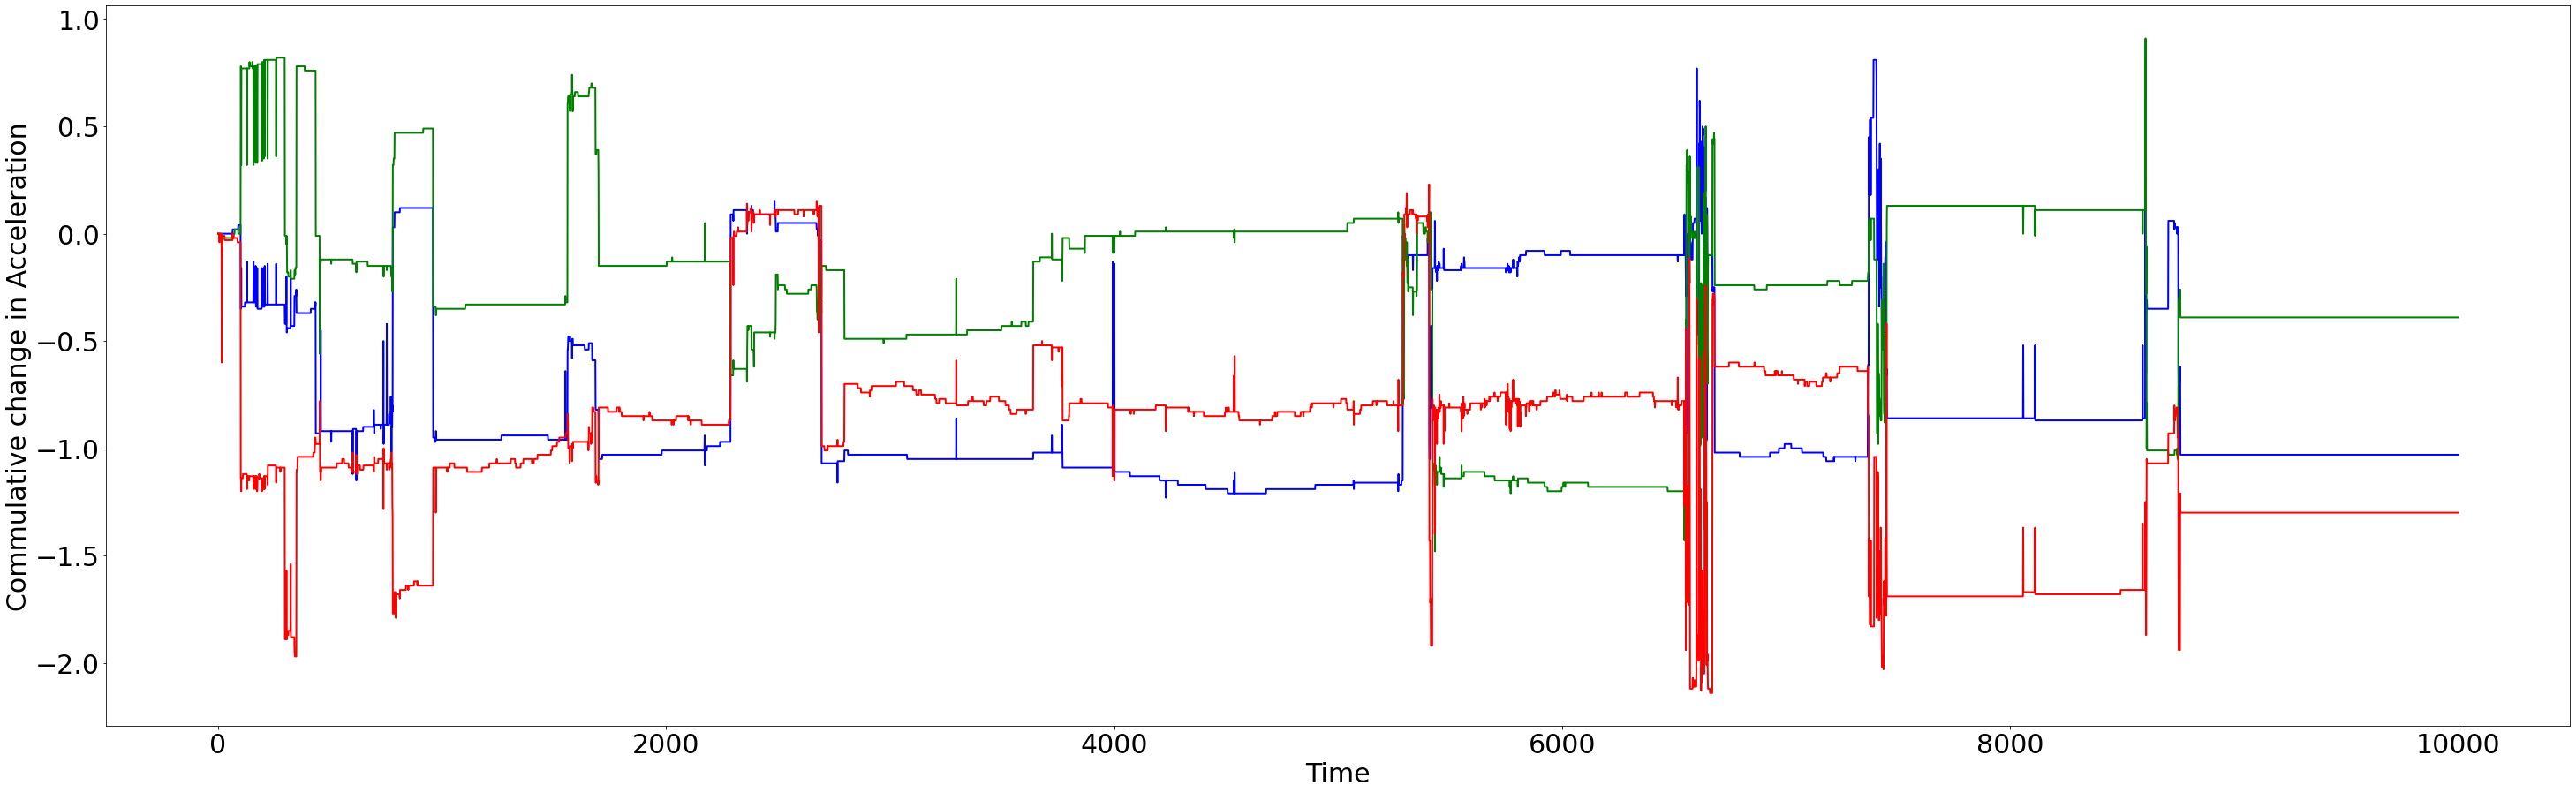

In [ ]:
plt.plot(Cx)
plt.plot(Cy)
plt.plot(Cz)
plt.xlabel("Time")
plt.ylabel("Commulative change in Acceleration")
plt.show()

In [ ]:
### grid search for cumx
scores = grid_search(Cx, cfg_list, n_test)
print('done')

 > Model[[(0, 0, 0), (0, 0, 0, 0), 'n']] 1.030
 > Model[[(0, 1, 0), (0, 0, 0, 0), 'n']] 0.000
 > Model[[(1, 0, 0), (0, 0, 0, 0), 'n']] 0.002
 > Model[[(1, 1, 0), (0, 0, 0, 0), 'n']] 0.000
 > Model[[(0, 0, 1), (0, 0, 0, 0), 'n']] 0.526
 > Model[[(1, 0, 1), (0, 0, 0, 0), 'n']] 0.001
 > Model[[(0, 1, 1), (0, 0, 0, 0), 'n']] 0.000
 > Model[[(1, 1, 1), (0, 0, 0, 0), 'n']] 0.000
done


In [ ]:
# list top 3 configs
for cfg, error in scores[:3]:
    print(cfg, error)

[(0, 1, 0), (0, 0, 0, 0), 'n'] 0.0
[(0, 1, 1), (0, 0, 0, 0), 'n'] 0.0
[(1, 1, 0), (0, 0, 0, 0), 'n'] 0.0


In [ ]:
cfg = [(1, 0, 0), (0, 0, 0, 0), 'n']

In [ ]:
l=5000
Cx = df['cumx'].values[:l]
Cy = df['cumy'].values[:l]
Cz = df['cumz'].values[:l]
Cwx = df['cumwx'].values[:l]
Cwy = df['cumwy'].values[:l]
Cwz = df['cumwz'].values[:l]

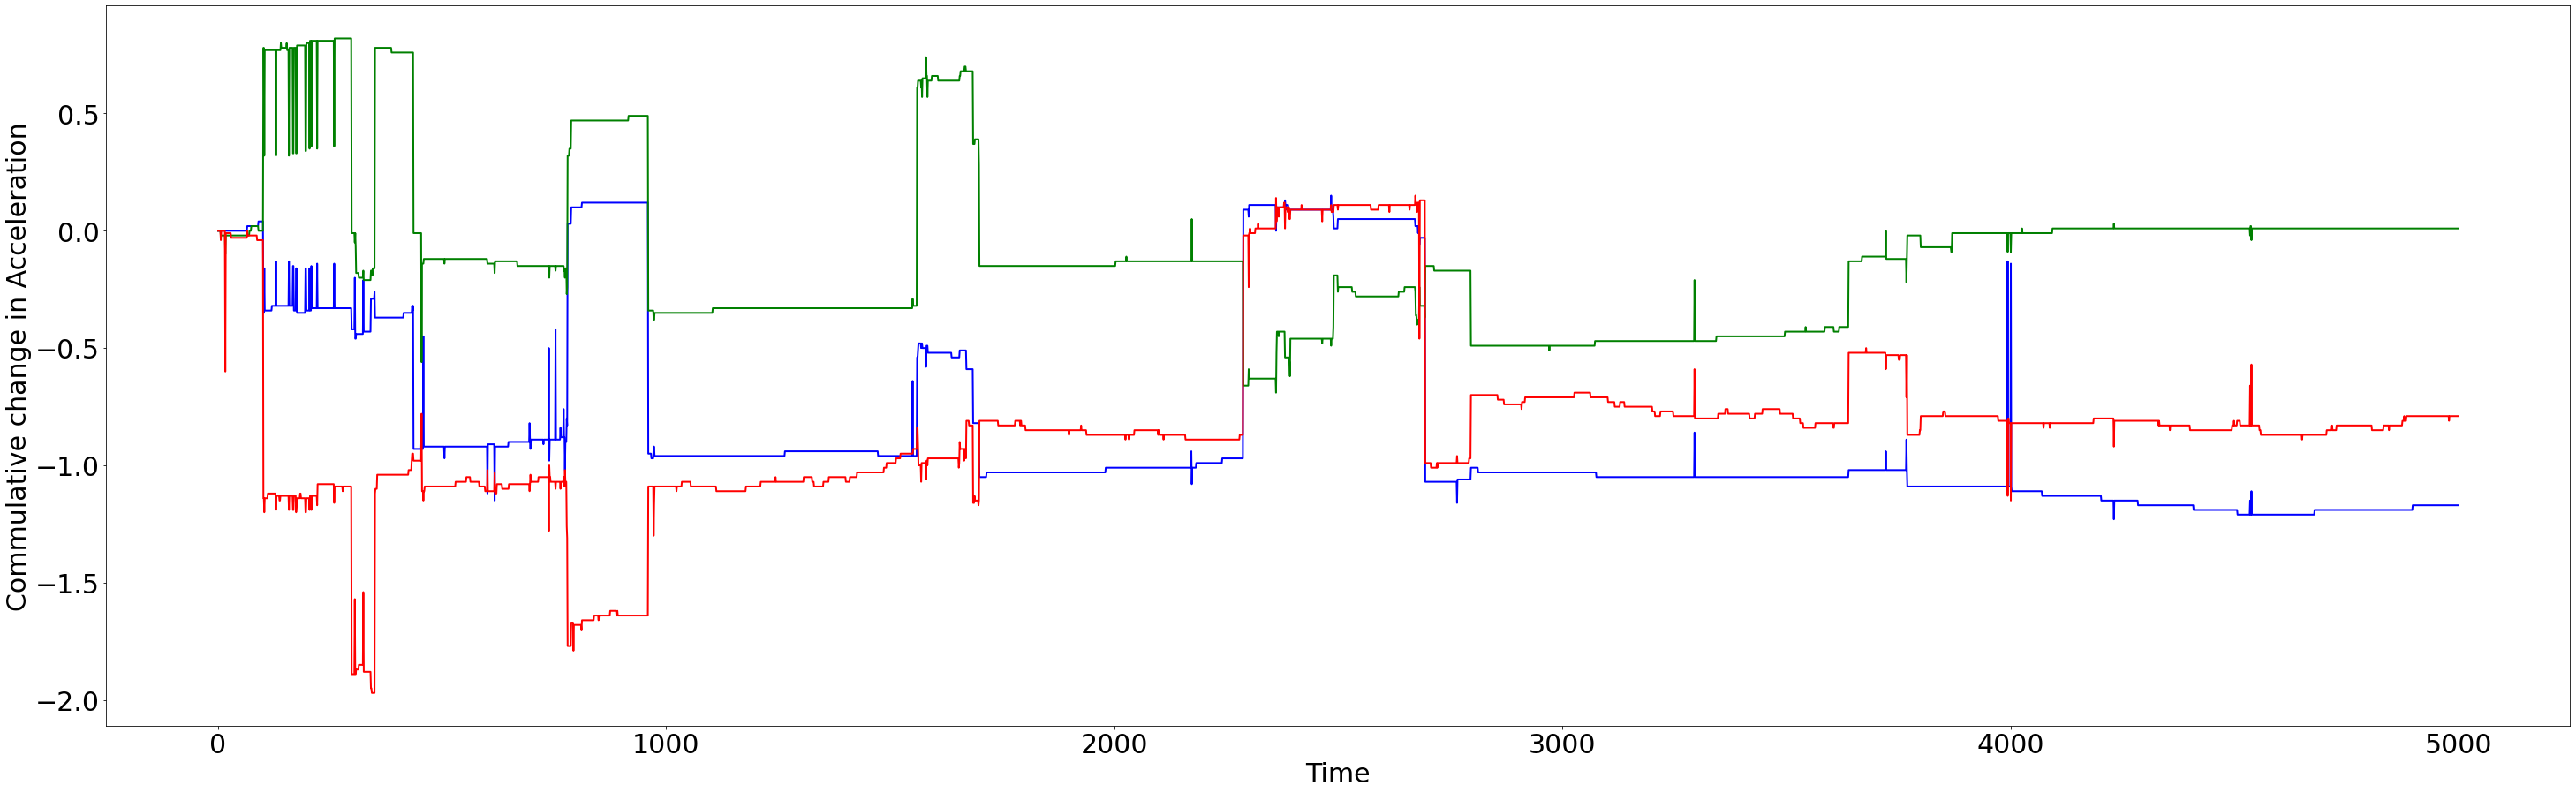

In [ ]:
plt.plot(Cx)
plt.plot(Cy)
plt.plot(Cz)
plt.xlabel("Time")
plt.ylabel("Commulative change in Acceleration")
plt.show()

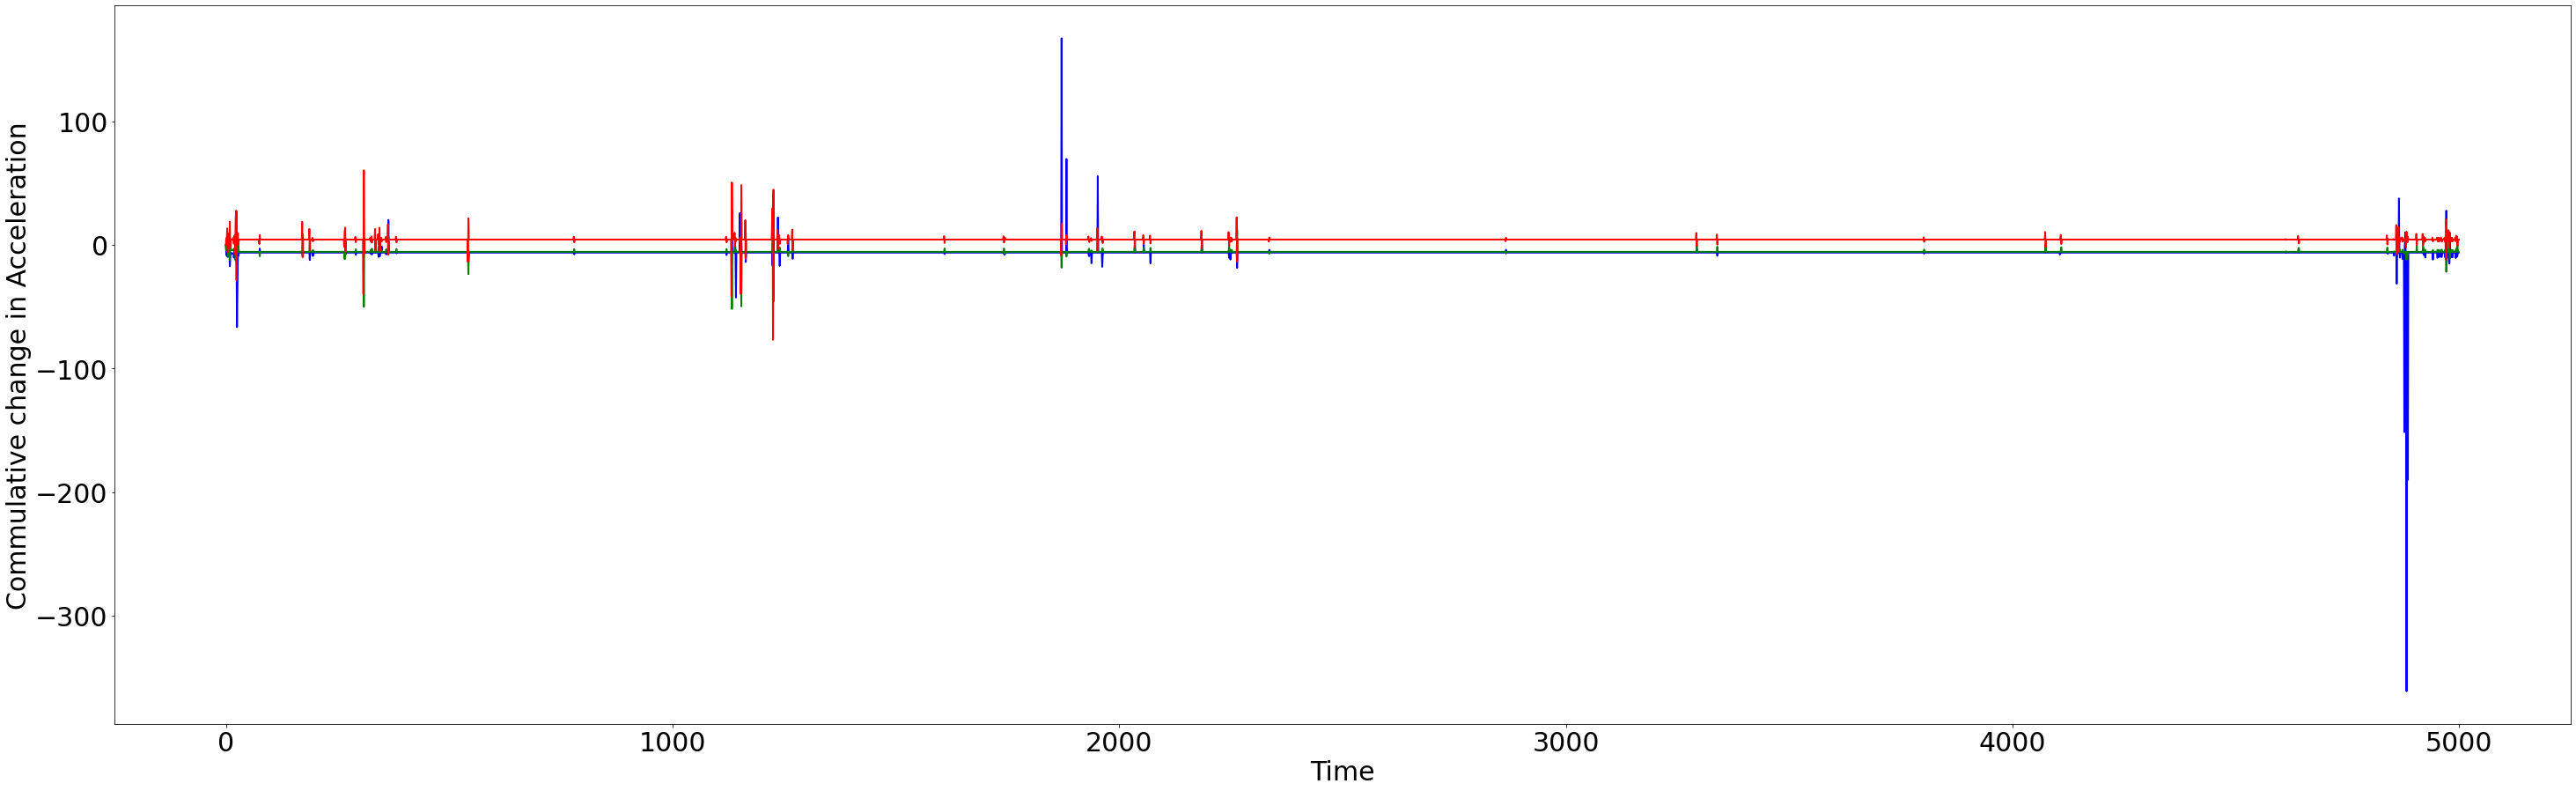

In [ ]:
plt.plot(Cwx)
plt.plot(Cwy)
plt.plot(Cwz)
plt.xlabel("Time")
plt.ylabel("Commulative change in Acceleration")
plt.show()

In [ ]:
history = walk_forward_validations(Cx, 10, cfg)

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/te

6, 0.0, 0.0
7, 0.0, 0.0
8, 0.0, 0.0
9, 0.0, 0.0
10, 0.0, 0.0
11, 0.0, 0.0
12, 0.0, 0.0
13, 0.0, 0.0
14, 0.0, 0.0
15, 0.0, 0.0
16, 0.0, 0.0


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/te

17, 0.0, 0.0
18, 0.0, 0.0
19, 0.0, 0.0
20, 0.0, 0.0
21, 0.0, 0.0
22, 0.0, 0.0
23, 0.0, 0.0
24, 0.0, 0.0
25, 0.0, 0.0
26, 0.0, 0.0
27, 0.0, 0.0


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/te

28, 0.0, 0.0
29, 0.0, 0.0
30, 0.0, 0.0
31, 0.0, 0.0
32, 0.0, 0.0
33, 0.0, 0.0
34, 0.0, 0.0
35, 0.0, 0.0
36, 0.0, 0.0
37, 0.0, 0.0


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/te

38, 0.0, 0.0
39, 0.0, 0.0
40, 0.0, 0.0
41, 0.0, 0.0
42, 0.0, 0.0
43, 0.0, 0.0
44, 0.0, 0.0
45, 0.0, 0.0
46, 0.0, 0.0
47, 0.0, 0.0


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/te

48, 0.0, 0.0
49, 0.0, 0.0
50, 0.0, 0.0
51, 0.0, 0.0
52, 0.0, 0.0
53, 0.0, 0.0
54, 0.0, 0.0
55, 0.0, 0.0
56, 0.0, 0.0


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/te

57, 0.0, 0.0
58, 0.0, 0.0
59, 0.0, 0.0
60, 0.0, 0.0
61, 0.0, 0.0
62, 0.0, 0.0
63, 0.0, 0.0
64, 0.0, 0.0
65, 0.02, 0.0
66, 0.02, 0.0
67, 0.02, 0.02
68, 0.02, 0.020000000000000004
69, 0.02, 0.02
70, 0.02, 0.02
71, 0.02, 0.020000000000000004
72, 0.02, 0.02
73, 0.02, 0.02
74, 0.02, 0.019999999999999997
75, 0.02, 0.020000000000000004
76, 0.02, 0.020000000000000004
77, 0.02, 0.020000000000000004
78, 0.02, 0.019999999999999997


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/te

79, 0.02, 0.01999999999999999
80, 0.02, 0.020000000000000004
81, 0.02, 0.019999999999999997
82, 0.02, 0.02
83, 0.02, 0.019999999999999997
84, 0.02, 0.019999999999999997
85, 0.02, 0.019999999999999997
86, 0.02, 0.020000000000000004
87, 0.02, 0.019999999999999997
88, 0.02, 0.02000000000000001
89, 0.02, 0.02
90, 0.04, 0.020000000000000004


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/te

91, 0.04, 0.04160000000000001
92, 0.04, 0.04137931034482757
93, 0.04, 0.041212121212121214
94, 0.04, 0.04108108108108107
95, 0.04, 0.04097560975609754
96, 0.04, 0.040888888888888884
97, 0.04, 0.04081632653061223
98, 0.04, 0.04075471698113206
99, 0.04, 0.040701754385964926
100, 0.04, 0.04065573770491803
101, -0.35, 0.040615384615384616
102, -0.35, -0.15724637681159107


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


103, -0.16, -0.31455696202529626
104, -0.34, -0.11204695524578119
105, -0.34, -0.2796847753185782
106, -0.34, -0.2965345577573384
107, -0.34, -0.30602568945970055
108, -0.34, -0.3121147286821705
109, -0.34, -0.3163528793057236
110, -0.34, -0.3194727231225054
111, -0.34, -0.32186529542244285
112, -0.34, -0.3237583528985958
113, -0.34, -0.3252935404740574
114, -0.34, -0.32656357388316054
115, -0.34, -0.3276316875257332
116, -0.34, -0.32854248948910536
117, -0.34, -0.3293283493532348
118, -0.34, -0.33001332592998345
119, -0.34, -0.33061567358864663
120, -0.32, -0.3311494931600816
121, -0.32, -0.311105317068592
122, -0.32, -0.31151008799198154
123, -0.32, -0.311879622545269
124, -0.32, -0.31221832993868864
125, -0.32, -0.3125299131930406
126, -0.32, -0.312817505075344
127, -0.32, -0.31308377380347585
128, -0.32, -0.3133310060739071


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


129, -0.13, -0.3135611729018395
130, -0.32, -0.12489639668986836
131, -0.32, -0.3100670706018925
132, -0.32, -0.3103860507416276
133, -0.32, -0.3106851812463046
134, -0.32, -0.31096625902457237
135, -0.32, -0.3112308704482394
136, -0.32, -0.3114804213100541
137, -0.32, -0.31171616180693945
138, -0.32, -0.3119392074886148
139, -0.32, -0.31215055690662796
140, -0.32, -0.312351106564535


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


141, -0.32, -0.3125416636253431
142, -0.32, -0.3127229567732508
143, -0.32, -0.3128956455233527
144, -0.32, -0.31306032823994046
145, -0.32, -0.3132175490607286
146, -0.32, -0.31336780390712304
147, -0.32, -0.31351154570660555
148, -0.32, -0.3136491889540272
149, -0.32, -0.31378111370286327
150, -0.32, -0.31390766907076223
151, -0.32, -0.3140291763238627
152, -0.32, -0.31414593159814314
153, -0.32, -0.31425820831097506
154, -0.32, -0.31436625930339124
155, -0.32, -0.31447031872831177
156, -0.32, -0.31457060375813206
157, -0.32, -0.3146673160888287
158, -0.13, -0.3147606432977805
159, -0.32, -0.12658049886609493
160, -0.32, -0.312930456920265
161, -0.32, -0.3130496640757953
162, -0.32, -0.31316491773505517
163, -0.32, -0.31327641136712314
164, -0.32, -0.31338432601879557
165, -0.32, -0.3134888312969172
166, -0.32, -0.3135900862587982
167, -0.15, -0.3136882402199861
168, -0.15, -0.1458841463411874
169, -0.34, -0.14589774078450474
170, -0.34, -0.3321499429373206
171, -0.34, -0.33228050991

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


175, -0.16, -0.15527291368734256
176, -0.35, -0.1552891828667615
177, -0.35, -0.3411559795277532
178, -0.35, -0.3412987886054018
179, -0.35, -0.3414370589451965
180, -0.35, -0.3415710035366362
181, -0.35, -0.341700822248485
182, -0.35, -0.34182670282106453
183, -0.35, -0.3419488217786884
184, -0.35, -0.3420673452463404
185, -0.35, -0.3421824297113586
186, -0.35, -0.34229422270981014
187, -0.35, -0.3424028634558715
188, -0.35, -0.3425084834244348
189, -0.35, -0.3426112068746891
190, -0.35, -0.3427111513529952
191, -0.35, -0.34280842811696505
192, -0.35, -0.34290314257091215
193, -0.35, -0.34299539463894196
194, -0.35, -0.34308527911286046
195, -0.16, -0.3431728859818097
196, -0.16, -0.15583140134607704


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


197, -0.34, -0.1558422720003259
198, -0.34, -0.33218267716535427
199, -0.34, -0.3322734256529328
200, -0.34, -0.33236209138592254
201, -0.34, -0.33244874525180984
202, -0.34, -0.33253345495829567
203, -0.34, -0.3326162852064747
204, -0.16, -0.33269729786163676
205, -0.34, -0.15568144052096045
206, -0.34, -0.33176214960439804
207, -0.34, -0.3318503831213298
208, -0.15, -0.3319367465737728
209, -0.33, -0.14560100144228352
210, -0.33, -0.32114849818027247
211, -0.33, -0.32123490654817505
212, -0.33, -0.32131964418680475
213, -0.33, -0.3214027590936416
214, -0.33, -0.3214842974337166
215, -0.33, -0.3215643036466421
216, -0.33, -0.32164282051281967


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


217, -0.33, -0.32171988923550304
218, -0.33, -0.32179554951386874
219, -0.33, -0.3218698396043458
220, -0.33, -0.3219427964006717
221, -0.14, -0.3220144554686569
222, -0.33, -0.13593148444939623
223, -0.33, -0.3211345672024307
224, -0.33, -0.32121191485180434
225, -0.33, -0.3212879245163136
226, -0.33, -0.32136263061272263


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


227, -0.33, -0.3214360663927653
228, -0.33, -0.32150826398236493
229, -0.33, -0.321579254437143
230, -0.33, -0.32164906777884494
231, -0.33, -0.32171773304527956
232, -0.33, -0.32178527832488335
233, -0.33, -0.3218517307971172
234, -0.33, -0.3219171167717179
235, -0.33, -0.3219814617166551


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


236, -0.33, -0.3220447902993031
237, -0.33, -0.3221071264096885
238, -0.33, -0.3221684931992295
239, -0.33, -0.3222289131010062
240, -0.33, -0.32228840786541224
241, -0.33, -0.3223469985749473
242, -0.33, -0.3224047056868461
243, -0.33, -0.32246154903442475
244, -0.33, -0.3225175478686475
245, -0.33, -0.32257272087102523
246, -0.33, -0.322627086175366
247, -0.33, -0.3226806613907056
248, -0.33, -0.3227334636149844
249, -0.33, -0.3227855094575517
250, -0.33, -0.3228368150560673
251, -0.33, -0.32288739609134287


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


252, -0.33, -0.32293726780459237
253, -0.33, -0.32298644501230267
254, -0.33, -0.32303494212189376
255, -0.33, -0.32308277314633804
256, -0.33, -0.3231299517108019
257, -0.33, -0.3231764910794057
258, -0.33, -0.3232224041510973
259, -0.14, -0.32326770348655204
260, -0.33, -0.13662766807094084


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


261, -0.33, -0.3225949494266171
262, -0.33, -0.3226437317000384
263, -0.33, -0.3226918754538093
264, -0.33, -0.3227393931433016
265, -0.33, -0.32278629689969585
266, -0.33, -0.32283259854771795
267, -0.33, -0.322878309604958
268, -0.33, -0.3229234413007064


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


269, -0.33, -0.3229680045797163
270, -0.33, -0.32301201011309016
271, -0.33, -0.32305546830725856
272, -0.33, -0.3230983893115162
273, -0.33, -0.32314078302307836
274, -0.33, -0.3231826591014235
275, -0.33, -0.3232240269688994
276, -0.33, -0.3232648958201284
277, -0.33, -0.3233052746319359
278, -0.33, -0.32334517216433467
279, -0.33, -0.32338459697094035
280, -0.33, -0.3234235574061911
281, -0.33, -0.32346206162300717
282, -0.33, -0.3235001175910105
283, -0.33, -0.32353773309171213
284, -0.33, -0.323574915726549
285, -0.33, -0.32361167292618304
286, -0.33, -0.3236480119504786
287, -0.33, -0.3236839398953635
288, -0.33, -0.3237194636970755
289, -0.33, -0.3237545901356212
290, -0.33, -0.3237893258424851
291, -0.33, -0.32382367730040124
292, -0.33, -0.32385765085009466
293, -0.33, -0.3238912526915356
294, -0.33, -0.3239244888983607


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


295, -0.33, -0.3239573653999341
296, -0.33, -0.32398988800622436
297, -0.33, -0.3240220624019573
298, -0.42, -0.3240538941468983
299, -0.42, -0.41307902198919244
300, -0.42, -0.41313789694480063
301, -0.42, -0.4131957786807445
302, -0.42, -0.4132526921225382
303, -0.42, -0.4133086613652826
304, -0.42, -0.4133637097103023
305, -0.2, -0.4134178597034812
306, -0.46, -0.19604311100271601
307, -0.46, -0.4520113213240708
308, -0.44, -0.452087995827002
309, -0.44, -0.4323220760075335
310, -0.44, -0.43238828240144667


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


311, -0.44, -0.432453356767188
312, -0.44, -0.4325173278923226
313, -0.44, -0.43258022359686965
314, -0.44, -0.4326420707727722
315, -0.44, -0.4327028954241789
316, -0.44, -0.4327627226991843
317, -0.44, -0.4328215769367054
318, -0.44, -0.43287948167710666
319, -0.44, -0.4329364597144001
320, -0.44, -0.43299253311999664
321, -0.44, -0.4330477232676498
322, -0.44, -0.4331020508648972
323, -0.44, -0.43315553597422285
324, -0.21, -0.43320819804287414
325, -0.43, -0.2059450537746355
326, -0.43, -0.42249356294023793
327, -0.43, -0.4225478117780799
328, -0.43, -0.4226012821273401
329, -0.43, -0.4226539906363644
330, -0.43, -0.4227059534623702
331, -0.43, -0.4227571863255875
332, -0.43, -0.4228077044935896
333, -0.43, -0.4228575228233072
334, -0.43, -0.42290665575334746
335, -0.43, -0.4229551173334221
336, -0.43, -0.42300292122955885
337, -0.43, -0.4230500807397819
338, -0.43, -0.42309660880686895
339, -0.43, -0.42314251802803826
340, -0.43, -0.4231878206685533


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


341, -0.29, -0.42323252867067596
342, -0.29, -0.28485002574124935
343, -0.29, -0.2848652535120685
344, -0.29, -0.28488039149592453
345, -0.29, -0.28489544048390686
346, -0.29, -0.2849104012593873
347, -0.29, -0.28492527459544736


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


348, -0.29, -0.2849400612553181
349, -0.26, -0.28495476199483444
350, -0.37, -0.25541187006969274
351, -0.37, -0.3638495666438244
352, -0.37, -0.3638783670528476
353, -0.37, -0.36390689899244866
354, -0.37, -0.36393516620184124
355, -0.37, -0.3639631723458571
356, -0.37, -0.36399092102476943
357, -0.37, -0.36401841577453403
358, -0.37, -0.36404566006425876
359, -0.37, -0.3640726572986959
360, -0.37, -0.364099410827779
361, -0.37, -0.3641259239312943
362, -0.37, -0.36415219983834823
363, -0.37, -0.3641782417191076
364, -0.37, -0.3642040526839505
365, -0.37, -0.3642296357912681
366, -0.37, -0.364254994045006
367, -0.37, -0.3642801303969353
368, -0.37, -0.364305047746538
369, -0.37, -0.36432974894446596


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


370, -0.37, -0.3643542367908844
371, -0.37, -0.3643785140371598
372, -0.37, -0.36440258338833603
373, -0.37, -0.3644264475058855
374, -0.37, -0.36445010900136426
375, -0.37, -0.36447357044483725
376, -0.37, -0.3644968343626191
377, -0.37, -0.3645199032360205
378, -0.37, -0.3645427795172118
379, -0.37, -0.36456546559837993
380, -0.37, -0.3645879638447442
381, -0.37, -0.36461027657889905
382, -0.37, -0.36463240608706854
383, -0.37, -0.36465435461689544
384, -0.37, -0.36467612437718183
385, -0.37, -0.3646977175489698
386, -0.37, -0.3647191362663066
387, -0.37, -0.364740382637316
388, -0.37, -0.36476145873212773
389, -0.37, -0.3647823665920328
390, -0.37, -0.36480310822012
391, -0.37, -0.3648236855954299
392, -0.37, -0.36484410065816697
393, -0.37, -0.3648643553216831
394, -0.37, -0.36488445146961723
395, -0.37, -0.3649043909550085
396, -0.37, -0.36492417560210805
397, -0.37, -0.36494380720906705


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


398, -0.37, -0.36496328754473534
399, -0.37, -0.36498261834651485
400, -0.37, -0.3650018013386278
401, -0.37, -0.365020838202031
402, -0.37, -0.36503973060131945
403, -0.37, -0.36505848017695086
404, -0.37, -0.36507708854139675
405, -0.37, -0.3650955572810826
406, -0.37, -0.36511388797093974
407, -0.37, -0.36513208214259635
408, -0.37, -0.36515014132031853
409, -0.37, -0.3651680670000108
410, -0.37, -0.365185860655073
411, -0.37, -0.3652035237414322


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


412, -0.37, -0.3652210576895056
413, -0.37, -0.36523846391208076
414, -0.35, -0.36525574379679276
415, -0.35, -0.3454600081343897
416, -0.35, -0.3454746503013216
417, -0.35, -0.3454891983246045
418, -0.35, -0.34550365310987446


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


419, -0.35, -0.34551801555119716
420, -0.35, -0.34553228652968143
421, -0.35, -0.3455464669151287
422, -0.35, -0.34556055757382115
423, -0.35, -0.3455745593472526
424, -0.35, -0.3455884730764373
425, -0.35, -0.3456022995900593
426, -0.35, -0.3456160397058414
427, -0.35, -0.3456296942298452
428, -0.35, -0.3456432639591204
429, -0.35, -0.3456567496804456
430, -0.35, -0.3456701521738284
431, -0.35, -0.345683472206306
432, -0.35, -0.3456967105368826
433, -0.32, -0.3457098679149577
434, -0.34, -0.31600594211564637
435, -0.32, -0.3358211074184477
436, -0.93, -0.3160243233002097
437, -0.93, -0.9229563716842407
438, -0.93, -0.9231036182989569


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


439, -0.93, -0.9232448346152698
440, -0.93, -0.9233803836388178
441, -0.93, -0.923510599823698
442, -0.93, -0.9236357918115661
443, -0.93, -0.9237562448705104
444, -0.93, -0.9238722230806202
445, -0.93, -0.9239839712538591
446, -0.93, -0.92409171667236
447, -0.93, -0.9241956706147219
448, -0.93, -0.9242960297462031
449, -0.93, -0.9243929773622777
450, -0.93, -0.9244866845179724
451, -0.93, -0.9245773109936503
452, -0.93, -0.9246650062769163
453, -0.93, -0.9247499102964484
454, -0.85, -0.9248321542278453
455, -0.93, -0.8442218013669024
456, -0.93, -0.9248717930660502
457, -0.93, -0.9249487112290297
458, -0.45, -0.9250233560983429


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


459, -0.92, -0.4442448247685157
460, -0.92, -0.9115388281092356
461, -0.92, -0.91165731339343
462, -0.92, -0.9117725261350093
463, -0.92, -0.9118846000334665
464, -0.92, -0.9119936616219965
465, -0.92, -0.9120998307912307
466, -0.92, -0.9122032210580967
467, -0.92, -0.9123039401228314
468, -0.92, -0.9124020901879156
469, -0.92, -0.9124977683062998
470, -0.92, -0.9125910666985264


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


471, -0.92, -0.912682073070093
472, -0.92, -0.912770870846762
473, -0.92, -0.9128575394621767
474, -0.92, -0.91294215458731
475, -0.92, -0.9130247883580163
476, -0.92, -0.9131055095544883


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


477, -0.92, -0.913184383819379
478, -0.92, -0.9132614738077663
479, -0.92, -0.9133368394331639
480, -0.92, -0.9134105378670315
481, -0.92, -0.9134826238444325
482, -0.92, -0.9135531497062299
483, -0.92, -0.9136221655576747
484, -0.92, -0.9136897193775033
485, -0.92, -0.9137558571499328
486, -0.92, -0.9138206229179012
487, -0.92, -0.9138840589551237
488, -0.92, -0.9139462057800823


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


489, -0.92, -0.9140071023122713
490, -0.92, -0.9140667858975432
491, -0.92, -0.9141252924224613
492, -0.92, -0.9141826563499293
493, -0.92, -0.9142389108745976
494, -0.92, -0.9142940878208118
495, -0.92, -0.9143482178865957
496, -0.92, -0.9144013305685142
497, -0.92, -0.9144534542979241
498, -0.92, -0.9145046164155417
499, -0.92, -0.9145548433356081
500, -0.92, -0.9146041604243613


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


501, -0.92, -0.914652592195066
502, -0.92, -0.9147001622778934
503, -0.92, -0.9147468934649869
504, -0.92, -0.9147928077421604
505, -0.97, -0.914837926373632
506, -0.92, -0.9650569874834468
507, -0.92, -0.9149075562410534
508, -0.92, -0.9149505221897651
509, -0.92, -0.9149927691705574
510, -0.92, -0.915034315095015
511, -0.92, -0.9150751772599737
512, -0.92, -0.9151153724079519


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


513, -0.92, -0.9151549167512356
514, -0.92, -0.9151938259560852
515, -0.92, -0.9152321152079275
516, -0.92, -0.9152697992039126
517, -0.92, -0.9153068921643809
518, -0.92, -0.9153434079399674
519, -0.92, -0.9153793598520802
520, -0.92, -0.9154147608721414
521, -0.92, -0.9154496235569727
522, -0.92, -0.9154839601156074
523, -0.92, -0.9155177823569314
524, -0.92, -0.915551101742068
525, -0.92, -0.9155839294151105
526, -0.92, -0.9156162761817314
527, -0.92, -0.9156481525218673
528, -0.92, -0.9156795686257618
529, -0.92, -0.9157105343948172
530, -0.92, -0.9157410594550366
531, -0.92, -0.9157711531203928
532, -0.92, -0.9158008244943722
533, -0.92, -0.9158300823820487
534, -0.92, -0.9158589353897022
535, -0.92, -0.9158873918550705
536, -0.92, -0.9159154599089155
537, -0.92, -0.9159431474226917
538, -0.92, -0.9159704621002286
539, -0.92, -0.915997411424657
540, -0.92, -0.9160240026683967
541, -0.92, -0.9160502429260042


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


542, -0.92, -0.9160761391001017
543, -0.92, -0.9161016978921545
544, -0.92, -0.9161269258957628
545, -0.92, -0.9161518294726011
546, -0.92, -0.9161764148640101
547, -0.92, -0.9162006880758068
548, -0.92, -0.9162246550503426
549, -0.92, -0.9162483215458745
550, -0.92, -0.9162716931620077
551, -0.92, -0.9162947753801173
552, -0.92, -0.9163175735831991
553, -0.92, -0.9163400929296989


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


554, -0.92, -0.9163623385212865
555, -0.92, -0.9163843153095126
556, -0.92, -0.9164060281608123
557, -0.92, -0.9164274817944401
558, -0.92, -0.9164486808065265
559, -0.92, -0.9164696297343544
560, -0.92, -0.9164903329507665
561, -0.92, -0.9165107947611142
562, -0.92, -0.9165310193569307
563, -0.92, -0.9165510108548939
564, -0.92, -0.9165707732468249
565, -0.92, -0.9165903104753889
566, -0.92, -0.9166096263262529
567, -0.92, -0.9166287245744299
568, -0.92, -0.9166476088552333
569, -0.92, -0.916666282761082
570, -0.92, -0.9166847497759568
571, -0.92, -0.9167030133193144
572, -0.92, -0.9167210767259463
573, -0.92, -0.9167389433138243
574, -0.92, -0.9167566162251889
575, -0.92, -0.9167740986269178
576, -0.92, -0.9167913935814861
577, -0.92, -0.9168085040571856
578, -0.92, -0.9168254330276429
579, -0.92, -0.9168421833471804
580, -0.92, -0.9168587578281763
581, -0.92, -0.9168751592249138
582, -0.92, -0.9168913902481132
583, -0.92, -0.9169074535214874
584, -0.92, -0.9169233516397198
585, -0.9

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


600, -0.92, -0.917157180810819
601, -1.12, -0.9171706205950335
602, -0.91, -1.1177174027170145
603, -0.91, -0.90697660898966
604, -0.91, -0.9069903682938981
605, -0.91, -0.9070040029482045
606, -0.91, -0.907017514620842
607, -0.91, -0.9070309049635544
608, -0.91, -0.907044175593773
609, -0.91, -0.9070573281422029
610, -0.91, -0.9070703641557865
611, -0.91, -0.9070832851630246
612, -0.91, -0.9070960927186693
613, -0.91, -0.9071087882767461
614, -0.91, -0.9071213733103073
615, -0.91, -0.9071338492656912
616, -0.91, -0.9071462175415059
617, -1.15, -0.9071584795268558
618, -0.92, -1.1477220451773096
619, -0.92, -0.9169413226803559
620, -0.92, -0.9169545497810294
621, -0.92, -0.916967663001315
622, -0.92, -0.916980663735976
623, -0.92, -0.9169935535220077
624, -0.92, -0.9170063336797935


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


625, -0.92, -0.9170190056620908
626, -0.92, -0.9170315708123976
627, -0.92, -0.9170440304829699
628, -0.92, -0.9170563859852782
629, -0.92, -0.917068638636241
630, -0.92, -0.9170807897156462
631, -0.92, -0.9170928404716728
632, -0.92, -0.9171047921344261
633, -0.92, -0.9171166459357106
634, -0.92, -0.917128403066506
635, -0.92, -0.9171400646959287
636, -0.92, -0.9171516320026206
637, -0.92, -0.9171631061132698
638, -0.92, -0.9171744881574532
639, -0.92, -0.9171857792306822


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


640, -0.92, -0.917196980419791
641, -0.92, -0.9172080927945458
642, -0.92, -0.917219117401885
643, -0.92, -0.9172300553027153
644, -0.92, -0.9172409074545366
645, -0.92, -0.917251674956877
646, -0.92, -0.9172623587323752
647, -0.92, -0.9172729597668143
648, -0.9, -0.9172834790086922
649, -0.9, -0.8972775647276465
650, -0.9, -0.8972875392800421
651, -0.9, -0.8972974410240432
652, -0.9, -0.8973072707303692
653, -0.9, -0.8973170291876057
654, -0.9, -0.8973267171779153
655, -0.9, -0.8973363354476454
656, -0.9, -0.8973458847486939
657, -0.9, -0.8973553658466662
658, -0.9, -0.8973647794373121
659, -0.9, -0.8973741262484145
660, -0.9, -0.8973834069746618
661, -0.9, -0.8973926223650291
662, -0.9, -0.8974017730509645
663, -0.9, -0.8974108597350557
664, -0.9, -0.8974198830717888
665, -0.9, -0.8974288437420243
666, -0.9, -0.8974377423961672
667, -0.9, -0.8974465796475828
668, -0.9, -0.8974553561763051
669, -0.9, -0.8974640725640533


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


670, -0.9, -0.8974727294252239
671, -0.9, -0.8974813273896932
672, -0.9, -0.8974898670864808
673, -0.9, -0.8974983490285721
674, -0.9, -0.8975067738682928
675, -0.9, -0.8975151421453696
676, -0.9, -0.8975234544321798
677, -0.9, -0.8975317112803567
678, -0.9, -0.8975399132821138
679, -0.9, -0.8975480609390553
680, -0.9, -0.8975561548082239
681, -0.9, -0.8975641954126415
682, -0.9, -0.8975721832825866
683, -0.9, -0.89758011893804
684, -0.9, -0.8975880028774194
685, -0.9, -0.8975958356081626
686, -0.9, -0.8976036176512997
687, -0.9, -0.8976113494635602
688, -0.9, -0.8976190315401316
689, -0.9, -0.8976266643729437
690, -0.9, -0.8976342484108842
691, -0.9, -0.8976417841508589
692, -0.9, -0.8976492720265143
693, -0.9, -0.8976567125040067
694, -0.9, -0.8976641060193586
695, -0.82, -0.8976714530366209
696, -0.89, -0.8176565506425549
697, -0.93, -0.8876603371004219
698, -0.89, -0.9276900719806401
699, -0.89, -0.8876697468167885
700, -0.89, -0.887676806333078
701, -0.89, -0.8876838232344888
702,

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


710, -0.89, -0.8877451182729337
711, -0.89, -0.887751729157266
712, -0.89, -0.8877583013857521
713, -0.89, -0.8877648353112566
714, -0.89, -0.8877713312552129
715, -0.89, -0.8877777895642428
716, -0.89, -0.8877842105380341
717, -0.89, -0.887790594514257
718, -0.89, -0.8877969418084753
719, -0.89, -0.8878032527424616
720, -0.89, -0.8878095276186074
721, -0.89, -0.8878157667359613
722, -0.89, -0.8878219704325269
723, -0.89, -0.8878281389892991
724, -0.89, -0.8878342726998673
725, -0.89, -0.8878403718621285
726, -0.91, -0.8878464367482525
727, -0.89, -0.9078614760632522
728, -0.89, -0.8878574817634247
729, -0.89, -0.887863447597781
730, -0.89, -0.8878693803061203
731, -0.89, -0.8878752801498192
732, -0.89, -0.8878811474095372


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


733, -0.89, -0.8878869823428193
734, -0.89, -0.887892785234728
735, -0.89, -0.8878985563595108
736, -0.89, -0.8879042959483163
737, -0.89, -0.8879100042464594


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


738, -0.5, -0.8879156815362174
739, -0.98, -0.4982386484297605
740, -0.89, -0.9773544205104797
741, -0.89, -0.8873378769193951
742, -0.89, -0.8873450397276348
743, -0.89, -0.8873521640869969
744, -0.89, -0.8873592503170868
745, -0.89, -0.8873662987074824
746, -0.89, -0.8873733095660691


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


747, -0.89, -0.8873802832246618
748, -0.89, -0.8873872199427572
749, -0.89, -0.8873941200002028
750, -0.89, -0.8874009837446942


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


751, -0.89, -0.8874078114010777
752, -0.89, -0.8874146032912911
753, -0.42, -0.8874213596794772
754, -0.89, -0.4182081746127727
755, -0.89, -0.8867830147439938
756, -0.89, -0.8867913731010764
757, -0.89, -0.8867996881448187
758, -0.89, -0.8868079602004338
759, -0.89, -0.8868161895914056
760, -0.89, -0.886824376681198
761, -0.89, -0.8868325217621946
762, -0.89, -0.8868406251635348
763, -0.89, -0.8868486872114141
764, -0.84, -0.886856708217242
765, -0.88, -0.8369210196787438
766, -0.88, -0.8768762372089776
767, -0.88, -0.876883954051919


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


768, -0.88, -0.8768916329282803
769, -0.88, -0.8768992740151097
770, -0.88, -0.8769068776348681
771, -0.76, -0.876914444046189
772, -0.88, -0.757088807095822
773, -0.88, -0.876887707047289
774, -1.02, -0.876895269557677
775, -0.9, -1.0168034066141103


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


776, -0.9, -0.8968449329668379
777, -0.9, -0.8968528863480045
778, -0.8, -0.896860799728226
779, -0.83, -0.7969936489871352
780, 0.03, -0.8269486406887688
781, 0.03, 0.029823907035954642
782, 0.03, 0.029823907524772014
783, 0.03, 0.029823908013494778
784, 0.03, 0.029823908501872862
785, 0.03, 0.029823908990881224
786, 0.03, 0.029823909479690762
787, 0.03, 0.02982390996811946
788, 0.1, 0.029823910457132185


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


789, 0.1, 0.09941368407615242
790, 0.1, 0.09941370215552693
791, 0.1, 0.09941372023542464
792, 0.1, 0.0994137383122605


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


793, 0.1, 0.09941375638833921
794, 0.1, 0.09941377446471988
795, 0.1, 0.09941379253968909
796, 0.1, 0.09941381061199474
797, 0.1, 0.09941382868527394
798, 0.1, 0.09941384675662035
799, 0.1, 0.09941386482577791
800, 0.1, 0.09941388288934609
801, 0.1, 0.09941390096238906
802, 0.1, 0.09941391903001334
803, 0.1, 0.09941393709478959
804, 0.1, 0.09941395515904489
805, 0.1, 0.09941397322201788
806, 0.1, 0.09941399128423006
807, 0.1, 0.0994140093454479
808, 0.1, 0.09941402740566187
809, 0.1, 0.09941404546446088
810, 0.1, 0.0994140635232266
811, 0.1, 0.09941408157538519
812, 0.12, 0.09941409963465092
813, 0.12, 0.11929768078252057
814, 0.12, 0.11929771194539601
815, 0.12, 0.11929774310634443
816, 0.12, 0.11929777426396744
817, 0.12, 0.11929780541856487
818, 0.12, 0.11929783657005424
819, 0.12, 0.11929786771910597
820, 0.12, 0.11929789886037956
821, 0.12, 0.11929793000811745
822, 0.12, 0.11929796114968179
823, 0.12, 0.119297992286471
824, 0.12, 0.1192980234176494
825, 0.12, 0.11929805455539562
8

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


830, 0.12, 0.11929821017556891
831, 0.12, 0.11929824129253147
832, 0.12, 0.11929827240575297
833, 0.12, 0.119298303515109


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


834, 0.12, 0.11929833462106551
835, 0.12, 0.11929836572714915
836, 0.12, 0.11929839683078643
837, 0.12, 0.11929842792877547


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


838, 0.12, 0.11929845902646918
839, 0.12, 0.11929849012031955
840, 0.12, 0.11929852120521996


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


841, 0.12, 0.11929855230004213
842, 0.12, 0.1192985833843307
843, 0.12, 0.1192986144683883
844, 0.12, 0.11929864554716253
845, 0.12, 0.11929867662475001
846, 0.12, 0.11929870769556279
847, 0.12, 0.11929873876703813
848, 0.12, 0.11929876984013314
849, 0.12, 0.11929880090201873
850, 0.12, 0.1192988319696501
851, 0.12, 0.11929886303045203
852, 0.12, 0.11929889408772901
853, 0.12, 0.11929892514518864
854, 0.12, 0.11929895619674878
855, 0.12, 0.11929898724614849


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


856, 0.12, 0.11929901829467646
857, 0.12, 0.11929904933866062
858, 0.12, 0.11929908037818852
859, 0.12, 0.11929911141823527
860, 0.12, 0.11929914245501855
861, 0.12, 0.11929917348694596
862, 0.12, 0.11929920451920081
863, 0.12, 0.11929923554568153
864, 0.12, 0.11929926657200973
865, 0.12, 0.11929929759438306
866, 0.12, 0.11929932861268307
867, 0.12, 0.11929935962943078


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


868, 0.12, 0.11929939064452352
869, 0.12, 0.11929942165515714
870, 0.12, 0.11929945266462225
871, 0.12, 0.11929948366551926
872, 0.12, 0.11929951467359665
873, 0.12, 0.11929954567400713
874, 0.12, 0.11929957666657402
875, 0.12, 0.11929960766642565


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


876, 0.12, 0.11929963865759279
877, 0.12, 0.11929966964774884
878, 0.12, 0.11929970063239158
879, 0.12, 0.1192997316184083
880, 0.12, 0.11929976259907984
881, 0.12, 0.1192997935770439
882, 0.12, 0.11929982454687486
883, 0.12, 0.11929985552656386
884, 0.12, 0.11929988649606046
885, 0.12, 0.11929991746394829
886, 0.12, 0.1192999484289568
887, 0.12, 0.11929997938595771


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


888, 0.12, 0.11930001034769146
889, 0.12, 0.11930004130169193
890, 0.12, 0.11930007225544267
891, 0.12, 0.11930010321110639
892, 0.12, 0.11930013415941118
893, 0.12, 0.1193001651051388
894, 0.12, 0.11930019604772817
895, 0.12, 0.11930022698651944
896, 0.12, 0.11930025792501521
897, 0.12, 0.11930028885992655
898, 0.12, 0.1193003197894522
899, 0.12, 0.11930035071936135
900, 0.12, 0.11930038164456953
901, 0.12, 0.11930041256438449
902, 0.12, 0.11930044349165872
903, 0.12, 0.11930047440803712
904, 0.12, 0.11930050532563795
905, 0.12, 0.119300536238296
906, 0.12, 0.1193005671470822
907, 0.12, 0.11930059805421855
908, 0.12, 0.1193006289582162
909, 0.12, 0.11930065986099417
910, 0.12, 0.1193006907610202
911, 0.12, 0.11930072165706568
912, 0.12, 0.11930075254645148
913, 0.12, 0.11930078344179637
914, 0.12, 0.11930081432999755
915, 0.12, 0.11930084521491763


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


916, 0.12, 0.11930087609811353
917, 0.12, 0.11930090697706315
918, 0.12, 0.11930093785283011
919, 0.12, 0.11930096872881069
920, 0.12, 0.11930099959950216
921, 0.12, 0.11930103046856007
922, 0.12, 0.11930106133659026
923, 0.12, 0.11930109220058312
924, 0.12, 0.11930112306124516
925, 0.12, 0.11930115391837437
926, 0.12, 0.11930118477504165
927, 0.12, 0.11930121562529465
928, 0.12, 0.1193012464763627
929, 0.12, 0.11930127732459173
930, 0.12, 0.11930130816687744
931, 0.12, 0.11930133900858436
932, 0.12, 0.11930136984905038
933, 0.12, 0.11930140068584554
934, 0.12, 0.11930143152041982
935, 0.12, 0.1193014623499772
936, 0.12, 0.11930149317739143
937, 0.12, 0.11930152400365727
938, 0.12, 0.11930155482733869
939, 0.12, 0.11930158564749374
940, 0.12, 0.11930161646389563
941, 0.12, 0.1193016472783701
942, 0.12, 0.11930167809061269
943, 0.12, 0.11930170889941176
944, 0.12, 0.1193017397064053
945, 0.12, 0.11930177051092788
946, 0.12, 0.11930180131187905
947, 0.12, 0.11930183210644758


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


948, 0.12, 0.11930186290463354
949, 0.12, 0.1193018936981408
950, 0.12, 0.11930192448808861
951, 0.12, 0.11930195527596398
952, 0.12, 0.11930198605656844
953, 0.12, 0.1193020168413067
954, 0.12, 0.11930204762190073
955, 0.12, 0.11930207839740839
956, 0.12, 0.1193021091693085
957, 0.12, 0.11930213994281563
958, 0.12, 0.11930217071214932
959, 0.12, 0.11930220147743058


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


960, -0.95, 0.11930223224075319
961, -0.95, -0.9441028218862282
962, -0.95, -0.9441190702331106
963, -0.95, -0.9441352293560785


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


964, -0.95, -0.9441512998933078
965, -0.95, -0.9441672825860027
966, -0.95, -0.9441831781830475
967, -0.97, -0.9441989873583524
968, -0.97, -0.9641482659800626
969, -0.97, -0.9641647552075874
970, -0.97, -0.9641811517745336
971, -0.97, -0.9641974564390289
972, -0.92, -0.9642136699859492
973, -0.92, -0.9143950865972704
974, -0.96, -0.9144091005809807
975, -0.96, -0.9542846686237504


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


976, -0.96, -0.9543001474813659
977, -0.96, -0.9543155427261883
978, -0.96, -0.9543308550250968
979, -0.96, -0.954346085052226


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


980, -0.96, -0.9543612334801757
981, -0.96, -0.954376300940028
982, -0.96, -0.9543912880909613
983, -0.96, -0.9544061955704337
984, -0.96, -0.9544210240083028
985, -0.96, -0.9544357740542977
986, -0.96, -0.9544504463055501
987, -0.96, -0.9544650413783202
988, -0.96, -0.9544795598347466
989, -0.96, -0.9544940024176668


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


990, -0.96, -0.9545083695957765
991, -0.96, -0.9545226619794338
992, -0.96, -0.9545368801555228


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


993, -0.96, -0.9545510247253917
994, -0.96, -0.954565096219953
995, -0.96, -0.9545790952382566
996, -0.96, -0.9545930223218894
997, -0.96, -0.9546068780308204
998, -0.96, -0.9546206629051566
999, -0.96, -0.9546343774941256
1000, -0.96, -0.9546480222917458
1001, -0.96, -0.954661597950176
1002, -0.96, -0.9546751048629235
1003, -0.96, -0.954688543596467
1004, -0.96, -0.9547019146852629


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1005, -0.96, -0.9547152186084735
1006, -0.96, -0.9547284558834881
1007, -0.96, -0.9547416270207357
1008, -0.96, -0.9547547324915943
1009, -0.96, -0.9547677728186846
1010, -0.96, -0.9547807484558075


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1011, -0.96, -0.954793659885792
1012, -0.96, -0.9548065076075593
1013, -0.96, -0.9548192920702936
1014, -0.96, -0.9548320137482266
1015, -0.96, -0.9548446730890258
1016, -0.96, -0.9548572705793406
1017, -0.96, -0.9548698066322185
1018, -0.96, -0.9548822817464842
1019, -0.96, -0.9548946963101385
1020, -0.96, -0.9549070507698673
1021, -0.96, -0.9549193456472718
1022, -0.96, -0.954931581268532
1023, -0.96, -0.9549437580907141
1024, -0.96, -0.9549558765412067
1025, -0.96, -0.954967937058901
1026, -0.96, -0.9549799400370125
1027, -0.96, -0.9549918858343344
1028, -0.96, -0.955003774998672
1029, -0.96, -0.9550156078251445
1030, -0.96, -0.9550273847119584
1031, -0.96, -0.9550391061084792
1032, -0.96, -0.9550507723492282
1033, -0.96, -0.955062383859324
1034, -0.96, -0.9550739410168885
1035, -0.96, -0.9550854441842819
1036, -0.96, -0.9550968937651362
1037, -0.96, -0.9551082901243129
1038, -0.96, -0.9551196336114627
1039, -0.96, -0.9551309246204785
1040, -0.96, -0.9551421635157763
1041, -0.96, -0

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1067, -0.96, -0.9554271519810806
1068, -0.96, -0.9554370663450557
1069, -0.96, -0.9554469378084812
1070, -0.96, -0.9554567666186086
1071, -0.96, -0.9554665531546275
1072, -0.96, -0.9554762975865287
1073, -0.96, -0.9554860001815316
1074, -0.96, -0.9554956613079653
1075, -0.96, -0.9555052811355461
1076, -0.96, -0.9555148599810852
1077, -0.96, -0.9555243980605422
1078, -0.96, -0.9555338956651772
1079, -0.96, -0.9555433530593589
1080, -0.96, -0.9555527704259722
1081, -0.96, -0.9555621481612362
1082, -0.96, -0.9555714863897098
1083, -0.96, -0.9555807854046404
1084, -0.96, -0.955590045452564
1085, -0.96, -0.9555992667365076
1086, -0.96, -0.9556084496068206
1087, -0.96, -0.9556175941947501
1088, -0.96, -0.9556267007837772
1089, -0.96, -0.9556357695908673
1090, -0.96, -0.9556448008523808
1091, -0.96, -0.9556537948800948
1092, -0.96, -0.9556627517832411
1093, -0.96, -0.9556716718632504
1094, -0.96, -0.955680555311909
1095, -0.96, -0.9556894023428877
1096, -0.96, -0.9556982132658034


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1097, -0.96, -0.9557069882423718
1098, -0.96, -0.9557157274670585
1099, -0.96, -0.9557244311744872
1100, -0.96, -0.9557330996059729
1101, -0.96, -0.9557417329611523
1102, -0.96, -0.9557503314017701
1103, -0.96, -0.9557588952703474
1104, -0.96, -0.9557674246435489
1105, -0.96, -0.9557759197971388
1106, -0.96, -0.9557843809081024
1107, -0.96, -0.9557928081903523
1108, -0.96, -0.9558012018498289
1109, -0.96, -0.9558095620690711
1110, -0.96, -0.9558178890729482
1111, -0.96, -0.9558261830627308
1112, -0.96, -0.9558344441943615
1113, -0.96, -0.9558426726655154
1114, -0.96, -0.9558508687314435
1115, -0.96, -0.9558590325637341
1116, -0.96, -0.955867164324025
1117, -0.96, -0.9558752642045225


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1118, -0.96, -0.9558833323888449
1119, -0.96, -0.9558913690580265
1120, -0.96, -0.9558993744316627
1121, -0.96, -0.9559073486633565
1122, -0.96, -0.9559152919334508
1123, -0.96, -0.9559232043802753
1124, -0.96, -0.955931086347699
1125, -0.96, -0.9559389378379749
1126, -0.96, -0.9559467590786378


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1127, -0.96, -0.955954550214924
1128, -0.96, -0.9559623115408483
1129, -0.96, -0.9559700430824304
1130, -0.96, -0.9559777451068899
1131, -0.96, -0.9559854177215246
1132, -0.96, -0.955993061137724


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1133, -0.96, -0.9560006754945889
1134, -0.96, -0.9560082609583387
1135, -0.96, -0.9560158176564859
1136, -0.96, -0.9560233459022967
1137, -0.96, -0.9560308457056759
1138, -0.96, -0.9560383172771264
1139, -0.96, -0.9560457607601728
1140, -0.96, -0.9560531763379829
1141, -0.96, -0.9560605641423043
1142, -0.96, -0.9560679243393687
1143, -0.96, -0.9560752570905549
1144, -0.96, -0.9560825625531479
1145, -0.96, -0.95608984086026
1146, -0.96, -0.9560970921699746
1147, -0.96, -0.9561043165926983
1148, -0.96, -0.9561115143956673
1149, -0.96, -0.9561186856123534
1150, -0.96, -0.9561258304495608
1151, -0.96, -0.9561329490149227
1152, -0.96, -0.9561400414220388
1153, -0.96, -0.9561471079323004
1154, -0.96, -0.9561541486061785
1155, -0.96, -0.9561611635740787
1156, -0.96, -0.9561681529974294
1157, -0.96, -0.9561751170331928
1158, -0.96, -0.956182055787125
1159, -0.96, -0.9561889693967073
1160, -0.96, -0.956195858034547
1161, -0.96, -0.9562027218227994
1162, -0.96, -0.9562095608594593
1163, -0.96, -

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1207, -0.96, -0.9564937326490655
1208, -0.96, -0.9564995644182854
1209, -0.96, -0.9565053768381109


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1210, -0.96, -0.9565111699676175
1211, -0.96, -0.9565169439432735
1212, -0.96, -0.9565226988120269
1213, -0.96, -0.956528434704454
1214, -0.96, -0.9565341517320637
1215, -0.96, -0.9565398499346395
1216, -0.96, -0.9565455294315135
1217, -0.96, -0.9565511903344824
1218, -0.96, -0.956556832671891
1219, -0.96, -0.9565624565926614
1220, -0.96, -0.9565680622224327
1221, -0.96, -0.9565736495224091
1222, -0.96, -0.9565792187321713
1223, -0.96, -0.9565847698424538
1224, -0.96, -0.9565903029545166
1225, -0.96, -0.9565958181637246
1226, -0.96, -0.9566013155708478
1227, -0.96, -0.956606795235008
1228, -0.96, -0.9566122572811016
1229, -0.96, -0.9566177017451194
1230, -0.96, -0.9566231287618284
1231, -0.96, -0.9566285383596123
1232, -0.96, -0.9566339306692332
1233, -0.96, -0.956639305778309
1234, -0.96, -0.9566446637047893
1235, -0.96, -0.9566500046272691
1236, -0.96, -0.9566553285516463
1237, -0.96, -0.9566606355797673
1238, -0.96, -0.9566659257842606
1239, -0.96, -0.9566711992611306
1240, -0.96, -

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1252, -0.96, -0.9567382669722586
1253, -0.96, -0.956743314257655
1254, -0.96, -0.9567483459378338
1255, -0.96, -0.956753362111818
1256, -0.96, -0.9567583628351334
1257, -0.96, -0.9567633481469952
1258, -0.96, -0.9567683181825564
1259, -0.96, -0.9567732729620809
1260, -0.96, -0.9567782125756744
1261, -0.96, -0.9567831371039756
1262, -0.96, -0.9567880465766714
1263, -0.96, -0.9567929410677787


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1264, -0.96, -0.9567978207303044
1265, -0.94, -0.9568026855289344
1266, -0.94, -0.936844339078342
1267, -0.94, -0.9368489218923909
1268, -0.94, -0.9368534914204892
1269, -0.94, -0.9368580477073065


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1270, -0.94, -0.936862590815222
1271, -0.94, -0.9368671207664511
1272, -0.94, -0.9368716377458601
1273, -0.94, -0.9368761416622591
1274, -0.94, -0.9368806326515834
1275, -0.94, -0.9368851107179358


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1276, -0.94, -0.9368895759756004
1277, -0.94, -0.9368940284338764
1278, -0.94, -0.9368984681614608
1279, -0.94, -0.9369028951944461
1280, -0.94, -0.9369073096408999
1281, -0.94, -0.9369117115221895
1282, -0.94, -0.9369161008669354
1283, -0.94, -0.9369204777674167
1284, -0.94, -0.9369248422550519
1285, -0.94, -0.9369291943921607
1286, -0.94, -0.9369335342158746
1287, -0.94, -0.9369378618294016
1288, -0.94, -0.9369421772046691
1289, -0.94, -0.9369464804589662
1290, -0.94, -0.9369507715721139
1291, -0.94, -0.9369550507114969
1292, -0.94, -0.9369593178199738
1293, -0.94, -0.9369635729900628


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1294, -0.94, -0.9369678162682902
1295, -0.94, -0.9369720476577456
1296, -0.94, -0.9369762673360611
1297, -0.94, -0.9369804752305058
1298, -0.94, -0.9369846714054175
1299, -0.94, -0.9369888559700136
1300, -0.94, -0.9369930289394885
1301, -0.94, -0.9369971903402436
1302, -0.94, -0.9370013402426296
1303, -0.94, -0.9370054786926738
1304, -0.94, -0.9370096057245514
1305, -0.94, -0.9370137214138505


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1306, -0.94, -0.9370178257637168
1307, -0.94, -0.9370219188670789
1308, -0.94, -0.9370260007504665
1309, -0.94, -0.9370300714656643
1310, -0.94, -0.9370341310298874
1311, -0.94, -0.9370381795269528
1312, -0.94, -0.9370422169837571
1313, -0.94, -0.9370462434358696
1314, -0.94, -0.9370502589760588


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1315, -0.94, -0.9370542635897106
1316, -0.94, -0.9370582573394827
1317, -0.94, -0.9370622402311721
1318, -0.94, -0.9370662124431891
1319, -0.94, -0.9370701738970322
1320, -0.94, -0.9370741246556998


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1321, -0.94, -0.9370780647472964
1322, -0.94, -0.9370819942944445
1323, -0.94, -0.9370859132551647
1324, -0.94, -0.9370898217103036
1325, -0.94, -0.9370937196933318
1326, -0.94, -0.9370976072426139
1327, -0.94, -0.9371014844149105
1328, -0.94, -0.93710535123467
1329, -0.94, -0.9371092077600067
1330, -0.94, -0.9371130539976383
1331, -0.94, -0.9371168900339581
1332, -0.94, -0.9371207159124398


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1333, -0.94, -0.93712453162863
1334, -0.94, -0.9371283372393338
1335, -0.94, -0.9371321327955282
1336, -0.94, -0.9371359183186527
1337, -0.94, -0.9371396938889917
1338, -0.94, -0.9371434595020447


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1339, -0.94, -0.9371472152142641
1340, -0.94, -0.9371509610549027
1341, -0.94, -0.9371546970871197
1342, -0.94, -0.937158423302192
1343, -0.94, -0.937162139819261
1344, -0.94, -0.9371658465992198


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1345, -0.94, -0.9371695437137597
1346, -0.94, -0.9371732311784489
1347, -0.94, -0.9371769090665071
1348, -0.94, -0.937180577394829
1349, -0.94, -0.9371842362040538
1350, -0.94, -0.9371878855263136
1351, -0.94, -0.9371915253920117
1352, -0.94, -0.9371951558555651
1353, -0.94, -0.937198776954506
1354, -0.94, -0.9372023886996963
1355, -0.94, -0.9372059911144
1356, -0.94, -0.9372095843402376
1357, -0.94, -0.9372131682872447
1358, -0.94, -0.9372167430581669
1359, -0.94, -0.9372203086561304


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1360, -0.94, -0.937223865111606
1361, -0.94, -0.9372274125212021
1362, -0.94, -0.9372309508455268
1363, -0.94, -0.937234480166492
1364, -0.94, -0.937238000499896
1365, -0.94, -0.9372415118632162


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1366, -0.94, -0.9372450143350238
1367, -0.94, -0.9372485079168947
1368, -0.94, -0.9372519926341575
1369, -0.94, -0.9372554685036931
1370, -0.94, -0.9372589356661697
1371, -0.94, -0.9372623940507686
1372, -0.94, -0.9372658437389638
1373, -0.94, -0.9372692847193197
1374, -0.94, -0.9372727170481118
1375, -0.94, -0.9372761407468504
1376, -0.94, -0.9372795559027068
1377, -0.94, -0.9372829624760516
1378, -0.94, -0.9372863605321008
1379, -0.94, -0.9372897500796774
1380, -0.94, -0.9372931311996915
1381, -0.94, -0.9372965038848349
1382, -0.94, -0.9372998681920643
1383, -0.94, -0.9373032240957234
1384, -0.94, -0.9373065717117778
1385, -0.94, -0.9373099110129351
1386, -0.94, -0.937313242033888


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1387, -0.94, -0.9373165648004943
1388, -0.94, -0.9373198793797936
1389, -0.94, -0.9373231858021233
1390, -0.94, -0.9373264840509057
1391, -0.94, -0.9373297741903093
1392, -0.94, -0.9373330562224933


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1393, -0.94, -0.9373363302253411
1394, -0.94, -0.9373395961810327
1395, -0.94, -0.9373428541393853
1396, -0.94, -0.9373461041248495
1397, -0.94, -0.9373493461637081
1398, -0.94, -0.9373525803215882
1399, -0.94, -0.9373558065781683
1400, -0.94, -0.9373590249786014
1401, -0.94, -0.9373622355528152
1402, -0.94, -0.9373654383172911
1403, -0.94, -0.9373686333516875
1404, -0.94, -0.937371820624039
1405, -0.94, -0.937375000173368
1406, -0.94, -0.9373781720616207
1407, -0.94, -0.9373813362851203
1408, -0.94, -0.9373844928660208
1409, -0.94, -0.9373876418694231
1410, -0.94, -0.9373907832723916


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1411, -0.94, -0.9373939171426309
1412, -0.94, -0.937397043495342
1413, -0.94, -0.9374001623320468
1414, -0.94, -0.9374032737110878
1415, -0.94, -0.9374063777134787
1416, -0.94, -0.9374094742711939


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1417, -0.94, -0.9374125634151894
1418, -0.94, -0.9374156452307383
1419, -0.94, -0.937418719702507
1420, -0.94, -0.9374217868619591
1421, -0.94, -0.9374248467370203
1422, -0.94, -0.9374278993608964
1423, -0.94, -0.9374309447750986
1424, -0.94, -0.9374339829549432
1425, -0.94, -0.9374370139736475
1426, -0.94, -0.9374400378447096
1427, -0.94, -0.9374430545955054
1428, -0.94, -0.9374460642298666
1429, -0.94, -0.9374490667875494
1430, -0.94, -0.9374520622773621
1431, -0.94, -0.9374550507311765
1432, -0.94, -0.9374580322685269
1433, -0.94, -0.9374610067694468
1434, -0.94, -0.9374639742963097
1435, -0.94, -0.9374669349351198
1436, -0.94, -0.9374698886603946


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1437, -0.94, -0.9374728354965959
1438, -0.94, -0.9374757754738093
1439, -0.94, -0.9374787086201384
1440, -0.94, -0.9374816349614845
1441, -0.94, -0.9374845545150052
1442, -0.94, -0.937487467307649
1443, -0.94, -0.9374903733610356
1444, -0.94, -0.9374932726844895
1445, -0.94, -0.9374961653324719
1446, -0.94, -0.937499051322865
1447, -0.94, -0.9375019306634162


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1448, -0.94, -0.9375048033755804
1449, -0.94, -0.9375076694847108
1450, -0.94, -0.9375105290154093
1451, -0.94, -0.9375133820004717
1452, -0.94, -0.9375162284523773
1453, -0.94, -0.9375190683967384


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1454, -0.94, -0.9375219018418647
1455, -0.94, -0.9375247288286016
1456, -0.94, -0.9375275493572192
1457, -0.94, -0.937530363482993
1458, -0.94, -0.9375331712294672
1459, -0.94, -0.9375359725634601
1460, -0.94, -0.9375387675758671
1461, -0.94, -0.9375415562451493
1462, -0.94, -0.9375443385940977
1463, -0.94, -0.9375471146519829
1464, -0.94, -0.9375498844364805
1465, -0.94, -0.9375526479203933
1466, -0.94, -0.9375554052369032
1467, -0.94, -0.937558156377383
1468, -0.94, -0.9375609013247436
1469, -0.94, -0.9375636400786082
1470, -0.94, -0.9375663726977833
1471, -0.94, -0.937569099172602
1472, -0.94, -0.9375718195723666
1473, -0.96, -0.9375745338730151
1474, -0.96, -0.9575485009847463
1475, -0.96, -0.9575513526992439
1476, -0.96, -0.957554197790543
1477, -0.96, -0.9575570362631453
1478, -0.96, -0.9575598681716919
1479, -0.96, -0.9575626935156838
1480, -0.96, -0.9575655123281819
1481, -0.96, -0.9575683246244696
1482, -0.96, -0.9575711304252251
1483, -0.96, -0.9575739297696123


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1484, -0.96, -0.9575767226632002
1485, -0.96, -0.9575795091210336
1486, -0.96, -0.9575822891861151
1487, -0.96, -0.9575850628770897
1488, -0.96, -0.9575878302045149
1489, -0.96, -0.9575905912271812
1490, -0.96, -0.957593345909778
1491, -0.96, -0.9575960942583805
1492, -0.96, -0.9575988363913799
1493, -0.96, -0.9576015723028518
1494, -0.96, -0.9576043019367484
1495, -0.96, -0.9576070253691984
1496, -0.96, -0.957609742634931
1497, -0.96, -0.9576124537299892
1498, -0.96, -0.9576151586920367
1499, -0.96, -0.9576178574954132
1500, -0.96, -0.9576205502306433
1501, -0.96, -0.9576232368806586
1502, -0.96, -0.9576259174749849
1503, -0.96, -0.9576285920204619
1504, -0.96, -0.9576312605327088
1505, -0.96, -0.9576339230750197
1506, -0.96, -0.9576365796082941
1507, -0.96, -0.9576392302119914
1508, -0.96, -0.9576418748055348
1509, -0.96, -0.957644513586256
1510, -0.96, -0.957647146413097
1511, -0.96, -0.9576497733779689
1512, -0.96, -0.957652394482164
1513, -0.96, -0.9576550097287775
1514, -0.96, -0

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1516, -0.96, -0.9576628206581617
1517, -0.96, -0.9576654127343273
1518, -0.96, -0.9576679990665332
1519, -0.96, -0.9576705797144529
1520, -0.96, -0.9576731546164492
1521, -0.96, -0.9576757238406085
1522, -0.96, -0.9576782874249302
1523, -0.96, -0.9576808453427065
1524, -0.96, -0.9576833976280683


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1525, -0.96, -0.9576859442833393
1526, -0.96, -0.9576884853565918
1527, -0.96, -0.9576910208809941
1528, -0.96, -0.9576935508316828
1529, -0.96, -0.9576960752404582
1530, -0.96, -0.9576985941343463
1531, -0.96, -0.9577011075247253
1532, -0.96, -0.9577036154009615
1533, -0.96, -0.9577061178689381
1534, -0.96, -0.9577086148464189
1535, -0.96, -0.9577111064205327
1536, -0.96, -0.9577135925163466
1537, -0.96, -0.9577160733104627
1538, -0.96, -0.9577185487049079
1539, -0.96, -0.9577210187034392


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1540, -0.96, -0.9577234833847591
1541, -0.96, -0.9577259427261482
1542, -0.96, -0.9577283967762334
1543, -0.96, -0.957730845516814
1544, -0.96, -0.9577332890082185
1545, -0.96, -0.9577357272266557
1546, -0.96, -0.9577381602066938
1547, -0.96, -0.9577405879669408
1548, -0.96, -0.9577430105138173


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1549, -0.96, -0.9577454278657112
1550, -0.64, -0.9577478400543112
1551, -0.96, -0.6382721612603229
1552, -0.96, -0.9576373676205274
1553, -0.96, -0.95763988884642


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1554, -0.96, -0.9576424046802453
1555, -0.96, -0.9576449151127263
1556, -0.96, -0.9576474202795326
1557, -0.96, -0.9576499200957843
1558, -0.96, -0.9576524146093393


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1559, -0.96, -0.9576549038229771
1560, -0.54, -0.9576573877620527
1561, -0.54, -0.5384337020594792
1562, -0.51, -0.5384342262500842
1563, -0.48, -0.5085122291995845
1564, -0.48, -0.47859173939097316
1565, -0.48, -0.47859211144754643
1566, -0.48, -0.47859248329909754
1567, -0.48, -0.4785928549536621


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1568, -0.48, -0.4785932264523734
1569, -0.5, -0.47859359772071913


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1570, -0.48, -0.49854088098426064
1571, -0.48, -0.4785941514014778
1572, -0.5, -0.4785945221276912
1573, -0.5, -0.49854183887110837
1574, -0.5, -0.4985422558636639
1575, -0.5, -0.49854267263713303
1576, -0.5, -0.4985430891560667
1577, -0.5, -0.4985435054505085
1578, -0.5, -0.49854392149277
1579, -0.5, -0.4985443373121491
1580, -0.58, -0.4985447528779583
1581, -0.49, -0.5783388808771374
1582, -0.49, -0.4885679901649024
1583, -0.49, -0.4885683824333067
1584, -0.52, -0.4885687744788336
1585, -0.52, -0.5184902803284029
1586, -0.52, -0.518490745653386
1587, -0.52, -0.5184912107210367
1588, -0.52, -0.518491675482231
1589, -0.52, -0.5184921399576824
1590, -0.52, -0.518492604146731
1591, -0.52, -0.5184930680665489
1592, -0.52, -0.5184935316889342
1593, -0.52, -0.5184939950220362
1594, -0.52, -0.5184944580704349
1595, -0.52, -0.5184949208330608
1596, -0.52, -0.5184953833290391
1597, -0.52, -0.51849584552818
1598, -0.52, -0.5184963074454833
1599, -0.52, -0.5184967690674728
1600, -0.52, -0.518497

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1620, -0.52, -0.518506398284467
1621, -0.52, -0.5185068537345081
1622, -0.52, -0.51850730891342
1623, -0.52, -0.5185077638261489
1624, -0.52, -0.5185082184186026
1625, -0.52, -0.5185086727972139
1626, -0.52, -0.5185091268632963
1627, -0.52, -0.5185095806673022
1628, -0.52, -0.5185100341768559
1629, -0.52, -0.5185104874190236
1630, -0.52, -0.5185109403971956


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1631, -0.52, -0.5185113930858523
1632, -0.52, -0.5185118454956583
1633, -0.52, -0.5185122976298302
1634, -0.52, -0.5185127494846835
1635, -0.52, -0.5185132010991274
1636, -0.52, -0.5185136524188092
1637, -0.54, -0.518514103462849
1638, -0.54, -0.5384637224030516
1639, -0.54, -0.5384642248322107
1640, -0.54, -0.5384647269330259


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1641, -0.54, -0.5384652287101
1642, -0.54, -0.5384657301561057
1643, -0.54, -0.5384662312646383
1644, -0.54, -0.5384667320653211
1645, -0.54, -0.5384672325227882
1646, -0.54, -0.5384677326578179
1647, -0.54, -0.5384682324770423
1648, -0.54, -0.5384687319624851
1649, -0.54, -0.5384692311144671
1650, -0.54, -0.5384697299583748
1651, -0.54, -0.5384702284645851
1652, -0.54, -0.5384707266353708
1653, -0.54, -0.5384712245036265
1654, -0.54, -0.5384717220497153
1655, -0.51, -0.5384722192535029
1656, -0.51, -0.5085483502289131
1657, -0.51, -0.5085487712319091
1658, -0.51, -0.508549191989898
1659, -0.51, -0.5085496125122089
1660, -0.51, -0.5085500327921134
1661, -0.51, -0.5085504528091288
1662, -0.51, -0.5085508726083181
1663, -0.51, -0.5085512921500666


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1664, -0.51, -0.5085517114523864
1665, -0.51, -0.5085521305029439
1666, -0.51, -0.508552549317273


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1667, -0.51, -0.508552967898951
1668, -0.51, -0.5085533862217068
1669, -0.51, -0.5085538043102602
1670, -0.59, -0.5085542221545329
1671, -0.59, -0.5883546489649756
1672, -0.59, -0.5883552847607408
1673, -0.59, -0.5883559200299248
1674, -0.59, -0.5883565548904227
1675, -0.59, -0.5883571892170429
1676, -0.59, -0.5883578230469076
1677, -0.59, -0.5883584563999577
1678, -0.59, -0.5883590892628776
1679, -0.59, -0.5883597216395697


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1680, -0.59, -0.5883603535269424
1681, -0.59, -0.5883609849259219
1682, -0.59, -0.5883616158356861
1683, -0.59, -0.5883622462542576
1684, -0.59, -0.5883628761978278
1685, -0.82, -0.5883635056660326
1686, -0.82, -0.8178492836780508
1687, -0.82, -0.8178508792107173
1688, -0.82, -0.8178524723671935
1689, -0.82, -0.8178540631626499
1690, -0.82, -0.8178556516031712
1691, -0.82, -0.8178572376924269
1692, -0.82, -0.8178588214247973
1693, -0.82, -0.8178604028462511
1694, -0.82, -0.8178619819195141
1695, -0.82, -0.817863558664133
1696, -0.82, -0.8178651330834156
1697, -0.82, -0.8178667051873364
1698, -0.88, -0.8178682749750275
1699, -1.05, -0.8777613240618811
1700, -1.05, -1.0475027438747169
1701, -1.05, -1.0475057485173682
1702, -1.05, -1.0475087459416994
1703, -1.05, -1.0475117361283315
1704, -1.05, -1.047514719244885
1705, -1.05, -1.0475176951526808
1706, -1.05, -1.0475206639805847
1707, -1.05, -1.0475236256709852
1708, -1.05, -1.0475265803318774
1709, -1.05, -1.0475295279311814
1710, -1.05,

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1711, -1.05, -1.0475354021036498
1712, -1.05, -1.0475383287279774


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1713, -1.05, -1.0475412484051045
1714, -1.05, -1.047544161165492
1715, -1.03, -1.047547067021872
1716, -1.03, -1.0275734465587307
1717, -1.03, -1.027576203039149
1718, -1.03, -1.027578953238916
1719, -1.03, -1.027581697229784
1720, -1.03, -1.0275844350303893
1721, -1.03, -1.027587166616103
1722, -1.03, -1.0275898920283175
1723, -1.03, -1.0275926112796936


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1724, -1.03, -1.0275953244381943
1725, -1.03, -1.0275980314364246
1726, -1.03, -1.0276007323855891
1727, -1.03, -1.0276034272762704
1728, -1.03, -1.0276061160982648
1729, -1.03, -1.0276087988982443
1730, -1.03, -1.027611475668952


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1731, -1.03, -1.027614146496734
1732, -1.03, -1.0276168113314985
1733, -1.03, -1.0276194702284582
1734, -1.03, -1.0276221231883254
1735, -1.03, -1.027624770211851
1736, -1.03, -1.0276274114095583
1737, -1.03, -1.0276300467081159
1738, -1.03, -1.0276326761887342
1739, -1.03, -1.027635299822662


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1740, -1.03, -1.0276379176428188
1741, -1.03, -1.027640529664873
1742, -1.03, -1.0276431358935814
1743, -1.03, -1.027645736445073


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1744, -1.03, -1.0276483312221332
1745, -1.03, -1.0276509202795692
1746, -1.03, -1.0276535036539642
1747, -1.03, -1.0276560813186975
1748, -1.03, -1.027658653377978
1749, -1.03, -1.0276612197603296
1750, -1.03, -1.0276637805400155
1751, -1.03, -1.0276663357059665
1752, -1.03, -1.0276688853115692
1753, -1.03, -1.0276714293531821
1754, -1.03, -1.0276739678105764
1755, -1.03, -1.027676500770538
1756, -1.03, -1.0276790282282606
1757, -1.03, -1.0276815501598364
1758, -1.03, -1.0276840666520421
1759, -1.03, -1.027686577643266
1760, -1.03, -1.0276890832257206
1761, -1.03, -1.0276915834023823
1762, -1.03, -1.0276940781558546
1763, -1.03, -1.0276965675101644
1764, -1.03, -1.0276990515105737
1765, -1.03, -1.027701530161906
1766, -1.03, -1.0277040034813854
1767, -1.03, -1.0277064714653203
1768, -1.03, -1.0277089341443093
1769, -1.03, -1.0277113915584495
1770, -1.03, -1.0277138437235065
1771, -1.03, -1.0277162906001236
1772, -1.03, -1.0277187322694648
1773, -1.03, -1.0277211687334407
1774, -1.03, -

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1790, -1.03, -1.027761806295271
1791, -1.03, -1.0277641516506963
1792, -1.03, -1.027766492086481
1793, -1.03, -1.0277688276459147
1794, -1.03, -1.027771158316924
1795, -1.03, -1.0277734841243182
1796, -1.03, -1.0277758050815218
1797, -1.03, -1.0277781212124
1798, -1.03, -1.0277804324974213
1799, -1.03, -1.0277827390002023
1800, -1.03, -1.027785040718262
1801, -1.03, -1.0277873376702273
1802, -1.03, -1.0277896298221878
1803, -1.03, -1.027791917288614
1804, -1.03, -1.027794199989434
1805, -1.03, -1.0277964779944837
1806, -1.03, -1.027798751279748
1807, -1.03, -1.0278010198800651
1808, -1.03, -1.0278032838260394
1809, -1.03, -1.0278055430889814
1810, -1.03, -1.0278077977397746
1811, -1.03, -1.0278100477387155
1812, -1.03, -1.0278122931275033
1813, -1.03, -1.0278145339300637
1814, -1.03, -1.0278167701306182
1815, -1.03, -1.027819001781421
1816, -1.03, -1.0278212288527522


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1817, -1.03, -1.0278234514034188
1818, -1.03, -1.027825669408753
1819, -1.03, -1.027827882879848
1820, -1.03, -1.0278300918680212
1821, -1.03, -1.027832296376025
1822, -1.03, -1.0278344964121047
1823, -1.03, -1.0278366919567463
1824, -1.03, -1.0278388830901393
1825, -1.03, -1.0278410697712597
1826, -1.03, -1.027843252036353
1827, -1.03, -1.0278454298608581
1828, -1.03, -1.0278476033318678
1829, -1.03, -1.0278497723618611


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1830, -1.03, -1.027851937144493
1831, -1.03, -1.0278540974825534
1832, -1.03, -1.027856253519134
1833, -1.03, -1.0278584052027497
1834, -1.03, -1.0278605525778681
1835, -1.03, -1.027862695635366
1836, -1.03, -1.0278648344023809
1837, -1.03, -1.0278669689307227
1838, -1.03, -1.0278690991813102
1839, -1.03, -1.0278712251536397
1840, -1.03, -1.027873346922571
1841, -1.03, -1.0278754644158647
1842, -1.03, -1.0278775777721494
1843, -1.03, -1.0278796868683677
1844, -1.03, -1.0278817918218148
1845, -1.03, -1.0278838925762468
1846, -1.03, -1.0278859891583276
1847, -1.03, -1.0278880816100344
1848, -1.03, -1.0278901699165426


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1849, -1.03, -1.027892254089008
1850, -1.03, -1.027894334133783
1851, -1.03, -1.027896410103236
1852, -1.03, -1.0278984819720058
1853, -1.03, -1.0279005497856581
1854, -1.03, -1.0279026134888711
1855, -1.03, -1.0279046731773567
1856, -1.03, -1.02790672877019
1857, -1.03, -1.0279087804270564
1858, -1.03, -1.0279108280216747
1859, -1.03, -1.0279128715839012
1860, -1.03, -1.0279149111700803
1861, -1.03, -1.0279169467705553
1862, -1.03, -1.0279189784303429


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1863, -1.03, -1.027921006110519
1864, -1.03, -1.0279230298233686
1865, -1.03, -1.027925049625845
1866, -1.03, -1.0279270654629953
1867, -1.03, -1.0279290774511363
1868, -1.03, -1.0279310855080819


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1869, -1.03, -1.0279330896423575
1870, -1.03, -1.0279350899536217
1871, -1.03, -1.0279370863433122
1872, -1.03, -1.0279390789088128
1873, -1.03, -1.027941067637107
1874, -1.03, -1.0279430525145898
1875, -1.03, -1.0279450335783702
1876, -1.03, -1.0279470108221245


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1877, -1.03, -1.0279489842415797
1878, -1.03, -1.0279509539106957
1879, -1.03, -1.027952919784632
1880, -1.03, -1.0279548818580109
1881, -1.03, -1.027956840240198
1882, -1.03, -1.0279587948190017


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1883, -1.03, -1.027960745703174
1884, -1.03, -1.0279626928410688
1885, -1.03, -1.0279646362433845
1886, -1.03, -1.027966575982954
1887, -1.03, -1.0279685119755182
1888, -1.03, -1.0279704443461815
1889, -1.03, -1.0279723730158132
1890, -1.03, -1.027974298006884
1891, -1.03, -1.0279762193821507
1892, -1.03, -1.027978137098042


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1893, -1.03, -1.027980051160664
1894, -1.03, -1.027981961629138
1895, -1.03, -1.0279838684609193
1896, -1.03, -1.0279857717173322
1897, -1.03, -1.0279876714065173
1898, -1.03, -1.0279895674705921
1899, -1.03, -1.0279914599791111
1900, -1.03, -1.0279933489542377
1901, -1.03, -1.02799523435942
1902, -1.03, -1.027997116222611
1903, -1.03, -1.0279989945562622
1904, -1.03, -1.028000869354004
1905, -1.03, -1.0280027406714867
1906, -1.03, -1.028004608451863
1907, -1.03, -1.0280064727814344
1908, -1.03, -1.0280083336065902
1909, -1.03, -1.028010190957071
1910, -1.03, -1.0280120448734569
1911, -1.03, -1.0280138953264282
1912, -1.03, -1.0280157423410778
1913, -1.03, -1.0280175859265883
1914, -1.03, -1.0280194260665687
1915, -1.03, -1.0280212628288723
1916, -1.03, -1.0280230961504055


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1917, -1.03, -1.0280249261102479
1918, -1.03, -1.028026752669148
1919, -1.03, -1.0280285757757608
1920, -1.03, -1.028030395669541
1921, -1.03, -1.0280322121080057
1922, -1.03, -1.0280340252322462
1923, -1.03, -1.028035834999556
1924, -1.03, -1.0280376414605772
1925, -1.03, -1.0280394445890737
1926, -1.03, -1.0280412444035554
1927, -1.03, -1.02804304092217
1928, -1.03, -1.0280448341452304


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1929, -1.03, -1.0280466240869464
1930, -1.03, -1.0280484107323458
1931, -1.03, -1.0280501941465165
1932, -1.03, -1.0280519742906362
1933, -1.03, -1.0280537511839458
1934, -1.03, -1.0280555248410763
1935, -1.03, -1.0280572952517093
1936, -1.03, -1.0280590624576627


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1937, -1.03, -1.0280608264727336
1938, -1.03, -1.028062587241729


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1939, -1.03, -1.0280643448586273
1940, -1.03, -1.0280660992487767
1941, -1.03, -1.028067850500285
1942, -1.03, -1.028069598563697


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1943, -1.03, -1.0280713434474844
1944, -1.03, -1.0280730852185014


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1945, -1.03, -1.0280748238269704
1946, -1.03, -1.0280765592950596
1947, -1.03, -1.0280782916250237
1948, -1.03, -1.028080020859466


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1949, -1.03, -1.0280817469998265
1950, -1.03, -1.028083470019829
1951, -1.03, -1.0280851899404264
1952, -1.03, -1.0280869067690963
1953, -1.03, -1.0280886205451494
1954, -1.03, -1.028090331236047
1955, -1.03, -1.0280920388781973
1956, -1.03, -1.028093743462855
1957, -1.03, -1.028095445028056
1958, -1.03, -1.0280971435347954
1959, -1.03, -1.02809883899498
1960, -1.03, -1.028100531473562
1961, -1.03, -1.028102220947886


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1962, -1.03, -1.0281039073911977
1963, -1.03, -1.0281055908378198
1964, -1.03, -1.0281072713065889
1965, -1.03, -1.028108948805411
1966, -1.03, -1.028110623288223
1967, -1.03, -1.0281122948908015
1968, -1.03, -1.028113963481136
1969, -1.03, -1.0281156291535742
1970, -1.03, -1.0281172918678727
1971, -1.03, -1.0281189516528746
1972, -1.03, -1.0281206085164758
1973, -1.03, -1.0281222624493627
1974, -1.03, -1.02812391349871
1975, -1.03, -1.0281255616365115


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1976, -1.03, -1.0281272068783653
1977, -1.03, -1.0281288492244545
1978, -1.03, -1.0281304886973603
1979, -1.03, -1.0281321253165754
1980, -1.03, -1.0281337590318504
1981, -1.01, -1.028135389954703
1982, -1.01, -1.0081560689199225
1983, -1.01, -1.008157615707645
1984, -1.01, -1.0081591598746222
1985, -1.01, -1.0081607014606442
1986, -1.01, -1.0081622404932753
1987, -1.01, -1.008163776911211
1988, -1.01, -1.0081653107705533
1989, -1.01, -1.0081668420772028
1990, -1.01, -1.0081683708724938
1991, -1.01, -1.0081698970607806
1992, -1.01, -1.008171420734681
1993, -1.01, -1.0081729418555265
1994, -1.01, -1.0081744604845986
1995, -1.01, -1.0081759765452392
1996, -1.01, -1.0081774901206657
1997, -1.01, -1.0081790011926612


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1998, -1.01, -1.0081805097391157
1999, -1.01, -1.0081820157622792


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2000, -1.01, -1.0081835193649034
2001, -1.01, -1.0081850204390603
2002, -1.01, -1.0081865190375618
2003, -1.01, -1.0081880151675602
2004, -1.01, -1.0081895088093091
2005, -1.01, -1.0081910000274878
2006, -1.01, -1.0081924887501996
2007, -1.01, -1.0081939750538407
2008, -1.01, -1.0081954589250661
2009, -1.01, -1.0081969402777662
2010, -1.01, -1.0081984193172775
2011, -1.01, -1.008199895868659
2012, -1.01, -1.0082013700449124
2013, -1.01, -1.0082028417855091


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2014, -1.01, -1.0082043111076038
2015, -1.01, -1.0082057780350189
2016, -1.01, -1.0082072425627584
2017, -1.01, -1.008208704709858
2018, -1.01, -1.0082101644496062
2019, -1.01, -1.0082116218479946
2020, -1.01, -1.0082130768663526
2021, -1.01, -1.0082145295058618
2022, -1.01, -1.0082159797984132
2023, -1.01, -1.0082174277102054
2024, -1.01, -1.0082188733098296
2025, -1.01, -1.0082203165523624
2026, -1.01, -1.0082217574236916
2027, -1.01, -1.0082231960069985
2028, -1.01, -1.0082246322735564
2029, -1.01, -1.0082260661967097
2030, -1.01, -1.0082274978128358
2031, -1.01, -1.008228927111558
2032, -1.01, -1.00823035410768
2033, -1.01, -1.0082317788144473
2034, -1.01, -1.0082332012061224
2035, -1.01, -1.0082346213511815


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2036, -1.01, -1.0082360391716232
2037, -1.01, -1.0082374547588784
2038, -1.01, -1.0082388680517815
2039, -1.01, -1.008240279083524
2040, -1.01, -1.008241687860475
2041, -1.01, -1.0082430943765652
2042, -1.01, -1.008244498627712
2043, -1.01, -1.0082459006767504


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2044, -1.01, -1.008247300427195
2045, -1.01, -1.0082486980189274
2046, -1.01, -1.0082500933467944
2047, -1.01, -1.0082514864381549
2048, -1.01, -1.0082528773327752
2049, -1.01, -1.0082542660269165
2050, -1.01, -1.0082556525111912
2051, -1.01, -1.0082570367777541
2052, -1.01, -1.0082584188613295
2053, -1.01, -1.008259798754937


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2054, -1.01, -1.008261176451171
2055, -1.01, -1.0082625519540094
2056, -1.01, -1.008263925295233
2057, -1.01, -1.0082652965111694
2058, -1.01, -1.0082666655268542
2059, -1.01, -1.008268032384839
2060, -1.01, -1.0082693970595429
2061, -1.01, -1.0082707596427938
2062, -1.01, -1.008272120043585
2063, -1.01, -1.0082734783252547
2064, -1.01, -1.0082748344596317
2065, -1.01, -1.0082761884010127
2066, -1.01, -1.0082775403408069
2067, -1.01, -1.0082788901212818
2068, -1.01, -1.0082802377816495
2069, -1.01, -1.0082815833222019
2070, -1.01, -1.0082829267427775
2071, -1.01, -1.0082842680782216
2072, -1.01, -1.0082856073256106
2073, -1.01, -1.008286944494285
2074, -1.01, -1.0082882795849657
2075, -1.01, -1.0082896125609955
2076, -1.01, -1.0082909434831497
2077, -1.01, -1.0082922723406331
2078, -1.01, -1.0082935991347097
2079, -1.01, -1.0082949238518975
2080, -1.01, -1.0082962465191738
2081, -1.01, -1.008297567133109
2082, -1.01, -1.0082988857292303
2083, -1.01, -1.008300202247525
2084, -1.01, -1.0

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2102, -1.01, -1.0083248348243192
2103, -1.01, -1.0083261114914506
2104, -1.01, -1.008327386257617
2105, -1.01, -1.008328659063203
2106, -1.01, -1.0083299299260586
2107, -1.01, -1.0083311988704622
2108, -1.01, -1.008332465856773
2109, -1.01, -1.0083337309660854
2110, -1.01, -1.0083349941398176
2111, -1.01, -1.0083362553751405
2112, -1.01, -1.0083375147109228
2113, -1.01, -1.0083387721669517
2114, -1.01, -1.008340027708586
2115, -1.01, -1.0083412813517583
2116, -1.01, -1.0083425331023652
2117, -1.01, -1.0083437829892317
2118, -1.01, -1.008345030973399
2119, -1.01, -1.0083462770683358
2120, -1.01, -1.008347521269645
2121, -1.01, -1.008348763637715
2122, -1.01, -1.0083500041489706
2123, -1.01, -1.0083512427756443
2124, -1.01, -1.0083524795238576
2125, -1.01, -1.0083537144211032
2126, -1.01, -1.0083549475254399
2127, -1.01, -1.008356178742567
2128, -1.01, -1.0083574080925755
2129, -1.01, -1.0083586356414176
2130, -1.01, -1.0083598613305473
2131, -1.01, -1.0083610852484997


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2132, -1.01, -1.0083623072962729
2133, -1.01, -1.0083635275271885
2134, -1.01, -1.0083647459243859
2135, -1.01, -1.008365962527899
2136, -1.01, -1.0083671773066534
2137, -1.01, -1.0083683903285643


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2138, -1.01, -1.0083696014928363
2139, -1.01, -1.0083708108790166
2140, -1.01, -1.0083720184773695
2141, -1.01, -1.0083732243105796


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2142, -1.01, -1.0083744283113156
2143, -1.01, -1.0083756305761897
2144, -1.01, -1.0083768310190042
2145, -1.01, -1.0083780297173344
2146, -1.01, -1.0083792266532716
2147, -1.01, -1.008380421814946


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2148, -1.01, -1.0083816151910217
2149, -1.01, -1.0083828068281404
2150, -1.01, -1.0083839967363777
2151, -1.01, -1.0083851848497096
2152, -1.01, -1.0083863712418848
2153, -1.01, -1.0083875559106015


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2154, -1.01, -1.0083887388031836
2155, -1.01, -1.0083899199797026
2156, -1.01, -1.0083910994187808
2157, -1.01, -1.0083922771545841
2158, -1.01, -1.0083934531552692
2159, -1.01, -1.0083946274235696
2160, -1.01, -1.0083957999912774
2161, -1.01, -1.008396970841015
2162, -1.01, -1.008398139982769
2163, -1.01, -1.0083993074137485
2164, -1.01, -1.0084004731569705
2165, -1.01, -1.0084016371754723
2166, -1.01, -1.0084027995046985
2167, -1.01, -1.0084039601960486
2168, -1.01, -1.0084051191458758
2169, -1.01, -1.0084062764586266
2170, -1.01, -1.0084074320572654
2171, -1.01, -1.0084085859925247
2172, -0.94, -1.0084097382518165
2173, -1.08, -0.9384738885180952


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2174, -1.01, -1.0783484377194161
2175, -1.01, -1.0084026808143762
2176, -1.01, -1.0084038340084416
2177, -1.01, -1.0084049855385988
2178, -1.01, -1.0084061354084257
2179, -1.01, -1.0084072836357505
2180, -1.01, -1.0084084301876486
2181, -1.01, -1.0084095751061333
2182, -1.01, -1.0084107183563111
2183, -0.99, -1.008411859978218
2184, -0.99, -0.9884303538012996
2185, -0.99, -0.9884314355865734
2186, -0.99, -0.9884325158784703
2187, -0.99, -0.9884335946831784


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2188, -0.99, -0.9884346719813306
2189, -0.99, -0.9884357478434505


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2190, -0.99, -0.988436822204336
2191, -0.99, -0.9884378950889711
2192, -0.99, -0.9884389665062476
2193, -0.99, -0.988440036434056
2194, -0.99, -0.9884411049353956
2195, -0.99, -0.9884421719489158
2196, -0.99, -0.988443237511509
2197, -0.99, -0.988444301591657


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2198, -0.99, -0.9884453642622935
2199, -0.99, -0.9884464254597394
2200, -0.99, -0.98844748519294
2201, -0.99, -0.9884485435142951


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2202, -0.99, -0.9884496003656258
2203, -0.99, -0.9884506558014379
2204, -0.99, -0.9884517097843283
2205, -0.99, -0.9884527623394506
2206, -0.99, -0.9884538134611965
2207, -0.99, -0.9884548631332191
2208, -0.99, -0.9884559114067107
2209, -0.99, -0.9884569582917707
2210, -0.99, -0.9884580037092868
2211, -0.99, -0.9884590477312103
2212, -0.99, -0.9884600903292446
2213, -0.99, -0.9884611315441664
2214, -0.99, -0.9884621713289354
2215, -0.99, -0.988463209712039


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2216, -0.99, -0.9884642467000332
2217, -0.99, -0.9884652822616379
2218, -0.99, -0.9884663164501529
2219, -0.99, -0.9884673492674051
2220, -0.99, -0.9884683806654483
2221, -0.99, -0.9884694106579586
2222, -0.99, -0.988470439321494
2223, -0.99, -0.9884714665775138
2224, -0.99, -0.988472492429255
2225, -0.99, -0.9884735169296599
2226, -0.99, -0.9884745400504132
2227, -0.99, -0.9884755618264304


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2228, -0.99, -0.9884765821953825
2229, -0.99, -0.9884776012011023
2230, -0.99, -0.9884786188776433
2231, -0.99, -0.9884796351663212
2232, -0.99, -0.9884806501296952
2233, -0.99, -0.9884816637114169
2234, -0.99, -0.9884826759312718
2235, -0.99, -0.9884836868411315
2236, -0.99, -0.9884846963813066
2237, -0.99, -0.9884857045535582
2238, -0.99, -0.9884867114295359
2239, -0.99, -0.9884877169494819
2240, -0.99, -0.9884887211170131
2241, -0.97, -0.9884897239679451
2242, -0.97, -0.9685082210824761
2243, -0.97, -0.9685091701664436
2244, -0.97, -0.9685101180264013
2245, -0.97, -0.9685110647135667
2246, -0.97, -0.9685120101908595
2247, -0.97, -0.9685129544617171
2248, -0.97, -0.9685138975326484
2249, -0.97, -0.9685148393913875
2250, -0.97, -0.9685157800789267
2251, -0.97, -0.968516719588264
2252, -0.97, -0.968517657889493
2253, -0.97, -0.9685185949928903
2254, -0.97, -0.9685195309273371
2255, -0.97, -0.9685204656799016
2256, -0.97, -0.9685213992679998
2257, -0.97, -0.9685223316706986


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2258, -0.97, -0.968523262883593
2259, -0.97, -0.9685241929318875
2260, -0.97, -0.968525121811577
2261, -0.97, -0.9685260495027782
2262, -0.97, -0.9685269760495586
2263, -0.97, -0.9685279014381869
2264, -0.97, -0.9685288256538591
2265, -0.97, -0.9685297486916667
2266, -0.97, -0.9685306706081053
2267, -0.97, -0.9685315913212614
2268, -0.97, -0.9685325109226416
2269, -0.97, -0.968533429376498
2270, -0.97, -0.9685343466510148
2271, -0.97, -0.9685352628163848
2272, -0.97, -0.9685361777923825
2273, -0.97, -0.9685370916660109


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2274, -0.97, -0.9685380043863645
2275, -0.97, -0.9685389159576003
2276, -0.97, -0.9685398263878848
2277, -0.97, -0.9685407357078575
2278, -0.97, -0.9685416438810085
2279, -0.97, -0.9685425509116729
2280, -0.97, -0.9685434568477017
2281, -0.97, -0.9685443616442713
2282, -0.97, -0.9685452652921774
2283, -0.97, -0.9685461678402946
2284, -0.97, -0.9685470692916501
2285, -0.97, -0.9685479695808865
2286, -0.97, -0.9685488687835869
2287, -0.97, -0.9685497668837134


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2288, 0.09, -0.9685506638489442
2289, 0.09, 0.08980481619975339
2290, 0.09, 0.08980481723630378
2291, 0.09, 0.08980481827613553


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2292, 0.09, 0.08980481931557488
2293, 0.09, 0.08980482035045717
2294, 0.09, 0.0898048213903246
2295, 0.09, 0.08980482243086087
2296, 0.09, 0.0898048234698447
2297, 0.09, 0.08980482450830642
2298, 0.09, 0.08980482554631816
2299, 0.09, 0.08980482658518048
2300, 0.06, 0.08980482762364754
2301, 0.11, 0.059869779354670236
2302, 0.11, 0.10976147949539462
2303, 0.11, 0.10976148138891895
2304, 0.11, 0.1097614832868845
2305, 0.11, 0.1097614851809871
2306, 0.11, 0.1097614870754589
2307, 0.11, 0.10976148897223975
2308, 0.11, 0.10976149087015716
2309, 0.11, 0.10976149276392566
2310, 0.11, 0.1097614946593098
2311, 0.11, 0.10976149655677157
2312, 0.11, 0.10976149845229408
2313, 0.11, 0.10976150034797665
2314, 0.11, 0.1097615022424961
2315, 0.11, 0.10976150413980514
2316, 0.11, 0.10976150603398742
2317, 0.11, 0.10976150792835454
2318, 0.11, 0.10976150982377249
2319, 0.11, 0.10976151171300201
2320, 0.11, 0.10976151361695574
2321, 0.11, 0.10976151551181255
2322, 0.11, 0.10976151740705209
2323, 0.11, 0.

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2350, 0.11, 0.1097615704637064
2351, 0.11, 0.10976157235712676
2352, 0.11, 0.10976157425205048
2353, 0.11, 0.10976157614688499


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2354, 0.11, 0.1097615780404002
2355, 0.11, 0.10976157993459243
2356, 0.11, 0.1097615818297098
2357, 0.11, 0.109761583724035
2358, 0.11, 0.10976158561813938
2359, 0.11, 0.10976158750997718
2360, 0.11, 0.10976158940413025
2361, 0.0, 0.10976159129847766
2362, 0.1, -1.3847599742525381e-17
2363, 0.1, 0.09978247206582234
2364, 0.1, 0.09978247349279294
2365, 0.1, 0.09978247492406962
2366, 0.1, 0.09978247635113016
2367, 0.08, 0.09978247778048666
2368, 0.1, 0.0798258783149046
2369, 0.1, 0.09978245386047552
2370, 0.1, 0.09978245528828364
2371, 0.1, 0.09978245671648746


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2372, 0.1, 0.0997824581454832
2373, 0.1, 0.09978245957128817
2374, 0.1, 0.09978246100152754
2375, 0.1, 0.0997824624280093


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2376, 0.1, 0.09978246385843208
2377, 0.1, 0.09978246528572121
2378, 0.1, 0.09978246671258272
2379, 0.1, 0.09978246814284909
2380, 0.1, 0.09978246956803027
2381, 0.13, 0.09978247099868076
2382, 0.11, 0.12971747019066543
2383, 0.09, 0.10976075121035507
2384, 0.11, 0.08980412255711026
2385, 0.11, 0.10976072549321637
2386, 0.11, 0.10976072739423692
2387, 0.11, 0.1097607292924293
2388, 0.11, 0.1097607311938835
2389, 0.09, 0.10976073309800924
2390, 0.09, 0.08980410774652503
2391, 0.09, 0.08980410878932499
2392, 0.09, 0.08980410982896336
2393, 0.09, 0.08980411086953945
2394, 0.09, 0.08980411191216589
2395, 0.09, 0.08980411295491977
2396, 0.09, 0.08980411399457011
2397, 0.09, 0.08980411503585695
2398, 0.09, 0.08980411607924214
2399, 0.09, 0.08980411712194888
2400, 0.09, 0.0898041181634594
2401, 0.09, 0.08980411920497697
2402, 0.09, 0.08980412024608465
2403, 0.09, 0.08980412128753469
2404, 0.09, 0.08980412232906364
2405, 0.09, 0.08980412336876807
2406, 0.09, 0.08980412441044736
2407, 0.09, 0.08

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2412, 0.09, 0.08980413066095166
2413, 0.09, 0.08980413170090076
2414, 0.09, 0.08980413274329516
2415, 0.09, 0.0898041337849847
2416, 0.09, 0.08980413482571277
2417, 0.09, 0.08980413586702207
2418, 0.09, 0.08980413690846305
2419, 0.09, 0.08980413795039051
2420, 0.09, 0.08980413898976035
2421, 0.09, 0.08980414003259804


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2422, 0.09, 0.08980414107429556
2423, 0.09, 0.08980414211340236
2424, 0.09, 0.08980414315455386
2425, 0.09, 0.08980414419613028
2426, 0.09, 0.08980414523902155
2427, 0.09, 0.08980414628052563
2428, 0.09, 0.08980414732009112
2429, 0.09, 0.08980414836297695


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2430, 0.09, 0.08980414940417332
2431, 0.09, 0.08980415044473382
2432, 0.09, 0.08980415148510815
2433, 0.09, 0.08980415252473628
2434, 0.09, 0.08980415356668749
2435, 0.09, 0.08980415460783141
2436, 0.09, 0.08980415564917478
2437, 0.09, 0.0898041566908146
2438, 0.09, 0.08980415773277686
2439, 0.09, 0.08980415877406688
2440, 0.09, 0.08980415981479094
2441, 0.09, 0.08980416085365048
2442, 0.09, 0.08980416189572411
2443, 0.09, 0.08980416293677725
2444, 0.09, 0.08980416397967694
2445, 0.09, 0.08980416502078462


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2446, 0.09, 0.08980416606135129
2447, 0.09, 0.08980416709839976
2448, 0.09, 0.08980416814318737
2449, 0.09, 0.08980416918467544
2450, 0.09, 0.08980417022383778
2451, 0.09, 0.08980417126632412
2452, 0.09, 0.08980417230762193
2453, 0.09, 0.08980417334798362
2454, 0.09, 0.08980417438730527
2455, 0.09, 0.08980417542854852
2456, 0.09, 0.08980417646924446
2457, 0.09, 0.08980417751158283
2458, 0.09, 0.089804178553089
2459, 0.09, 0.08980417959404119
2460, 0.09, 0.08980418063481999
2461, 0.09, 0.08980418167401145
2462, 0.09, 0.08980418271646795
2463, 0.09, 0.08980418375577645
2464, 0.09, 0.08980418479788253
2465, 0.09, 0.08980418583833387
2466, 0.09, 0.0898041868779382
2467, 0.09, 0.08980418791734711
2468, 0.09, 0.0898041889596754
2469, 0.09, 0.08980419000177885
2470, 0.09, 0.08980419103950542
2471, 0.09, 0.08980419208103482
2472, 0.09, 0.08980419312138956
2473, 0.09, 0.08980419416512983


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2474, 0.09, 0.08980419520543553
2475, 0.09, 0.08980419624590164
2476, 0.09, 0.08980419728650138
2477, 0.09, 0.08980419832783805
2478, 0.09, 0.08980419936665532
2479, 0.09, 0.08980420040730999
2480, 0.09, 0.08980420144812781
2481, 0.09, 0.0898042024893262
2482, 0.09, 0.08980420352920765
2483, 0.09, 0.08980420456908947


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2484, 0.15, 0.089804205612321
2485, 0.09, 0.14967420922328412
2486, 0.09, 0.08980399695733421
2487, 0.09, 0.08980399799968423
2488, 0.09, 0.08980399903879863
2489, 0.06, 0.08980400008208328
2490, 0.01, 0.05986922779346168
2491, 0.01, 0.009978185000182103


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2492, 0.01, 0.009978185001865661
2493, 0.01, 0.009978185003086133
2494, 0.01, 0.009978185004626949
2495, 0.01, 0.009978185005839205
2496, 0.01, 0.009978185007582348
2497, 0.01, 0.009978185008977694
2498, 0.01, 0.009978185010208055
2499, 0.05, 0.00997818501188477


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2500, 0.05, 0.04989093818800254
2501, 0.05, 0.04989093836621197
2502, 0.05, 0.049890938546552646
2503, 0.05, 0.04989093872448793
2504, 0.05, 0.04989093890411014
2505, 0.05, 0.04989093908241434
2506, 0.05, 0.049890939260885225
2507, 0.05, 0.04989093943954914
2508, 0.05, 0.04989093961984028
2509, 0.05, 0.04989093979772158


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2510, 0.05, 0.049890939977654654
2511, 0.05, 0.04989094015650606
2512, 0.05, 0.049890940334881256
2513, 0.05, 0.04989094051335834
2514, 0.05, 0.049890940692425965
2515, 0.05, 0.04989094087145597
2516, 0.05, 0.04989094104991237
2517, 0.05, 0.04989094122983774


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2518, 0.05, 0.04989094140849862
2519, 0.05, 0.04989094158655648


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2520, 0.05, 0.04989094176647901
2521, 0.05, 0.04989094194513833
2522, 0.05, 0.04989094212385896
2523, 0.05, 0.049890942302167895
2524, 0.05, 0.04989094248156767
2525, 0.05, 0.049890942660822925
2526, 0.05, 0.04989094283969942
2527, 0.05, 0.04989094301861944
2528, 0.05, 0.049890943196457295
2529, 0.05, 0.049890943374791455
2530, 0.05, 0.04989094355502556
2531, 0.05, 0.049890943734071956
2532, 0.05, 0.04989094391209753
2533, 0.05, 0.04989094409082527
2534, 0.05, 0.04989094427031178
2535, 0.05, 0.049890944449214325
2536, 0.05, 0.049890944627326426
2537, 0.05, 0.04989094480534454
2538, 0.05, 0.049890944985180284
2539, 0.05, 0.04989094516432688
2540, 0.05, 0.04989094534332002
2541, 0.05, 0.0498909455228168
2542, 0.05, 0.049890945701616625
2543, 0.05, 0.04989094587951897
2544, 0.05, 0.04989094605847989
2545, 0.05, 0.0498909462380853
2546, 0.05, 0.04989094641639276
2547, 0.05, 0.04989094659596117
2548, 0.05, 0.049890946774833494
2549, 0.05, 0.0498909469534973
2550, 0.05, 0.049890947131846754


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2552, 0.05, 0.04989094748929382
2553, 0.05, 0.0498909476683726
2554, 0.05, 0.049890947847623844
2555, 0.05, 0.04989094802670525
2556, 0.05, 0.04989094820482746
2557, 0.05, 0.04989094838431973
2558, 0.05, 0.04989094856343079
2559, 0.05, 0.04989094874233331


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2560, 0.05, 0.04989094892058272
2561, 0.05, 0.04989094909999996
2562, 0.05, 0.04989094927829407
2563, 0.05, 0.04989094945705436


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2564, 0.05, 0.04989094963660912
2565, 0.05, 0.04989094981443903
2566, 0.05, 0.049890949993783615
2567, 0.05, 0.04989095017214459
2568, 0.05, 0.049890950352017634
2569, 0.05, 0.04989095053026486
2570, 0.05, 0.04989095070869905
2571, 0.05, 0.04989095088743731
2572, 0.05, 0.04989095106559084
2573, 0.05, 0.04989095124566398
2574, 0.05, 0.04989095142473135
2575, 0.05, 0.049890951602943996


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2576, 0.05, 0.04989095178281125
2577, 0.05, 0.04989095196052689
2578, 0.05, 0.049890952139578025
2579, 0.05, 0.04989095231913352
2580, 0.05, 0.0498909524974488
2581, 0.05, 0.049890952676822184
2582, 0.05, 0.0498909528548629
2583, 0.05, 0.04989095303359459
2584, 0.05, 0.049890953213227666
2585, 0.05, 0.04989095339139113
2586, 0.05, 0.049890953571245907
2587, 0.05, 0.049890953749851474
2588, 0.05, 0.049890953928714635
2589, 0.05, 0.04989095410769747
2590, 0.05, 0.04989095428479104
2591, 0.05, 0.04989095446523079
2592, 0.05, 0.04989095464412613
2593, 0.05, 0.04989095482290559
2594, 0.05, 0.04989095500083296
2595, 0.05, 0.0498909551807917


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2596, 0.05, 0.0498909553588488
2597, 0.05, 0.04989095553842895


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2598, 0.05, 0.049890955717295404
2599, 0.05, 0.049890955895915995
2600, 0.05, 0.04989095607496019
2601, 0.05, 0.04989095625375365
2602, 0.05, 0.049890956432389305
2603, 0.05, 0.049890956610337926
2604, 0.05, 0.049890956789963664
2605, 0.05, 0.04989095696911711
2606, 0.05, 0.049890957146741625
2607, 0.05, 0.04989095732576898
2608, 0.05, 0.04989095750543685
2609, 0.05, 0.049890957683257776
2610, 0.05, 0.04989095786214168
2611, 0.05, 0.049890958040696
2612, 0.05, 0.04989095822072791
2613, 0.05, 0.04989095839952353
2614, 0.05, 0.04989095857819773
2615, 0.05, 0.0498909587562702
2616, 0.05, 0.049890958935296326
2617, 0.05, 0.049890959114119136
2618, 0.05, 0.049890959292468645
2619, 0.05, 0.04989095947156329


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2620, 0.05, 0.04989095965149609
2621, 0.05, 0.04989095982852255
2622, 0.05, 0.04989096000880374
2623, 0.05, 0.04989096018759302
2624, 0.05, 0.04989096036644181
2625, 0.05, 0.04989096054486138
2626, 0.05, 0.049890960724408906
2627, 0.05, 0.04989096090322754


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2628, 0.05, 0.04989096108104493
2629, 0.05, 0.04989096126052763
2630, 0.05, 0.04989096143931299
2631, 0.05, 0.04989096161749267


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2632, 0.05, 0.04989096179730382
2633, 0.05, 0.04989096197579787
2634, 0.05, 0.04989096215486974
2635, 0.05, 0.04989096233263765
2636, 0.05, 0.049890962512193215
2637, 0.05, 0.04989096269037052
2638, 0.05, 0.049890962868663666
2639, 0.05, 0.049890963048776216
2640, 0.05, 0.04989096322642267
2641, 0.05, 0.04989096340608836
2642, 0.05, 0.04989096358537928
2643, 0.05, 0.04989096376421881
2644, 0.05, 0.04989096394269696
2645, 0.05, 0.0498909641207331
2646, 0.05, 0.049890964300350456
2647, 0.05, 0.0498909644786641
2648, 0.05, 0.04989096465820547
2649, 0.05, 0.04989096483535181
2650, 0.05, 0.049890965015527915
2651, 0.05, 0.049890965194451214
2652, 0.05, 0.04989096537314491
2653, 0.05, 0.04989096555136521
2654, 0.05, 0.049890965730707025
2655, 0.05, 0.04989096590896833
2656, 0.05, 0.0498909660879435
2657, 0.05, 0.0498909662671072
2658, 0.05, 0.04989096644554222
2659, 0.05, 0.04989096662329523
2660, 0.05, 0.04989096680354407
2661, 0.05, 0.04989096698265741


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2662, 0.05, 0.04989096716073272
2663, 0.05, 0.04989096734020642


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2664, 0.05, 0.04989096751904529
2665, 0.05, 0.049890967697632
2666, 0.05, 0.04989096787627731
2667, 0.05, 0.049890968054444366
2668, 0.05, 0.04989096823390507
2669, 0.05, 0.04989096841269745
2670, 0.05, 0.049890968591448696
2671, 0.05, 0.04989096877001472
2672, 0.02, 0.04989096894866841
2673, 0.02, 0.01995636797341947
2674, 0.02, 0.01995636798472846
2675, 0.02, 0.019956367996176304
2676, 0.02, 0.019956368007518942
2677, 0.02, 0.019956368019002486


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2678, -0.01, 0.019956368030806335
2679, 0.02, -0.009978180085590831
2680, 0.02, 0.019956356238371598
2681, -0.06, 0.01995635624988172
2682, -0.03, -0.059869005814558875
2683, -0.03, -0.029934467642119454
2684, -0.03, -0.02993446768150611
2685, -0.03, -0.029934467720191725
2686, -0.03, -0.02993446775868934
2687, -0.03, -0.02993446779735036
2688, -0.03, -0.029934467836124568
2689, -0.03, -0.02993446787480987
2690, -0.03, -0.0299344679134574
2691, -0.03, -0.029934467951174
2692, -0.03, -0.029934467990777425
2693, -0.03, -0.029934468029551027
2694, -1.07, -0.029934468067775506
2695, -1.07, -1.0676845928873069


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2696, -1.07, -1.0676863303801696
2697, -1.07, -1.067688065238451
2698, -1.07, -1.0676897974859532
2699, -1.07, -1.0676915271582696
2700, -1.07, -1.0676932542534654
2701, -1.07, -1.067694978756479


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2702, -1.07, -1.0676967006711862
2703, -1.07, -1.0676984200066215
2704, -1.07, -1.0677001368132426
2705, -1.07, -1.067701851043536
2706, -1.07, -1.0677035626820046
2707, -1.07, -1.0677052718416375


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2708, -1.07, -1.0677069784294522
2709, -1.07, -1.0677086824726338
2710, -1.07, -1.0677103839729531
2711, -1.07, -1.0677120829710702
2712, -1.07, -1.0677137794364626
2713, -1.07, -1.0677154733944632


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2714, -1.07, -1.0677171648648853
2715, -1.07, -1.0677188538072615
2716, -1.07, -1.0677205402550909
2717, -1.07, -1.0677222242187532
2718, -1.07, -1.067723905653104
2719, -1.07, -1.067725584681301


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2720, -1.07, -1.0677272611924868
2721, -1.07, -1.0677289352360193
2722, -1.07, -1.0677306068242318
2723, -1.07, -1.0677322759218792
2724, -1.07, -1.0677339426120587
2725, -1.07, -1.0677356068328023
2726, -1.07, -1.0677372686112918
2727, -1.07, -1.0677389279539065
2728, -1.07, -1.0677405848538004
2729, -1.07, -1.0677422393413112
2730, -1.07, -1.06774389138939
2731, -1.07, -1.0677455410434247


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2732, -1.07, -1.0677471882907124
2733, -1.07, -1.067748833112592
2734, -1.07, -1.0677504755342095
2735, -1.07, -1.0677521155839726
2736, -1.07, -1.0677537532080146
2737, -1.07, -1.0677553884886115
2738, -1.07, -1.0677570213584027
2739, -1.07, -1.0677586518705433
2740, -1.07, -1.0677602799955712
2741, -1.07, -1.0677619057837855
2742, -1.07, -1.0677635291967484
2743, -1.07, -1.0677651502619503
2744, -1.07, -1.0677667689706891
2745, -1.07, -1.0677683853312678
2746, -1.07, -1.0677699993663416
2747, -1.07, -1.0677716110820181
2748, -1.07, -1.0677732204411179
2749, -1.07, -1.0677748275101322
2750, -1.07, -1.0677764322217742
2751, -1.07, -1.0677780346573547
2752, -1.07, -1.0677796347527642


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2753, -1.07, -1.0677812325796368
2754, -1.07, -1.0677828280529307
2755, -1.07, -1.0677844212980157
2756, -1.07, -1.067786012202409
2757, -1.07, -1.067787600858915
2758, -1.07, -1.0677891872261551
2759, -1.07, -1.0677907713389814
2760, -1.07, -1.0677923531665614


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2761, -1.07, -1.067793932728653
2762, -1.07, -1.0677955100082468
2763, -1.07, -1.0677970850655598
2764, -1.07, -1.06779865785775
2765, -1.16, -1.067800228421781
2766, -1.06, -1.1576864632776143
2767, -1.06, -1.0578111712310634
2768, -1.06, -1.0578127003958966
2769, -1.06, -1.0578142273757283
2770, -1.06, -1.057815752262743


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2771, -1.06, -1.0578172749814365
2772, -1.06, -1.0578187955995477
2773, -1.06, -1.0578203141129967
2774, -1.06, -1.057821830493422
2775, -1.06, -1.0578233447825953
2776, -1.06, -1.0578248569495565


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2777, -1.06, -1.0578263670410692
2778, -1.06, -1.0578278750006749
2779, -1.06, -1.0578293808503456
2780, -1.06, -1.0578308847070208
2781, -1.06, -1.0578323864352508
2782, -1.06, -1.0578338860724839
2783, -1.06, -1.057835383644811
2784, -1.06, -1.0578368791298791
2785, -1.06, -1.057838372579967
2786, -1.06, -1.0578398639377533
2787, -1.06, -1.0578413532737874
2788, -1.06, -1.0578428405429188


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2789, -1.06, -1.0578443257607852
2790, -1.06, -1.0578458089348952


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2791, -1.06, -1.0578472900617455
2792, -1.06, -1.0578487691686997


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2793, -1.06, -1.0578502462309134
2794, -1.06, -1.0578517212530603
2795, -1.06, -1.057853194281659
2796, -1.01, -1.0578546652791365
2797, -1.01, -1.007924638201614
2798, -1.01, -1.0079259275827108
2799, -1.01, -1.0079272153573047
2800, -1.01, -1.0079285015207637
2801, -1.01, -1.0079297861006327
2802, -1.01, -1.007931069089383
2803, -1.01, -1.0079323504700837
2804, -1.01, -1.0079336302911275


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2805, -1.01, -1.0079349085101366
2806, -1.01, -1.0079361851476953
2807, -1.01, -1.0079374601931834
2808, -1.01, -1.0079387337078196
2809, -1.01, -1.0079400056287018
2810, -1.01, -1.0079412759290025
2811, -1.01, -1.0079425447666173
2812, -1.03, -1.0079438119906776
2813, -1.03, -1.0279169406570556
2814, -1.03, -1.0279182732866006


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2815, -1.03, -1.0279196042258918
2816, -1.03, -1.027920933438386
2817, -1.03, -1.02792226096304
2818, -1.03, -1.0279235868120327
2819, -1.03, -1.0279249109506738
2820, -1.03, -1.0279262333978685
2821, -1.03, -1.027927554190557
2822, -1.03, -1.0279288732861966
2823, -1.03, -1.0279301906788063
2824, -1.03, -1.0279315064301957
2825, -1.03, -1.0279328204857732
2826, -1.03, -1.0279341329029272


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2827, -1.03, -1.0279354436296226
2828, -1.03, -1.0279367527002239
2829, -1.03, -1.0279380601055126
2830, -1.03, -1.0279393658656957
2831, -1.03, -1.0279406699612368
2832, -1.03, -1.0279419724220085
2833, -1.03, -1.0279432732353717
2834, -1.03, -1.0279445723794216
2835, -1.03, -1.027945869922761
2836, -1.03, -1.0279471658019386
2837, -1.03, -1.0279484600410103
2838, -1.03, -1.0279497526678218
2839, -1.03, -1.0279510436656105
2840, -1.03, -1.0279523330389282
2841, -1.03, -1.0279536207905662
2842, -1.03, -1.0279549069155316
2843, -1.03, -1.0279561914280402
2844, -1.03, -1.0279574743113744
2845, -1.03, -1.027958755610851
2846, -1.03, -1.0279600353066596


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2847, -1.03, -1.0279613133659742
2848, -1.03, -1.0279625898458633
2849, -1.03, -1.027963864745285
2850, -1.03, -1.0279651380161823
2851, -1.03, -1.0279664097292165
2852, -1.03, -1.0279676798261639
2853, -1.03, -1.0279689483047934
2854, -1.03, -1.0279702152785246
2855, -1.03, -1.0279714806428621
2856, -1.03, -1.0279727444228723
2857, -1.03, -1.027974006650548
2858, -1.03, -1.027975267296366
2859, -1.03, -1.0279765263623817
2860, -1.03, -1.0279777838491893
2861, -1.03, -1.027979039817177
2862, -1.03, -1.027980294182147
2863, -1.03, -1.027981547027808
2864, -1.03, -1.0279827982867793
2865, -1.03, -1.0279840480139635
2866, -1.03, -1.0279852962109148


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2867, -1.03, -1.0279865428399055
2868, -1.03, -1.0279877879275507
2869, -1.03, -1.0279890314830684
2870, -1.03, -1.0279902734993087
2871, -1.03, -1.0279915139822926
2872, -1.03, -1.0279927529380652
2873, -1.03, -1.0279939903431476
2874, -1.03, -1.0279952262566026
2875, -1.03, -1.0279964606388654
2876, -1.03, -1.027997693494426
2877, -1.03, -1.0279989248405146
2878, -1.03, -1.0280001546550177
2879, -1.03, -1.0280013829848995
2880, -1.03, -1.0280026097823238
2881, -1.03, -1.0280038351045546
2882, -1.03, -1.0280050588597265
2883, -1.03, -1.0280062812084225
2884, -1.03, -1.0280075019734163
2885, -1.03, -1.0280087213149738
2886, -1.03, -1.0280099391484538
2887, -1.03, -1.028011155466235
2888, -1.03, -1.0280123703270472
2889, -1.03, -1.0280135836901365
2890, -1.03, -1.02801479557944
2891, -1.03, -1.028016005983511
2892, -1.03, -1.0280172149140638
2893, -1.03, -1.0280184223557305
2894, -1.03, -1.0280196283375707
2895, -1.03, -1.028020832879453
2896, -1.03, -1.0280220359199876
2897, -1.03, -1.

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2910, -1.03, -1.0280387264471924
2911, -1.03, -1.028039907850516
2912, -1.03, -1.028041087826953
2913, -1.03, -1.0280422663833448
2914, -1.03, -1.0280434435485606
2915, -1.03, -1.0280446192472863
2916, -1.03, -1.0280457935852279
2917, -1.03, -1.0280469664964824
2918, -1.03, -1.0280481380176205
2919, -1.03, -1.02804930808778
2920, -1.03, -1.0280504768191254
2921, -1.03, -1.0280516441139198
2922, -1.03, -1.0280528099986248
2923, -1.03, -1.0280539745177064
2924, -1.03, -1.0280551376138853
2925, -1.03, -1.0280562993637197
2926, -1.03, -1.0280574597001233
2927, -1.03, -1.0280586186504916
2928, -1.03, -1.0280597762235637
2929, -1.03, -1.0280609324128025
2930, -1.03, -1.028062087227749
2931, -1.03, -1.028063240648117
2932, -1.03, -1.028064392731473
2933, -1.03, -1.0280655434323382


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2934, -1.03, -1.0280666927678066


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2935, -1.03, -1.0280678407333177


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2936, -1.03, -1.0280689873363553
2937, -1.03, -1.028070132555339
2938, -1.03, -1.028071276456845
2939, -1.03, -1.0280724189914716
2940, -1.03, -1.0280735601504813
2941, -1.03, -1.02807469999085
2942, -1.03, -1.0280758384246067
2943, -1.03, -1.0280769755894885
2944, -1.03, -1.028078111392991
2945, -1.03, -1.0280792458457608
2946, -1.03, -1.0280803789568318
2947, -1.03, -1.0280815107292045
2948, -1.03, -1.0280826411180273
2949, -1.03, -1.0280837702669656
2950, -1.03, -1.0280848980500676
2951, -1.03, -1.0280860244978565
2952, -1.03, -1.0280871496329065
2953, -1.03, -1.0280882734139978
2954, -1.03, -1.0280893959352801
2955, -1.03, -1.0280905171022978


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2956, -1.03, -1.0280916369686246
2957, -1.03, -1.0280927554891455
2958, -1.03, -1.028093872739388
2959, -1.03, -1.0280949886410464
2960, -1.03, -1.0280961032835578
2961, -1.03, -1.0280972165977469
2962, -1.03, -1.0280983286033563
2963, -1.03, -1.02809943930381
2964, -1.03, -1.02810054874194
2965, -1.03, -1.0281016568498098
2966, -1.03, -1.0281027636881879
2967, -1.03, -1.0281038692371445
2968, -1.03, -1.0281049734813583
2969, -1.03, -1.0281060764336785
2970, -1.03, -1.0281071781341249
2971, -1.03, -1.028108278526062
2972, -1.03, -1.0281093776445815
2973, -1.03, -1.02811047551445
2974, -1.03, -1.0281115720895158
2975, -1.03, -1.0281126673753063
2976, -1.03, -1.028113761419121
2977, -1.03, -1.0281148541910068
2978, -1.03, -1.0281159456668474
2979, -1.03, -1.0281170359219587
2980, -1.03, -1.0281181248949538
2981, -1.03, -1.028119212596146
2982, -1.03, -1.0281202990624467
2983, -1.03, -1.028121384282343


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2984, -1.03, -1.028122468226011
2985, -1.03, -1.0281235509259836
2986, -1.03, -1.0281246323916322
2987, -1.03, -1.0281257125962342
2988, -1.03, -1.02812679156075
2989, -1.03, -1.0281278692841627
2990, -1.03, -1.0281289457685965
2991, -1.03, -1.0281300210034983
2992, -1.03, -1.0281310950285742
2993, -1.03, -1.0281321677841928
2994, -1.03, -1.0281332393272535
2995, -1.03, -1.0281343096695743
2996, -1.03, -1.0281353787342804
2997, -1.03, -1.0281364466284864
2998, -1.03, -1.0281375132806816
2999, -1.03, -1.0281385787062622


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3000, -1.03, -1.0281396429140532
3001, -1.03, -1.0281407059000574
3002, -1.03, -1.0281417676810882
3003, -1.03, -1.0281428282451686
3004, -1.03, -1.028143887587497
3005, -1.03, -1.0281449457400298
3006, -1.03, -1.0281460026829674
3007, -1.03, -1.0281470584012236


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3008, -1.03, -1.0281481129613392
3009, -1.03, -1.0281491662931246
3010, -1.03, -1.0281502184355173
3011, -1.03, -1.0281512693451231
3012, -1.03, -1.0281523191234567
3013, -1.03, -1.028153367681396
3014, -1.03, -1.0281544150465611
3015, -1.03, -1.028155461234699
3016, -1.03, -1.0281565062300317
3017, -1.03, -1.02815755004028
3018, -1.03, -1.028158592669965
3019, -1.03, -1.0281596341219672
3020, -1.03, -1.0281606743991492
3021, -1.03, -1.0281617134771122
3022, -1.03, -1.0281627514166682
3023, -1.03, -1.0281637881713785
3024, -1.03, -1.0281648237582044
3025, -1.03, -1.0281658581604405
3026, -1.03, -1.0281668914322895
3027, -1.03, -1.0281679235158707
3028, -1.03, -1.0281689544420767
3029, -1.03, -1.0281699841922134
3030, -1.03, -1.0281710127841601


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3031, -1.03, -1.028172040277777
3032, -1.03, -1.028173066576936
3033, -1.03, -1.0281740917228432
3034, -1.03, -1.0281751157213603
3035, -1.03, -1.0281761385447097


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3036, -1.03, -1.028177160280043
3037, -1.03, -1.028178180824353
3038, -1.03, -1.0281792002543826
3039, -1.03, -1.0281802185299063
3040, -1.03, -1.0281812356772533
3041, -1.03, -1.0281822516585073


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3042, -1.03, -1.028183266549838
3043, -1.03, -1.0281842802660552
3044, -1.03, -1.028185292892045
3045, -1.03, -1.0281863043609207
3046, -1.03, -1.0281873147143226
3047, -1.03, -1.0281883239430356


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3048, -1.03, -1.0281893320458517
3049, -1.03, -1.0281903390216782
3050, -1.03, -1.0281913448614737
3051, -1.03, -1.0281923496310938


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3052, -1.03, -1.028193353254264
3053, -1.03, -1.0281943557566857
3054, -1.03, -1.0281953571490319
3055, -1.03, -1.0281963574446866
3056, -1.03, -1.0281973566283351
3057, -1.03, -1.0281983547198028
3058, -1.03, -1.0281993516756944


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3059, -1.03, -1.0282003475703447
3060, -1.03, -1.028201342322859
3061, -1.03, -1.028202336004261


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3062, -1.03, -1.0282033285814531
3063, -1.03, -1.0282043200335729
3064, -1.03, -1.028205310438617
3065, -1.03, -1.0282062997250467
3066, -1.03, -1.0282072879181434
3067, -1.03, -1.0282082750404775
3068, -1.03, -1.0282092610518998
3069, -1.03, -1.0282102460110905
3070, -1.03, -1.0282112298673165
3071, -1.03, -1.0282122126418143
3072, -1.03, -1.0282131943272679
3073, -1.03, -1.0282141749686116
3074, -1.03, -1.0282151545177556
3075, -1.03, -1.0282161329737283
3076, -1.05, -1.0282171103551703
3077, -1.05, -1.0481946513245735
3078, -1.05, -1.0481956780985109


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3079, -1.05, -1.0481967037814677
3080, -1.05, -1.0481977282263213
3081, -1.05, -1.0481987515482063
3082, -1.05, -1.048199773714576
3083, -1.05, -1.048200794694364
3084, -1.05, -1.048201814527162
3085, -1.05, -1.0482028332065556
3086, -1.05, -1.0482038507345366
3087, -1.05, -1.0482048671248851
3088, -1.05, -1.0482058823289446
3089, -1.05, -1.0482068964059925
3090, -1.05, -1.0482079093628593


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3091, -1.05, -1.048208921127432
3092, -1.05, -1.048209931782562


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3093, -1.05, -1.0482109413020146
3094, -1.05, -1.048211949666319
3095, -1.05, -1.0482129568968201
3096, -1.05, -1.0482139629944969
3097, -1.05, -1.0482149679479458
3098, -1.05, -1.0482159717950836
3099, -1.05, -1.0482169744993044
3100, -1.05, -1.0482179760785733
3101, -1.05, -1.0482189765216112
3102, -1.05, -1.0482199758545134
3103, -1.05, -1.0482209740706876
3104, -1.05, -1.0482219711576637
3105, -1.05, -1.0482229671550083
3106, -1.05, -1.0482239620057683
3107, -1.05, -1.0482249557653232
3108, -1.05, -1.048225948380533
3109, -1.05, -1.0482269399226993
3110, -1.05, -1.0482279303332946
3111, -1.05, -1.0482289196389716
3112, -1.05, -1.0482299078647743
3113, -1.05, -1.048230894952663
3114, -1.05, -1.0482318809503253
3115, -1.05, -1.0482328658671665
3116, -1.05, -1.0482338496972334
3117, -1.05, -1.0482348323950585
3118, -1.05, -1.04823581401861
3119, -1.05, -1.0482367945667157
3120, -1.05, -1.0482377739961053


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3121, -1.05, -1.0482387523726815
3122, -1.05, -1.048239729633666
3123, -1.05, -1.0482407058238374
3124, -1.05, -1.0482416808953878
3125, -1.05, -1.0482426549321868
3126, -1.05, -1.0482436278770837
3127, -1.05, -1.048244599760724
3128, -1.05, -1.0482455705607026
3129, -1.05, -1.0482465402584393
3130, -1.05, -1.0482475089253989
3131, -1.05, -1.0482484764881848
3132, -1.05, -1.0482494430150744
3133, -1.05, -1.0482504084578927
3134, -1.05, -1.0482513728389615
3135, -1.05, -1.048252336107376
3136, -1.05, -1.04825329839883
3137, -1.05, -1.0482542596137172
3138, -1.05, -1.0482552197561508
3139, -1.05, -1.0482561788396563
3140, -1.05, -1.0482571368650548
3141, -1.05, -1.0482580938510075
3142, -1.05, -1.048259049782849
3143, -1.05, -1.048260004645115
3144, -1.05, -1.04826095849774
3145, -1.05, -1.048261911267466
3146, -1.05, -1.048262862999125
3147, -1.05, -1.048263813738299
3148, -1.05, -1.048264763375441
3149, -1.05, -1.0482657120199612
3150, -1.05, -1.048266659608616
3151, -1.05, -1.04826760

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3154, -1.05, -1.0482704396373324
3155, -1.05, -1.048271382060486
3156, -1.05, -1.0482723234672104
3157, -1.05, -1.048273263830196
3158, -1.05, -1.0482742031842631
3159, -1.05, -1.0482751415210971
3160, -1.05, -1.0482760788562808


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3161, -1.05, -1.0482770151540721
3162, -1.05, -1.0482779504265367
3163, -1.05, -1.0482788846826099
3164, -1.05, -1.0482798179509634
3165, -1.05, -1.0482807501692328


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3166, -1.05, -1.0482816814235216
3167, -1.05, -1.0482826116226112
3168, -1.05, -1.0482835408295728
3169, -1.05, -1.0482844690727462
3170, -1.05, -1.0482853962796066
3171, -1.05, -1.0482863224863836
3172, -1.05, -1.0482872476876601
3173, -1.05, -1.0482881718759383
3174, -1.05, -1.048289095104869
3175, -1.05, -1.048290017318126
3176, -1.05, -1.0482909385454053


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3177, -1.05, -1.0482918587758818
3178, -1.05, -1.048292778013826
3179, -1.05, -1.0482936962291882
3180, -1.05, -1.0482946135203421


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3181, -1.05, -1.0482955298051189
3182, -1.05, -1.048296445094629
3183, -1.05, -1.048297359391685
3184, -1.05, -1.0482982727264447
3185, -1.05, -1.0482991850845809
3186, -1.05, -1.0483000964528495
3187, -1.05, -1.0483010068346534
3188, -1.05, -1.0483019162628413
3189, -1.05, -1.0483028247149468
3190, -1.05, -1.0483037322017066
3191, -1.05, -1.048304638712171
3192, -1.05, -1.048305544238632
3193, -1.05, -1.0483064488245775
3194, -1.05, -1.048307352426681
3195, -1.05, -1.0483082550698246
3196, -1.05, -1.0483091567321265
3197, -1.05, -1.0483100574545754
3198, -1.05, -1.0483109572361995
3199, -1.05, -1.0483118560171443
3200, -1.05, -1.0483127538804327
3201, -1.05, -1.0483136507672683
3202, -1.05, -1.048314546699688
3203, -1.05, -1.0483154417096305
3204, -1.05, -1.0483163357431253
3205, -1.05, -1.0483172288331084
3206, -1.05, -1.0483181209574313
3207, -1.05, -1.0483190121721508
3208, -1.05, -1.0483199024233147
3209, -1.05, -1.0483207916768502
3210, -1.05, -1.0483216801056987
3211, -1.05, -1.

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3234, -1.05, -1.0483427225426483
3235, -1.05, -1.04834358786477
3236, -1.05, -1.0483444522846095
3237, -1.05, -1.0483453157799576
3238, -1.05, -1.048346178417836
3239, -1.05, -1.0483470401167019
3240, -1.05, -1.0483479009381051
3241, -1.05, -1.0483487608633715
3242, -1.05, -1.0483496199127806


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3243, -1.05, -1.0483504780550437
3244, -1.05, -1.0483513352926492
3245, -1.05, -1.04835219163111
3246, -1.05, -1.0483530470966882
3247, -1.05, -1.048353901690745
3248, -1.05, -1.048354755381883
3249, -1.05, -1.0483556081550451
3250, -1.05, -1.0483564601178195
3251, -1.05, -1.0483573111355013
3252, -1.05, -1.0483581613139967
3253, -1.05, -1.0483590105849168
3254, -1.05, -1.0483598589834529


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3255, -1.05, -1.048360706526091
3256, -1.05, -1.0483615531666701
3257, -1.05, -1.0483623989446635
3258, -1.05, -1.0483632438209196
3259, -1.05, -1.048364087883895
3260, -1.05, -1.0483649310388907
3261, -1.05, -1.0483657733349638
3262, -1.05, -1.0483666147382293
3263, -1.05, -1.0483674553001758
3264, -1.05, -1.0483682950108613
3265, -1.05, -1.0483691338282923
3266, -1.05, -1.0483699718117323
3267, -1.05, -1.0483708089270716


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3268, -1.05, -1.0483716451772704


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3269, -1.05, -1.0483724805684682
3270, -1.05, -1.0483733150864618


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3271, -1.05, -1.048374148782014
3272, -1.05, -1.0483749816070014


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3273, -1.05, -1.0483758135792227
3274, -1.05, -1.0483766446856948
3275, -1.05, -1.0483774749464494
3276, -1.05, -1.04837830436818


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3277, -1.05, -1.0483791329664736
3278, -1.05, -1.0483799606702726
3279, -1.05, -1.0483807875722662


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3280, -1.05, -1.048381613616667
3281, -1.05, -1.0483824388098637


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3282, -1.05, -1.0483832631694228
3283, -1.05, -1.0483840866817173
3284, -1.05, -1.0483849093361517
3285, -1.05, -1.0483857311981382
3286, -1.05, -1.0483865522064835
3287, -1.05, -1.0483873723693933
3288, -1.05, -1.048388191708973
3289, -1.05, -1.048389010174071
3290, -1.05, -1.0483898278865826
3291, -1.05, -1.0483906447306655
3292, -1.05, -1.0483914607434208
3293, -1.05, -1.0483922759337492
3294, -1.05, -1.0483930902987004
3295, -0.86, -1.04839390381545
3296, -1.05, -0.858606450274948
3297, -1.05, -1.0483778697972819
3298, -1.05, -1.0483786899307013
3299, -1.05, -1.0483795092131363
3300, -1.05, -1.048380327678475
3301, -1.05, -1.0483811453460483
3302, -1.05, -1.04838196216167


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3303, -1.05, -1.0483827781959993
3304, -1.05, -1.0483835933678813
3305, -1.05, -1.048384407712469
3306, -1.05, -1.0483852212486755
3307, -1.05, -1.0483860339885187
3308, -1.05, -1.0483868458507717
3309, -1.05, -1.0483876569716346
3310, -1.05, -1.048388467222937
3311, -1.05, -1.0483892766818044
3312, -1.05, -1.0483900853252541
3313, -1.05, -1.0483908931636945
3314, -1.05, -1.0483917002000624
3315, -1.05, -1.0483925064007522
3316, -1.05, -1.0483933117818747
3317, -1.05, -1.048394116413586


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3318, -1.05, -1.048394920210786


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3319, -1.05, -1.0483957231990835
3320, -1.05, -1.0483965253842977
3321, -1.05, -1.0483973267638282
3322, -1.05, -1.048398127326188
3323, -1.05, -1.048398927128787
3324, -1.05, -1.0483997260919975


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3325, -1.05, -1.0484005243071652
3326, -1.05, -1.0484013216963615
3327, -1.05, -1.048402118272604


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3328, -1.05, -1.04840291410112
3329, -1.05, -1.048403709112411
3330, -1.05, -1.0484045033092586
3331, -1.05, -1.048405296763417


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3332, -1.05, -1.0484060894065614
3333, -1.05, -1.0484068812465974
3334, -1.05, -1.048407672311261
3335, -1.05, -1.048408462582794
3336, -1.05, -1.048409252086411
3337, -1.05, -1.0484100408023427
3338, -1.05, -1.0484108287365295
3339, -1.05, -1.04841161590015
3340, -1.05, -1.0484124022810126
3341, -1.05, -1.0484131878801615
3342, -1.05, -1.0484139727033983
3343, -1.05, -1.048414756722219
3344, -1.05, -1.0484155399776174
3345, -1.05, -1.0484163225049257
3346, -1.05, -1.0484171042232455
3347, -1.05, -1.0484178851768948
3348, -1.05, -1.048418665325238
3349, -1.05, -1.0484194447738933
3350, -1.05, -1.0484202233786415
3351, -1.05, -1.048421001289291
3352, -1.05, -1.0484217783804002
3353, -1.05, -1.0484225547442392
3354, -1.05, -1.0484233303098633
3355, -1.05, -1.0484241051549055
3356, -1.05, -1.0484248791958224
3357, -1.05, -1.0484256525084719
3358, -1.05, -1.048426425017472


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3359, -1.05, -1.0484271968376042
3360, -1.05, -1.0484279678622803
3361, -1.05, -1.0484287381096395
3362, -1.05, -1.0484295076431105


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3363, -1.05, -1.0484302764129487
3364, -1.05, -1.0484310444181881
3365, -1.05, -1.0484318116768956
3366, -1.05, -1.048432578169505
3367, -1.05, -1.0484333439469449
3368, -1.05, -1.0484341089587808
3369, -1.05, -1.0484348732250084
3370, -1.05, -1.0484356367422871


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3371, -1.05, -1.0484363995255979
3372, -1.05, -1.0484371615362909
3373, -1.05, -1.0484379228223633
3374, -1.05, -1.0484386833949253
3375, -1.05, -1.0484394431851525
3376, -1.05, -1.048440202266243
3377, -1.05, -1.0484409605948364
3378, -1.05, -1.0484417181885581
3379, -1.05, -1.048442475031853
3380, -1.05, -1.048443231162132
3381, -1.05, -1.0484439865616624
3382, -1.05, -1.0484447412183653
3383, -1.05, -1.0484454951397235
3384, -1.05, -1.0484462483339259
3385, -1.05, -1.0484470008013227
3386, -1.05, -1.048447752520279
3387, -1.05, -1.0484485035290783
3388, -1.05, -1.0484492538267949
3389, -1.05, -1.048450003383202
3390, -1.05, -1.0484507522168236
3391, -1.05, -1.048451500311242
3392, -1.05, -1.0484522476987805
3393, -1.05, -1.0484529943875336


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3394, -1.05, -1.0484537403340606
3395, -1.05, -1.0484544855561693


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3396, -1.05, -1.0484552300707501
3397, -1.05, -1.0484559738552108
3398, -1.05, -1.048456716934896
3399, -1.05, -1.0484574593002558
3400, -1.05, -1.0484582009098908
3401, -1.05, -1.048458941861418
3402, -1.05, -1.0484596820889338
3403, -1.05, -1.0484604216115168
3404, -1.05, -1.0484611604074314
3405, -1.05, -1.0484618985080658
3406, -1.05, -1.0484626358746798
3407, -1.05, -1.0484633725635737
3408, -1.05, -1.0484641085473396
3409, -1.05, -1.0484648437870097


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3410, -1.05, -1.0484655783903483
3411, -1.05, -1.0484663122140374
3412, -1.05, -1.0484670454137386
3413, -1.05, -1.048467777874096
3414, -1.05, -1.0484685096113655
3415, -1.05, -1.048469240697644
3416, -1.05, -1.0484699710554637
3417, -1.05, -1.0484707007236587
3418, -1.05, -1.0484714297041933
3419, -1.05, -1.0484721579595042
3420, -1.05, -1.0484728855611694
3421, -1.05, -1.0484736124500778
3422, -1.05, -1.0484743386500714
3423, -1.05, -1.0484750641491472
3424, -1.05, -1.048475788985907


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3425, -1.05, -1.0484765131179472
3426, -1.05, -1.0484772365609378
3427, -1.05, -1.048477959292684
3428, -1.05, -1.0484786813691447


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3429, -1.05, -1.0484794027742386
3430, -1.05, -1.0484801234580547
3431, -1.05, -1.048480843494477
3432, -1.05, -1.048481562807997
3433, -1.05, -1.048482281464435


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3434, -1.05, -1.0484829994659648
3435, -1.05, -1.0484837167582468
3436, -1.05, -1.0484844333790269
3437, -1.05, -1.048485149302849
3438, -1.05, -1.04848586457274
3439, -1.05, -1.048486579182652
3440, -1.05, -1.0484872930950333
3441, -1.05, -1.0484880063400177
3442, -1.05, -1.048488718915749
3443, -1.05, -1.048489430814789
3444, -1.05, -1.0484901420378578
3445, -1.05, -1.0484908526010719
3446, -1.05, -1.0484915624930353
3447, -1.05, -1.0484922717174652
3448, -1.05, -1.0484929802578087
3449, -1.05, -1.0484936881720694
3450, -1.05, -1.048494395377406
3451, -1.05, -1.0484951019508146
3452, -1.05, -1.0484958078646178
3453, -1.05, -1.0484965130954658
3454, -1.05, -1.0484972176733491
3455, -1.05, -1.0484979215939216
3456, -1.05, -1.0484986248566839
3457, -1.05, -1.0484993274573797
3458, -1.05, -1.0485000293832074
3459, -1.05, -1.0485007306845326
3460, -1.05, -1.048501431301414
3461, -1.05, -1.0485021312836127
3462, -1.05, -1.048502830619558
3463, -1.05, -1.0485035292676161
3464, -1.05, -1.048

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3494, -1.05, -1.0485248692559839
3495, -1.05, -1.0485255475095352
3496, -1.05, -1.0485262251089922
3497, -1.05, -1.0485269021589279
3498, -1.05, -1.048527578547865
3499, -1.05, -1.0485282543136534
3500, -1.05, -1.0485289294610889
3501, -1.05, -1.0485296039887815
3502, -1.05, -1.0485302779064682
3503, -1.05, -1.0485309511934444
3504, -1.05, -1.0485316238750335
3505, -1.05, -1.048532295940208
3506, -1.05, -1.048532967361926
3507, -1.05, -1.0485336382125252
3508, -1.05, -1.0485343084319374
3509, -1.05, -1.048534978046119
3510, -1.05, -1.048535647018778
3511, -1.05, -1.0485363154071095
3512, -1.05, -1.0485369831952673


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3513, -1.05, -1.0485376503673796
3514, -1.05, -1.0485383169196818
3515, -1.05, -1.0485389828753136
3516, -1.05, -1.0485396482016842
3517, -1.05, -1.0485403128858088
3518, -1.05, -1.0485409770853469
3519, -1.05, -1.0485416406139365


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3520, -1.05, -1.0485423035451238
3521, -1.05, -1.048542965863169
3522, -1.05, -1.048543627539335
3523, -1.05, -1.0485442886727165
3524, -1.05, -1.0485449492250465
3525, -1.05, -1.0485456091324639
3526, -1.05, -1.048546268472626
3527, -1.05, -1.048546927184037
3528, -1.05, -1.0485475853260615
3529, -1.05, -1.0485482428669304
3530, -1.05, -1.048548899801448
3531, -1.05, -1.0485495561420892
3532, -1.05, -1.0485502119001218
3533, -1.05, -1.0485508670507326
3534, -1.05, -1.048551521620743
3535, -1.05, -1.0485521755939817
3536, -1.05, -1.0485528289655053
3537, -1.05, -1.0485534817741229
3538, -1.05, -1.0485541339849411
3539, -1.05, -1.0485547855953592
3540, -1.05, -1.048555436636526
3541, -1.05, -1.0485560870767967


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3542, -1.05, -1.0485567369421496
3543, -1.05, -1.0485573862170907
3544, -1.05, -1.048558034904821
3545, -1.05, -1.0485586830115985
3546, -1.05, -1.0485593305173357
3547, -1.05, -1.0485599774616625
3548, -1.05, -1.0485606238320773
3549, -1.05, -1.048561269615658
3550, -1.05, -1.04856191479984
3551, -1.05, -1.0485625594646257


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3552, -1.05, -1.048563203512956
3553, -1.05, -1.048563846978966
3554, -1.05, -1.0485644898747701
3555, -1.05, -1.048565132199653
3556, -1.05, -1.0485657739396794
3557, -1.05, -1.048566415112079
3558, -1.05, -1.0485670556897377
3559, -1.05, -1.048567695721541
3560, -1.05, -1.0485683351912183
3561, -1.05, -1.0485689740620519
3562, -1.05, -1.0485696123879555
3563, -1.05, -1.0485702501203433
3564, -1.05, -1.0485708872978945
3565, -1.05, -1.048571523920183
3566, -1.05, -1.048572159952416
3567, -1.05, -1.0485727954380701
3568, -1.05, -1.048573430330602
3569, -1.05, -1.048574064698628
3570, -1.05, -1.0485746984803488
3571, -1.05, -1.048575331693009


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3572, -1.05, -1.0485759643568848
3573, -1.05, -1.0485765964433906
3574, -1.05, -1.0485772279464434
3575, -1.05, -1.0485778589517427
3576, -1.05, -1.048578489372285
3577, -1.05, -1.048579119228982
3578, -1.05, -1.0485797485194386
3579, -1.05, -1.048580377262059
3580, -1.05, -1.0485810054433553
3581, -1.05, -1.048581633074023
3582, -1.05, -1.0485822601073957
3583, -1.05, -1.0485828866662448


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3584, -1.05, -1.0485835126384877
3585, -1.05, -1.0485841380460408
3586, -1.05, -1.0485847628936118
3587, -1.05, -1.048585387214621
3588, -1.05, -1.0485860109809715
3589, -1.05, -1.0485866341670793
3590, -1.05, -1.0485872568452081
3591, -1.05, -1.048587878943559
3592, -1.05, -1.0485885005210804
3593, -1.05, -1.0485891215436853
3594, -1.05, -1.048589742013503
3595, -1.05, -1.0485903619399186
3596, -1.05, -1.048590981297328
3597, -1.05, -1.0485916001564037
3598, -1.05, -1.048592218443128
3599, -1.05, -1.0485928362004646


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3600, -1.05, -1.0485934534100307
3601, -1.05, -1.0485940700540917
3602, -1.05, -1.0485946862006212
3603, -1.05, -1.0485953017869032


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3604, -1.05, -1.0485959168400467
3605, -1.05, -1.0485965313263885
3606, -1.05, -1.0485971453165766
3607, -1.05, -1.0485977587512096
3608, -1.05, -1.048598371630353
3609, -1.05, -1.0485989840113603
3610, -1.05, -1.0485995958427783
3611, -1.05, -1.0486002071139802
3612, -1.05, -1.0486008178987076
3613, -1.05, -1.0486014281264722
3614, -1.05, -1.0486020378022558
3615, -1.05, -1.0486026469671088
3616, -1.05, -1.048603255601272
3617, -1.05, -1.0486038637110089
3618, -1.05, -1.048604471298057
3619, -1.05, -1.048605078352429
3620, -1.05, -1.0486056848452963
3621, -1.05, -1.0486062908553524
3622, -1.05, -1.0486068963174644
3623, -1.05, -1.0486075012267686
3624, -1.05, -1.0486081056600172
3625, -1.05, -1.0486087095632006
3626, -1.05, -1.0486093129308038
3627, -1.05, -1.0486099157717617
3628, -1.05, -1.048610518088635
3629, -1.05, -1.048611119895352
3630, -1.05, -1.0486117211629227


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3631, -1.05, -1.04861232192955
3632, -1.05, -1.0486129221611837


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3633, -1.05, -1.0486135218847317
3634, -1.05, -1.0486141210654307
3635, -1.05, -1.0486147197603561
3636, -1.05, -1.0486153179259594
3637, -1.05, -1.0486159155750867
3638, -1.05, -1.0486165127075344
3639, -1.02, -1.0486171093254661
3640, -1.02, -1.018644637348678
3641, -1.02, -1.0186451884531518
3642, -1.02, -1.018645739113146
3643, -1.02, -1.0186462893229125
3644, -1.02, -1.0186468390830288
3645, -1.02, -1.0186473884006924
3646, -1.02, -1.0186479372763813
3647, -1.02, -1.0186484856785514
3648, -1.02, -1.0186490336833174
3649, -1.02, -1.0186495812210674
3650, -1.02, -1.0186501282790466
3651, -1.02, -1.0186506749384743
3652, -1.02, -1.0186512211360346
3653, -1.02, -1.018651766936136
3654, -1.02, -1.0186523122345823
3655, -1.02, -1.0186528571276445
3656, -1.02, -1.018653401579603


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3657, -1.02, -1.0186539455873689
3658, -1.02, -1.0186544891318994
3659, -1.02, -1.0186550322738586
3660, -1.02, -1.018655574955269
3661, -1.02, -1.0186561172034434
3662, -1.02, -1.018656658991617
3663, -1.02, -1.0186572003886405
3664, -1.02, -1.0186577413246571
3665, -1.02, -1.0186582818337016
3666, -1.02, -1.0186588218943498
3667, -1.02, -1.0186593615305184
3668, -1.02, -1.0186599007156818
3669, -1.02, -1.018660439492743
3670, -1.02, -1.0186609778247742
3671, -1.02, -1.0186615157204446
3672, -1.02, -1.0186620531741062
3673, -1.02, -1.0186625902101862


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3674, -1.02, -1.0186631268383777
3675, -1.02, -1.0186636629930386
3676, -1.02, -1.018664198732449
3677, -1.02, -1.018664734054638
3678, -1.02, -1.0186652689160545
3679, -1.02, -1.0186658034139797
3680, -1.02, -1.0186663374400537
3681, -1.02, -1.0186668710257254
3682, -1.02, -1.0186674042054198
3683, -1.02, -1.0186679369516909
3684, -1.02, -1.0186684692947707
3685, -1.02, -1.0186690011939732
3686, -1.02, -1.01866953267389
3687, -1.02, -1.0186700637049695
3688, -1.02, -1.0186705943421095
3689, -1.02, -1.0186711245480733
3690, -1.02, -1.018671654332084
3691, -1.02, -1.0186721836711858
3692, -1.02, -1.018672712625711
3693, -1.02, -1.0186732411330468
3694, -1.02, -1.0186737692262815
3695, -1.02, -1.0186742969007634


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3696, -1.02, -1.0186748241622052
3697, -1.02, -1.0186753509895599
3698, -1.02, -1.0186758774056315
3699, -1.02, -1.0186764034034386
3700, -1.02, -1.0186769289855904
3701, -1.02, -1.0186774541387378
3702, -1.02, -1.0186779788945788
3703, -1.02, -1.018678503222412
3704, -1.02, -1.0186790271386055
3705, -1.02, -1.0186795506387436
3706, -1.02, -1.018680073725871


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3707, -1.02, -1.0186805963968668
3708, -1.02, -1.0186811186297564
3709, -1.02, -1.0186816404875663
3710, -1.02, -1.0186821619002184
3711, -1.02, -1.018682682942344
3712, -1.02, -1.0186832035261586
3713, -1.02, -1.018683723738541
3714, -1.02, -1.0186842435264105
3715, -1.02, -1.0186847628754876
3716, -1.02, -1.0186852818425183
3717, -1.02, -1.018685800413279
3718, -1.02, -1.0186863185585253
3719, -1.02, -1.0186868362751638
3720, -1.02, -1.0186873535942953
3721, -1.02, -1.0186878705278213
3722, -0.94, -1.0186883870301924
3723, -1.02, -0.9387627239693535
3724, -1.02, -1.018686873034125
3725, -1.02, -1.018687389363189
3726, -1.02, -1.0186879052824975
3727, -1.02, -1.018688420788714
3728, -1.02, -1.018688935915288
3729, -1.02, -1.018689450622886
3730, -1.02, -1.0186899649298964
3731, -1.02, -1.018690478829753
3732, -1.02, -1.0186909923191734
3733, -1.02, -1.0186915054197845
3734, -1.02, -1.0186920181129022
3735, -1.02, -1.0186925303780978
3736, -1.02, -1.0186930422849678
3737, -1.02, -1.018

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3742, -1.02, -1.0186961052324266
3743, -1.02, -1.0186966143216738


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3744, -1.02, -1.0186971230243589
3745, -1.02, -1.018697631319283
3746, -1.02, -1.0186981392231735
3747, -1.02, -1.0186986467310644
3748, -1.02, -1.0186991538486143
3749, -1.02, -1.0186996605607206
3750, -1.02, -1.0187001668813416
3751, -1.02, -1.0187006728091141
3752, -1.02, -1.0187011783461992
3753, -1.02, -1.0187016834841192
3754, -1.02, -1.0187021882193141


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3755, -1.02, -1.018702692599219
3756, -1.02, -1.0187031965638569
3757, -1.02, -1.0187037001150203
3758, -1.02, -1.018704203300692
3759, -1.02, -1.018704706092568


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3760, -1.02, -1.018705208513214
3761, -1.02, -1.018705710499733
3762, -1.02, -1.0187062121333406
3763, -1.02, -1.0187067133474774
3764, -1.02, -1.018707214223224
3765, -1.02, -1.0187077146822592
3766, -1.02, -1.0187082147330795
3767, -1.02, -1.0187087144209095
3768, -0.89, -1.0187092137187443
3769, -1.02, -0.8888303177898838


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3770, -1.09, -1.0187036900513333
3771, -1.09, -1.0886441560394429
3772, -1.09, -1.0886447538290058
3773, -1.09, -1.088645351067316


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3774, -1.09, -1.08864594782262
3775, -1.09, -1.0886465440085653
3776, -1.09, -1.088647139682459
3777, -1.09, -1.0886477348591501
3778, -1.09, -1.088648329484069
3779, -1.09, -1.0886489235844015
3780, -1.09, -1.0886495171941677
3781, -1.09, -1.0886501102673616
3782, -1.09, -1.0886507028067152
3783, -1.09, -1.088651294840691
3784, -1.09, -1.0886518863313712
3785, -1.09, -1.0886524773312967
3786, -1.09, -1.08865306780403
3787, -1.09, -1.0886536577426351
3788, -1.09, -1.088654247196429
3789, -1.09, -1.088654836117317
3790, -1.09, -1.0886554245091626
3791, -1.09, -1.0886560124209934
3792, -1.09, -1.0886565997930353
3793, -1.09, -1.0886571866622654
3794, -1.09, -1.0886577730102986
3795, -1.09, -1.0886583588500167
3796, -1.09, -1.0886589441646959
3797, -1.09, -1.0886595289930432
3798, -1.09, -1.0886601133122145
3799, -1.09, -1.088660697084087
3800, -1.09, -1.088661280386409
3801, -1.09, -1.088661863177111
3802, -1.09, -1.0886624454417324
3803, -1.09, -1.0886630272256272
3804, -1.09, -1.088663

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3810, -1.09, -1.0886670854905953
3811, -1.09, -1.0886676632112817
3812, -1.09, -1.0886682404685042
3813, -1.09, -1.0886688171920516
3814, -1.09, -1.0886693934476057
3815, -1.09, -1.0886699691913928
3816, -1.09, -1.0886705444390612
3817, -1.09, -1.088671119179648
3818, -1.09, -1.0886716933992315
3819, -1.09, -1.0886722671853097
3820, -1.09, -1.088672840446277
3821, -1.09, -1.0886734131706632
3822, -1.09, -1.0886739854792629
3823, -1.09, -1.0886745572537422
3824, -1.09, -1.088675128520006


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3825, -1.09, -1.0886756993350932
3826, -1.09, -1.0886762696303085
3827, -1.09, -1.0886768394227808
3828, -1.09, -1.0886774087536613


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3829, -1.09, -1.088677977589823
3830, -1.09, -1.0886785459078048


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3831, -1.09, -1.0886791137801763
3832, -1.09, -1.0886796811356214
3833, -1.09, -1.0886802480127233
3834, -1.09, -1.0886808143882278
3835, -1.09, -1.0886813803050324
3836, -1.09, -1.0886819457243009
3837, -1.09, -1.0886825106627671
3838, -1.09, -1.0886830751076257
3839, -1.09, -1.0886836390711978
3840, -1.09, -1.08868420255497
3841, -1.09, -1.0886847655628793
3842, -1.09, -1.088685328073247
3843, -1.09, -1.0886858901040035
3844, -1.09, -1.0886864516726389
3845, -1.09, -1.0886870127559358
3846, -1.09, -1.0886875733354742
3847, -1.09, -1.0886881334675729
3848, -1.09, -1.088688693091313
3849, -1.09, -1.0886892522769867
3850, -1.09, -1.0886898109657601
3851, -1.09, -1.0886903691657308
3852, -1.09, -1.0886909269175347
3853, -1.09, -1.0886914841849296
3854, -1.09, -1.0886920409647078
3855, -1.09, -1.0886925972779478
3856, -1.09, -1.088693153123451
3857, -1.09, -1.0886937084775392
3858, -1.09, -1.088694263368284
3859, -1.09, -1.0886948178172018
3860, -1.09, -1.0886953717733383
3861, -1.09, -1.

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3867, -1.09, -1.0886992363379038
3868, -1.09, -1.088699786547781
3869, -1.09, -1.0887003362707925


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3870, -1.09, -1.0887008855781712
3871, -1.09, -1.0887014343947157
3872, -1.09, -1.0887019827494138
3873, -1.09, -1.0887025306027813
3874, -1.09, -1.0887030780646774
3875, -1.09, -1.0887036250319626
3876, -1.09, -1.0887041715223906
3877, -1.09, -1.0887047175805167
3878, -1.09, -1.0887052631469567
3879, -1.09, -1.0887058082730625
3880, -1.09, -1.0887063529492103
3881, -1.09, -1.0887068971731184
3882, -1.09, -1.0887074409228619
3883, -1.09, -1.088707984202433
3884, -1.09, -1.0887085270538093
3885, -1.09, -1.0887090694365318
3886, -1.09, -1.0887096113628962
3887, -1.09, -1.0887101528322094
3888, -1.09, -1.0887106938575124
3889, -1.09, -1.088711234421376
3890, -1.09, -1.088711774522966
3891, -1.09, -1.0887123141846415
3892, -1.09, -1.0887128533648844
3893, -1.09, -1.088713392144932
3894, -1.09, -1.0887139304265943
3895, -1.09, -1.088714468287797
3896, -1.09, -1.0887150057041601
3897, -1.09, -1.0887155426390145
3898, -1.09, -1.0887160791644297
3899, -1.09, -1.0887166152257897
3900, -1.09, -1

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3925, -1.09, -1.088730397317126
3926, -1.09, -1.0887309214881173
3927, -1.09, -1.0887314452191585
3928, -1.09, -1.0887319685003898
3929, -1.09, -1.088732491391617
3930, -1.09, -1.0887330138265139
3931, -1.09, -1.0887335358646064
3932, -1.09, -1.0887340574207138
3933, -1.09, -1.0887345786021394
3934, -1.09, -1.088735099326853
3935, -1.09, -1.08873561959164
3936, -1.09, -1.0887361394844728
3937, -1.09, -1.0887366589290892
3938, -1.09, -1.0887371779468806
3939, -1.09, -1.0887376965321702
3940, -1.09, -1.0887382146964384
3941, -1.09, -1.0887387324322633


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3942, -1.09, -1.0887392497509902
3943, -1.09, -1.0887397666187348
3944, -1.09, -1.0887402830875847
3945, -1.09, -1.0887407991177263
3946, -1.09, -1.0887413147444653
3947, -1.09, -1.0887418299133926
3948, -1.09, -1.0887423447283235
3949, -1.09, -1.0887428590855066
3950, -1.09, -1.0887433730168687


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3951, -1.09, -1.088743886539823


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3952, -1.09, -1.0887443996341033
3953, -1.09, -1.0887449123089934
3954, -1.09, -1.0887454245583184
3955, -1.09, -1.0887459363676968
3956, -1.09, -1.0887464478248499
3957, -1.09, -1.0887469588240477
3958, -1.09, -1.0887474693901464
3959, -1.09, -1.0887479795852029
3960, -1.09, -1.0887484893412271
3961, -1.09, -1.0887489986805805
3962, -1.09, -1.0887495075901943
3963, -1.09, -1.088750016120291
3964, -1.09, -1.0887505242008162
3965, -1.09, -1.0887510319163116
3966, -1.09, -1.0887515391536253
3967, -1.09, -1.0887520460476798
3968, -1.09, -1.0887525525037656
3969, -1.09, -1.0887530585168896
3970, -1.09, -1.0887535641671742
3971, -1.09, -1.0887540693895932


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3972, -1.09, -1.088754574206378
3973, -1.09, -1.0887550786038012
3974, -1.09, -1.0887555826003819
3975, -1.09, -1.0887560861811338
3976, -1.09, -1.0887565893650557
3977, -1.09, -1.088757092136431
3978, -1.09, -1.0887575944993229
3979, -1.09, -1.0887580964528887
3980, -1.09, -1.0887585980074426
3981, -1.09, -1.0887590991527567
3982, -1.09, -1.088759599905672
3983, -1.09, -1.0887601002448575
3984, -1.09, -1.0887606001752572
3985, -1.09, -1.0887610996950383
3986, -1.09, -1.088761598847018
3987, -1.09, -1.0887620975500163
3988, -1.09, -1.0887625958748965
3989, -1.09, -1.0887630938239412
3990, -1.09, -1.088763591350364
3991, -1.09, -1.088764088460653


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3992, -1.09, -1.088764585207822
3993, -1.09, -1.088765081530744
3994, -0.13, -1.0887655774346168
3995, -1.09, -0.1298068728674732
3996, -1.09, -1.0884266737623634
3997, -1.09, -1.0884273050806093
3998, -1.09, -1.0884279358775797
3999, -1.09, -1.0884285661819102
4000, -1.09, -1.0884291960273471
4001, -0.14, -1.0884298253235802
4002, -1.09, -0.1397495434849445
4003, -1.11, -1.0880988931722317
4004, -1.11, -1.1080729382767351
4005, -1.11, -1.1080737378808936
4006, -1.11, -1.1080745368640734
4007, -1.11, -1.1080753351928583
4008, -1.11, -1.108076132838572
4009, -1.11, -1.1080769298270143
4010, -1.11, -1.1080777261457064
4011, -1.11, -1.108078521808688
4012, -1.11, -1.1080793168194913
4013, -1.11, -1.10808011115217
4014, -1.11, -1.1080809048395708


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4015, -1.11, -1.1080816979022514
4016, -1.11, -1.1080824902665944
4017, -1.11, -1.10808328195911
4018, -1.11, -1.1080840730671797
4019, -1.11, -1.1080848634839358


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4020, -1.11, -1.1080856532739238
4021, -1.11, -1.1080864423916639
4022, -1.11, -1.108087230793474
4023, -1.11, -1.1080880186255702
4024, -1.11, -1.1080888058380867
4025, -1.11, -1.1080895923586387
4026, -1.11, -1.1080903782159992
4027, -1.11, -1.108091163414461
4028, -1.11, -1.108091948046638
4029, -1.11, -1.1080927319905307


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4030, -1.11, -1.1080935152844398
4031, -1.11, -1.1080942979291315
4032, -1.11, -1.108095079939221
4033, -1.11, -1.1080958612817056
4034, -1.11, -1.108096641936664
4035, -1.11, -1.1080974221169189
4036, -1.11, -1.1080982015633007
4037, -1.11, -1.1080989803290575
4038, -1.11, -1.1080997585286572
4039, -1.11, -1.1081005360747707
4040, -1.11, -1.108101312976711
4041, -1.11, -1.1081020892391122
4042, -1.11, -1.1081028648627587
4043, -1.11, -1.1081036398637722


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4044, -1.11, -1.1081044142303165
4045, -1.11, -1.1081051879310733
4046, -1.11, -1.1081059610570583
4047, -1.11, -1.1081067334971122
4048, -1.11, -1.1081075053293123
4049, -1.11, -1.1081082765464658
4050, -1.11, -1.108109047121169
4051, -1.11, -1.1081098170663022
4052, -1.11, -1.1081105864036063
4053, -1.11, -1.108111355131538
4054, -1.11, -1.108112123188019
4055, -1.11, -1.108112890637196
4056, -1.11, -1.1081136574452073
4057, -1.11, -1.1081144236830434
4058, -1.11, -1.1081151892496224
4059, -1.11, -1.1081159542250265
4060, -1.11, -1.1081167185651997
4061, -1.11, -1.1081174822582411
4062, -1.11, -1.1081182453841794
4063, -1.11, -1.1081190078621097
4064, -1.11, -1.1081197697372678
4065, -1.11, -1.1081205309351232
4066, -1.11, -1.1081212916164036
4067, -1.11, -1.108122051603349
4068, -1.11, -1.1081228110334373
4069, -1.11, -1.1081235698100822
4070, -1.11, -1.1081243279613282
4071, -1.13, -1.1081250855559213
4072, -1.13, -1.128100293863022


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4073, -1.13, -1.1281010884064333
4074, -1.13, -1.128101882238414
4075, -1.13, -1.1281026754010492
4076, -1.13, -1.1281034679203394
4077, -1.13, -1.1281042598267006


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4078, -1.13, -1.1281050510276183
4079, -1.13, -1.12810584156678
4080, -1.13, -1.1281066314482735
4081, -1.13, -1.1281074206515664
4082, -1.13, -1.1281082092305823
4083, -1.13, -1.1281089971354368
4084, -1.13, -1.12810978436736
4085, -1.13, -1.128110570993896
4086, -1.13, -1.1281113569349057


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4087, -1.13, -1.128112142225234
4088, -1.13, -1.1281129268385164
4089, -1.13, -1.1281137108237695
4090, -1.13, -1.1281144941722518
4091, -1.13, -1.1281152767581621


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4092, -1.13, -1.1281160588943755
4093, -1.13, -1.1281168402680455
4094, -1.13, -1.128117620989745
4095, -1.13, -1.1281184010985381
4096, -1.13, -1.1281191804946564
4097, -1.13, -1.1281199593360716
4098, -1.13, -1.1281207374965208
4099, -1.13, -1.1281215150003507


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4100, -1.13, -1.1281222918736333
4101, -1.13, -1.1281230680675138
4102, -1.13, -1.1281238436732106


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4103, -1.13, -1.128124618620976
4104, -1.13, -1.128125392869139
4105, -1.13, -1.128126166551887
4106, -1.13, -1.1281269395995448
4107, -1.13, -1.1281277119844408
4108, -1.13, -1.128128483700185
4109, -1.13, -1.1281292548511732
4110, -1.13, -1.12813002530329


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4111, -1.13, -1.128130795182402
4112, -1.13, -1.1281315643843988
4113, -1.13, -1.1281323329622657
4114, -1.13, -1.1281331009072058
4115, -1.13, -1.1281338682014703
4116, -1.13, -1.1281346348882602


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4117, -1.13, -1.1281354009697522
4118, -1.13, -1.1281361663888532
4119, -1.13, -1.1281369311592484
4120, -1.13, -1.1281376953622337
4121, -1.13, -1.1281384588642354
4122, -1.13, -1.1281392218166124
4123, -1.13, -1.128139984085341
4124, -1.13, -1.128140745778414
4125, -1.13, -1.1281415068168719
4126, -1.13, -1.1281422672473926
4127, -1.13, -1.1281430270377615
4128, -1.13, -1.1281437862211738
4129, -1.13, -1.1281445447791094
4130, -1.13, -1.1281453027017156
4131, -1.13, -1.1281460600096234
4132, -1.13, -1.128146816696613


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4133, -1.13, -1.1281475728274453
4134, -1.13, -1.128148328267042
4135, -1.13, -1.1281490831232674
4136, -1.13, -1.128149837360427
4137, -1.13, -1.128150590968948
4138, -1.13, -1.1281513440034938
4139, -1.13, -1.12815209640423
4140, -1.13, -1.1281528481649838
4141, -1.13, -1.1281535993279366
4142, -1.13, -1.1281543499179834
4143, -1.13, -1.1281550998628544
4144, -1.13, -1.1281558492095065
4145, -1.13, -1.1281565979151325
4146, -1.13, -1.1281573460517504
4147, -1.13, -1.1281580935837474
4148, -1.13, -1.1281588404882528
4149, -1.13, -1.1281595867985523
4150, -1.13, -1.1281603324982517


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4151, -1.13, -1.1281610776019573
4152, -1.13, -1.128161822070108
4153, -1.13, -1.1281625659481198
4154, -1.13, -1.1281633092497547
4155, -1.13, -1.1281640519648115
4156, -1.13, -1.1281647940473694
4157, -1.13, -1.1281655355325313
4158, -1.13, -1.1281662764015912
4159, -1.13, -1.1281670167133773
4160, -1.13, -1.1281677564105093
4161, -1.13, -1.128168495502541
4162, -1.13, -1.1281692339848388
4163, -1.13, -1.1281699718731546


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4164, -1.13, -1.128170709231811
4165, -1.13, -1.1281714459480372


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4166, -1.13, -1.128172182073124
4167, -1.13, -1.1281729176034199
4168, -1.13, -1.128173652534956
4169, -1.13, -1.1281743868633476
4170, -1.13, -1.1281751206364123
4171, -1.13, -1.128175853820666
4172, -1.13, -1.1281765863790567
4173, -1.13, -1.1281773183834032
4174, -1.13, -1.128178049791167
4175, -1.13, -1.1281787806081642
4176, -1.13, -1.1281795108166606
4177, -1.13, -1.1281802404843604
4178, -1.13, -1.1281809695490113
4179, -1.13, -1.1281816980228054
4180, -1.13, -1.1281824259205875


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4181, -1.13, -1.1281831532388964
4182, -1.13, -1.1281838799646047
4183, -1.13, -1.1281846060957654
4184, -1.13, -1.1281853316749415
4185, -1.13, -1.1281860566751123
4186, -1.13, -1.1281867810511959
4187, -1.13, -1.1281875049097037
4188, -1.13, -1.1281882281394588
4189, -1.13, -1.1281889508161136
4190, -1.13, -1.1281896729164518
4191, -1.13, -1.128190394417221
4192, -1.13, -1.1281911154200446
4193, -1.13, -1.128191835766704


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4194, -1.13, -1.1281925555990953
4195, -1.13, -1.1281932748245407
4196, -1.13, -1.1281939934739194
4197, -1.13, -1.1281947115638542
4198, -1.13, -1.1281954290520397
4199, -1.13, -1.1281961460245191
4200, -1.13, -1.12819686239911
4201, -1.13, -1.1281975781815445
4202, -1.13, -1.1281982934387766
4203, -1.15, -1.1281990080972062
4204, -1.15, -1.1481759293670768
4205, -1.15, -1.1481766781120915
4206, -1.15, -1.1481774262693083
4207, -1.15, -1.148178173833213
4208, -1.15, -1.1481789207924529
4209, -1.15, -1.148179667116822
4210, -1.15, -1.1481804128327333
4211, -1.15, -1.1481811579105106
4212, -1.15, -1.1481819024136726
4213, -1.15, -1.148182646298892
4214, -1.15, -1.1481833895716365


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4215, -1.15, -1.1481841322426054
4216, -1.15, -1.148184874277969
4217, -1.15, -1.148185615718057
4218, -1.15, -1.148186356570586
4219, -1.15, -1.1481870968092949
4220, -1.15, -1.148187836473962
4221, -1.15, -1.1481885755100005
4222, -1.15, -1.1481893139378514


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4223, -1.15, -1.1481900517737267
4224, -1.15, -1.1481907889681047


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4225, -1.15, -1.1481915256310948
4226, -1.15, -1.1481922616289733
4227, -1.15, -1.1481929970810199
4228, -1.15, -1.1481937319160271
4229, -1.15, -1.1481944661549695
4230, -1.15, -1.14819519978983
4231, -1.23, -1.1481959328348268
4232, -1.15, -1.2281059551656608
4233, -1.15, -1.1481952440255716
4234, -1.15, -1.1481959761180465
4235, -1.15, -1.14819670760823
4236, -1.15, -1.1481974384750748
4237, -1.15, -1.1481981688013874
4238, -1.15, -1.1481988985199825
4239, -1.15, -1.148199627647749
4240, -1.15, -1.1482003562075238
4241, -1.15, -1.1482010841558432
4242, -1.15, -1.1482018114899861
4243, -1.15, -1.1482025382871703
4244, -1.15, -1.148203264471634
4245, -1.15, -1.148203990077255
4246, -1.15, -1.1482047150899166
4247, -1.15, -1.1482054394865822
4248, -1.15, -1.1482061633412715
4249, -1.15, -1.148206886594659
4250, -1.15, -1.1482076092885918
4251, -1.15, -1.1482083313604532
4252, -1.15, -1.1482090528942819


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4253, -1.15, -1.1482097738320447
4254, -1.15, -1.1482104941293823
4255, -1.15, -1.1482112139114595
4256, -1.15, -1.1482119331244736
4257, -1.15, -1.148212651733607
4258, -1.15, -1.1482133697645938
4259, -1.15, -1.148214087228598
4260, -1.15, -1.1482148041097595
4261, -1.15, -1.1482155204537776
4262, -1.15, -1.148216236160064
4263, -1.15, -1.1482169512932112
4264, -1.15, -1.1482176659267815
4265, -1.15, -1.148218379943949
4266, -1.15, -1.1482190933883976
4267, -1.15, -1.1482198062604103
4268, -1.15, -1.1482205185209398
4269, -1.15, -1.1482212302570398
4270, -1.15, -1.148221941462859
4271, -1.15, -1.1482226520557257
4272, -1.15, -1.1482233620550781
4273, -1.15, -1.1482240715369534
4274, -1.15, -1.1482247804299572


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4275, -1.15, -1.1482254887632628
4276, -1.15, -1.1482261965252414
4277, -1.15, -1.148226903685914
4278, -1.15, -1.1482276103472382
4279, -1.15, -1.1482283164188092
4280, -1.15, -1.1482290219063822


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4281, -1.15, -1.1482297268849961
4282, -1.15, -1.1482304312646028
4283, -1.15, -1.148231135090504
4284, -1.15, -1.1482318383519925
4285, -1.17, -1.1482325410465004
4286, -1.17, -1.1682106004546442
4287, -1.17, -1.1682113359856399
4288, -1.17, -1.1682120708798542
4289, -1.17, -1.1682128051359997
4290, -1.17, -1.1682135388669042
4291, -1.17, -1.168214271954518
4292, -1.17, -1.1682150044563233
4293, -1.17, -1.1682157363229477
4294, -1.17, -1.168216467601205


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4295, -1.17, -1.1682171983223963
4296, -1.17, -1.1682179284024554
4297, -1.17, -1.1682186578740603
4298, -1.17, -1.1682193867953157


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4299, -1.17, -1.1682201151018163
4300, -1.17, -1.1682208427998682
4301, -1.17, -1.1682215699153677
4302, -1.17, -1.1682222963951647
4303, -1.17, -1.1682230223459693
4304, -1.17, -1.168223747650047
4305, -1.17, -1.1682244723875155
4306, -1.17, -1.168225196533827
4307, -1.17, -1.1682259201156324
4308, -1.17, -1.168226643087892
4309, -1.17, -1.1682273654529656
4310, -1.17, -1.1682280872218551
4311, -1.17, -1.1682288084485
4312, -1.17, -1.1682295290580973
4313, -1.17, -1.1682302490967895
4314, -1.17, -1.1682309685053356
4315, -1.17, -1.168231687367061
4316, -1.17, -1.1682324056487114
4317, -1.17, -1.1682331233550112
4318, -1.17, -1.1682338404283557
4319, -1.17, -1.168234556998002
4320, -1.17, -1.1682352729446743
4321, -1.17, -1.1682359883028044
4322, -1.17, -1.168236703045826
4323, -1.17, -1.1682374172999208
4324, -1.17, -1.1682381309166103
4325, -1.17, -1.1682388439686575
4326, -1.17, -1.1682395564331935
4327, -1.17, -1.168240268338583
4328, -1.17, -1.1682409796707802
4329, -1.17, -1.1682

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4411, -1.19, -1.1882769660532377
4412, -1.19, -1.1882776628759861
4413, -1.19, -1.188278359125732
4414, -1.19, -1.1882790547988311
4415, -1.19, -1.1882797499667979
4416, -1.19, -1.1882804445323938


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4417, -1.19, -1.188281138552903
4418, -1.19, -1.1882818320045379
4419, -1.19, -1.1882825248883122
4420, -1.19, -1.1882832172323265
4421, -1.19, -1.1882839089861785


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4422, -1.19, -1.188284600230182


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4423, -1.19, -1.1882852908931285
4424, -1.19, -1.188285980989413
4425, -1.19, -1.1882866705407704
4426, -1.19, -1.1882873595419992
4427, -1.19, -1.1882880479659617
4428, -1.19, -1.1882887358725358
4429, -1.19, -1.1882894231861991
4430, -1.19, -1.1882901099822452
4431, -1.19, -1.188290796231524
4432, -1.19, -1.188291481889474
4433, -1.19, -1.1882921670057587
4434, -1.19, -1.1882928516075912
4435, -1.19, -1.188293535646441
4436, -1.19, -1.1882942191402108
4437, -1.19, -1.1882949021048572
4438, -1.19, -1.1882955844870546
4439, -1.19, -1.1882962663099224
4440, -1.19, -1.1882969476426721
4441, -1.19, -1.18829762840752
4442, -1.19, -1.1882983086145331
4443, -1.19, -1.1882989882843173
4444, -1.19, -1.18829966741293
4445, -1.19, -1.1883003459768862
4446, -1.19, -1.1883010240393737
4447, -1.19, -1.1883017015439516


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4448, -1.19, -1.1883023785171867
4449, -1.19, -1.1883030549340843
4450, -1.19, -1.1883037307927544
4451, -1.19, -1.1883044061662027
4452, -1.19, -1.1883050809699958
4453, -1.19, -1.1883057552215919
4454, -1.19, -1.1883064289901113
4455, -1.19, -1.1883071021909986
4456, -1.19, -1.1883077748112827


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4457, -1.19, -1.1883084469890097


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4458, -1.19, -1.1883091185865822
4459, -1.19, -1.1883097896373787
4460, -1.19, -1.1883104601494847
4461, -1.19, -1.1883111301587466
4462, -1.19, -1.1883117996510848
4463, -1.19, -1.1883124685572923
4464, -1.19, -1.188313136988361
4465, -1.19, -1.1883138048542405
4466, -1.19, -1.1883144721958276


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4467, -1.19, -1.1883151390521822
4468, -1.19, -1.1883158053215
4469, -1.19, -1.1883164711031122
4470, -1.19, -1.1883171363244438
4471, -1.19, -1.1883178010749194
4472, -1.19, -1.1883184652596646
4473, -1.19, -1.1883191289143886
4474, -1.19, -1.188319792047597
4475, -1.19, -1.188320454691241
4476, -1.19, -1.1883211167890562
4477, -1.19, -1.1883217783629427
4478, -1.19, -1.188322439371553
4479, -1.19, -1.1883230999629768
4480, -1.19, -1.1883237599455532
4481, -1.19, -1.1883244194684215
4482, -1.19, -1.18832507843415
4483, -1.19, -1.1883257368765796
4484, -1.19, -1.1883263948177636
4485, -1.19, -1.1883270522693494
4486, -1.19, -1.1883277091499833
4487, -1.19, -1.1883283655689478
4488, -1.19, -1.1883290214241444
4489, -1.19, -1.188329676782143
4490, -1.19, -1.18833033161145
4491, -1.19, -1.188330985966577
4492, -1.19, -1.188331639812131
4493, -1.19, -1.1883322931263425
4494, -1.19, -1.188332945908873
4495, -1.19, -1.1883335981846137
4496, -1.19, -1.1883342499666256
4497, -1.19, -1.18833490

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4525, -1.21, -1.208333486692509
4526, -1.21, -1.2083341526282023
4527, -1.21, -1.2083348180211524
4528, -1.21, -1.208335482924598
4529, -1.21, -1.2083361472496132
4530, -1.21, -1.2083368110812087
4531, -1.21, -1.208337474371564
4532, -1.21, -1.2083381371324473
4533, -1.21, -1.208338799356158
4534, -1.21, -1.2083394610689828
4535, -1.15, -1.208340122245184
4536, -1.21, -1.1484003615549343
4537, -1.21, -1.2083401954464723
4538, -1.11, -1.2083408555829847
4539, -1.21, -1.1084421103287965
4540, -1.21, -1.2083387853477416
4541, -1.21, -1.2083394453050214
4542, -1.21, -1.2083401047428024
4543, -1.21, -1.2083407635876666
4544, -1.21, -1.208341421998091
4545, -1.21, -1.2083420798188957
4546, -1.21, -1.2083427371417503
4547, -1.21, -1.2083433939682193
4548, -1.21, -1.2083440502249658
4549, -1.21, -1.2083447060213992
4550, -1.21, -1.2083453612290493
4551, -1.21, -1.2083460159875183
4552, -1.21, -1.2083466701589718
4553, -1.21, -1.2083473238743352
4554, -1.21, -1.2083479770338277
4555, -1.21, -1.

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4576, -1.21, -1.2083622173414736


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4577, -1.21, -1.2083628587963717
4578, -1.21, -1.2083634997471633
4579, -1.21, -1.208364140164921
4580, -1.21, -1.2083647801147472
4581, -1.21, -1.208365419591771
4582, -1.21, -1.2083660585135645
4583, -1.21, -1.2083666969730749
4584, -1.21, -1.2083673348967667
4585, -1.21, -1.2083679723776377
4586, -1.21, -1.208368609333267
4587, -1.21, -1.20836924578249
4588, -1.21, -1.208369881772388
4589, -1.21, -1.2083705172387877
4590, -1.21, -1.2083711521991107
4591, -1.21, -1.2083717866586987


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4592, -1.21, -1.208372420676179
4593, -1.21, -1.2083730541649704
4594, -1.21, -1.2083736871332393
4595, -1.21, -1.2083743196570544
4596, -1.21, -1.208374951670806


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4597, -1.21, -1.2083755831967566
4598, -1.21, -1.2083762142008945
4599, -1.21, -1.2083768447663805
4600, -1.21, -1.2083774747847418
4601, -1.21, -1.2083781043663895
4602, -1.21, -1.2083787334159004
4603, -1.21, -1.208379362028856
4604, -1.21, -1.2083799900990528
4605, -1.21, -1.20838061771355
4606, -1.21, -1.2083812448691875
4607, -1.21, -1.2083818715065546
4608, -1.21, -1.2083824976259674
4609, -1.21, -1.208383123300147
4610, -1.21, -1.208383748486579
4611, -1.21, -1.2083843731617991
4612, -1.21, -1.2083849974340837
4613, -1.21, -1.2083856211483883
4614, -1.21, -1.2083862444049889
4615, -1.21, -1.2083868672158398
4616, -1.21, -1.208387489509432
4617, -1.21, -1.208388111300335
4618, -1.21, -1.208388732655539
4619, -1.21, -1.2083893534868138
4620, -1.21, -1.2083899738975779


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4621, -1.21, -1.208390593798538
4622, -1.21, -1.2083912132105645
4623, -1.21, -1.2083918321676752
4624, -1.21, -1.208392450608462
4625, -1.21, -1.2083930686008046
4626, -1.21, -1.2083936861564049
4627, -1.21, -1.208394303196131
4628, -1.21, -1.2083949197359571
4629, -1.21, -1.208395535862392
4630, -1.21, -1.2083961514954022
4631, -1.21, -1.2083967666483757
4632, -1.21, -1.2083973813361295
4633, -1.21, -1.2083979955357544
4634, -1.21, -1.2083986092607322
4635, -1.21, -1.2083992225500408
4636, -1.21, -1.208399835347802
4637, -1.21, -1.2084004476835193
4638, -1.21, -1.2084010595468924
4639, -1.21, -1.2084016709423264
4640, -1.21, -1.208402281850613
4641, -1.21, -1.2084028923336063
4642, -1.21, -1.2084035023225972
4643, -1.21, -1.2084041118512823
4644, -1.21, -1.2084047209151496
4645, -1.21, -1.2084053295001336
4646, -1.21, -1.2084059376496654
4647, -1.21, -1.2084065453320512
4648, -1.21, -1.2084071525291489
4649, -1.21, -1.2084077592793412
4650, -1.21, -1.208408365548646
4651, -1.21, -1.2

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4662, -1.21, -1.2084156051221322
4663, -1.21, -1.208416205422138
4664, -1.21, -1.2084168052901179
4665, -1.21, -1.2084174047232517
4666, -1.21, -1.208418003660883
4667, -1.21, -1.208418602175683
4668, -1.21, -1.2084192002572622
4669, -1.21, -1.2084197978255193


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4670, -1.21, -1.2084203950131367
4671, -1.21, -1.2084209917025044
4672, -1.21, -1.2084215879429698
4673, -1.21, -1.2084221837566036
4674, -1.21, -1.2084227791090425
4675, -1.21, -1.208423374008315
4676, -1.21, -1.208423968432813
4677, -1.21, -1.2084245624519885
4678, -1.21, -1.2084251559976944
4679, -1.19, -1.2084257490907109
4680, -1.19, -1.1884449476712895
4681, -1.19, -1.1884455136820933
4682, -1.19, -1.1884460793001408
4683, -1.19, -1.1884466445129418
4684, -1.19, -1.1884472093147171


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4685, -1.19, -1.1884477737378656
4686, -1.19, -1.1884483377121877
4687, -1.19, -1.1884489012645922
4688, -1.19, -1.1884494644513512
4689, -1.19, -1.1884500271991079
4690, -1.19, -1.188450589520577
4691, -1.19, -1.1884511514825695


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4692, -1.19, -1.188451713017676
4693, -1.19, -1.1884522741391907
4694, -1.19, -1.1884528348028465
4695, -1.19, -1.1884533951589247
4696, -1.19, -1.1884539550386144
4697, -1.19, -1.188454514537617
4698, -1.19, -1.1884550736397268
4699, -1.19, -1.1884556323469162
4700, -1.19, -1.1884561906392825
4701, -1.19, -1.1884567484916366
4702, -1.19, -1.1884573059900356
4703, -1.19, -1.1884578630667886
4704, -1.19, -1.1884584197413435
4705, -1.19, -1.1884589759717992


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4706, -1.19, -1.1884595318969744
4707, -1.19, -1.1884600873578577
4708, -1.19, -1.1884606424119102
4709, -1.19, -1.188461197075837
4710, -1.19, -1.1884617513297224
4711, -1.19, -1.1884623052431733
4712, -1.19, -1.188462858715211
4713, -1.19, -1.1884634117433575
4714, -1.19, -1.1884639644415498
4715, -1.19, -1.1884645167445362
4716, -1.19, -1.1884650685996099
4717, -1.19, -1.1884656201071613
4718, -1.19, -1.1884661711986142
4719, -1.19, -1.188466721903659


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4720, -1.19, -1.1884672722020886
4721, -1.19, -1.188467822084697
4722, -1.19, -1.18846837161444
4723, -1.19, -1.188468920722387


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4724, -1.19, -1.1884694694513536
4725, -1.19, -1.1884700177792415
4726, -1.19, -1.1884705656880483
4727, -1.19, -1.1884711132482189
4728, -1.19, -1.188471660398509
4729, -1.19, -1.1884722071563703
4730, -1.19, -1.1884727535385538
4731, -1.19, -1.1884732995145697
4732, -1.19, -1.188473845069212
4733, -1.19, -1.1884743903013615
4734, -1.19, -1.1884749351017303
4735, -1.19, -1.1884754795053314
4736, -1.19, -1.1884760235302616
4737, -1.19, -1.1884765672031683
4738, -1.19, -1.1884771104495202
4739, -1.19, -1.1884776533280463
4740, -1.19, -1.1884781957827666
4741, -1.19, -1.1884787379043842
4742, -1.19, -1.188479279581026
4743, -1.19, -1.1884798209151608
4744, -1.19, -1.1884803618635373
4745, -1.19, -1.1884809024163807
4746, -1.19, -1.1884814425876387
4747, -1.19, -1.18848198234724
4748, -1.19, -1.188482521756006
4749, -1.19, -1.1884830607719044
4750, -1.19, -1.1884835994004157
4751, -1.19, -1.188484137649582
4752, -1.19, -1.188484675548098
4753, -1.19, -1.1884852130089079
4754, -1.19, -1.18

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4788, -1.19, -1.1885037878839417
4789, -1.19, -1.1885043118697893
4790, -1.19, -1.1885048355433125
4791, -1.19, -1.188505358802831
4792, -1.19, -1.1885058817311809
4793, -1.19, -1.1885064042988596
4794, -1.19, -1.1885069264874941
4795, -1.19, -1.1885074483129416
4796, -1.19, -1.1885079697387053
4797, -1.19, -1.1885084908705914
4798, -1.19, -1.1885090115694765
4799, -1.19, -1.188509531956923


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4800, -1.19, -1.1885100519717058
4801, -1.19, -1.1885105716122677
4802, -1.19, -1.1885110908829297
4803, -1.19, -1.1885116097983657
4804, -1.19, -1.1885121283602977
4805, -1.19, -1.1885126465190585
4806, -1.19, -1.1885131643613445
4807, -1.19, -1.1885136818335584
4808, -1.19, -1.188514198944356
4809, -1.19, -1.188514715698133
4810, -1.19, -1.1885152321171946
4811, -1.19, -1.188515748151372
4812, -1.19, -1.1885162638197087
4813, -1.19, -1.1885167791438855
4814, -1.19, -1.1885172940716238
4815, -1.19, -1.1885178087014028


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4816, -1.19, -1.1885183229514409
4817, -1.19, -1.1885188368392798
4818, -1.19, -1.188519350364166
4819, -1.19, -1.1885198635231815
4820, -1.19, -1.1885203763593661
4821, -1.19, -1.188520888831808
4822, -1.19, -1.1885214008890128
4823, -1.19, -1.1885219126668785
4824, -1.19, -1.1885224240465755


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4825, -1.19, -1.188522935149274
4826, -1.19, -1.1885234458382854
4827, -1.19, -1.188523956173838
4828, -1.19, -1.1885244661737873
4829, -1.19, -1.1885249757798741
4830, -1.19, -1.1885254850955171
4831, -1.19, -1.1885259939959438
4832, -1.19, -1.1885265026100975
4833, -1.19, -1.1885270108317492
4834, -1.19, -1.1885275186959197
4835, -1.19, -1.1885280262443552
4836, -1.19, -1.1885285334334517
4837, -1.19, -1.1885290402544033
4838, -1.19, -1.18852954673568
4839, -1.19, -1.1885300528753675
4840, -1.19, -1.1885305586648518
4841, -1.19, -1.1885310640932114
4842, -1.19, -1.1885315691859595
4843, -1.19, -1.1885320739350118
4844, -1.19, -1.188532578324307
4845, -1.19, -1.1885330823771993
4846, -1.19, -1.1885335860705801
4847, -1.19, -1.188534089430974
4848, -1.19, -1.1885345924204538
4849, -1.19, -1.1885350950872335
4850, -1.19, -1.1885355974409013
4851, -1.19, -1.1885360994146712
4852, -1.19, -1.1885366010456586
4853, -1.19, -1.1885371023355915
4854, -1.19, -1.1885376032822204
4855, -1.19, -1.

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4865, -1.19, -1.188543091144121
4866, -1.19, -1.188543587990637
4867, -1.19, -1.1885440845036759
4868, -1.19, -1.1885445806691883
4869, -1.19, -1.1885450765218677
4870, -1.19, -1.1885455720230251
4871, -1.19, -1.1885460671679082
4872, -1.19, -1.188546562014207
4873, -1.19, -1.1885470564991156
4874, -1.19, -1.1885475506559033
4875, -1.19, -1.188548044446194
4876, -1.19, -1.1885485379281775
4877, -1.19, -1.1885490311026101
4878, -1.19, -1.188549523915783
4879, -1.19, -1.1885500163881118
4880, -1.19, -1.1885505085061416
4881, -1.19, -1.1885510003246316


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4882, -1.19, -1.188551491826317
4883, -1.19, -1.1885519829318152
4884, -1.19, -1.1885524737700557
4885, -1.19, -1.1885529642456278
4886, -1.19, -1.188553454370691
4887, -1.19, -1.1885539441763344
4888, -1.19, -1.1885544336792315
4889, -1.19, -1.188554922805999
4890, -1.19, -1.1885554116209522
4891, -1.19, -1.1885559001358572
4892, -1.19, -1.1885563883024601
4893, -1.19, -1.1885568761283782
4894, -1.19, -1.1885573635948723
4895, -1.19, -1.188557850787693
4896, -1.19, -1.1885583376274549
4897, -1.19, -1.18855882414599


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4898, -1.17, -1.1885593103305523
4899, -1.17, -1.1685773698812951
4900, -1.17, -1.1685778334890895
4901, -1.17, -1.1685782968094633
4902, -1.17, -1.1685787598474444
4903, -1.17, -1.1685792225702862
4904, -1.17, -1.168579684974388
4905, -1.17, -1.1685801470820787
4906, -1.17, -1.1685806089063817
4907, -1.17, -1.1685810703764246
4908, -1.17, -1.1685815316400243
4909, -1.17, -1.1685819925582661
4910, -1.17, -1.168582453119718
4911, -1.17, -1.168582913484196
4912, -1.17, -1.1685833734806348
4913, -1.17, -1.1685838332040008
4914, -1.17, -1.1685842926450618
4915, -1.17, -1.1685847517410872
4916, -1.17, -1.168585210559139
4917, -1.17, -1.168585669092447
4918, -1.17, -1.1685861273223033
4919, -1.17, -1.168586585270084
4920, -1.17, -1.168587042916494
4921, -1.17, -1.1685875002320392
4922, -1.17, -1.1685879572699491
4923, -1.17, -1.1685884140249028
4924, -1.17, -1.1685888704831235
4925, -1.17, -1.168589326661549
4926, -1.17, -1.1685897825152822
4927, -1.17, -1.1685902380398483
4928, -1.17, -1.16

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4934, -1.17, -1.168593418852796
4935, -1.17, -1.168593872039554
4936, -1.17, -1.168594324995799
4937, -1.17, -1.1685947776377597
4938, -1.17, -1.168595229957012
4939, -1.17, -1.168595682023178
4940, -1.17, -1.1685961338075905
4941, -1.17, -1.1685965852639395
4942, -1.17, -1.1685970364487441
4943, -1.17, -1.1685974873629785
4944, -1.17, -1.168597937934976
4945, -1.17, -1.1685983882829647
4946, -1.17, -1.1685988383085781
4947, -1.17, -1.1685992880440432
4948, -1.17, -1.1685997374707329
4949, -1.17, -1.1686001866510138
4950, -1.17, -1.1686006355366092
4951, -1.17, -1.1686010841093697
4952, -1.17, -1.1686015324109968
4953, -1.17, -1.1686019804282923
4954, -1.17, -1.1686024281505807
4955, -1.17, -1.1686028755877216
4956, -1.17, -1.1686033226831352
4957, -1.17, -1.1686037695942397
4958, -1.17, -1.16860421616932
4959, -1.17, -1.1686046624638042


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4960, -1.17, -1.16860510847935
4961, -1.17, -1.1686055541736522
4962, -1.17, -1.1686059996311042
4963, -1.17, -1.1686064447651041


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4964, -1.17, -1.1686068896601471
4965, -1.17, -1.1686073342371799
4966, -1.17, -1.1686077785342037
4967, -1.17, -1.1686082225369139
4968, -1.17, -1.1686086662649984
4969, -1.17, -1.1686091097320517
4970, -1.17, -1.1686095529079439
4971, -1.17, -1.168609995774023
4972, -1.17, -1.168610438376964
4973, -1.17, -1.1686108807221645
4974, -1.17, -1.1686113227695518
4975, -1.17, -1.168611764526544
4976, -1.17, -1.1686122060130062
4977, -1.17, -1.1686126472041423
4978, -1.17, -1.1686130881221553


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4979, -1.17, -1.168613528767638
4980, -1.17, -1.1686139690705153
4981, -1.17, -1.1686144091753423
4982, -1.17, -1.1686148490010402
4983, -1.17, -1.1686152885226442


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


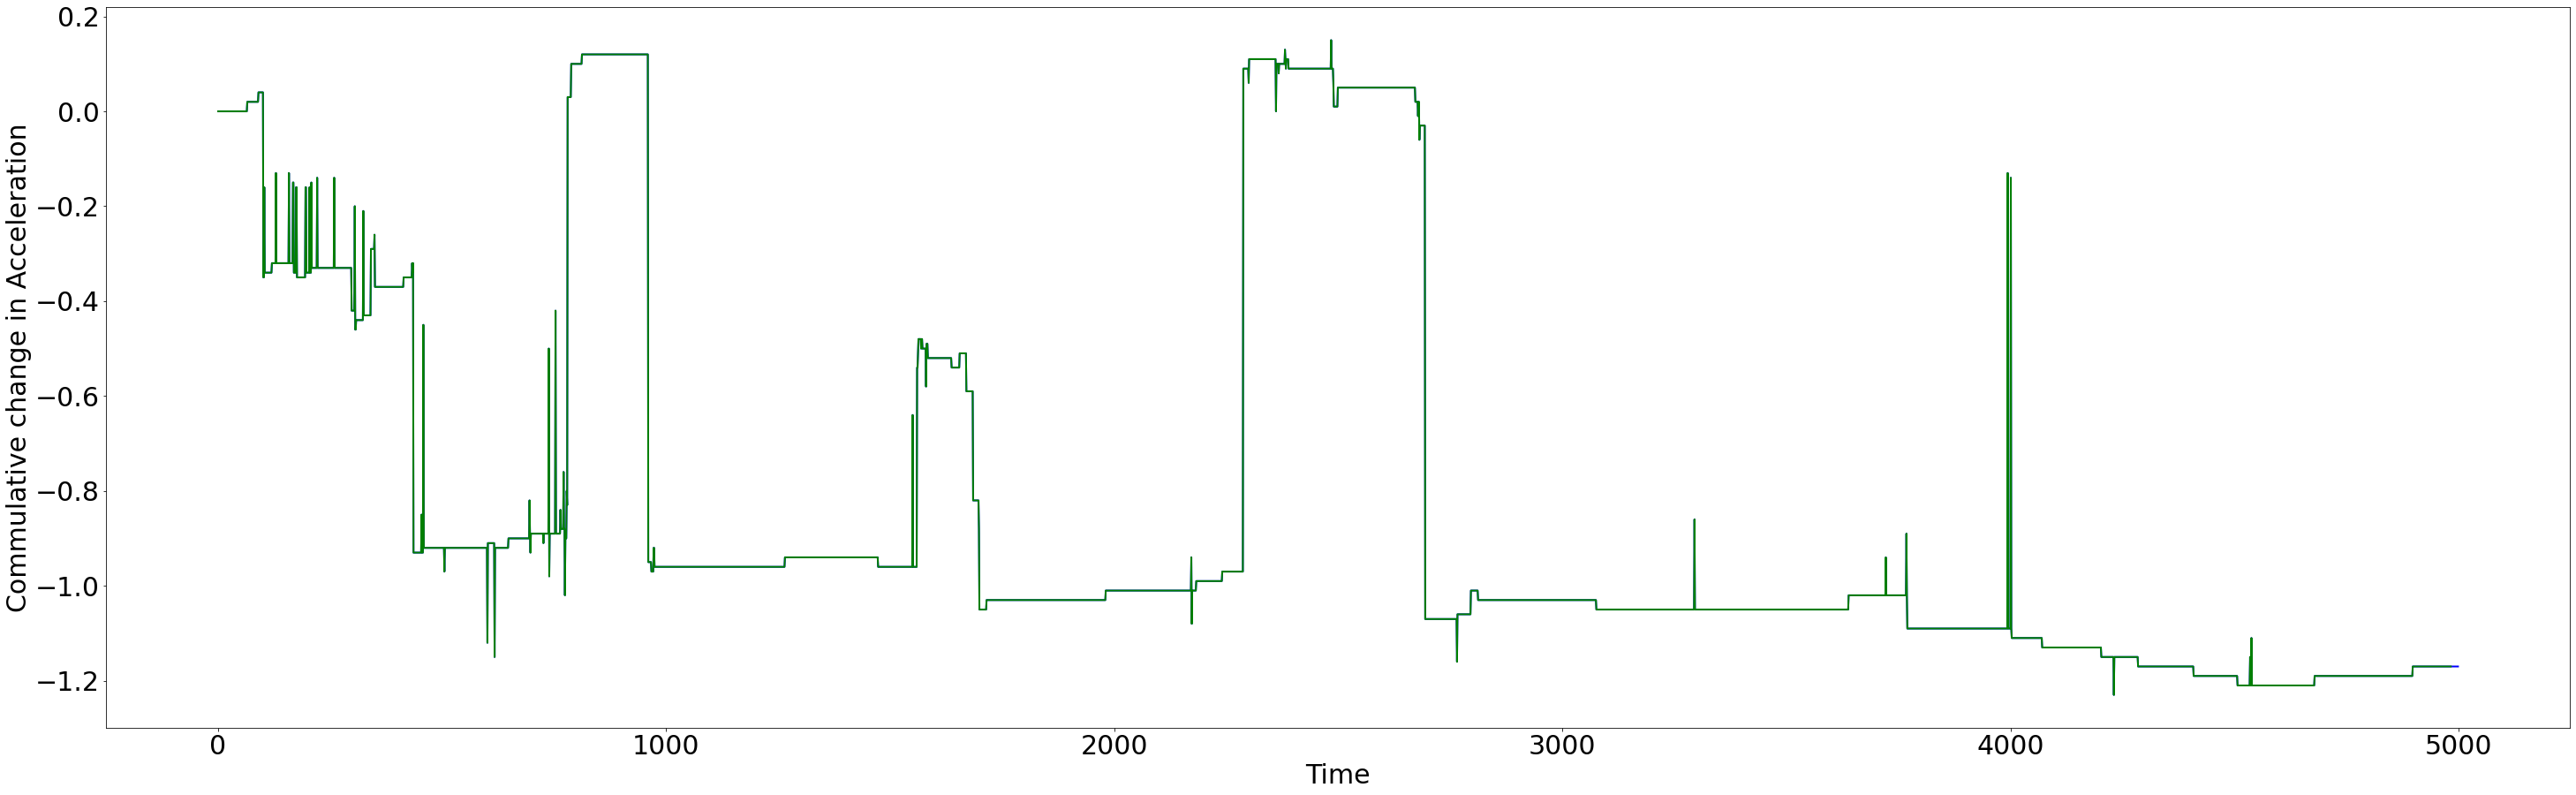

In [ ]:
##plot for Cx
plt.plot(Cx)
plt.plot(history)

plt.xlabel("Time")
plt.ylabel("Commulative change in Acceleration")
plt.show()

In [ ]:
### grid search for cumy
scores = grid_search(Cy, cfg_list, n_test)
print('done')

 > Model[[(0, 0, 0), (0, 0, 0, 0), 'n']] 0.390
 > Model[[(0, 1, 0), (0, 0, 0, 0), 'n']] 0.000
 > Model[[(1, 1, 0), (0, 0, 0, 0), 'n']] 0.000
 > Model[[(1, 0, 0), (0, 0, 0, 0), 'n']] 0.002
 > Model[[(0, 0, 1), (0, 0, 0, 0), 'n']] 0.203
 > Model[[(1, 0, 1), (0, 0, 0, 0), 'n']] 0.002
 > Model[[(0, 1, 1), (0, 0, 0, 0), 'n']] 0.000
 > Model[[(1, 1, 1), (0, 0, 0, 0), 'n']] 0.000
done


In [ ]:
# list top 3 configs
for cfg, error in scores[:3]:
    print(cfg, error)

[(0, 1, 0), (0, 0, 0, 0), 'n'] 0.0
[(0, 1, 1), (0, 0, 0, 0), 'n'] 0.0
[(1, 1, 0), (0, 0, 0, 0), 'n'] 0.0


In [ ]:
cfg = [(1, 0, 1), (0, 0, 0, 0), 'n']

In [ ]:
l=5000
#Cx = df['cumx'].values[:l]
Cy = df['cumy'].values[:l]
#Cz = df['cumz'].values[:l]

In [ ]:
history = walk_forward_validations(Cy, 10, cfg)

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


6, -0.02, 0.0
7, -0.02, 2.7091997310808826e-12
8, -0.02, -0.020009668391439077
9, -0.02, -0.019999999982004336
10, -0.02, -0.019999999976485393
11, -0.02, -0.019999999972232042
12, -0.02, -0.01999999996887439
13, -0.02, -0.019999999966199448
14, -0.02, -0.0199999999638975
15, -0.02, -0.019999999962003884
16, -0.1, -0.019999999960427926
17, -0.02, -0.07002882203420976
18, -0.02, -0.05141012978719674
19, -0.02, -0.04293847865938892
20, -0.02, -0.0380984976860643
21, -0.02, -0.03496712621208884
22, -0.02, -0.025007785617864153
23, -0.02, -0.022656177548663597
24, -0.02, -0.02143148070056224
25, -0.02, -0.02071426490443777
26, -0.02, -0.020273538557688105
27, -0.02, -0.019985415521443717
28, -0.02, -0.019800534330118382
29, -0.02, -0.019681054186497744
30, -0.02, -0.019604556083605704
31, -0.02, -0.019557834646210404
32, -0.02, -0.019530812726125498
33, -0.02, -0.019517883663154812
34, -0.02, -0.01951455321656849
35, -0.02, -0.019517832742842217
36, -0.02, -0.019525368745558564
37, -0.02, 

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


44, -0.02, -0.01962961696331445
45, -0.02, -0.0196431977603219
46, -0.02, -0.01965568269370465
47, -0.02, -0.019667213785135394
48, -0.02, -0.019677997762330212
49, -0.02, -0.019688775335565817
50, -0.02, -0.019699329980081913
51, -0.02, -0.01970853140517406
52, -0.02, -0.0197183050919187
53, -0.02, -0.019728310171410104
54, -0.02, -0.019734323914745697
55, -0.02, -0.0197430982472696
56, -0.02, -0.019752113583731003
57, -0.02, -0.019757717575587645
58, -0.02, -0.019764678827328595
59, -0.02, -0.019771393098091814
60, -0.02, -0.01977387206398383
61, -0.02, -0.019784318849782243
62, -0.02, -0.019791261433288132
63, -0.02, -0.019796814372406882
64, -0.02, -0.019801632022608328
65, -0.02, -0.019804214042485693
66, -0.02, -0.019809212273222042
67, -0.02, -0.019813203225968676
68, -0.02, -0.019818103173877017
69, -0.02, -0.019821824590786376
70, 0.0, -0.019826304322801
71, 0.0, -0.014634866461615898
72, 0.0, -0.01013016157840699
73, 0.0, -0.006631852452676996
74, 0.02, -0.00426685433703223
7

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


80, 0.02, 0.018130430673859395
81, 0.02, 0.018481531860252746
82, 0.02, 0.01868846916716438
83, 0.02, 0.018866190618654875
84, 0.02, 0.018889208091636526
85, 0.02, 0.018939672317250852
86, 0.02, 0.018973820562845585
87, 0.02, 0.018999136646405665
88, 0.02, 0.019018718065287783
89, 0.02, 0.019034736658556827
90, 0.0, 0.01904916875589558
91, 0.0, 0.010801854412876387
92, 0.0, 0.005854624058605214
93, 0.0, 0.0031173279604756305
94, 0.0, 0.0016745858802515246
95, 0.0, 0.0009053728048548391
96, 0.0, 0.000491821225317961
97, 0.0, 0.00026801353208408545
98, 0.0, 0.00014601736630210166
99, 0.0, 7.980081249143328e-05
100, 0.0, 4.357523561870669e-05
101, 0.78, 2.3799311495567428e-05
102, 0.78, 0.47483555136619393
103, 0.32, 0.7635240419203843
104, 0.77, 0.1250969816719477
105, 0.77, 0.741559426193304
106, 0.77, 0.859066675908433
107, 0.77, 0.8703334779172075
108, 0.77, 0.8525077223133415
109, 0.77, 0.8336578672171677
110, 0.77, 0.8196962987257311
111, 0.77, 0.8100367148878701
112, 0.77, 0.803283

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


183, 0.79, 0.7878409824850291
184, 0.79, 0.7891160334577193
185, 0.79, 0.7897406907103143
186, 0.79, 0.7900456133505466
187, 0.79, 0.7901933788557457
188, 0.79, 0.7902639283476748
189, 0.79, 0.7902965733933455
190, 0.79, 0.7903106306482282
191, 0.79, 0.7903156021970537
192, 0.79, 0.7903161383010717
193, 0.79, 0.7903155240048088
194, 0.79, 0.7903136677652464
195, 0.34, 0.7903116482978868
196, 0.34, 0.5538108808655599
197, 0.8, 0.42083720246534895
198, 0.8, 0.6219860830460061
199, 0.8, 0.7102346584996295
200, 0.8, 0.7559755659922758
201, 0.8, 0.7781418326390835
202, 0.8, 0.7887957790062038
203, 0.8, 0.7939672004975624
204, 0.35, 0.7964993428993088
205, 0.81, 0.5637976223417557
206, 0.81, 0.6891643042309727
207, 0.81, 0.7453725202659023
208, 0.36, 0.7756336888946805
209, 0.81, 0.5824127592713482
210, 0.81, 0.6855008489902514
211, 0.81, 0.7392226734914883
212, 0.81, 0.7701730848257234
213, 0.81, 0.7877704657648332
214, 0.81, 0.7977155270496836
215, 0.81, 0.8033289368256191
216, 0.81, 0.806

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


224, 0.81, 0.7437584377807288
225, 0.81, 0.7713009765992502
226, 0.81, 0.7875823706049044
227, 0.81, 0.7971618038457923
228, 0.81, 0.8027874009622256
229, 0.81, 0.8060868385597565
230, 0.81, 0.8080320088081525
231, 0.81, 0.8091646393593438
232, 0.81, 0.8098288151621736
233, 0.81, 0.8102195569502785
234, 0.81, 0.8104433248439679
235, 0.81, 0.8105735661633955
236, 0.81, 0.810647285751794
237, 0.81, 0.8106950786136636
238, 0.81, 0.8107166139066431
239, 0.81, 0.8107279375314254
240, 0.81, 0.8107307091814212
241, 0.81, 0.8107299528103198
242, 0.81, 0.8107271561983899
243, 0.81, 0.8107233985527817
244, 0.81, 0.8107192435033214
245, 0.81, 0.8107149244208749
246, 0.81, 0.8107104609787373
247, 0.81, 0.8107052300262654
248, 0.81, 0.8107000971679248
249, 0.81, 0.8106953671795657
250, 0.81, 0.8106904190718982
251, 0.81, 0.8106721611652715
252, 0.81, 0.8106702798226985
253, 0.81, 0.8106652534315691
254, 0.81, 0.8106602951194827
255, 0.81, 0.8106554097470634
256, 0.81, 0.8106506017757185
257, 0.81, 

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


273, 0.82, 0.8206082360655406
274, 0.82, 0.820713588977525
275, 0.82, 0.8207756048578762
276, 0.82, 0.8208108834627206
277, 0.82, 0.8208300104176625
278, 0.82, 0.8208394708706616
279, 0.82, 0.820843136041246
280, 0.82, 0.8208433188546972
281, 0.82, 0.8208414060149779
282, 0.82, 0.8208382447354989
283, 0.82, 0.8208344170907451
284, 0.82, 0.8208301947424437
285, 0.82, 0.8208257711988514


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


286, 0.82, 0.8208212592361346
287, 0.82, 0.8208166976971308
288, 0.82, 0.8208120757134563
289, 0.82, 0.8208073278381272
290, 0.82, 0.8208023826043136
291, 0.82, 0.8207971890059625
292, 0.82, 0.8207917758040476
293, 0.82, 0.8207862532940444


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


294, 0.82, 0.8207808672437418
295, 0.82, 0.8207786929062031
296, 0.82, 0.8207761029649794
297, 0.82, 0.8207731736896845
298, -0.01, 0.8207700222185191
299, -0.01, 0.48598870670487176
300, -0.01, 0.1990696897889209
301, -0.01, 0.07148690044697928
302, -0.01, 0.02462114588444588
303, -0.01, 0.005327494604808983
304, -0.01, -0.003087401641061852
305, -0.05, -0.006835042631753779
306, -0.01, -0.03030819090858513
307, -0.07, -0.019059117286813247
308, -0.18, -0.04667303951313381
309, -0.18, -0.11920984915045654
310, -0.18, -0.15192780904569705
311, -0.18, -0.16643676031503235
312, -0.18, -0.17286158029003992
313, -0.18, -0.17571351229447874
314, -0.2, -0.17698104961312977
315, -0.2, -0.1885339121722188
316, -0.2, -0.19367264771158815
317, -0.2, -0.1959575089274322
318, -0.2, -0.19697360579352763
319, -0.2, -0.1974257059268442
320, -0.2, -0.19762707857038464
321, -0.2, -0.1977170449731726
322, -0.2, -0.1977576522208814
323, -0.2, -0.19777607682791032
324, -0.17, -0.19778469832966167
325, -0.

553, -0.12, -0.11835611880552599
554, -0.12, -0.11835626251829422
555, -0.12, -0.11835640611107655
556, -0.12, -0.11835654976072027
557, -0.12, -0.11835669334255926
558, -0.12, -0.11835683686356056
559, -0.12, -0.11835698034143696
560, -0.12, -0.11835712381436449
561, -0.12, -0.11835726723236278
562, -0.12, -0.11835741062905884
563, -0.12, -0.11835755398659233
564, -0.12, -0.11835769732070789
565, -0.12, -0.11835784062089946
566, -0.12, -0.11835798384962377
567, -0.12, -0.11835812705435562
568, -0.12, -0.11835827025189671
569, -0.12, -0.11835841338546735
570, -0.12, -0.11835855654579273
571, -0.12, -0.11835869962401672
572, -0.12, -0.11835884267292235
573, -0.12, -0.11835898567869084
574, -0.12, -0.11835912865005976
575, -0.12, -0.11835927165229954
576, -0.12, -0.11835941451811714
577, -0.12, -0.11835955748192127
578, -0.12, -0.11835970026177078
579, -0.12, -0.11835984315638312
580, -0.12, -0.11835998594893153
581, -0.12, -0.11836012861659428
582, -0.12, -0.11836027133623121
583, -0.12

806, 0.47, 0.4637690802924269
807, 0.47, 0.4637768431499283
808, 0.47, 0.46378458658655297
809, 0.47, 0.4637923106854475
810, 0.47, 0.4638000156122428
811, 0.47, 0.463807701542259
812, 0.47, 0.46381536813961416
813, 0.47, 0.4638230162124145
814, 0.47, 0.4638306450721966
815, 0.47, 0.463838255090567
816, 0.47, 0.4638458465034813
817, 0.47, 0.4638534192014034
818, 0.47, 0.46386097318793573
819, 0.47, 0.4638685087042884
820, 0.47, 0.4638760257828376
821, 0.47, 0.46388352426051166
822, 0.47, 0.46389100457523214
823, 0.47, 0.46389846653658207
824, 0.47, 0.46390591031679435
825, 0.47, 0.4639133359506584
826, 0.47, 0.4639207434889148
827, 0.47, 0.46392813296135255
828, 0.47, 0.4639355046375361
829, 0.47, 0.46394285826675463
830, 0.47, 0.46395019422300937
831, 0.47, 0.4639575122469418
832, 0.47, 0.46396481275981444
833, 0.47, 0.4639720955498365
834, 0.47, 0.46397936074763546
835, 0.47, 0.4639866085432104
836, 0.47, 0.4639938388591231
837, 0.47, 0.46400105172848954
838, 0.47, 0.4640082474385451

1067, -0.35, -0.34560328739512103
1068, -0.35, -0.3456056789076197
1069, -0.35, -0.34560806780739195
1070, -0.35, -0.345610454003162
1071, -0.35, -0.34561283770125717
1072, -0.35, -0.34561521882195556
1073, -0.35, -0.3456175972738663
1074, -0.35, -0.3456199732252828
1075, -0.35, -0.3456223465604272
1076, -0.35, -0.34562471731326994
1077, -0.35, -0.34562708542426973
1078, -0.35, -0.34562945110817345
1079, -0.35, -0.34563181410938615
1080, -0.35, -0.3456341746875335
1081, -0.35, -0.34563653256332594
1082, -0.35, -0.34563888799272446
1083, -0.35, -0.34564124080440545
1084, -0.35, -0.345643591109286
1085, -0.35, -0.3456459389279083
1086, -0.35, -0.34564828416631643
1087, -0.35, -0.3456506267903129
1088, -0.35, -0.3456529669899257
1089, -0.35, -0.3456553046651374
1090, -0.35, -0.34565763976360897
1091, -0.35, -0.3456599724335394
1092, -0.35, -0.3456623025251354
1093, -0.35, -0.3456646301432459
1094, -0.35, -0.34566695522980273
1095, -0.35, -0.34566927784822216
1096, -0.35, -0.34567159797770

1313, -0.33, -0.3262907548123962
1314, -0.33, -0.32629235440777715
1315, -0.33, -0.3262939527863063
1316, -0.33, -0.32629554967817437
1317, -0.33, -0.32629714512629165
1318, -0.33, -0.3262987392727455
1319, -0.33, -0.3263003321966397
1320, -0.33, -0.32630192368183153
1321, -0.33, -0.3263035138037166
1322, -0.33, -0.3263051025992295
1323, -0.33, -0.326306689815224
1324, -0.33, -0.3263082758082853
1325, -0.33, -0.32630986072825385
1326, -0.33, -0.32631144394563844
1327, -0.33, -0.32631302629815
1328, -0.33, -0.326314606848469
1329, -0.33, -0.3263161858608008
1330, -0.33, -0.32631776407151436
1331, -0.33, -0.3263193407554092
1332, -0.33, -0.3263209161961481
1333, -0.33, -0.3263224899103369
1334, -0.33, -0.326324062595192
1335, -0.33, -0.32632561572425595
1336, -0.33, -0.32632718506524167
1337, -0.33, -0.3263287530895787
1338, -0.33, -0.3263303197425586
1339, -0.33, -0.326331885063257
1340, -0.33, -0.32633344908249734
1341, -0.33, -0.32633501176267954
1342, -0.33, -0.32633657310689607
1343

1559, -0.32, -0.3167414957013866
1560, 0.61, -0.3167430484974428
1561, 0.61, 0.3584620591008244
1562, 0.64, 0.5523182314765709
1563, 0.64, 0.614770304746026
1564, 0.64, 0.6286945842494797
1565, 0.64, 0.63187702467044
1566, 0.64, 0.6326140749996041
1567, 0.64, 0.6327910995461393
1568, 0.64, 0.6328397150380144
1569, 0.61, 0.6328588644719283
1570, 0.64, 0.6099665333918018
1571, 0.57, 0.6276258076164247
1572, 0.65, 0.5782605105203964
1573, 0.65, 0.6279584405664879
1574, 0.65, 0.6394013972594482


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1575, 0.65, 0.6420413165731678
1576, 0.65, 0.6426567247045174
1577, 0.65, 0.6428064525135251
1578, 0.65, 0.6428490334844817
1579, 0.65, 0.6428669474269629
1580, 0.74, 0.6428791469745995
1581, 0.66, 0.7115583978446206
1582, 0.66, 0.6663563955317807
1583, 0.57, 0.6559453181872581
1584, 0.64, 0.5849066312926863
1585, 0.64, 0.6219152685162389
1586, 0.64, 0.6304589464775223
1587, 0.64, 0.6324405999959479
1588, 0.64, 0.632906043115979
1589, 0.64, 0.6330211274386598
1590, 0.64, 0.6330552414041587
1591, 0.64, 0.6330706208471911
1592, 0.64, 0.6330816492506418
1593, 0.66, 0.6330916517299173
1594, 0.66, 0.6483412942514188
1595, 0.66, 0.6518745654174436
1596, 0.66, 0.652699225504474
1597, 0.66, 0.652897878834666
1598, 0.66, 0.6529518101969574
1599, 0.66, 0.6529722679201788
1600, 0.66, 0.652984965116464
1601, 0.66, 0.6529958427558554
1602, 0.66, 0.6530062813831138
1603, 0.66, 0.6530165846935221
1604, 0.66, 0.6530268475884113
1605, 0.66, 0.6530370666489581
1606, 0.66, 0.6530472510953197
1607, 0.64, 

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1615, 0.64, 0.6333057888942913
1616, 0.64, 0.6333147547731247
1617, 0.64, 0.6333237785009977
1618, 0.64, 0.6333328067524238
1619, 0.64, 0.6333418153771814
1620, 0.64, 0.6333508010352196
1621, 0.64, 0.633359770958055
1622, 0.64, 0.6333686997439169
1623, 0.64, 0.633377613871695
1624, 0.64, 0.6333865035709879
1625, 0.64, 0.633395369280654
1626, 0.64, 0.633404211477104
1627, 0.64, 0.633413029466993
1628, 0.64, 0.633421824261564
1629, 0.64, 0.6334305958853411
1630, 0.64, 0.6334393433288936
1631, 0.64, 0.6334480690670748
1632, 0.64, 0.6334567696230448
1633, 0.64, 0.6334654482449166
1634, 0.64, 0.6334741139218443
1635, 0.64, 0.6334827362502637
1636, 0.64, 0.6334913450682699
1637, 0.64, 0.6334999322631203
1638, 0.64, 0.6335084973832764


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1639, 0.64, 0.6335170384368766
1640, 0.64, 0.6335255580033389
1641, 0.64, 0.6335340541960804
1642, 0.64, 0.6335425530959536
1643, 0.64, 0.6335510012711625
1644, 0.64, 0.6335594113921253
1645, 0.64, 0.6335678197659276
1646, 0.64, 0.6335762097047662
1647, 0.64, 0.6335845705879837
1648, 0.64, 0.6335929128658024
1649, 0.64, 0.6336013678495319
1650, 0.64, 0.6336095331397877
1651, 0.64, 0.6336179443863368
1652, 0.64, 0.6336260674411517
1653, 0.64, 0.6336344352637036
1654, 0.64, 0.6336425339833779
1655, 0.66, 0.6336508410406492
1656, 0.66, 0.6488997310973202
1657, 0.68, 0.6524393442345874
1658, 0.68, 0.6685094893765583
1659, 0.68, 0.6722401669613793
1660, 0.68, 0.6731114138427303
1661, 0.68, 0.6733207430861857
1662, 0.68, 0.6733765211731852
1663, 0.68, 0.6733967434880137
1664, 0.68, 0.6734087077339344
1665, 0.68, 0.6734187378767823
1666, 0.7, 0.6734282990242507
1667, 0.7, 0.6886842600514504
1668, 0.7, 0.6922274236376422
1669, 0.68, 0.6930561203519123
1670, 0.68, 0.6780072170645961
1671, 0.68,

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1713, -0.15, -0.1483823536088805
1714, -0.15, -0.14838246355517715
1715, -0.15, -0.14838257268656538
1716, -0.15, -0.1483826822734946
1717, -0.15, -0.14838279152611092
1718, -0.15, -0.14838290055433875
1719, -0.15, -0.1483830100552687
1720, -0.15, -0.14838311905340615
1721, -0.15, -0.1483832282289744
1722, -0.15, -0.14838334238762357


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1723, -0.15, -0.1483834465630952
1724, -0.15, -0.14838355982899912
1725, -0.15, -0.14838366482090343
1726, -0.15, -0.14838377398369543
1727, -0.15, -0.14838388319772575
1728, -0.15, -0.14838399207765623
1729, -0.15, -0.14838410131169108
1730, -0.15, -0.1483842103881066
1731, -0.15, -0.1483843189597534
1732, -0.15, -0.1483844280999828
1733, -0.15, -0.14838453733383136
1734, -0.15, -0.14838464843925087
1735, -0.15, -0.1483847553657209
1736, -0.15, -0.14838486363882425


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1737, -0.15, -0.14838497274426005
1738, -0.15, -0.1483850814286741
1739, -0.15, -0.14838519184871926
1740, -0.15, -0.14838529930843847
1741, -0.15, -0.14838540812140938
1742, -0.15, -0.14838551870905856
1743, -0.15, -0.14838562554369059
1744, -0.15, -0.14838573489375054
1745, -0.15, -0.1483858434183772
1746, -0.15, -0.14838595194884194
1747, -0.15, -0.14838606049778688
1748, -0.15, -0.14838616940131058
1749, -0.15, -0.14838627781979175
1750, -0.15, -0.1483863866687025
1751, -0.15, -0.14838649533020376
1752, -0.15, -0.14838660355767688
1753, -0.15, -0.1483867125575064
1754, -0.15, -0.14838682112054882
1755, -0.15, -0.14838692980017745
1756, -0.15, -0.14838703822669305
1757, -0.15, -0.14838714694139746
1758, -0.15, -0.14838725542769873
1759, -0.15, -0.14838736372217412
1760, -0.15, -0.1483874730463005
1761, -0.15, -0.1483875805252988
1762, -0.15, -0.14838768929537777
1763, -0.15, -0.14838779739684052
1764, -0.15, -0.14838790612401606
1765, -0.15, -0.14838801434703497
1766, -0.15, -0.1483

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1769, -0.15, -0.1483884475229602
1770, -0.15, -0.14838855582652682
1771, -0.15, -0.1483886644365504
1772, -0.15, -0.14838877282317203
1773, -0.15, -0.14838888115544593
1774, -0.15, -0.14838898886959756
1775, -0.15, -0.1483890972029985
1776, -0.15, -0.14838920526097632
1777, -0.15, -0.1483893135740009
1778, -0.15, -0.14838942187205237
1779, -0.15, -0.14838952987912157
1780, -0.15, -0.1483896379909037
1781, -0.15, -0.14838974739303606
1782, -0.15, -0.1483898541358509
1783, -0.15, -0.14838996223147852
1784, -0.15, -0.14839007039560112
1785, -0.15, -0.14839017825982215
1786, -0.15, -0.14839028642922877
1787, -0.15, -0.1483903943974952
1788, -0.15, -0.14839050226775546
1789, -0.15, -0.14839061039749293
1790, -0.15, -0.1483907190241906
1791, -0.15, -0.14839082595763048
1792, -0.15, -0.14839093400011472
1793, -0.15, -0.14839104192813288
1794, -0.15, -0.14839114980866386
1795, -0.15, -0.14839125755176122
1796, -0.15, -0.1483913654533968
1797, -0.15, -0.1483914731284751
1798, -0.15, -0.14839158

2014, -0.13, -0.12862426219387113
2015, -0.13, -0.128624329674377
2016, -0.13, -0.12862439791634314
2017, -0.13, -0.12862446602175379
2018, -0.13, -0.12862453438584018
2019, -0.13, -0.1286246024962091
2020, -0.13, -0.1286246708049654
2021, -0.13, -0.12862473899440424
2022, -0.13, -0.12862480741749052
2023, -0.13, -0.12862487548293072
2024, -0.13, -0.12862494373351185
2025, -0.13, -0.12862501196659587
2026, -0.13, -0.12862508010203214
2027, -0.11, -0.12862514842091266
2028, -0.13, -0.11309395291050467
2029, -0.13, -0.1252826831301829
2030, -0.13, -0.1279059205492912
2031, -0.13, -0.12847053931928412
2032, -0.13, -0.12859210889099365
2033, -0.13, -0.1286183264904051
2034, -0.13, -0.12862402276074525
2035, -0.13, -0.12862530199113917
2036, -0.13, -0.12862563101124183
2037, -0.13, -0.12862575522338468
2038, -0.13, -0.12862583534703984
2039, -0.13, -0.12862590606759775
2040, -0.13, -0.12862597481247573
2041, -0.13, -0.12862604297585736
2042, -0.13, -0.12862611115688957
2043, -0.13, -0.12862

2258, -0.13, -0.1286373602970026
2259, -0.13, -0.12863742674206993
2260, -0.13, -0.12863749337336575
2261, -0.13, -0.12863755994598042
2262, -0.13, -0.12863762630164885
2263, -0.13, -0.12863769287246132
2264, -0.13, -0.1286377592087622
2265, -0.13, -0.12863782581833896
2266, -0.13, -0.12863789236314446
2267, -0.13, -0.12863795869767963
2268, -0.13, -0.12863802526214826
2269, -0.13, -0.12863804808458418
2270, -0.13, -0.1286381133192408
2271, -0.13, -0.1286381770281819
2272, -0.13, -0.12863824132987758


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2273, -0.13, -0.12863830449960936
2274, -0.13, -0.12863836952873456


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2275, -0.13, -0.12863843465368657
2276, -0.13, -0.12863849605286864
2277, -0.13, -0.1286385595896735
2278, -0.13, -0.12863862542789603
2279, -0.13, -0.12863868597271894


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2280, -0.13, -0.1286387493483158
2281, -0.13, -0.12863881417805575
2282, -0.13, -0.12863887855663225
2283, -0.13, -0.12863894151732666
2284, -0.13, -0.12863900477116863
2285, -0.13, -0.12863906752581128
2286, -0.13, -0.12863912858992615
2287, -0.13, -0.12863919130114906
2288, -0.66, -0.12863925128251938
2289, -0.66, -0.538814954634084
2290, -0.66, -0.630051454561719
2291, -0.66, -0.6484727674431451
2292, -0.66, -0.652307988535366
2293, -0.66, -0.6531171610508029
2294, -0.66, -0.6532932739241195
2295, -0.66, -0.6533367610207056
2296, -0.66, -0.653352440299703
2297, -0.66, -0.6533622752857534
2298, -0.66, -0.653370869258558
2299, -0.66, -0.6533791863646614
2300, -0.59, -0.6533874297317132
2301, -0.63, -0.5985361333642621
2302, -0.63, -0.6183918245906153
2303, -0.63, -0.622559089404437
2304, -0.63, -0.6234390874372377
2305, -0.63, -0.6236293486044484
2306, -0.63, -0.6236748856360788
2307, -0.63, -0.6236900437239876
2308, -0.63, -0.6236988145660995
2309, -0.63, -0.623706232282409
2310, -0.

2528, -0.24, -0.23773246091371203
2529, -0.24, -0.23773278276469484
2530, -0.24, -0.23773310433950948
2531, -0.26, -0.23773342588859409
2532, -0.26, -0.25345868567371127
2533, -0.26, -0.2567050246674099
2534, -0.26, -0.25737534147086455
2535, -0.26, -0.25751401156971837
2536, -0.26, -0.25754295566203106
2537, -0.26, -0.25754925298901166
2538, -0.26, -0.2575508758320342
2539, -0.28, -0.25755153377068263
2540, -0.28, -0.27327792922302213
2541, -0.28, -0.2765245376852731
2542, -0.28, -0.277194978030936
2543, -0.28, -0.27733374979170927
2544, -0.28, -0.27736279351677257
2545, -0.28, -0.27736918994585924
2546, -0.28, -0.27737091201679837
2547, -0.28, -0.2773716691168357
2548, -0.28, -0.2773722267162841
2549, -0.28, -0.27737274351058927
2550, -0.28, -0.2773732513859097
2551, -0.28, -0.27737375697170163
2552, -0.28, -0.27737426230120904
2553, -0.28, -0.27737476749308176
2554, -0.28, -0.27737527219174596
2555, -0.28, -0.27737577687501486
2556, -0.28, -0.2773762812250144
2557, -0.28, -0.2773767

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2562, -0.28, -0.27737922337996507
2563, -0.28, -0.277379721902988
2564, -0.28, -0.27738022361594994
2565, -0.28, -0.2773807254675599
2566, -0.28, -0.2773812225963304
2567, -0.28, -0.27738171894887087
2568, -0.28, -0.2773822199315232
2569, -0.28, -0.2773827182313115
2570, -0.28, -0.2773832135952407
2571, -0.28, -0.2773837162184072
2572, -0.28, -0.2773842107847008
2573, -0.28, -0.27738470812394855
2574, -0.28, -0.27738520154855967
2575, -0.28, -0.277385697875795
2576, -0.28, -0.27738619713650986
2577, -0.28, -0.2773866967250397
2578, -0.28, -0.27738719154015773
2579, -0.28, -0.27738768411766335
2580, -0.28, -0.27738817562880036
2581, -0.28, -0.2773886768909065
2582, -0.28, -0.2773891680828824
2583, -0.28, -0.27738965805973
2584, -0.28, -0.2773901554610204
2585, -0.28, -0.27739064882591824
2586, -0.28, -0.27739113749598104
2587, -0.28, -0.2773916345291275
2588, -0.28, -0.27739212213239917
2589, -0.28, -0.2773926234324125
2590, -0.28, -0.27739310984930127
2591, -0.28, -0.2773936009244522
2

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2642, -0.26, -0.25759773104837774
2643, -0.26, -0.25759788971616177
2644, -0.26, -0.25759825111591156
2645, -0.26, -0.2575987198739475


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2646, -0.26, -0.25759912063044366
2647, -0.26, -0.2575995359779765
2648, -0.24, -0.2575999876932173
2649, -0.24, -0.24187376765450516
2650, -0.24, -0.2386268056512423
2651, -0.24, -0.237956740714913
2652, -0.24, -0.23781865290874923
2653, -0.24, -0.2377903128121881
2654, -0.24, -0.2377849070999024
2655, -0.24, -0.2377840360675341
2656, -0.24, -0.23778414343943685
2657, -0.24, -0.23778461355713745
2658, -0.24, -0.23778489085409527
2659, -0.24, -0.23778533506519575
2660, -0.24, -0.23778570177376193
2661, -0.24, -0.23778594240661238
2662, -0.24, -0.23778640103812343
2663, -0.24, -0.2377868096713566
2664, -0.24, -0.23778709128070105
2665, -0.24, -0.2377874919238295
2666, -0.24, -0.23778781383721
2667, -0.24, -0.237788188861909
2668, -0.24, -0.23778852751351595
2669, -0.24, -0.2377888675446905
2670, -0.24, -0.2377891862938986
2671, -0.24, -0.2377894882383866
2672, -0.26, -0.23778980037121267
2673, -0.36, -0.253516990472018
2674, -0.36, -0.3354287881167271
2675, -0.38, -0.35233974065450624
2

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2699, -0.15, -0.14868548874925577
2700, -0.15, -0.14862349163182245
2701, -0.15, -0.14861086726960354
2702, -0.15, -0.14860826197828184
2703, -0.15, -0.14860780717161276
2704, -0.15, -0.14860791171883497
2705, -0.15, -0.14860799381944462
2706, -0.15, -0.14860814366636527
2707, -0.15, -0.1486082613953358
2708, -0.15, -0.1486083173372749
2709, -0.15, -0.14860843525538253
2710, -0.15, -0.14860858130046894
2711, -0.15, -0.14860871212766663
2712, -0.15, -0.14860882435217662
2713, -0.15, -0.14860888556455398
2714, -0.17, -0.1486090073758471
2715, -0.17, -0.16432961630526646
2716, -0.17, -0.1675789029120337
2717, -0.17, -0.168250508998893
2718, -0.17, -0.1683893932889881
2719, -0.17, -0.1684181791038255
2720, -0.17, -0.16842420568411018
2721, -0.17, -0.16842554136260118
2722, -0.17, -0.1684258916775107
2723, -0.17, -0.16842603876219686
2724, -0.17, -0.16842612569997018
2725, -0.17, -0.1684262087402861
2726, -0.17, -0.16842629513371105
2727, -0.17, -0.1684264129212003
2728, -0.17, -0.168426457

2945, -0.49, -0.485916804239362
2946, -0.49, -0.4859189486735171
2947, -0.49, -0.48592111056284554
2948, -0.49, -0.4859232539873662
2949, -0.49, -0.48592549631933674
2950, -0.49, -0.48592763149042467
2951, -0.49, -0.48592976455695575
2952, -0.49, -0.4859318953223684
2953, -0.49, -0.4859340238013909
2954, -0.49, -0.48593615019597264
2955, -0.49, -0.48593827422177804
2956, -0.49, -0.4859403961584691
2957, -0.49, -0.4859425157825742
2958, -0.49, -0.48594463333452775
2959, -0.49, -0.4859467485770946
2960, -0.49, -0.4859488615830501
2961, -0.49, -0.48595097246103264
2962, -0.49, -0.485953081093099
2963, -0.49, -0.4859551875592262
2964, -0.49, -0.48595729184239655
2965, -0.49, -0.4859593939095575
2966, -0.49, -0.48596149383243065
2967, -0.49, -0.48596359153466046
2968, -0.49, -0.4859656870760166
2969, -0.49, -0.4859677804664218
2970, -0.49, -0.485969871683285
2971, -0.51, -0.4859719607037641
2972, -0.49, -0.5017657186551717
2973, -0.49, -0.4892043933510287
2974, -0.49, -0.4866382291298832
29

3192, -0.47, -0.4665070770576824
3193, -0.47, -0.4665085772641367
3194, -0.47, -0.4665100762092193
3195, -0.47, -0.4665115738573054
3196, -0.47, -0.4665130702125782
3197, -0.47, -0.46651456526661
3198, -0.47, -0.466516059105614
3199, -0.47, -0.4665175516548286
3200, -0.47, -0.4665190428984677
3201, -0.47, -0.4665205327497488
3202, -0.47, -0.46652202146330046
3203, -0.47, -0.46652350891043837
3204, -0.47, -0.4665249950093331
3205, -0.47, -0.4665264798729532
3206, -0.47, -0.4665279635001818
3207, -0.47, -0.4665294458179693
3208, -0.47, -0.4665309269289007
3209, -0.47, -0.46653240663589074
3210, -0.47, -0.4665338851827165
3211, -0.47, -0.4665353624778012
3212, -0.47, -0.46653683846321237
3213, -0.47, -0.46653831324257183
3214, -0.47, -0.4665397867399625
3215, -0.47, -0.46654125892252857
3216, -0.47, -0.46654272991679074
3217, -0.47, -0.4665441996573182
3218, -0.47, -0.4665456681650731
3219, -0.47, -0.46654713540832865
3220, -0.47, -0.4665486014187693
3221, -0.47, -0.466550066136421
3222, 

3438, -0.45, -0.4469421780701068
3439, -0.45, -0.44694327057871674
3440, -0.45, -0.44694436233438156
3441, -0.45, -0.44694545316428536
3442, -0.45, -0.44694654344595386
3443, -0.45, -0.44694763284104466
3444, -0.45, -0.44694872145510234
3445, -0.45, -0.4469498092930419
3446, -0.45, -0.4469508963610519
3447, -0.45, -0.4469519826824015
3448, -0.45, -0.4469530681464663
3449, -0.45, -0.4469541528627084
3450, -0.45, -0.4469552368485825
3451, -0.45, -0.44695631997790064
3452, -0.45, -0.44695740250724836
3453, -0.45, -0.4469584841625606
3454, -0.45, -0.4469595650117323
3455, -0.45, -0.4469606451281264
3456, -0.45, -0.4469617244801146
3457, -0.45, -0.44696280310345377
3458, -0.45, -0.4469638808119411
3459, -0.45, -0.44696495791878965
3460, -0.45, -0.44696603417783215
3461, -0.45, -0.4469671096994062
3462, -0.45, -0.4469681844683013
3463, -0.45, -0.44696925846968133
3464, -0.45, -0.44697033170154293
3465, -0.45, -0.4469714041393304
3466, -0.45, -0.4469724759406023
3467, -0.45, -0.44697354675762

3683, -0.11, -0.10927011817721605
3684, -0.11, -0.10927013277032246
3685, -0.11, -0.10927014736472034
3686, -0.11, -0.10927016193461199
3687, -0.11, -0.10927017654249098
3688, -0.11, -0.10927019112895717
3689, -0.11, -0.10927020569689462
3690, -0.11, -0.10927022030219699
3691, -0.11, -0.10927023485571799
3692, -0.11, -0.10927024944877785
3693, -0.11, -0.10927026404105313
3694, -0.11, -0.10927027861624457
3695, -0.11, -0.10927029321800154
3696, -0.11, -0.10927030781175219
3697, -0.11, -0.10927032237081652
3698, -0.11, -0.109270336925706
3699, -0.11, -0.10927035153360666
3700, -0.11, -0.1092703661276203
3701, -0.11, -0.10927038070191711
3702, -0.11, -0.10927039529265335
3703, -0.11, -0.10927040987262296
3704, -0.11, -0.10927042444880655
3705, -0.11, -0.1092704390180658
3706, -0.11, -0.10927045360861151
3707, -0.11, -0.1092704681789625
3708, -0.11, -0.10927048272094732
3709, -0.11, -0.1092704973196913
3710, -0.11, -0.10927051190856571
3711, -0.11, -0.10927052643815223
3712, -0.11, -0.1092

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3906, -0.01, -0.009933343772713736
3907, -0.01, -0.009933343782541038
3908, -0.01, -0.009933343792862932
3909, -0.01, -0.009933343803364145


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3910, -0.01, -0.009933343809793273
3911, -0.01, -0.009933343824370345
3912, -0.01, -0.009933343837273578
3913, -0.01, -0.009933343847515118
3914, -0.01, -0.009933343853507375
3915, -0.01, -0.00993334386527858
3916, -0.01, -0.009933343874187347
3917, -0.01, -0.009933343885311552
3918, -0.01, -0.009933343895414682
3919, -0.01, -0.009933343906102728
3920, -0.01, -0.009933343916778749


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3921, -0.01, -0.009933343925674715
3922, -0.01, -0.00993334394078601
3923, -0.01, -0.009933343947981364
3924, -0.01, -0.009933343956916394
3925, -0.01, -0.009933343974789623
3926, -0.01, -0.009933343981093575
3927, -0.01, -0.009933343992469786
3928, -0.01, -0.00993334399896376
3929, -0.01, -0.009933344013219884
3930, -0.01, -0.00993334402213685
3931, -0.01, -0.00993334402997363
3932, -0.01, -0.009933344041239611


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3933, -0.01, -0.009933344051035917
3934, -0.01, -0.009933344061878884
3935, -0.01, -0.009933344074464718
3936, -0.01, -0.009933344085539727
3937, -0.01, -0.009933344093027732
3938, -0.01, -0.00993334410423092
3939, -0.01, -0.009933344115961399
3940, -0.01, -0.009933344128717587
3941, -0.01, -0.009933344134532078
3942, -0.01, -0.009933344144312453
3943, -0.01, -0.009933344154688752
3944, -0.01, -0.009933344164620663
3945, -0.01, -0.009933344174310719
3946, -0.01, -0.009933344186980213
3947, -0.01, -0.009933344195100217
3948, -0.01, -0.009933344211340801


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3949, -0.01, -0.009933344215395025
3950, -0.01, -0.009933344228805648
3951, -0.01, -0.009933344239380238


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3952, -0.01, -0.009933344248686018


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3953, -0.01, -0.00993334425854089
3954, -0.01, -0.009933344269464472
3955, -0.01, -0.009933344277920307
3956, -0.01, -0.00993334429087047
3957, -0.01, -0.009933344305844624
3958, -0.01, -0.009933344311286408
3959, -0.01, -0.00993334432012378
3960, -0.01, -0.009933344335147379
3961, -0.01, -0.009933344342252251
3962, -0.01, -0.009933344352650931
3963, -0.01, -0.009933344360085044
3964, -0.01, -0.009933344372378803
3965, -0.01, -0.009933344383919298
3966, -0.01, -0.009933344395950987
3967, -0.01, -0.00993334440335096
3968, -0.01, -0.009933344415147356
3969, -0.01, -0.009933344423261162
3970, -0.01, -0.009933344435898803
3971, -0.01, -0.009933344448584758
3972, -0.01, -0.00993334446015881
3973, -0.01, -0.009933344468510111


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3974, -0.01, -0.009933344479230978
3975, -0.01, -0.009933344487764279
3976, -0.01, -0.009933344499783794
3977, -0.01, -0.00993334451519194
3978, -0.01, -0.009933344519926238
3979, -0.01, -0.009933344530760332
3980, -0.01, -0.009933344540705968
3981, -0.01, -0.009933344549565936
3982, -0.01, -0.009933344561612222
3983, -0.01, -0.009933344570974315
3984, -0.01, -0.00993334458090715
3985, -0.01, -0.009933344592418349
3986, -0.01, -0.00993334460469552
3987, -0.01, -0.009933344615441705
3988, -0.01, -0.009933344623194632
3989, -0.01, -0.009933344635571044
3990, -0.01, -0.009933344648977509
3991, -0.01, -0.009933344656957752
3992, -0.01, -0.009933344667135247
3993, -0.01, -0.009933344675387173
3994, -0.09, -0.009933344684249874
3995, -0.01, -0.07276417435077473
3996, -0.01, -0.02311247862467409
3997, -0.01, -0.012698120852516877
3998, -0.01, -0.010513421439061083
3999, -0.01, -0.010055039335265862
4000, -0.01, -0.009958858037714458
4001, -0.09, -0.009938676395018312
4002, -0.01, -0.072726504

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4010, -0.01, -0.009933529985078729
4011, -0.01, -0.0099333403109373
4012, -0.01, -0.009933300421616682
4013, -0.01, -0.009933292046365207
4014, -0.01, -0.00993329028983165


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4015, -0.01, -0.009933289930489414
4016, -0.01, -0.009933289867342007
4017, -0.01, -0.009933289861967377
4018, -0.01, -0.009933289867486633
4019, -0.01, -0.009933289874910043


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4020, -0.01, -0.009933289885196515
4021, -0.01, -0.009933289897262805
4022, -0.01, -0.009933289908504686
4023, -0.01, -0.00993328991469384
4024, -0.01, -0.009933289925266492
4025, -0.01, -0.009933289937094088
4026, 0.01, -0.009933289948413672
4027, -0.01, 0.0057550747311330835
4028, -0.01, -0.006633404747307933
4029, -0.01, -0.009239185913505792
4030, -0.01, -0.009787288414704014
4031, -0.01, -0.009902578036622454


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4032, -0.01, -0.009926828523827641
4033, -0.01, -0.009931929480661822
4034, -0.01, -0.009933002446982543
4035, -0.01, -0.009933228148165149
4036, -0.01, -0.009933275629099621
4037, -0.01, -0.009933285626459794
4038, -0.01, -0.009933287735128152
4039, -0.01, -0.009933288189063309
4040, -0.01, -0.009933288291915901
4041, -0.01, -0.009933288326936362


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4042, -0.01, -0.009933288336689073
4043, -0.01, -0.009933288349602536
4044, -0.01, -0.00993328835871535
4045, -0.01, -0.009933288373647634
4046, -0.01, -0.009933288378057289
4047, -0.01, -0.009933288396029217
4048, -0.01, -0.009933288401070705
4049, -0.01, -0.009933288418584055
4050, -0.01, -0.009933288422054763
4051, -0.01, -0.009933288432668547
4052, -0.01, -0.009933288447268972
4053, -0.01, -0.009933288456079822
4054, -0.01, -0.009933288464391335
4055, -0.01, -0.009933288481591066
4056, -0.01, -0.00993328848613615
4057, -0.01, -0.009933288497030185
4058, -0.01, -0.009933288507948822
4059, -0.01, -0.009933288519051153
4060, -0.01, -0.009933288527873783
4061, -0.01, -0.009933288537863377
4062, -0.01, -0.009933288547866397
4063, -0.01, -0.009933288558321507
4064, -0.01, -0.00993328857025207
4065, -0.01, -0.009933288579606531
4066, -0.01, -0.009933288593034073
4067, -0.01, -0.009933288607265701
4068, -0.01, -0.009933288613899156
4069, -0.01, -0.009933288625944107
4070, -0.01, -0.0099332

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4085, -0.01, -0.00993328879526532
4086, -0.01, -0.00993328880329063
4087, -0.01, -0.009933288813406157
4088, -0.01, -0.00993328882342067


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4089, -0.01, -0.009933288835894505
4090, -0.01, -0.00993328884746514
4091, -0.01, -0.009933288858064866
4092, -0.01, -0.009933288875509084
4093, -0.01, -0.009933288884427537
4094, 0.01, -0.00993328888903553
4095, 0.01, 0.005754453123063268
4096, 0.01, 0.009054368231250578
4097, 0.01, 0.009748420255577773
4098, 0.01, 0.009894401828612032
4099, 0.01, 0.009925106788303181
4100, 0.01, 0.009931565110090136
4101, 0.01, 0.009932923529042861


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4102, 0.01, 0.009933209258235109
4103, 0.01, 0.009933269364556659
4104, 0.01, 0.009933282016554986
4105, 0.01, 0.009933284685764722
4106, 0.01, 0.00993328525631221
4107, 0.01, 0.009933285386409797
4108, 0.01, 0.009933285420051438
4109, 0.01, 0.009933285436737604


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4110, 0.01, 0.00993328544529761
4111, 0.01, 0.009933285467855902
4112, 0.01, 0.009933285473622632
4113, 0.01, 0.00993328548106771
4114, 0.01, 0.009933285491193782
4115, 0.01, 0.009933285501472038
4116, 0.01, 0.009933285515911725
4117, 0.01, 0.009933285522565736
4118, 0.01, 0.009933285533682288
4119, 0.01, 0.009933285553491733
4120, 0.01, 0.009933285555143247
4121, 0.01, 0.009933285568537323
4122, 0.01, 0.009933285577293817
4123, 0.01, 0.009933285589587316
4124, 0.01, 0.00993328560082967
4125, 0.01, 0.00993328561022226
4126, 0.01, 0.009933285619962911
4127, 0.01, 0.009933285636132844
4128, 0.01, 0.009933285642011406
4129, 0.01, 0.009933285651834635
4130, 0.01, 0.009933285664877103
4131, 0.01, 0.009933285672530531
4132, 0.01, 0.009933285685262513
4133, 0.01, 0.009933285696361045
4134, 0.01, 0.009933285713264621
4135, 0.01, 0.009933285719663548


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4136, 0.01, 0.009933285730471825
4137, 0.01, 0.009933285739982272
4138, 0.01, 0.009933285751848415
4139, 0.01, 0.009933285760384302
4140, 0.01, 0.009933285781595908
4141, 0.01, 0.009933285782751005
4142, 0.01, 0.009933285793751872
4143, 0.01, 0.009933285803826245
4144, 0.01, 0.009933285812826992
4145, 0.01, 0.009933285826210307
4146, 0.01, 0.009933285844408146
4147, 0.01, 0.009933285848442957
4148, 0.01, 0.009933285858534964
4149, 0.01, 0.00993328587007651


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4150, 0.01, 0.009933285880437666
4151, 0.01, 0.009933285898414457
4152, 0.01, 0.00993328590315049
4153, 0.01, 0.009933285912524476
4154, 0.01, 0.009933285922581456
4155, 0.01, 0.009933285932412664
4156, 0.01, 0.009933285952920867
4157, 0.01, 0.009933285956649027
4158, 0.01, 0.009933285967188638
4159, 0.01, 0.00993328597908058
4160, 0.01, 0.009933285989935335
4161, 0.01, 0.009933286000615915
4162, 0.01, 0.009933286011638603
4163, 0.01, 0.009933286021338361
4164, 0.01, 0.009933286031139988
4165, 0.01, 0.009933286042005449
4166, 0.01, 0.009933286054723491
4167, 0.01, 0.009933286074648181
4168, 0.01, 0.0099332860756638
4169, 0.01, 0.009933286095080889
4170, 0.01, 0.009933286098497125
4171, 0.01, 0.009933286108790093
4172, 0.01, 0.009933286119865745
4173, 0.01, 0.00993328613128144
4174, 0.01, 0.009933286148230809
4175, 0.01, 0.009933286153185625
4176, 0.01, 0.009933286164462367
4177, 0.01, 0.00993328617458753
4178, 0.01, 0.009933286186024445
4179, 0.01, 0.009933286195827111
4180, 0.01, 0.00

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4186, 0.01, 0.009933286275047998
4187, 0.01, 0.009933286286405031
4188, 0.01, 0.009933286295822534
4189, 0.01, 0.009933286314966077
4190, 0.01, 0.009933286319517709
4191, 0.01, 0.00993328632829491
4192, 0.01, 0.009933286347104612
4193, 0.01, 0.00993328635087797
4194, 0.01, 0.009933286368273928
4195, 0.01, 0.009933286372982882


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4196, 0.01, 0.009933286384881172
4197, 0.01, 0.009933286395123376
4198, 0.01, 0.00993328640768684
4199, 0.01, 0.009933286415276622
4200, 0.01, 0.009933286426997395
4201, 0.01, 0.009933286439058026
4202, 0.01, 0.009933286451040935
4203, 0.01, 0.009933286460472342
4204, 0.01, 0.009933286481177408


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4205, 0.01, 0.009933286485331965
4206, 0.01, 0.009933286493794378
4207, 0.01, 0.009933286505306097
4208, 0.01, 0.009933286515791381


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4209, 0.01, 0.009933286526419487
4210, 0.01, 0.009933286537879681
4211, 0.01, 0.009933286550332312
4212, 0.01, 0.009933286559097837


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4213, 0.01, 0.009933286572622256
4214, 0.01, 0.009933286581106095
4215, 0.01, 0.009933286593515672
4216, 0.01, 0.009933286604419512
4217, 0.01, 0.00993328661717768
4218, 0.01, 0.00993328662723799
4219, 0.01, 0.009933286645570558
4220, 0.01, 0.009933286649314381
4221, 0.01, 0.009933286660454609
4222, 0.01, 0.00993328667153618
4223, 0.01, 0.009933286689197685
4224, 0.01, 0.009933286691009666
4225, 0.01, 0.009933286705979583
4226, 0.01, 0.009933286714826588
4227, 0.01, 0.009933286727640211
4228, 0.01, 0.009933286737492157


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4229, 0.01, 0.00993328674927177
4230, 0.01, 0.009933286760446311
4231, 0.03, 0.009933286777927614
4232, 0.01, 0.02562120082704879
4233, 0.01, 0.013233426063515387
4234, 0.01, 0.010627515480590495
4235, 0.01, 0.010079327536800922
4236, 0.01, 0.009964007595669873
4237, 0.01, 0.009939748131966708
4238, 0.01, 0.009934644755956687
4239, 0.01, 0.00993357118474229
4240, 0.01, 0.00993334534953165
4241, 0.01, 0.009933297850767967
4242, 0.01, 0.009933287867228989
4243, 0.01, 0.009933285776830433
4244, 0.01, 0.009933285343874387
4245, 0.01, 0.00993328526188999
4246, 0.01, 0.009933285254158444
4247, 0.01, 0.009933285261071954
4248, 0.01, 0.009933285269310001
4249, 0.01, 0.009933285282397286
4250, 0.01, 0.009933285292389108
4251, 0.01, 0.009933285311877193
4252, 0.01, 0.009933285315214285
4253, 0.01, 0.009933285326650726
4254, 0.01, 0.009933285337666575
4255, 0.01, 0.00993328534999194
4256, 0.01, 0.009933285361017122
4257, 0.01, 0.009933285371374785
4258, 0.01, 0.0099332853830941
4259, 0.01, 0.0099

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4269, 0.01, 0.009933285506119514
4270, 0.01, 0.00993328551946775
4271, 0.01, 0.009933285528416495
4272, 0.01, 0.009933285539656878
4273, 0.01, 0.009933285551687786
4274, 0.01, 0.009933285564436617
4275, 0.01, 0.009933285574154415
4276, 0.01, 0.009933285584361696
4277, 0.01, 0.009933285598389217
4278, 0.01, 0.009933285617105003
4279, 0.01, 0.009933285619299839
4280, 0.01, 0.009933285630593605
4281, 0.01, 0.0099332856407673
4282, 0.01, 0.009933285659681112
4283, 0.01, 0.009933285663452246
4284, 0.01, 0.009933285677365363
4285, 0.01, 0.009933285687718053
4286, 0.01, 0.009933285696622822
4287, 0.01, 0.009933285709597754
4288, 0.01, 0.009933285728135562
4289, 0.01, 0.009933285732202252
4290, 0.01, 0.009933285743991748
4291, 0.01, 0.009933285755312026
4292, 0.01, 0.009933285765324
4293, 0.01, 0.009933285778274162
4294, 0.01, 0.00993328579007188
4295, 0.01, 0.009933285800475351
4296, 0.01, 0.009933285811405389
4297, 0.01, 0.009933285825022684
4298, 0.01, 0.009933285833665803
4299, 0.01, 0.009

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4307, 0.01, 0.009933285937280165
4308, 0.01, 0.009933285947669759
4309, 0.01, 0.009933285958326649
4310, 0.01, 0.009933285971107823
4311, 0.01, 0.009933285980845816
4312, 0.01, 0.009933286000345664
4313, 0.01, 0.009933286003944473
4314, 0.01, 0.009933286014990739
4315, 0.01, 0.009933286026777559
4316, 0.01, 0.00993328604491162
4317, 0.01, 0.009933286056839916
4318, 0.01, 0.009933286061031055
4319, 0.01, 0.00993328607334165
4320, 0.01, 0.009933286086017245
4321, 0.01, 0.009933286095618443
4322, 0.01, 0.009933286107154948
4323, 0.01, 0.009933286119203535
4324, 0.01, 0.009933286128817337
4325, 0.01, 0.0099332861403345
4326, 0.01, 0.009933286152121374
4327, 0.01, 0.009933286161885069
4328, 0.01, 0.00993328617546897
4329, 0.01, 0.00993328618721697
4330, 0.01, 0.009933286206264871
4331, 0.01, 0.009933286209313812
4332, 0.01, 0.009933286223394592


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4333, 0.01, 0.009933286231711972
4334, 0.01, 0.009933286242658577
4335, 0.01, 0.00993328626407639
4336, 0.01, 0.009933286267815783
4337, 0.01, 0.009933286278645193
4338, 0.01, 0.009933286297420523
4339, 0.01, 0.009933286309261095
4340, 0.01, 0.009933286312809953
4341, 0.01, 0.009933286323330284
4342, 0.01, 0.009933286335620318
4343, 0.01, 0.009933286347190389
4344, 0.01, 0.009933286358137288


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4345, 0.01, 0.009933286370578496
4346, 0.01, 0.009933286389116138
4347, 0.01, 0.009933286390983228
4348, 0.01, 0.009933286405537861
4349, 0.01, 0.009933286415699096
4350, 0.01, 0.009933286427614213
4351, 0.01, 0.00993328643893026


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4352, 0.01, 0.009933286449530466
4353, 0.01, 0.009933286461585493
4354, 0.01, 0.009933286473356569
4355, 0.01, 0.009933286485496478
4356, 0.01, 0.009933286496275855
4357, 0.01, 0.009933286508971297
4358, 0.01, 0.009933286525750432
4359, 0.01, 0.009933286530982912
4360, 0.01, 0.0099332865424666
4361, 0.01, 0.009933286553234496
4362, 0.01, 0.009933286565326896
4363, 0.01, 0.009933286576891359
4364, 0.01, 0.009933286586907225
4365, 0.01, 0.009933286600544483
4366, 0.01, 0.009933286611883035
4367, 0.01, 0.00993328662297252
4368, 0.01, 0.009933286635408661
4369, 0.01, 0.00993328664655256
4370, 0.01, 0.009933286657726526
4371, 0.01, 0.009933286670270318
4372, 0.01, 0.00993328668187484
4373, 0.01, 0.00993328669266011
4374, 0.01, 0.00993328670382408
4375, 0.01, 0.009933286716373784
4376, 0.01, 0.00993328672622133
4377, 0.01, 0.009933286737156053
4378, 0.01, 0.009933286750278289
4379, 0.01, 0.009933286762256487
4380, 0.01, 0.009933286772135863
4381, 0.01, 0.009933286784531939
4382, 0.01, 0.0099

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4383, 0.01, 0.009933286808186358


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4384, 0.01, 0.009933286820442404
4385, 0.01, 0.009933286830597536
4386, 0.01, 0.009933286842157992
4387, 0.01, 0.00993328685455683
4388, 0.01, 0.00993328687326397
4389, 0.01, 0.009933286877133903
4390, 0.01, 0.00993328688803407
4391, 0.01, 0.009933286907318931
4392, 0.01, 0.009933286912643413
4393, 0.01, 0.009933286924624687
4394, 0.01, 0.009933286935972709
4395, 0.01, 0.009933286946017965
4396, 0.01, 0.00993328695809543
4397, 0.01, 0.00993328696958723
4398, 0.01, 0.009933286981034342
4399, 0.01, 0.00993328700181142
4400, 0.01, 0.009933287003400364
4401, 0.01, 0.009933287016173875
4402, 0.01, 0.009933287035014808
4403, 0.01, 0.00993328704699209
4404, 0.01, 0.009933287050465952
4405, 0.01, 0.009933287062164689
4406, 0.01, 0.009933287074893812
4407, 0.01, 0.009933287084594514
4408, 0.01, 0.009933287098594888


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4409, 0.01, 0.009933287107808867
4410, 0.01, 0.009933287120606493
4411, 0.01, 0.009933287132169406


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4412, 0.01, 0.009933287144664672
4413, 0.01, 0.009933287154496094
4414, 0.01, 0.009933287168534163
4415, 0.01, 0.0099332871866039
4416, 0.01, 0.0099332871898226


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4417, 0.01, 0.00993328720166878
4418, 0.01, 0.009933287212046244


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4419, 0.01, 0.009933287226777403
4420, 0.01, 0.009933287236709661
4421, 0.01, 0.009933287249450376
4422, 0.01, 0.009933287259191417
4423, 0.01, 0.00993328727325592


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4424, 0.01, 0.009933287284460352
4425, 0.01, 0.009933287296891375
4426, 0.01, 0.009933287307245227
4427, 0.01, 0.009933287318123806
4428, 0.01, 0.009933287330509473
4429, 0.01, 0.009933287342159073
4430, 0.01, 0.009933287353038757
4431, 0.01, 0.009933287366077653
4432, 0.01, 0.00993328737697655
4433, 0.01, 0.009933287390141607
4434, 0.01, 0.009933287400189885
4435, 0.01, 0.009933287413049666
4436, 0.01, 0.009933287430841209
4437, 0.01, 0.009933287435602225
4438, 0.01, 0.00993328744793999
4439, 0.01, 0.009933287460161245


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4440, 0.01, 0.009933287470813717
4441, 0.01, 0.009933287490708752
4442, 0.01, 0.009933287494826875
4443, 0.01, 0.00993328750562338
4444, 0.01, 0.009933287518051774
4445, 0.01, 0.009933287529955547
4446, 0.01, 0.009933287541426373
4447, 0.01, 0.00993328755319294


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4448, 0.01, 0.009933287564961646
4449, 0.01, 0.009933287575393114
4450, 0.01, 0.00993328758782493
4451, 0.01, 0.009933287598837501


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4452, 0.01, 0.00993328761197853
4453, 0.01, 0.009933287631107075
4454, 0.01, 0.009933287633892255
4455, 0.01, 0.00993328764618771
4456, 0.01, 0.009933287656907491
4457, 0.01, 0.009933287669787804
4458, 0.01, 0.0099332876817447
4459, 0.01, 0.00993328769370977


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4460, 0.01, 0.009933287705110296
4461, 0.01, 0.00993328771761834
4462, 0.01, 0.00993328772926576
4463, 0.01, 0.009933287741563846
4464, 0.01, 0.00993328775225621
4465, 0.01, 0.009933287764624505
4466, 0.01, 0.009933287775003257
4467, 0.01, 0.009933287786677332


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4468, 0.01, 0.009933287799097064
4469, 0.01, 0.009933287810972422
4470, 0.01, 0.009933287822986348
4471, 0.01, 0.009933287834840812
4472, 0.01, 0.009933287846195883
4473, 0.01, 0.00993328785803642
4474, 0.01, 0.009933287870193578
4475, 0.01, 0.00993328788159318
4476, 0.01, 0.009933287893396472
4477, 0.01, 0.00993328790744545
4478, 0.01, 0.009933287916771446
4479, 0.01, 0.009933287928722914
4480, 0.01, 0.009933287940239791
4481, 0.01, 0.009933287952756274
4482, 0.01, 0.009933287963915927
4483, 0.01, 0.009933287975090037


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4484, 0.01, 0.009933287987913783
4485, 0.01, 0.00993328800611715
4486, 0.01, 0.009933288009387479
4487, 0.01, 0.009933288029822167
4488, 0.01, 0.009933288034710485
4489, 0.01, 0.009933288053312632
4490, 0.01, 0.009933288057696079
4491, 0.01, 0.009933288069475032
4492, 0.01, 0.009933288081527703
4493, 0.01, 0.009933288094313026
4494, 0.01, 0.009933288105020716
4495, 0.01, 0.009933288117895688
4496, 0.01, 0.009933288130638943
4497, 0.01, 0.009933288150002073
4498, 0.01, 0.009933288152102813
4499, 0.01, 0.009933288165033943
4500, 0.01, 0.009933288177011671
4501, 0.01, 0.009933288195413236
4502, 0.01, 0.00993328820691864
4503, 0.01, 0.0099332882191624


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4504, 0.01, 0.009933288223725424
4505, 0.01, 0.009933288235729913
4506, 0.01, 0.00993328824777739
4507, 0.01, 0.0099332882592427
4508, 0.01, 0.009933288279447066
4509, 0.01, 0.009933288282467973
4510, 0.01, 0.009933288294783398
4511, 0.01, 0.009933288305900723
4512, 0.01, 0.009933288317440196
4513, 0.01, 0.009933288330785332
4514, 0.01, 0.009933288349069322
4515, 0.01, 0.009933288353721153
4516, 0.01, 0.009933288365160393


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4517, 0.01, 0.009933288377578847
4518, 0.01, 0.009933288389092923
4519, 0.01, 0.009933288401350085
4520, 0.01, 0.009933288413397592
4521, 0.01, 0.009933288425366286
4522, 0.01, 0.009933288438271034
4523, 0.01, 0.009933288448888621
4524, 0.01, 0.00993328846028703
4525, 0.01, 0.00993328847905641
4526, 0.01, 0.0099332884843363
4527, 0.01, 0.009933288496596545
4528, 0.01, 0.009933288507752632
4529, 0.01, 0.009933288520952063
4530, 0.01, 0.009933288531296946
4531, 0.01, 0.009933288543804144
4532, 0.01, 0.009933288555949436
4533, 0.01, 0.00993328856684639
4534, 0.01, 0.009933288579494909


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4535, -0.02, 0.009933288591283115
4536, 0.02, -0.01359757258038588
4537, 0.02, 0.012823659312534513
4538, -0.04, 0.018384440657771034
4539, 0.01, -0.027497046697028966
4540, 0.01, 0.00204655089796329
4541, 0.01, 0.008271242037987818


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4542, 0.01, 0.009583006719028947
4543, 0.01, 0.009859455997176051
4544, 0.01, 0.009917717834131938
4545, 0.01, 0.009929996589908691
4546, 0.01, 0.009932584361414379
4547, 0.01, 0.00993312975325701
4548, 0.01, 0.009933244696609604
4549, 0.01, 0.009933268932276784
4550, 0.01, 0.009933274049128119
4551, 0.01, 0.009933275144148273
4552, 0.01, 0.009933275376232563
4553, 0.01, 0.009933275435330546
4554, 0.01, 0.009933275464593803
4555, 0.01, 0.009933275470879218
4556, 0.01, 0.00993327548444616
4557, 0.01, 0.009933275496199736


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4558, 0.01, 0.009933275507912651
4559, 0.01, 0.00993327552000013


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4560, 0.01, 0.009933275532392689
4561, 0.01, 0.009933275544315083
4562, 0.01, 0.009933275555336876


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4563, 0.01, 0.009933275567466692
4564, 0.01, 0.009933275580142086
4565, 0.01, 0.009933275591667581
4566, 0.01, 0.00993327560244031


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4567, 0.01, 0.00993327561466607
4568, 0.01, 0.009933275627127647
4569, 0.01, 0.009933275639274463
4570, 0.01, 0.009933275651758701
4571, 0.01, 0.009933275663532743
4572, 0.01, 0.00993327568219301
4573, 0.01, 0.009933275694014677
4574, 0.01, 0.00993327569775103
4575, 0.01, 0.00993327571152756
4576, 0.01, 0.009933275723297798
4577, 0.01, 0.009933275734862879
4578, 0.01, 0.009933275747421637
4579, 0.01, 0.009933275758132085
4580, 0.01, 0.009933275772089458
4581, 0.01, 0.009933275781760818
4582, 0.01, 0.00993327579468557
4583, 0.01, 0.009933275813519162
4584, 0.01, 0.009933275819847744
4585, 0.01, 0.009933275838610072
4586, 0.01, 0.009933275842850366
4587, 0.01, 0.009933275853518114
4588, 0.01, 0.009933275866578812
4589, 0.01, 0.00993327587776256
4590, 0.01, 0.009933275891036056
4591, 0.01, 0.009933275903006099
4592, 0.01, 0.009933275913545314
4593, 0.01, 0.009933275927167253
4594, 0.01, 0.009933275945458585
4595, 0.01, 0.009933275949328585
4596, 0.01, 0.009933275962355931
4597, 0.01, 0.00

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4617, 0.01, 0.009933276214687013
4618, 0.01, 0.009933276227499972
4619, 0.01, 0.009933276238744454
4620, 0.01, 0.009933276249884266
4621, 0.01, 0.00993327626288719
4622, 0.01, 0.009933276274349796
4623, 0.01, 0.009933276287021684
4624, 0.01, 0.00993327630562604
4625, 0.01, 0.009933276310455147
4626, 0.01, 0.009933276323042273
4627, 0.01, 0.009933276335105469
4628, 0.01, 0.00993327634688431
4629, 0.01, 0.00993327636573102


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4630, 0.01, 0.009933276371625095
4631, 0.01, 0.009933276383337021
4632, 0.01, 0.009933276394700404
4633, 0.01, 0.009933276406563612
4634, 0.01, 0.009933276419661921
4635, 0.01, 0.00993327643168909
4636, 0.01, 0.00993327644332863
4637, 0.01, 0.009933276456446274
4638, 0.01, 0.009933276466781974
4639, 0.01, 0.009933276479066978
4640, 0.01, 0.009933276491618192
4641, 0.01, 0.00993327650356783
4642, 0.01, 0.009933276515771462
4643, 0.01, 0.00993327652744993
4644, 0.01, 0.009933276540242121
4645, 0.01, 0.009933276551932003


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4646, 0.01, 0.009933276563099279
4647, 0.01, 0.009933276576652958
4648, 0.01, 0.009933276595346074
4649, 0.01, 0.009933276601317757
4650, 0.01, 0.009933276612900045
4651, 0.01, 0.009933276625089018
4652, 0.01, 0.009933276637276826
4653, 0.01, 0.009933276648242879
4654, 0.01, 0.009933276667265843
4655, 0.01, 0.009933276672914503
4656, 0.01, 0.009933276685569233
4657, 0.01, 0.009933276697187783
4658, 0.01, 0.009933276708715652
4659, 0.01, 0.00993327672181137
4660, 0.01, 0.009933276732830584
4661, 0.01, 0.009933276745544005
4662, 0.01, 0.009933276757113474
4663, 0.01, 0.009933276770346444
4664, 0.01, 0.009933276787347973
4665, 0.01, 0.009933276794030844
4666, 0.01, 0.009933276805885554


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4667, 0.01, 0.009933276818508963
4668, 0.01, 0.009933276831075019
4669, 0.01, 0.009933276842685922
4670, 0.01, 0.009933276854140076
4671, 0.01, 0.009933276867075666
4672, 0.01, 0.009933276878613142
4673, 0.01, 0.009933276889647413
4674, 0.01, 0.009933276903320392
4675, 0.01, 0.009933276920531258
4676, 0.01, 0.009933276927144222
4677, 0.01, 0.009933276946114846
4678, 0.01, 0.009933276950109522
4679, 0.01, 0.009933276962698247
4680, 0.01, 0.00993327697494937
4681, 0.01, 0.009933276986190764
4682, 0.01, 0.009933277000092817
4683, 0.01, 0.009933277012085724
4684, 0.01, 0.009933277023275462
4685, 0.01, 0.009933277035258342
4686, 0.01, 0.009933277047407764
4687, 0.01, 0.00993327706053073
4688, 0.01, 0.009933277072369772
4689, 0.01, 0.009933277084448957
4690, 0.01, 0.009933277096065415
4691, 0.01, 0.00993327710946026
4692, 0.01, 0.009933277122025588
4693, 0.01, 0.009933277133039035
4694, 0.01, 0.009933277145972818
4695, 0.01, 0.009933277164184429
4696, 0.01, 0.00993327716893303
4697, 0.01, 0.

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4703, 0.01, 0.009933277253893565
4704, 0.01, 0.009933277265975583
4705, 0.01, 0.00993327727867458
4706, 0.01, 0.009933277290078897
4707, 0.01, 0.009933277302763523
4708, 0.01, 0.009933277314670119
4709, 0.01, 0.009933277327190342
4710, 0.01, 0.009933277339481681
4711, 0.01, 0.009933277351484882
4712, 0.01, 0.009933277363782722
4713, 0.01, 0.009933277375942086
4714, 0.01, 0.0099332773943111


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4715, 0.01, 0.009933277400304077
4716, 0.01, 0.009933277412636906
4717, 0.01, 0.00993327742444439
4718, 0.01, 0.009933277436216041
4719, 0.01, 0.009933277448377862
4720, 0.01, 0.00993327746125514
4721, 0.01, 0.00993327747322203
4722, 0.01, 0.009933277485247416
4723, 0.01, 0.009933277497617599
4724, 0.01, 0.009933277509329212
4725, 0.01, 0.009933277521210695
4726, 0.01, 0.00993327753363376
4727, 0.01, 0.009933277546334492


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4728, 0.01, 0.009933277558153417
4729, 0.01, 0.00993327757063381
4730, 0.01, 0.009933277582696286
4731, 0.01, 0.009933277594214985
4732, 0.01, 0.009933277607042493
4733, 0.01, 0.009933277618703645
4734, 0.01, 0.009933277631555321
4735, 0.01, 0.00993327764376024
4736, 0.01, 0.009933277655302495
4737, 0.01, 0.009933277668829281
4738, 0.01, 0.009933277685940241
4739, 0.01, 0.009933277693170301
4740, 0.01, 0.0099332777047028
4741, 0.01, 0.009933277716830712
4742, 0.01, 0.00993327772929485
4743, 0.01, 0.009933277741557537
4744, 0.01, 0.009933277753677631
4745, 0.01, 0.00993327776511564
4746, 0.01, 0.009933277783261571


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4747, 0.01, 0.009933277789686973
4748, 0.01, 0.009933277802360823
4749, 0.01, 0.009933277814454156
4750, 0.01, 0.009933277827493696
4751, 0.01, 0.00993327783894404
4752, 0.01, 0.009933277851078748
4753, 0.01, 0.00993327786224643
4754, 0.01, 0.00993327788255688
4755, 0.01, 0.009933277888381139
4756, 0.01, 0.009933277900303529
4757, 0.01, 0.009933277911419508
4758, 0.01, 0.009933277924934947
4759, 0.01, 0.009933277936609385
4760, 0.01, 0.00993327795010905
4761, 0.01, 0.009933277961689321
4762, 0.01, 0.009933277973078004
4763, 0.01, 0.009933277984230824
4764, 0.01, 0.009933277997302424
4765, 0.01, 0.009933278011269947
4766, 0.01, 0.009933278021634545
4767, 0.01, 0.009933278034419972
4768, 0.01, 0.00993327804614669
4769, 0.01, 0.009933278058826918
4770, 0.01, 0.009933278071118564
4771, 0.01, 0.009933278083857865
4772, 0.01, 0.009933278101851585
4773, 0.01, 0.0099332781078583
4774, 0.01, 0.009933278120501892
4775, 0.01, 0.009933278132097226


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4776, 0.01, 0.009933278144482723
4777, 0.01, 0.009933278157719813
4778, 0.01, 0.0099332781691705
4779, 0.01, 0.009933278182079239
4780, 0.01, 0.00993327819284723
4781, 0.01, 0.009933278205531103
4782, 0.01, 0.009933278218645725
4783, 0.01, 0.009933278230195446
4784, 0.01, 0.009933278242456227
4785, 0.01, 0.009933278254350152
4786, 0.01, 0.00993327826748425
4787, 0.01, 0.009933278279412533
4788, 0.01, 0.009933278292513196
4789, 0.01, 0.009933278304163358
4790, 0.01, 0.009933278315937835
4791, 0.01, 0.00993327832795732
4792, 0.01, 0.00993327833993569
4793, 0.01, 0.009933278352775582
4794, 0.01, 0.009933278364922934
4795, 0.01, 0.009933278377001302
4796, 0.01, 0.009933278389916398
4797, 0.01, 0.009933278402525475
4798, 0.01, 0.009933278413434585
4799, 0.01, 0.009933278426262508
4800, 0.01, 0.009933278437862793
4801, 0.01, 0.009933278450714093
4802, 0.01, 0.009933278462502824
4803, 0.01, 0.00993327847490258
4804, 0.01, 0.009933278488018739
4805, 0.01, 0.009933278499694219
4806, 0.01, 0.009

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4815, 0.01, 0.009933278622543
4816, 0.01, 0.009933278635389278
4817, 0.01, 0.00993327864715009
4818, 0.01, 0.009933278664946109
4819, 0.01, 0.009933278671680134
4820, 0.01, 0.009933278689797657
4821, 0.01, 0.00993327869622743
4822, 0.01, 0.009933278709039319
4823, 0.01, 0.009933278726053214
4824, 0.01, 0.009933278733229535
4825, 0.01, 0.009933278744731308
4826, 0.01, 0.00993327875774564
4827, 0.01, 0.009933278770530199
4828, 0.01, 0.009933278783225549
4829, 0.01, 0.009933278793765526
4830, 0.01, 0.009933278806843571
4831, 0.01, 0.009933278819222999
4832, 0.01, 0.009933278831414729
4833, 0.01, 0.00993327884416475
4834, 0.01, 0.009933278855984936
4835, 0.01, 0.009933278867745317
4836, 0.01, 0.009933278881004594
4837, 0.01, 0.009933278891649647
4838, 0.01, 0.009933278904543819
4839, 0.01, 0.009933278918030315
4840, 0.01, 0.009933278928633223
4841, 0.01, 0.009933278942661761
4842, 0.01, 0.009933278954694603
4843, 0.01, 0.009933278967259127
4844, 0.01, 0.009933278979429966
4845, 0.01, 0.009

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4846, 0.01, 0.009933279003629709
4847, 0.01, 0.009933279015790514
4848, 0.01, 0.009933279027604562
4849, 0.01, 0.00993327904084315
4850, 0.01, 0.009933279053499796
4851, 0.01, 0.00993327906501612
4852, 0.01, 0.009933279077173835
4853, 0.01, 0.009933279089745416
4854, 0.01, 0.00993327910211364
4855, 0.01, 0.009933279114409365
4856, 0.01, 0.009933279126782038
4857, 0.01, 0.009933279139640752


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4858, 0.01, 0.009933279151250526
4859, 0.01, 0.009933279163189717
4860, 0.01, 0.009933279175714885
4861, 0.01, 0.009933279189451716
4862, 0.01, 0.009933279199933438
4863, 0.01, 0.009933279212781603
4864, 0.01, 0.009933279225249529
4865, 0.01, 0.009933279239050168
4866, 0.01, 0.009933279249963739
4867, 0.01, 0.009933279262391608
4868, 0.01, 0.009933279274459817
4869, 0.01, 0.00993327928715346
4870, 0.01, 0.009933279298832804
4871, 0.01, 0.009933279311971435
4872, 0.01, 0.009933279323497886
4873, 0.01, 0.009933279337014773
4874, 0.01, 0.009933279348650502
4875, 0.01, 0.009933279361486582
4876, 0.01, 0.009933279373776973
4877, 0.01, 0.009933279385940753
4878, 0.01, 0.009933279402683542
4879, 0.01, 0.009933279411177666
4880, 0.01, 0.00993327942219431
4881, 0.01, 0.009933279439948225
4882, 0.01, 0.009933279446660273
4883, 0.01, 0.009933279459538565
4884, 0.01, 0.009933279471853951
4885, 0.01, 0.009933279484193662
4886, 0.01, 0.009933279496959057
4887, 0.01, 0.009933279508414373


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4888, 0.01, 0.009933279521572146
4889, 0.01, 0.009933279534354144
4890, 0.01, 0.009933279545726316
4891, 0.01, 0.009933279557619627
4892, 0.01, 0.009933279570246518
4893, 0.01, 0.009933279583298617
4894, 0.01, 0.009933279599383798
4895, 0.01, 0.009933279607666474
4896, 0.01, 0.009933279620939246
4897, 0.01, 0.009933279632636247
4898, 0.01, 0.009933279644999737
4899, 0.01, 0.009933279656881443
4900, 0.01, 0.009933279669239082
4901, 0.01, 0.0099332796814493
4902, 0.01, 0.009933279694383002
4903, 0.01, 0.009933279705982397
4904, 0.01, 0.0099332797185984
4905, 0.01, 0.009933279730787446
4906, 0.01, 0.009933279743802231
4907, 0.01, 0.009933279755186547


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4908, 0.01, 0.009933279768612498
4909, 0.01, 0.009933279780224126
4910, 0.01, 0.009933279792800773
4911, 0.01, 0.009933279806335245
4912, 0.01, 0.00993327981874687
4913, 0.01, 0.009933279830005052
4914, 0.01, 0.009933279842909393
4915, 0.01, 0.009933279854529945
4916, 0.01, 0.00993327986696302
4917, 0.01, 0.009933279879243253
4918, 0.01, 0.009933279891960889
4919, 0.01, 0.009933279905149969
4920, 0.01, 0.009933279917391555
4921, 0.01, 0.009933279930030337
4922, 0.01, 0.009933279942205851
4923, 0.01, 0.009933279954893261
4924, 0.01, 0.009933279971520393
4925, 0.01, 0.009933279983517333
4926, 0.01, 0.00993327999225779
4927, 0.01, 0.009933280003441415
4928, 0.01, 0.009933280015646131
4929, 0.01, 0.009933280028774942
4930, 0.01, 0.009933280040759808
4931, 0.01, 0.00993328005396897
4932, 0.01, 0.009933280070321869
4933, 0.01, 0.00993328007746427
4934, 0.01, 0.009933280090995467
4935, 0.01, 0.009933280102305105
4936, 0.01, 0.009933280115325066
4937, 0.01, 0.009933280127478308
4938, 0.01, 0.0

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4945, 0.01, 0.009933280225600822
4946, 0.01, 0.009933280239430868


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4947, 0.01, 0.009933280251020223
4948, 0.01, 0.009933280264235532
4949, 0.01, 0.009933280276613726
4950, 0.01, 0.009933280288319619
4951, 0.01, 0.009933280300608055
4952, 0.01, 0.009933280313506342
4953, 0.01, 0.009933280326147865
4954, 0.01, 0.009933280338450489
4955, 0.01, 0.00993328034944009
4956, 0.01, 0.009933280363221268
4957, 0.01, 0.009933280375421356
4958, 0.01, 0.009933280388027437
4959, 0.01, 0.009933280399709431
4960, 0.01, 0.009933280412851625
4961, 0.01, 0.009933280425980823
4962, 0.01, 0.00993328043736393
4963, 0.01, 0.009933280449409108
4964, 0.01, 0.009933280462162731
4965, 0.01, 0.009933280474626304
4966, 0.01, 0.009933280210779325
4967, 0.01, 0.009933280222769748
4968, 0.01, 0.009933280495364188
4969, 0.01, 0.009933280566764235
4970, 0.01, 0.009933280579061551
4971, 0.01, 0.00993328060744971
4972, 0.01, 0.009933280617154008


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4973, 0.01, 0.009933280631408857
4974, 0.01, 0.009933280643698217
4975, 0.01, 0.009933280656184684
4976, 0.01, 0.009933280672222456
4977, 0.01, 0.00993328067920099
4978, 0.01, 0.009933280691577211
4979, 0.01, 0.009933280709251646
4980, 0.01, 0.009933280716608898
4981, 0.01, 0.009933280729986095
4982, 0.01, 0.009933280742202462
4983, 0.01, 0.009933280753646436


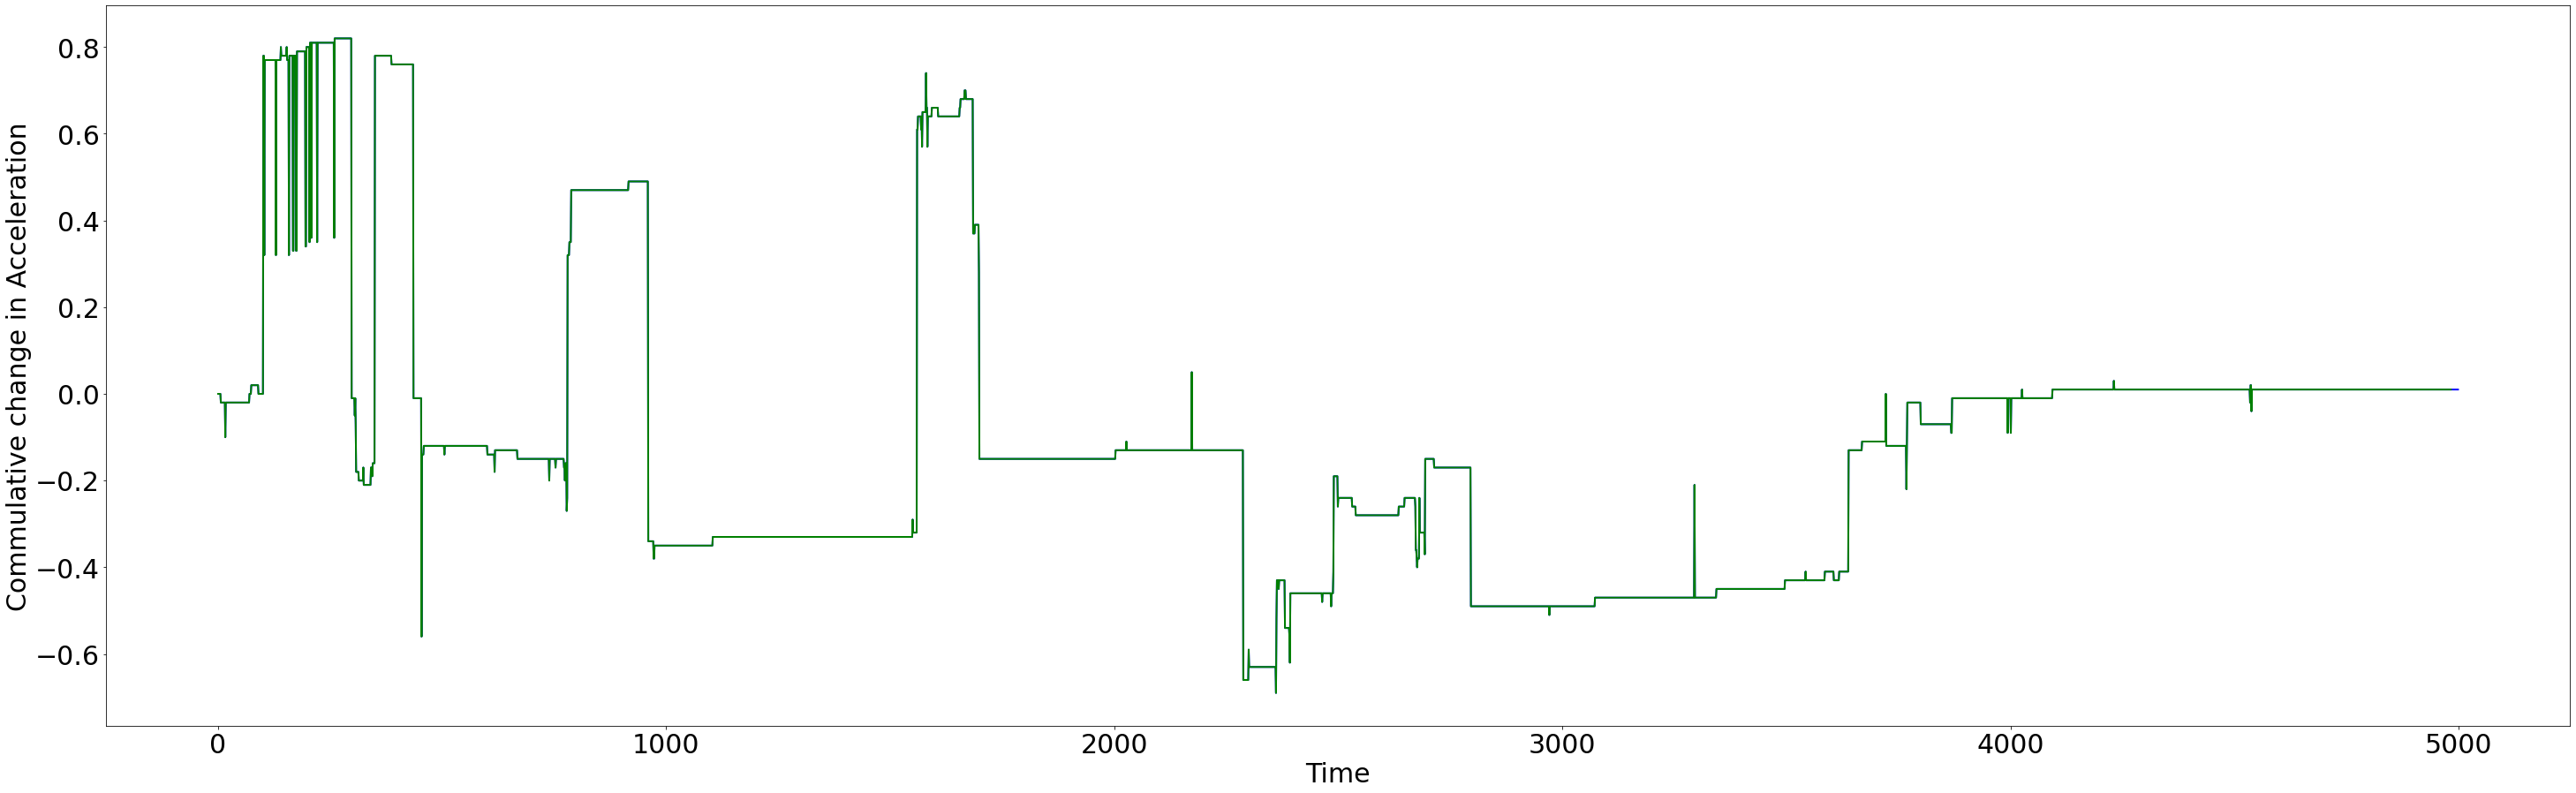

In [ ]:
##plot for Cy
plt.plot(Cy)
plt.plot(history)

plt.xlabel("Time")
plt.ylabel("Commulative change in Acceleration")
plt.show()

In [ ]:
### grid search for cumz
scores = grid_search(Cz, cfg_list, n_test)
print('done')

 > Model[[(0, 0, 0), (0, 0, 0, 0), 'n']] 1.300
 > Model[[(0, 1, 0), (0, 0, 0, 0), 'n']] 0.000
 > Model[[(1, 1, 0), (0, 0, 0, 0), 'n']] 0.000
 > Model[[(1, 0, 0), (0, 0, 0, 0), 'n']] 0.003
 > Model[[(0, 0, 1), (0, 0, 0, 0), 'n']] 0.661
 > Model[[(1, 0, 1), (0, 0, 0, 0), 'n']] 0.002
 > Model[[(0, 1, 1), (0, 0, 0, 0), 'n']] 0.000
 > Model[[(1, 1, 1), (0, 0, 0, 0), 'n']] 0.000
done


In [ ]:
# list top 3 configs
for cfg, error in scores[:3]:
    print(cfg, error)

[(0, 1, 0), (0, 0, 0, 0), 'n'] 0.0
[(0, 1, 1), (0, 0, 0, 0), 'n'] 0.0
[(1, 1, 0), (0, 0, 0, 0), 'n'] 0.0


In [ ]:
cfg = [(1, 0, 1), (0, 0, 0, 0), 'n']

In [ ]:
l=5000
Cz = df['cumz'].values[:l]

In [ ]:
history = walk_forward_validations(Cz, 10, cfg)

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


6, -0.04, 0.0
7, 0.0, 1.9487536989449674e-10
8, 0.0, 7.199498856831692e-19
9, 0.0, 1.3175950503223978e-27
10, 0.0, 3.954743626331409e-36
11, 0.0, 5.596872998587935e-45
12, 0.0, 6.734173599233394e-54
13, 0.0, 8.045863287389207e-64
14, 0.0, 1.1519685519914884e-73
15, 0.0, 5.756546419453868e-83
16, -0.6, 2.6086768423015335e-92
17, -0.01, 6.710704125036441e-09
18, -0.01, -0.00016592751413171494
19, -0.01, -0.0001703608466267722
20, -0.01, -0.0001730276640965174
21, -0.01, -0.00017596915377459288
22, -0.01, -0.00017887300043370737
23, -0.01, -0.00018164277621119824
24, -0.01, -0.00018478424507257114
25, -0.01, -0.00018770375905166592
26, -0.01, -0.0001906493791194034
27, -0.01, -0.0001936808017950981
28, -0.01, -0.0001967107151810193
29, -0.03, -0.0001996321780686863
30, -0.03, -0.009183117307844189
31, -0.03, -0.0007023698520968611
32, -0.03, -0.0007822727495188386
33, -0.03, -0.0008641129177034362
34, -0.03, -0.012245036785357107
35, -0.03, -0.012956513202513488
36, -0.03, -0.013649240104

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


56, -0.03, -0.022772919803760644
57, -0.03, -0.023047956074026543
58, -0.03, -0.023304092843612942
59, -0.03, -0.023549910379049913
60, -0.03, -0.02378560136679603
61, -0.03, -0.024016985845967766
62, -0.03, -0.024228147674276626
63, -0.03, -0.0244340292813884
64, -0.03, -0.02463153976175931
65, 0.0, -0.024820577299473227
66, -0.02, -0.02340725647640356
67, -0.02, -0.02311988777374041
68, -0.02, -0.02284895649838326
69, -0.02, -0.022593378776524894
70, -0.02, -0.022351979384337365
71, -0.02, -0.022123551452119312
72, -0.02, -0.021903768582022597
73, -0.02, -0.02170140575301741
74, -0.02, -0.021505901283802982
75, -0.02, -0.021320903800342576
76, -0.02, -0.02114204815447405
77, -0.02, -0.020972365303709977
78, -0.02, -0.020809444071901537
79, -0.02, -0.0206565059466429
80, -0.02, -0.020508557233329096
81, -0.02, -0.02036699936784262
82, -0.02, -0.020231691844878892
83, -0.02, -0.020100452538456475
84, -0.02, -0.019975287867769725
85, -0.02, -0.019855274548430123
86, -0.02, -0.0197393777

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


244, -1.08, -1.0796335194840396
245, -1.08, -1.0796359508690656
246, -1.08, -1.0796382128673316
247, -1.08, -1.0796405739043995
248, -1.08, -1.0796427850535226
249, -1.08, -1.0796450277199112
250, -1.08, -1.0796472417588807
251, -1.08, -1.0796494291439291
252, -1.08, -1.0796515880574808
253, -1.08, -1.079653720382734
254, -1.08, -1.0796558259148417
255, -1.08, -1.079657906591265
256, -1.08, -1.0796599611836362
257, -1.08, -1.0796619911239114
258, -1.08, -1.0796639966218216
259, -1.16, -1.0796659789435448
260, -1.09, -1.1450043819179365
261, -1.09, -1.100275215810493
262, -1.09, -1.0917495301754472
263, -1.09, -1.0901251705966983
264, -1.09, -1.089816605100212
265, -1.09, -1.0897588709967636
266, -1.09, -1.0897490314237392
267, -1.09, -1.0897483216746928
268, -1.09, -1.0897493411117556
269, -1.09, -1.0897506779122252
270, -1.09, -1.0897520618523784
271, -1.09, -1.0897534424747692
272, -1.09, -1.0897548090825195
273, -1.09, -1.0897561608613069
274, -1.09, -1.0897574979473768
275, -1.09, 

504, -1.09, -1.0883484335998055
505, -1.09, -1.088351729204654
506, -1.09, -1.0883549755821036
507, -1.09, -1.0883582332742394
508, -1.09, -1.0883614556076275
509, -1.09, -1.0883647029033907
510, -1.09, -1.088367923429613
511, -1.09, -1.0883710971958125
512, -1.09, -1.0883742912471024
513, -1.09, -1.0883774844473264
514, -1.09, -1.0883806042866784
515, -1.09, -1.0883837754699426
516, -1.09, -1.0883869195792713
517, -1.09, -1.0883900528792936
518, -1.09, -1.0883931659383739
519, -1.09, -1.088396286425047
520, -1.09, -1.0883993464003916
521, -1.09, -1.088402431346893
522, -1.09, -1.0884055335657516
523, -1.09, -1.0884085429740962
524, -1.09, -1.0884116359895168
525, -1.09, -1.0884146549047389
526, -1.09, -1.0884176566665484
527, -1.09, -1.0884206344229423
528, -1.09, -1.0884236776328895
529, -1.09, -1.0884266667454214
530, -1.07, -1.0884296259345296
531, -1.07, -1.0716653758166859
532, -1.07, -1.0689470783243653
533, -1.07, -1.0685083752173652
534, -1.07, -1.0684395525177222
535, -1.07, 

763, -1.07, -1.0688737322524509
764, -1.1, -1.0688810666046478
765, -1.07, -1.0934588901485727
766, -1.07, -1.0733017720616183
767, -1.07, -1.0696934290962674
768, -1.07, -1.0690331549811232
769, -1.07, -1.0689145528830486
770, -1.07, -1.0688941857647922
771, -1.05, -1.0688916328621554
772, -1.05, -1.0525115910911438
773, -1.09, -1.0495420415872752
774, -1.02, -1.081763928476472
775, -1.07, -1.030314788490219
776, -1.07, -1.0619041070994546
777, -1.07, -1.0676302775482913
778, -1.26, -1.0686662681413732
779, -1.31, -1.224624118276298
780, -1.77, -1.2942750563343088
781, -1.77, -1.6918705140419563
782, -1.77, -1.7584676408321882
783, -1.77, -1.7682820558267807
784, -1.77, -1.7698066713451106
785, -1.77, -1.7700444323189808
786, -1.77, -1.7700812789481895
787, -1.77, -1.7700867519692205
788, -1.67, -1.7700873183232093
789, -1.67, -1.6853660657973875
790, -1.67, -1.6721420153018696
791, -1.67, -1.6700903601375738
792, -1.67, -1.669771851717294
793, -1.79, -1.6697229700106864
794, -1.68, -

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


864, -1.64, -1.639678887845492
865, -1.64, -1.6396796711826778
866, -1.64, -1.6396803444871886
867, -1.64, -1.6396810727346711
868, -1.64, -1.63968179417681
869, -1.64, -1.639682515645709
870, -1.64, -1.6396832312499772
871, -1.64, -1.6396839433454486
872, -1.64, -1.639684647377104
873, -1.64, -1.6396853553904096
874, -1.64, -1.6396860581780333
875, -1.62, -1.639686759294295
876, -1.62, -1.622803252524856
877, -1.62, -1.6201382933582589
878, -1.62, -1.619718308225948
879, -1.62, -1.619652657786459
880, -1.62, -1.6196429433248414
881, -1.62, -1.6196420632557926
882, -1.62, -1.6196425688116451
883, -1.62, -1.619643290748804
884, -1.62, -1.6196440419441656
885, -1.62, -1.619644797024781
886, -1.62, -1.6196455450124911
887, -1.62, -1.6196462929191056
888, -1.62, -1.6196470294061143
889, -1.64, -1.6196477750699596
890, -1.64, -1.6365303973764744
891, -1.62, -1.6391968259830412
892, -1.64, -1.6227359060833517
893, -1.64, -1.6370186280316585
894, -1.64, -1.6392753275425138
895, -1.64, -1.6396

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1076, -1.09, -1.0890838103270009
1077, -1.09, -1.08908447942007
1078, -1.09, -1.0890852051936832
1079, -1.09, -1.0890858971508925
1080, -1.09, -1.0890865459557553
1081, -1.09, -1.0890872921247516


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1082, -1.09, -1.0890879720030227
1083, -1.09, -1.089088676744126
1084, -1.09, -1.0890893457863025
1085, -1.09, -1.0890900321514203
1086, -1.09, -1.089090723393407
1087, -1.09, -1.0890913956208481
1088, -1.09, -1.089092110414705
1089, -1.09, -1.089092765631926
1090, -1.09, -1.0890934653790278
1091, -1.09, -1.089094153477771
1092, -1.09, -1.0890947971141531
1093, -1.09, -1.0890955020928177
1094, -1.09, -1.089096141911922
1095, -1.09, -1.0890968205676828
1096, -1.09, -1.0890975320112624
1097, -1.09, -1.089098174146829
1098, -1.09, -1.0890988939285953
1099, -1.09, -1.0890995349192172
1100, -1.09, -1.0891002453875192
1101, -1.09, -1.0891008766714265
1102, -1.09, -1.0891015458737805
1103, -1.09, -1.0891022625838473
1104, -1.09, -1.0891029017211664
1105, -1.09, -1.0891035642822917
1106, -1.09, -1.0891042767439512
1107, -1.09, -1.0891049330606715
1108, -1.09, -1.089105633703674
1109, -1.09, -1.0891062729731371
1110, -1.09, -1.089106958706494
1111, -1.09, -1.0891076191370948
1112, -1.11, -1.089

1334, -1.09, -1.089221880748715
1335, -1.09, -1.0892310750797014
1336, -1.09, -1.0892328371674664
1337, -1.09, -1.0892335454723088
1338, -1.09, -1.0892340641957867
1339, -1.09, -1.0892345270678239
1340, -1.09, -1.0892350224859744
1341, -1.09, -1.0892354919895946


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1342, -1.09, -1.0892360069200442
1343, -1.09, -1.0892364766498164
1344, -1.09, -1.089236953263356
1345, -1.09, -1.0892374091010486
1346, -1.09, -1.0892379116829327
1347, -1.09, -1.0892383921221194
1348, -1.09, -1.0892388556194936
1349, -1.09, -1.0892393790422181
1350, -1.09, -1.0892398275470125
1351, -1.07, -1.089240300114349
1352, -1.07, -1.0722454709207456
1353, -1.07, -1.069692067908967
1354, -1.07, -1.0693088294812945
1355, -1.07, -1.069251635744827
1356, -1.07, -1.0692434739824823
1357, -1.07, -1.069242592593342
1358, -1.07, -1.0692428599913362
1359, -1.07, -1.0692433216182766
1360, -1.07, -1.0692437739372653
1361, -1.07, -1.069244183652245
1362, -1.07, -1.0692446850723258
1363, -1.05, -1.0692451404764027
1364, -1.05, -1.0522507227576865
1365, -1.05, -1.0496975901888266
1366, -1.05, -1.049314397059075
1367, -1.05, -1.0492571948403633
1368, -1.05, -1.0492489706881638
1369, -1.05, -1.04924810467613
1370, -1.05, -1.049248344348384
1371, -1.05, -1.04924874831724
1372, -1.05, -1.049249

1593, -0.97, -0.9693269245241757
1594, -0.97, -0.9693272202731535
1595, -0.97, -0.9693275163168902
1596, -0.97, -0.9693278120723184
1597, -0.97, -0.9693281076748972
1598, -0.97, -0.9693284025311176
1599, -0.97, -0.9693286983665671
1600, -0.97, -0.9693289929616752
1601, -0.97, -0.9693292871057044
1602, -0.97, -0.9693295813022232
1603, -0.97, -0.9693298751972981
1604, -0.97, -0.9693301687818452
1605, -0.97, -0.9693304619345772
1606, -0.97, -0.9693307557507124
1607, -0.97, -0.9693310481097978
1608, -0.97, -0.9693313411374287
1609, -0.97, -0.9693316336487232
1610, -0.97, -0.9693319250498682
1611, -0.97, -0.9693322173257184
1612, -0.97, -0.9693325092830349
1613, -0.97, -0.9693328007047449
1614, -0.97, -0.969333091728118
1615, -0.97, -0.96933338260844
1616, -0.97, -0.9693336727687333
1617, -0.97, -0.9693339635450466
1618, -0.97, -0.9693342532521543
1619, -0.97, -0.9693345434802075
1620, -0.97, -0.9693348325121335
1621, -0.97, -0.9693351215840997
1622, -0.97, -0.9693354115568954
1623, -0.97, 

1843, -0.85, -0.849363423419977
1844, -0.85, -0.8493636198897735
1845, -0.85, -0.8493638167946119
1846, -0.85, -0.8493640132698439
1847, -0.85, -0.8493642097806311
1848, -0.85, -0.849364406040162
1849, -0.85, -0.8493646025496097
1850, -0.85, -0.8493647988120172
1851, -0.85, -0.8493649943995343
1852, -0.85, -0.8493651904706013
1853, -0.85, -0.8493653854737555
1854, -0.85, -0.849365581553392
1855, -0.85, -0.8493657767910919
1856, -0.85, -0.8493659722117354
1857, -0.85, -0.84936616739344
1858, -0.85, -0.8493663625854644
1859, -0.85, -0.849366557811333
1860, -0.85, -0.8493667527601529
1861, -0.85, -0.8493669473819692
1862, -0.85, -0.84936714167731
1863, -0.85, -0.8493673363373988
1864, -0.85, -0.8493675312131715
1865, -0.85, -0.8493677249788181
1866, -0.85, -0.8493679192705432
1867, -0.85, -0.8493681134186484
1868, -0.85, -0.8493683069602077
1869, -0.85, -0.8493685008600858
1870, -0.85, -0.8493686945644074
1871, -0.85, -0.84936888823958
1872, -0.85, -0.8493690815547363
1873, -0.85, -0.8493

2093, -0.85, -0.8494124146600436
2094, -0.85, -0.8494125831171208
2095, -0.85, -0.8494127512700654
2096, -0.85, -0.8494129195331455
2097, -0.85, -0.8494130876228067
2098, -0.87, -0.8494132557578605
2099, -0.85, -0.8664650536887694
2100, -0.85, -0.8519231181839388
2101, -0.87, -0.849783063243693
2102, -0.87, -0.8665185174345507
2103, -0.87, -0.868982109425688
2104, -0.87, -0.8693448202113501
2105, -0.87, -0.8693983547039664
2106, -0.87, -0.8694063851024494
2107, -0.87, -0.86940771786857
2108, -0.87, -0.869408065032894
2109, -0.87, -0.8694082669390151
2110, -0.89, -0.8694084473184907
2111, -0.87, -0.8864594761744469
2112, -0.87, -0.8719192440459627
2113, -0.87, -0.8697785684787592
2114, -0.87, -0.8694635423016553
2115, -0.87, -0.86941730858054
2116, -0.87, -0.8694106516352902
2117, -0.87, -0.8694098213733172
2118, -0.87, -0.8694098490892985
2119, -0.87, -0.8694100031612628
2120, -0.87, -0.869410175661085
2121, -0.87, -0.8694103507944753
2122, -0.87, -0.8694105261519913
2123, -0.87, -0.86

2343, 0.01, 0.009990425248871141
2344, 0.01, 0.0099904252586638
2345, 0.01, 0.009990425269454697
2346, 0.01, 0.009990425277335586
2347, 0.01, 0.00999042528627135
2348, 0.01, 0.009990425293223021
2349, 0.01, 0.009990425302107107
2350, 0.01, 0.009990425309999381
2351, 0.01, 0.009990425320826394
2352, 0.01, 0.009990425330663197
2353, 0.01, 0.009990425336687151
2354, 0.01, 0.009990425348532877
2355, 0.01, 0.00999042535644361
2356, 0.01, 0.009990425366360845
2357, 0.01, 0.00999042537427858
2358, 0.01, 0.00999042538219782
2359, 0.01, 0.009990425391185059
2360, 0.01, 0.009990425401061685
2361, 0.14, 0.009990425409051536
2362, 0.04, 0.1223098661698021
2363, 0.1, 0.051208646255203556
2364, 0.1, 0.09320810770675929
2365, 0.1, 0.09898328932344135
2366, 0.1, 0.09977759573784005
2367, 0.06, 0.09988687517519901
2368, 0.1, 0.06543806034941509
2369, 0.1, 0.09515569389564503
2370, 0.1, 0.09925011369600634
2371, 0.1, 0.09981415315332955
2372, 0.1, 0.09989186796665799
2373, 0.1, 0.09990257616373811
2374,

2601, 0.11, 0.10989451529683669
2602, 0.11, 0.10989451590518881
2603, 0.11, 0.10989451646899381
2604, 0.11, 0.10989451704570377
2605, 0.11, 0.10989451763296125
2606, 0.11, 0.10989451820878449
2607, 0.11, 0.10989451878539712
2608, 0.11, 0.10989451936124243
2609, 0.11, 0.1098945199241046
2610, 0.11, 0.10989452051294935
2611, 0.11, 0.1098945210635873
2612, 0.11, 0.10989452165167474
2613, 0.11, 0.10989452222754434
2614, 0.08, 0.10989452279038908
2615, 0.11, 0.08410337516802238
2616, 0.11, 0.10629453447299315
2617, 0.11, 0.10939204689416743
2618, 0.11, 0.1098243737254003
2619, 0.11, 0.10988472080869778
2620, 0.11, 0.10989314494334682
2621, 0.11, 0.1098943213352816
2622, 0.11, 0.1098944860148181
2623, 0.11, 0.10989450951317012
2624, 0.11, 0.10989455322130823
2625, 0.11, 0.10989451430865335
2626, 0.11, 0.1098945549190579
2627, 0.11, 0.10989451554471635
2628, 0.11, 0.10989455610296632
2629, 0.11, 0.10989455671796379
2630, 0.11, 0.10989455729874627
2631, 0.11, 0.10989455789124215
2632, 0.11, 0.

2858, -0.72, -0.7187695541715633
2859, -0.72, -0.7191443926015102
2860, -0.72, -0.7192001362771979
2861, -0.72, -0.7192085325715567
2862, -0.72, -0.7192099029757374
2863, -0.72, -0.7192102310563644
2864, -0.72, -0.7192104042281914
2865, -0.72, -0.7192108221105228
2866, -0.72, -0.7192107010896457
2867, -0.72, -0.7192111151335051
2868, -0.72, -0.7192112612344406
2869, -0.72, -0.7192114072614242
2870, -0.74, -0.7192115532421514
2871, -0.74, -0.7362290618314841
2872, -0.74, -0.7387544839357416
2873, -0.74, -0.739129318303565
2874, -0.74, -0.7391850676884827
2875, -0.74, -0.7391934737321003
2876, -0.74, -0.7391948550171022
2877, -0.74, -0.7391951936166591
2878, -0.74, -0.7391953776539557
2879, -0.74, -0.7391955386509248
2880, -0.74, -0.7391956963388467
2881, -0.74, -0.7391958531853483
2882, -0.74, -0.7391960100300937
2883, -0.74, -0.7391961669277302
2884, -0.74, -0.7391963234996295
2885, -0.74, -0.7391964801502505
2886, -0.74, -0.7391966367272637
2887, -0.74, -0.7391967932538395
2888, -0.74

3107, -0.73, -0.7292346995173444
3108, -0.73, -0.7292360368058983
3109, -0.73, -0.7292362686650321
3110, -0.73, -0.7292365242442364
3111, -0.73, -0.7292366866930442
3112, -0.73, -0.7292368721971791
3113, -0.73, -0.7292369702984833
3114, -0.73, -0.7292371098548496
3115, -0.73, -0.7292372491612178
3116, -0.73, -0.7292373886141806
3117, -0.75, -0.7292375272181891
3118, -0.75, -0.7462550542348533
3119, -0.75, -0.7487811295537666
3120, -0.75, -0.7491561555377731
3121, -0.75, -0.749211949622476
3122, -0.75, -0.7492203449392922
3123, -0.75, -0.7492216953892603
3124, -0.75, -0.7492220639934569
3125, -0.75, -0.7492222403757105
3126, -0.75, -0.7492223937655712
3127, -0.75, -0.7492225645688543
3128, -0.75, -0.749222709371565
3129, -0.73, -0.7492228684164154
3130, -0.73, -0.7322052346434061
3131, -0.73, -0.729679644185873
3132, -0.73, -0.7293049541974659
3133, -0.73, -0.7292494651981046
3134, -0.73, -0.7292413422189611
3135, -0.73, -0.7292402631163695
3136, -0.73, -0.7292402243695278
3137, -0.73, 

3358, -0.78, -0.7792307902097368
3359, -0.78, -0.7792309424540107
3360, -0.78, -0.7792310858939255
3361, -0.78, -0.7792312469934899
3362, -0.78, -0.7792313991809271
3363, -0.78, -0.7792315513084915
3364, -0.76, -0.7792317033646289
3365, -0.76, -0.7622894474134128
3366, -0.76, -0.759710286122363
3367, -0.76, -0.7593177877293638
3368, -0.76, -0.7592581619977697
3369, -0.76, -0.7592479402772234
3370, -0.78, -0.759247960909566
3371, -0.78, -0.7761902466990804
3372, -0.78, -0.7787696638908017
3373, -0.78, -0.7791611397443331
3374, -0.78, -0.7792223305661597
3375, -0.78, -0.7792315878081382
3376, -0.78, -0.7792331239861761
3377, -0.78, -0.7792334861150847
3378, -0.78, -0.7792336694699308
3379, -0.78, -0.779233816808123
3380, -0.78, -0.7792339774393229
3381, -0.78, -0.7792341286452794
3382, -0.78, -0.7792342796878547
3383, -0.78, -0.7792331453616382
3384, -0.78, -0.7792345728842636
3385, -0.78, -0.779233447264032
3386, -0.78, -0.7792336002076831
3387, -0.78, -0.7792337533365222
3388, -0.78, -

3608, -0.82, -0.8222109122830734
3609, -0.82, -0.8196920264053571
3610, -0.82, -0.8193088549267745
3611, -0.82, -0.819250685185457
3612, -0.82, -0.8192419669697012
3613, -0.82, -0.8192407741319121
3614, -0.82, -0.819240726434618
3615, -0.82, -0.8192408529479694
3616, -0.82, -0.8192410059202252
3617, -0.82, -0.8192411558501383
3618, -0.82, -0.8192413203492057
3619, -0.82, -0.8192414778662214
3620, -0.82, -0.8192416353208478
3621, -0.82, -0.8192417927329969
3622, -0.82, -0.8192419500703394
3623, -0.82, -0.8192421073413876
3624, -0.82, -0.819242264545163
3625, -0.82, -0.8192424216983435
3626, -0.82, -0.8192425787612917
3627, -0.82, -0.8192427288845114
3628, -0.82, -0.8192428927191093
3629, -0.82, -0.819243049596434
3630, -0.82, -0.8192432064116476
3631, -0.82, -0.8192433631699105
3632, -0.82, -0.8192435198433092
3633, -0.82, -0.8192436764616794
3634, -0.82, -0.8192438330258465
3635, -0.82, -0.8192439895041365
3636, -0.82, -0.8192434627933616
3637, -0.82, -0.8192436184748906
3638, -0.82, -

3858, -0.79, -0.7891864390685592
3859, -0.79, -0.7892494833907929
3860, -0.79, -0.789259372814903
3861, -0.79, -0.7892610215091717
3862, -0.79, -0.7892613934252719
3863, -0.79, -0.7892615666775944
3864, -0.79, -0.789261709242355
3865, -0.79, -0.7892618472476346
3866, -0.79, -0.7892619847638744
3867, -0.79, -0.789262121321665
3868, -0.79, -0.7892622586655397
3869, -0.79, -0.7892623954535501
3870, -0.79, -0.7892625323173833
3871, -0.79, -0.7892626690374088
3872, -0.79, -0.7892628058843315
3873, -0.79, -0.7892629424053101
3874, -0.79, -0.7892630789716385
3875, -0.79, -0.7892632156770263
3876, -0.79, -0.7892633525498687
3877, -0.79, -0.789263489043448
3878, -0.79, -0.7892636248796212
3879, -0.79, -0.7892637615239815
3880, -0.79, -0.7892638980399848
3881, -0.79, -0.789264034058503
3882, -0.79, -0.7892641705096052
3883, -0.79, -0.7892643067116663
3884, -0.79, -0.7892644425295912
3885, -0.79, -0.7892645784397695
3886, -0.79, -0.7892647145181574
3887, -0.79, -0.7892648507638701
3888, -0.79, -0

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4017, -0.82, -0.8192453034822206
4018, -0.82, -0.8192454493656601
4019, -0.82, -0.8192455961396293
4020, -0.82, -0.8192457419141582
4021, -0.82, -0.8192458888642808
4022, -0.82, -0.8192460339370525
4023, -0.82, -0.8192461796949619
4024, -0.82, -0.8192463264847918
4025, -0.82, -0.8192464721526408


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4026, -0.82, -0.8192466174755537
4027, -0.82, -0.8192467648390336
4028, -0.82, -0.8192469101796896
4029, -0.82, -0.8192470566616443


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4030, -0.82, -0.819247202315433
4031, -0.82, -0.8192473467006193
4032, -0.82, -0.8192474921005737
4033, -0.82, -0.8192476376969845
4034, -0.82, -0.8192477829193033
4035, -0.82, -0.8192479285346099
4036, -0.82, -0.8192480734408382
4037, -0.82, -0.8192482187169352
4038, -0.82, -0.8192483639925088
4039, -0.82, -0.819248510168014
4040, -0.82, -0.8192486554595599
4041, -0.82, -0.8192487993738139
4042, -0.82, -0.8192489444772716
4043, -0.82, -0.819249090459516
4044, -0.82, -0.8192492356493354
4045, -0.82, -0.8192493793471227
4046, -0.82, -0.8192495237899825
4047, -0.82, -0.8192496685326998
4048, -0.82, -0.8192498137418227
4049, -0.82, -0.8192499581142326
4050, -0.82, -0.819250103804145
4051, -0.82, -0.8192502476376093


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4052, -0.82, -0.8192503918748255
4053, -0.82, -0.8192505367711671
4054, -0.82, -0.8192506808187972
4055, -0.82, -0.8192508244014781
4056, -0.82, -0.8192509693769683
4057, -0.82, -0.8192511134101375


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4058, -0.82, -0.8192512573407004
4059, -0.82, -0.8192514012647647
4060, -0.82, -0.8192515305881595
4061, -0.82, -0.8192516893294595
4062, -0.82, -0.8192518189021604
4063, -0.82, -0.8192519631969146
4064, -0.82, -0.81925210685455
4065, -0.82, -0.8192522512282553
4066, -0.82, -0.8192523950013236
4067, -0.82, -0.8192525390922273
4068, -0.82, -0.8192526827591042
4069, -0.82, -0.8192528263516903
4070, -0.82, -0.8192529703894292
4071, -0.82, -0.819253113859677
4072, -0.82, -0.819253257494644
4073, -0.82, -0.8192534009987235
4074, -0.84, -0.8192535444178167
4075, -0.82, -0.8357847097313796
4076, -0.82, -0.8221123290365883
4077, -0.82, -0.819748245229988
4078, -0.82, -0.8193395681058735
4079, -0.82, -0.8192690178044523
4080, -0.82, -0.8192569362019447
4081, -0.82, -0.8192549653629669
4082, -0.82, -0.8192547427230927
4083, -0.82, -0.8192548227581173
4084, -0.82, -0.8192549549435932
4085, -0.82, -0.8192550960080868
4086, -0.82, -0.8192552377353811
4087, -0.82, -0.8192553810412869
4088, -0.84, -0

4309, -0.81, -0.8092907346441722
4310, -0.81, -0.8092908619184079
4311, -0.81, -0.8092909891735366
4312, -0.81, -0.8092911163977798
4313, -0.81, -0.8092912434446281
4314, -0.81, -0.8092913706225247
4315, -0.81, -0.8092914976048868
4316, -0.81, -0.8092916241880473
4317, -0.81, -0.8092917514783732
4318, -0.81, -0.8092918783370513
4319, -0.81, -0.8092920051259275
4320, -0.81, -0.8092921318789414
4321, -0.81, -0.8092922584363161
4322, -0.81, -0.8092923854345022
4323, -0.81, -0.8092925118069635
4324, -0.81, -0.809292638388458
4325, -0.81, -0.8092927651049547
4326, -0.81, -0.8092928914471684
4327, -0.81, -0.8092930180394545
4328, -0.81, -0.809293144282299
4329, -0.81, -0.8092932707295877
4330, -0.81, -0.8092933972215393
4331, -0.83, -0.809293523416325
4332, -0.81, -0.8258026322576024
4333, -0.83, -0.8121669663257851
4334, -0.83, -0.8263019268807789
4335, -0.83, -0.8287625462194479
4336, -0.83, -0.8291909620163554
4337, -0.83, -0.8292656459853794
4338, -0.83, -0.8292787572469918
4339, -0.83, 

4559, -0.87, -0.8491707968785156
4560, -0.87, -0.8656094927323386
4561, -0.87, -0.868610662776225
4562, -0.87, -0.8691585999739979
4563, -0.87, -0.8692587380734124
4564, -0.87, -0.8692771335921506
4565, -0.87, -0.8692806074221571
4566, -0.87, -0.8692813574028011
4567, -0.87, -0.8692816101697645
4568, -0.87, -0.8692817717947163
4569, -0.87, -0.8692819169775163
4570, -0.87, -0.869282059340571
4571, -0.87, -0.8692822006246905
4572, -0.87, -0.869282342279316
4573, -0.87, -0.8692824836001386
4574, -0.87, -0.8692826244688258
4575, -0.87, -0.869282765959846
4576, -0.87, -0.8692829071796014
4577, -0.87, -0.8692830481287731
4578, -0.87, -0.8692831889095755
4579, -0.87, -0.8692833299401749
4580, -0.87, -0.8692834709552293
4581, -0.87, -0.8692836116202355
4582, -0.87, -0.8692837524724679
4583, -0.87, -0.8692838931100937
4584, -0.87, -0.8692840338681165
4585, -0.87, -0.8692841743743508
4586, -0.87, -0.8692843149548811
4587, -0.87, -0.8692844558006062
4588, -0.87, -0.8692845959535966
4589, -0.87, -

4809, -0.85, -0.8486578997025782
4810, -0.85, -0.8492028102898985
4811, -0.85, -0.8493024108345291
4812, -0.85, -0.8493206976311445
4813, -0.85, -0.8493241356220274
4814, -0.85, -0.8493248626717156
4815, -0.85, -0.8493250944199336
4816, -0.85, -0.8493252358069439
4817, -0.85, -0.8493253600064727
4818, -0.85, -0.849325481993133
4819, -0.85, -0.8493256029951352
4820, -0.85, -0.849325723832186
4821, -0.85, -0.8493258449834007
4822, -0.85, -0.8493259654695964
4823, -0.85, -0.8493260863673612
4824, -0.85, -0.849326206958833
4825, -0.85, -0.8493263275536607
4826, -0.85, -0.8493264481312933
4827, -0.85, -0.849326569010854
4828, -0.85, -0.8493266893711379
4829, -0.85, -0.8493268100429485
4830, -0.85, -0.8493269304297737
4831, -0.85, -0.8493270506325151
4832, -0.85, -0.8493271710315403
4833, -0.83, -0.8493272912360749
4834, -0.83, -0.8329888411775906
4835, -0.83, -0.8300054798338977
4836, -0.83, -0.8294608531827975
4837, -0.83, -0.829361498318737
4838, -0.83, -0.8293434485852565
4839, -0.83, -0

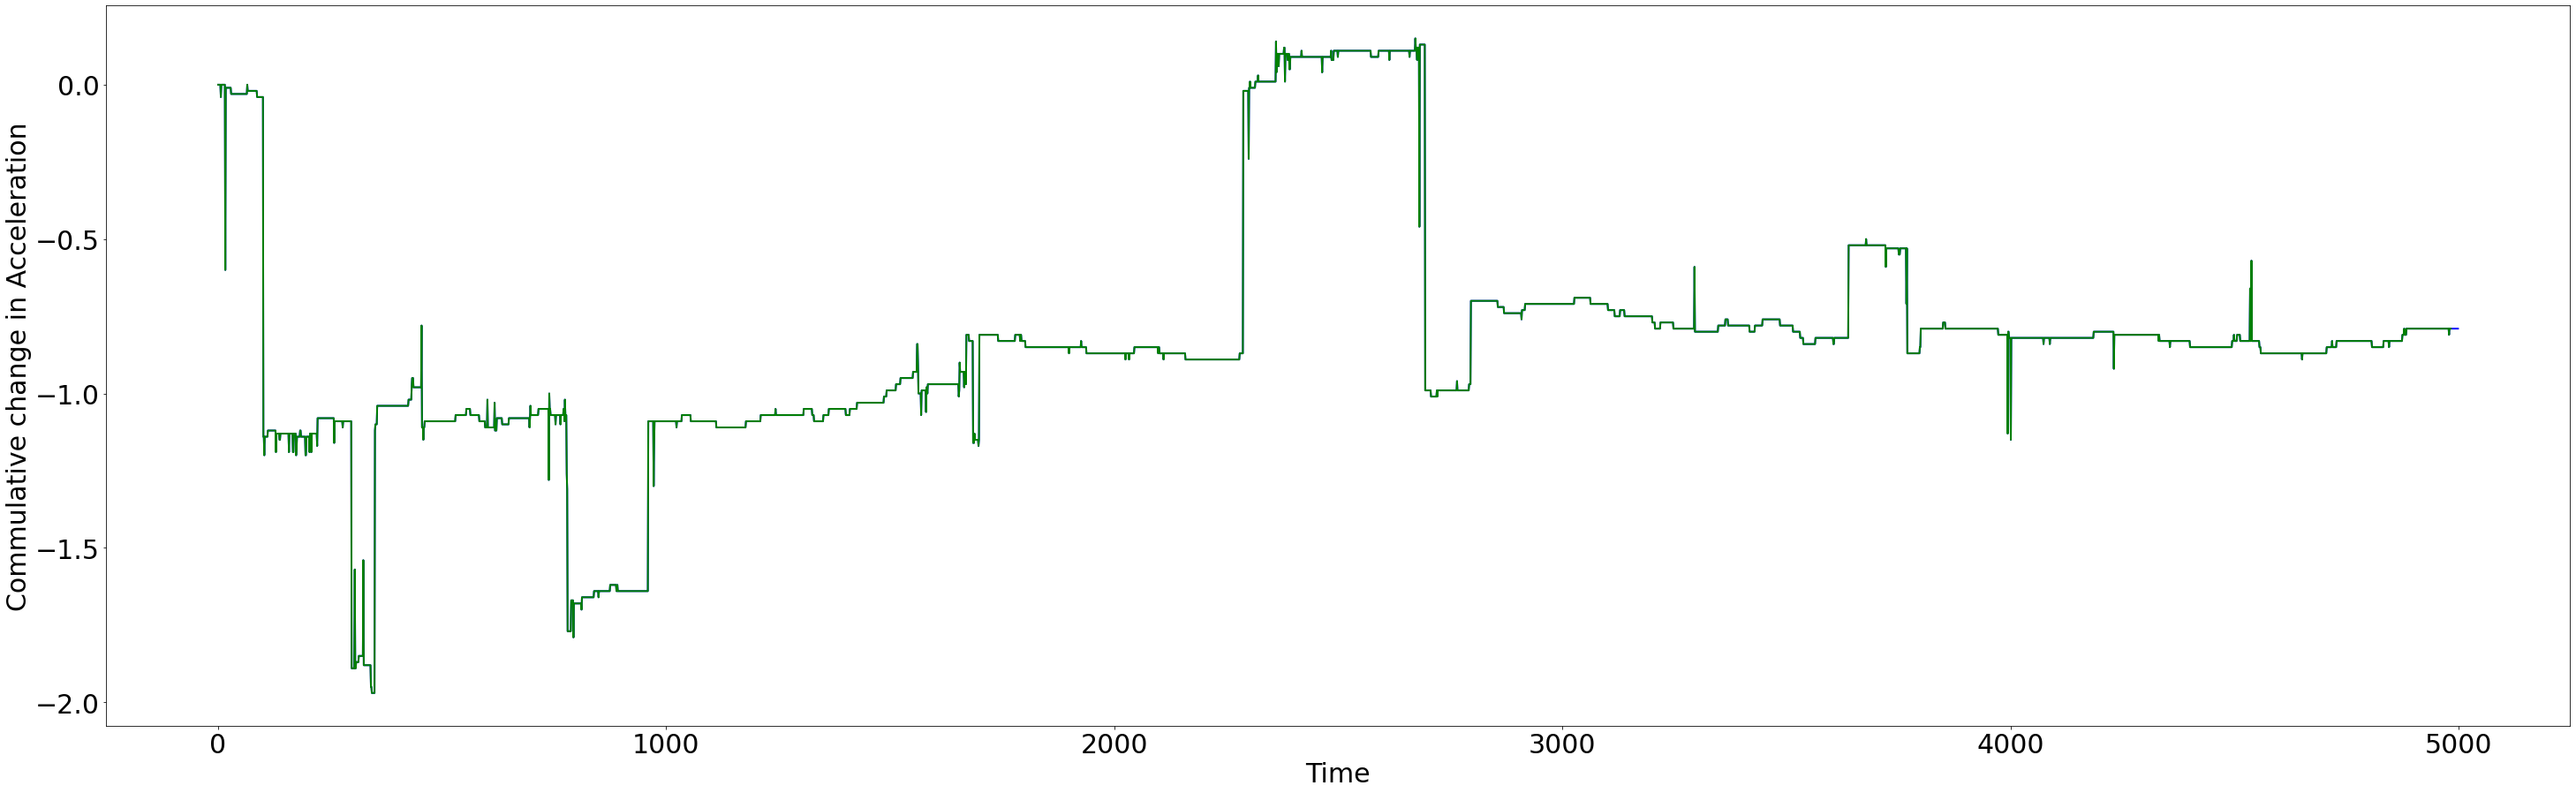

In [ ]:
##plot for Cz
plt.plot(Cz)
plt.plot(history)

plt.xlabel("Time")
plt.ylabel("Commulative change in Acceleration")
plt.show()

In [ ]:
### grid search for cumz
scores = grid_search(Cwx, cfg_list, n_test)
print('done')

 > Model[[(0, 0, 0), (0, 0, 0, 0), 'n']] 6.260
 > Model[[(1, 0, 0), (0, 0, 0, 0), 'n']] 3.985
 > Model[[(1, 1, 0), (0, 0, 0, 0), 'n']] 0.000
 > Model[[(0, 1, 0), (0, 0, 0, 0), 'n']] 0.000
 > Model[[(0, 0, 1), (0, 0, 0, 0), 'n']] 4.842
 > Model[[(0, 1, 1), (0, 0, 0, 0), 'n']] 0.121
 > Model[[(1, 1, 1), (0, 0, 0, 0), 'n']] 0.102
 > Model[[(1, 0, 1), (0, 0, 0, 0), 'n']] 0.164
done


In [ ]:
# list top 3 configs
for cfg, error in scores[:3]:
    print(cfg, error)

[(0, 1, 0), (0, 0, 0, 0), 'n'] 0.0
[(1, 1, 0), (0, 0, 0, 0), 'n'] 0.0
[(1, 1, 1), (0, 0, 0, 0), 'n'] 0.10249179618244982


In [ ]:
cfg = [(1, 1, 1), (0, 0, 0, 0), 'n']

In [ ]:
l=5000
Cwx = df['cumwx'].values[:l]

In [ ]:
history = walk_forward_validations(Cwx, 10, cfg)

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


6, -1.16, -10.933201455239342
7, -5.64, -2.7783085015328615
8, -8.01, -4.818500853863559
9, -17.19, -6.380996736631002
10, -10.29, -17.816491069133125
11, -6.31, -8.851115555203071
12, -7.06, -7.623477151909958
13, -7.06, -7.740439399725373
14, -6.75, -7.688055035223192
15, -6.89, -7.552031682122325
16, -7.04, -7.538713604009615
17, -6.77, -7.5410709074782485
18, -10.29, -7.435009735689158
19, -7.78, -8.368938604151904
20, -6.58, -7.781571196863322
21, -11.38, -7.470664179670316
22, -6.88, -8.599395280242337
23, -2.85, -7.663754509563886
24, -17.03, -6.742690675918479
25, -66.57, -7.773605265282068
26, -36.89, -118.705641343452
27, -6.24, -32.2576152385701
28, -8.96, -9.193517441741474
29, -7.03, -10.265741135552572
30, -6.24, -9.299692805391114
31, -6.24, -8.838351069693594
32, -6.24, -8.744348365234321
33, -6.24, -8.656955371276869
34, -6.24, -8.575423224975605
35, -6.24, -8.499222510219711
36, -6.24, -8.427832474435153
37, -6.24, -8.360823040157985
38, -6.24, -8.297786984880123
39, 

274, -6.24, -6.321220647295905
275, -6.24, -6.320241382530332
276, -6.24, -6.31920914677844
277, -6.24, -6.318175305123855
278, -6.24, -6.317088881634557
279, -6.24, -6.316164297912433
280, -6.24, -6.315187022968448
281, -6.24, -6.314219205574269
282, -6.24, -6.313257915622396
283, -6.24, -6.312335729005705
284, -6.24, -6.311420227486651
285, -6.24, -6.310509668200206
286, -6.24, -6.30961929858169
287, -6.24, -6.3086608360422005
288, -6.24, -6.3077878333181
289, -6.24, -6.306933176029598
290, -6.24, -6.306134449116848
291, -8.01, -6.305261941208711
292, -6.24, -7.190119838689966
293, -6.24, -6.3169955670264635
294, -6.24, -6.31594573348493
295, -6.24, -6.315034257382431
296, -6.24, -6.314069300845929


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


297, -6.24, -6.313127207245546
298, -6.24, -6.312136365102683
299, -6.24, -6.3112873332474235
300, -6.24, -6.310319214479152
301, -6.24, -6.309498163990519
302, -6.24, -6.308581674098415
303, -6.24, -6.307761630610641
304, -6.24, -6.306912049883834
305, -6.24, -6.306073734690019
306, -6.24, -6.305251888799229
307, -6.24, -6.3043624511445335
308, -6.24, -6.303570946645452
309, -1.94, -6.302855375363174
310, -7.02, -4.152100413616543
311, -6.24, -6.6576047878200875
312, -6.24, -6.274932193770681
313, -6.24, -6.274561128937565
314, -6.24, -6.274198843078067
315, -6.24, -6.273838615920886
316, -6.24, -6.2734901042832405
317, -6.24, -6.273136154762063
318, -6.24, -6.272794410547045
319, -6.24, -6.272453515570205
320, -6.24, -6.27211618341668
321, -6.24, -6.271784208679905
322, -6.24, -6.271450614971993
323, -6.24, -6.271139083019417
324, -7.02, -6.270808694383812
325, -6.24, -6.658552303821681
326, -6.24, -6.275825481543191
327, -7.76, -6.275500507606929
328, -6.24, -7.0310839508759955
329,

562, -6.24, -6.295424634718022
563, -6.24, -6.294713825766828
564, -6.24, -6.29401330863995
565, -6.24, -6.293325846090298
566, -6.24, -6.292648450750222
567, -6.24, -6.291980933341282
568, -6.24, -6.29132310920917
569, -6.24, -6.290674799212299
570, -6.24, -6.290035829949185
571, -6.24, -6.289406033428757
572, -6.24, -6.2887852470466825
573, -6.24, -6.288173363544973
574, -6.24, -6.287570128954173
575, -6.24, -6.286975392821648
576, -6.24, -6.286389112069976
577, -6.24, -6.285811093390345
578, -6.24, -6.285241198007542
579, -6.24, -6.284679289837352
580, -6.24, -6.284125235502178
581, -6.24, -6.2835789042230585
582, -6.24, -6.283040167836963
583, -6.24, -6.28250890070681
584, -6.24, -6.281984979490959


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


585, -6.24, -6.281468283332565
586, -6.24, -6.280958693678786
587, -6.24, -6.280456094257038
588, -6.24, -6.2799603710336385
589, -6.24, -6.279471412204189


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


590, -6.24, -6.278989108060318
591, -6.24, -6.278513350895291
592, -6.24, -6.2780440352810025


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


593, -6.24, -6.277581057357881
594, -6.24, -6.277124315335125
595, -6.24, -6.2766737071697785
596, -6.24, -6.276229039964633
597, -6.24, -6.275789564012916
598, -6.24, -6.275356500192148
599, -6.24, -6.274928957697767
600, -6.24, -6.274507516298635
601, -6.24, -6.2740916480037265
602, -6.24, -6.273681265985712
603, -6.24, -6.273276285667675
604, -6.24, -6.272876623562091
605, -6.24, -6.272482198920488
606, -6.24, -6.272092932509037
607, -6.24, -6.271708747089912
608, -6.24, -6.271329567274157
609, -6.24, -6.270955319259015
610, -6.24, -6.270585931374419
611, -6.24, -6.270221333098962
612, -6.24, -6.269861458594961
613, -6.24, -6.269506233154654
614, -6.24, -6.269155594956876
615, -6.24, -6.268809478946025
616, -6.24, -6.2684678222065795
617, -6.24, -6.268130561053878
618, -6.24, -6.267797633761694
619, -6.24, -6.2674689796229535
620, -6.24, -6.267144538795407
621, -6.24, -6.266824252452832
622, -6.24, -6.2665080625270075
623, -6.24, -6.266195911787388
624, -6.24, -6.265887743825269
625

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


680, -6.24, -6.2535720392610035
681, -6.24, -6.253420095974846
682, -6.24, -6.253269969985905
683, -6.24, -6.253121637882363
684, -6.24, -6.252975076702618
685, -6.24, -6.252830263431551
686, -6.24, -6.252687175872556
687, -6.24, -6.252545791915934
688, -6.24, -6.252406089501356
689, -6.24, -6.2522680474024765
690, -6.24, -6.252131645013446
691, -6.24, -6.2519968599997515
692, -6.24, -6.251863671819524
693, -6.24, -6.2517320613964795
694, -6.24, -6.251602008080101
695, -6.24, -6.251473492089856
696, -6.24, -6.2513464938422985
697, -6.24, -6.251220994133182
698, -6.24, -6.251096974059856
699, -6.24, -6.250974414633626
700, -6.24, -6.250853297708598
701, -6.24, -6.250733604957098
702, -6.24, -6.2506153184185775
703, -6.24, -6.250498420376266
704, -6.24, -6.250382893344776
705, -6.24, -6.250268720019739
706, -6.24, -6.250155883537761
707, -6.24, -6.250044367066014
708, -6.24, -6.249934154246167
709, -6.24, -6.2498252283564515
710, -6.24, -6.249717573496264
711, -6.24, -6.249611173782322
7

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


737, -6.24, -6.247238026919497
738, -6.24, -6.247160224168489
739, -6.24, -6.247083308291686
740, -6.24, -6.247007268444552
741, -6.24, -6.246932092119525
742, -6.24, -6.246857772382664
743, -6.24, -6.246784299256861
744, -6.24, -6.246711658538376
745, -6.24, -6.24663984200464
746, -6.24, -6.246568839632007
747, -6.24, -6.246498639200335
748, -6.24, -6.246429235795249
749, -6.24, -6.246360617448668


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


750, -6.24, -6.246292777448992
751, -6.24, -6.246225701060962
752, -6.24, -6.24615938170652
753, -6.24, -6.246093807453967
754, -6.24, -6.246028974753131
755, -6.24, -6.245964872186675
756, -6.24, -6.245901494059676
757, -6.24, -6.245838825672182
758, -6.24, -6.245776861259722
759, -6.24, -6.245715592588711


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


760, -6.24, -6.245655007654992
761, -6.24, -6.2455951054826
762, -6.24, -6.245535877806764
763, -6.24, -6.245477309804971


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


764, -6.24, -6.245419397293831
765, -6.24, -6.24536213194124
766, -6.24, -6.245305502114718
767, -6.24, -6.24524950790468
768, -6.24, -6.245194138563664
769, -6.24, -6.2451393903449315
770, -6.24, -6.245085248065101
771, -6.24, -6.24503170837986
772, -6.24, -6.244978764307853
773, -6.24, -6.244926404134665
774, -6.24, -6.244874629710496
775, -6.24, -6.2448234298697
776, -6.24, -6.2447728025586065
777, -6.24, -6.244722731578731


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


778, -6.24, -6.244673215297549
779, -6.24, -6.244624241988918
780, -7.68, -6.244575815131005
781, -6.24, -6.864949939777736
782, -6.24, -6.253467628526537
783, -6.24, -6.253319454129064
784, -6.24, -6.2531730146373015
785, -6.24, -6.253028263012291
786, -6.24, -6.252885208775564
787, -6.24, -6.25274382021236
788, -6.24, -6.252604077280779
789, -6.24, -6.252465957752162
790, -6.24, -6.252329441768825
791, -6.24, -6.252194510604958
792, -6.24, -6.252061143843358


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


793, -6.24, -6.25192932217733


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


794, -6.24, -6.251799026454954
795, -6.24, -6.2516702375826565
796, -6.24, -6.251542937093018
797, -6.24, -6.251417106908489
798, -6.24, -6.2512927284164785
799, -6.24, -6.251169783911328
800, -6.24, -6.251048255726234


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


801, -6.24, -6.250928125649096
802, -6.24, -6.250809377940851
803, -6.24, -6.250691995046309
804, -6.24, -6.250575961370885
805, -6.24, -6.250461258193067
806, -6.24, -6.250347870268592


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


807, -6.24, -6.250235781525801
808, -6.24, -6.2501249744252885
809, -6.24, -6.250015436541544
810, -6.24, -6.24990715085241
811, -6.24, -6.249800104230947
812, -6.24, -6.249694277646517


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


813, -6.24, -6.2495896581500565
814, -6.24, -6.249486231132363
815, -6.24, -6.249383979521601
816, -6.24, -6.249282894061749
817, -6.24, -6.249182958241044
818, -6.24, -6.249084161054361


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


819, -6.24, -6.248986483121453


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


820, -6.24, -6.248889913661646
821, -6.24, -6.248794439301891
822, -6.24, -6.24870004345423
823, -6.24, -6.248606719757132
824, -6.24, -6.248514452102343
825, -6.24, -6.248423231522656
826, -6.24, -6.248333038153583
827, -6.24, -6.248243863246422
828, -6.24, -6.248155694543964
829, -6.24, -6.248068520074534


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


830, -6.24, -6.247982323538337
831, -6.24, -6.247897101794144
832, -6.24, -6.247812839026793


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


833, -6.24, -6.247729528461678
834, -6.24, -6.247647149560685
835, -6.24, -6.247565695723954
836, -6.24, -6.2474851559464115
837, -6.24, -6.247405514284058
838, -6.24, -6.247326769970708
839, -6.24, -6.2472489075217
840, -6.24, -6.247171921827658
841, -6.24, -6.2470957922154495
842, -6.24, -6.24702051299274
843, -6.24, -6.2469460747517545
844, -6.24, -6.246872467331128
845, -6.24, -6.246799674965367
846, -6.24, -6.246727699695984
847, -6.24, -6.246656526232928
848, -6.24, -6.246586151346711
849, -6.24, -6.246516553239806
850, -6.24, -6.2464477289764755
851, -6.24, -6.246379669267849
852, -6.24, -6.246312358541072
853, -6.24, -6.24624580111564
854, -6.24, -6.246179981681824
855, -6.24, -6.246114891486538
856, -6.24, -6.246050529226768
857, -6.24, -6.245986872435082
858, -6.24, -6.245923919796951
859, -6.24, -6.245861662812956
860, -6.24, -6.245800086090322
861, -6.24, -6.245739196307379
862, -6.24, -6.245678978219032
863, -6.24, -6.245619431432031
864, -6.24, -6.245560533449834
865, -6.

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


878, -6.24, -6.244800737012137
879, -6.24, -6.244750823901274
880, -6.24, -6.244701446478592
881, -6.24, -6.244652607614576
882, -6.24, -6.244604300888902
883, -6.24, -6.244556520196055
884, -6.24, -6.24450925976138
885, -6.24, -6.244462503839556
886, -6.24, -6.244416265146552
887, -6.24, -6.244370528734597


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


888, -6.24, -6.244325298206502
889, -6.24, -6.244280549023118
890, -6.24, -6.2442362853554405


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


891, -6.24, -6.244192501373086
892, -6.24, -6.244149191609046
893, -6.24, -6.244106341308518
894, -6.24, -6.244063963711509
895, -6.24, -6.2440220443059955
896, -6.24, -6.243980587629036


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


897, -6.24, -6.243939569055615
898, -6.24, -6.243898992850794
899, -6.24, -6.243858854672429
900, -6.24, -6.243819149158857
901, -6.24, -6.2437798614444
902, -6.24, -6.243741006956489
903, -6.24, -6.243702570344659
904, -6.24, -6.243664547057637
905, -6.24, -6.24362694262451
906, -6.24, -6.243589732261948
907, -6.24, -6.2435529210141105
908, -6.24, -6.243516505171441
909, -6.24, -6.24348047990818
910, -6.24, -6.243444830365697
911, -6.24, -6.243409573339227
912, -6.24, -6.243374693423726
913, -6.24, -6.2433401971900615
914, -6.24, -6.243306059625305
915, -6.24, -6.243272286931187
916, -6.24, -6.243238874623009
917, -6.24, -6.24320581945007
918, -6.24, -6.243173117010993
919, -6.24, -6.243140752630316
920, -6.24, -6.243108744170231


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


921, -6.24, -6.243077076288843
922, -6.24, -6.2430457563163
923, -6.24, -6.243014759057009
924, -6.24, -6.242984091502932
925, -6.24, -6.242953749490656
926, -6.24, -6.2429237302814045
927, -6.24, -6.242894029827701
928, -6.24, -6.242864633606244
929, -6.24, -6.242835560393795
930, -6.24, -6.2428067949448645
931, -6.24, -6.242778345205976
932, -6.24, -6.242750185974507
933, -6.24, -6.242722324796722
934, -6.24, -6.242694757855678
935, -6.24, -6.242667482885906
936, -6.24, -6.242640496067631
937, -6.24, -6.242613783122391
938, -6.24, -6.242587363597784
939, -6.24, -6.242561222341779
940, -6.24, -6.242535367830612
941, -6.24, -6.2425097748436364
942, -6.24, -6.2424844514773214
943, -6.24, -6.242459394692206
944, -6.24, -6.242434601095373
945, -6.24, -6.242410068715415
946, -6.24, -6.242385782998827
947, -6.24, -6.24236176396887
948, -6.24, -6.242337996671074
949, -6.24, -6.242314478811391
950, -6.24, -6.242291218878501
951, -6.24, -6.24226819172552
952, -6.24, -6.242245405881458
953, -6.

1180, -6.24, -6.054838100247158
1181, -6.24, -6.0565861432654255
1182, -6.24, -6.0583072586661
1183, -6.24, -6.060002136229405
1184, -6.24, -6.061671615750874
1185, -6.24, -6.0633163156342444
1186, -6.24, -6.064936922802494
1187, -6.24, -6.066534000141597
1188, -6.24, -6.068108278466026
1189, -6.24, -6.069660327425253
1190, -6.24, -6.071190908066507
1191, -6.24, -6.072700331235419
1192, -6.24, -6.074189500619938
1193, -6.24, -6.075658866929605
1194, -6.24, -6.077108954024547
1195, -6.24, -6.07855949639878
1196, -6.24, -6.079968663029079
1197, -6.24, -6.0813595828811655
1198, -6.24, -6.082732694687534
1199, -6.24, -6.084088422594228
1200, -6.24, -6.085430984225142
1201, -6.24, -6.086752046612518
1202, -6.24, -6.088057175793124
1203, -6.24, -6.089346675882412
1204, -6.24, -6.090556747003669
1205, -6.24, -6.091827917065293
1206, -6.24, -6.0930772965927815
1207, -6.24, -6.094323349100531
1208, -6.24, -6.0955513391254845
1209, -6.24, -6.096760651516568
1210, -6.24, -6.097950668821205
1211, 

1437, -6.24, -6.092525071043575
1438, -6.24, -6.093371357667062
1439, -6.24, -6.0942106055579695
1440, -6.24, -6.094992965687835
1441, -6.24, -6.095883404042462
1442, -6.24, -6.0967009493166895
1443, -6.24, -6.09754935112221
1444, -6.24, -6.098380255506932
1445, -6.24, -6.0991958375291455
1446, -6.24, -6.100007207575961
1447, -6.24, -6.100814397082762
1448, -6.24, -6.10161742533497
1449, -6.24, -6.102416309253999
1450, -6.24, -6.103211078187523
1451, -6.24, -6.10400174537553
1452, -6.24, -6.104788330938399
1453, -6.24, -6.105570853005826
1454, -6.24, -6.106349353230383
1455, -6.24, -6.1071238115434126
1456, -6.24, -6.107894297759068
1457, -6.24, -6.108660787334841
1458, -6.24, -6.109423296092941
1459, -6.24, -6.110181875474906
1460, -6.24, -6.110936538046461
1461, -6.24, -6.111687266056537
1462, -6.24, -6.112434127137422
1463, -6.24, -6.1131770958419045
1464, -6.24, -6.113916202631384
1465, -6.24, -6.1146514605481
1466, -6.24, -6.115382862403034
1467, -6.24, -6.116110510782922
1468, -6

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1605, -6.24, -6.186015764893136
1606, -6.24, -6.1863416639596265
1607, -6.24, -6.186665516778767
1608, -6.24, -6.18698710843783
1609, -7.4, -6.187306689338569
1610, -6.24, -6.478490015527555
1611, -6.24, -6.193402204662532
1612, -6.24, -6.193679398691312
1613, -6.24, -6.1939565079731445
1614, -6.24, -6.194238771395065
1615, -6.24, -6.194515308449999
1616, -6.24, -6.194790038742892
1617, -6.24, -6.195062982395957
1618, -6.24, -6.195325180693874
1619, -6.24, -6.19559469351732
1620, -6.24, -6.195862856529883
1621, -6.24, -6.196129561901413
1622, -6.24, -6.196394757529906
1623, -6.24, -6.1966584647030825
1624, -6.24, -6.196920636992478
1625, -6.24, -6.197181246495287
1626, -6.24, -6.197440194827228
1627, -6.24, -6.197697434305651
1628, -6.24, -6.197953043987688
1629, -6.24, -6.198206933248754
1630, -6.24, -6.198459139490233
1631, -6.24, -6.19870958483388
1632, -6.24, -6.198958198394536
1633, -6.24, -6.19920513704157
1634, -6.24, -6.199450348724126
1635, -6.24, -6.199693855999733
1636, -6.2

1862, -6.24, -6.238621421351903
1863, -6.24, -6.238625094272819
1864, -6.24, -6.238628769973626
1865, -6.24, -6.238632448392837
1866, -6.24, -6.23863612993958
1867, -6.24, -6.238639814147976
1868, -6.24, -6.238643500990901
1869, -6.24, -6.238647190296795
1870, -6.24, -6.238650930581414
1871, 167.27, -6.238654625523935
1872, -6.24, 37.243702727976796
1873, -6.24, -5.036968196678709
1874, -6.24, -5.136297008023463
1875, -6.24, -5.217334615939327
1876, -6.24, -5.289045291095569
1877, -6.24, -5.346041442016682
1878, -6.24, -5.393004692837231
1879, -6.24, -5.431480885554549
1880, -6.24, -5.462081624569223
1881, -6.24, -5.49003441600993
1882, 69.57, -5.5129310889486005
1883, -6.24, 2.5370508406359136
1884, -6.24, -2.0185405732134996
1885, -6.24, -2.3530143560946093
1886, -6.24, -2.627924153200533
1887, -6.24, -2.8591723693531272
1888, -6.24, -3.056931055127649
1889, -6.24, -3.2286800384899896
1890, -6.24, -3.378997352604157
1891, -6.24, -3.513258467758638
1892, -6.24, -3.633496822432959
1893

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2054, -6.24, -5.684341889532921
2055, 0.51, -5.686962259009872
2056, -6.24, -5.251149837773614
2057, -6.24, -5.663764993473235
2058, -6.24, -5.666509361418222
2059, -6.24, -5.668497576936634
2060, -6.24, -5.671696273127809
2061, -6.24, -5.673600922920955
2062, -6.24, -5.67621220592913
2063, -6.24, -5.679254214231799
2064, -6.24, -5.68176674632262
2065, -6.24, -5.6842142932806485
2066, -6.24, -5.686629738712494
2067, -6.24, -5.689001367716315
2068, -6.24, -5.6914131717441405
2069, -6.24, -5.693755408782981
2070, -14.99, -5.696085744502214
2071, -6.24, -6.266064075269128
2072, -6.24, -5.734056973334345
2073, -6.24, -5.7360411015153145
2074, -6.24, -5.738013943909005
2075, -6.24, -5.7399794916325835
2076, -6.24, -5.741898018787699
2077, -6.24, -5.7436308624797965
2078, -6.24, -5.745719275445973
2079, -6.24, -5.747607463379664
2080, -6.24, -5.749480429394639
2081, -6.24, -5.7513377198570845
2082, -6.24, -5.753177800609217
2083, -6.24, -5.75500351495811
2084, -6.24, -5.7567722472228295
2085

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2113, -6.24, -5.803719407285165
2114, -6.24, -5.8051900208054255
2115, -6.24, -5.80646662474628
2116, -6.24, -5.808211106915254
2117, -6.24, -5.809673049385838
2118, -6.24, -5.811039269225323
2119, -6.24, -5.812445586288405
2120, -6.24, -5.813864803507439
2121, -6.24, -5.815134562824043
2122, -6.24, -5.816692636420325
2123, -6.24, -5.817893810412901
2124, -6.24, -5.819415934575869
2125, -6.24, -5.820787119477471


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2126, -6.24, -5.822114956916175
2127, -6.24, -5.823430030199189
2128, -6.24, -5.824573875878151
2129, -6.24, -5.825881491772132
2130, -6.24, -5.827447902688039
2131, -6.24, -5.828779538102111
2132, -6.24, -5.83006091748984
2133, -6.24, -5.831401464326301
2134, -6.24, -5.832652839674603
2135, -6.24, -5.833999664124771
2136, -6.24, -5.835298327149233
2137, -6.24, -5.836486496719775
2138, -6.24, -5.837825807708659
2139, -6.24, -5.8390798315067505
2140, -6.24, -5.840269008318061
2141, -6.24, -5.841448099642215
2142, -6.24, -5.842830734408948
2143, -6.24, -5.844061276478368
2144, -6.24, -5.84533774052775
2145, -6.24, -5.846500018512986
2146, -6.24, -5.847693391686563
2147, -6.24, -5.848727939555468
2148, -6.24, -5.84996299197899
2149, -6.24, -5.8511439490825845
2150, -6.24, -5.852527798937489
2151, -6.24, -5.853672805366804
2152, -6.24, -5.854821208386287
2153, -6.24, -5.856076301755538


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2154, -6.24, -5.857183007710936
2155, -6.24, -5.858393173125935
2156, -6.24, -5.859378761514678
2157, -6.24, -5.8607026027584865
2158, -6.24, -5.861779346828306
2159, -6.24, -5.862931416840402
2160, -6.24, -5.864134424196433
2161, -6.24, -5.865260431000503
2162, -6.24, -5.8662287550445145
2163, -6.24, -5.867502170534043
2164, -6.24, -5.86861065727574
2165, -6.24, -5.869603721050586
2166, -6.24, -5.870855545116684
2167, -6.24, -5.871942294919929
2168, -6.24, -5.873032705193019
2169, -6.24, -5.8741258646523
2170, -6.24, -5.875093738544789
2171, -6.24, -5.87629301039116
2172, -6.24, -5.877349915209289
2173, -6.24, -5.87832759121144
2174, -6.24, -5.879394754658201
2175, -6.24, -5.880464147631559
2176, -6.24, -5.881632165352704
2177, -6.24, -5.88267238421291
2178, -6.24, -5.883731825600087
2179, -6.24, -5.8847293949071835
2180, -6.24, -5.885792218463658
2181, -6.24, -5.886773046139129
2182, -6.24, -5.887824181146388
2183, -6.24, -5.888844625788436
2184, -6.24, -5.889880285308947
2185, 4.42,

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2217, -6.24, -5.895468446752792
2218, -6.24, -5.896480293638994
2219, -6.24, -5.897480049593895
2220, -6.24, -5.89841206438034
2221, -6.24, -5.899409565427641
2222, -6.24, -5.900402991778295
2223, -6.24, -5.901366926332103
2224, -6.24, -5.902364576601227
2225, -6.24, -5.903310111776805
2226, -6.24, -5.904304923154322
2227, -6.24, -5.905250695675788
2228, -6.24, -5.9062096688524806
2229, -6.24, -5.90718342354114
2230, -6.24, -5.908136279649948
2231, -6.24, -5.90908290976706
2232, -6.24, -5.910028193724822
2233, -6.24, -5.910977343536546
2234, -6.24, -5.911913382021636
2235, -6.24, -5.912860195939673
2236, -6.24, -5.913795613069157
2237, -6.24, -5.914734498058655
2238, -6.24, -5.915657612370647
2239, -6.24, -5.916591065098651
2240, -6.24, -5.917522001060799
2241, -6.24, -5.918445092789729
2242, -6.24, -5.919368031023363
2243, -6.24, -5.920271960559614
2244, -6.24, -5.921190853054577
2245, -6.24, -5.922077871296178
2246, -10.43, -5.923030268427593
2247, -8.56, -6.19339581416379
2248, -6.2

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2279, -6.24, -6.02063353499297
2280, -6.24, -6.021329321310307
2281, -6.24, -6.022080896002293
2282, -6.24, -6.02278289260165
2283, -6.24, -6.02360743110907
2284, -6.24, -6.024453558690557
2285, -6.24, -6.025180883090257
2286, -6.24, -6.025981584837803
2287, -6.24, -6.0269193512392105
2288, -6.24, -6.0273570426597605
2289, -6.24, -6.028454380316357
2290, -6.24, -6.02903339167195
2291, -6.24, -6.029821824917549
2292, -6.24, -6.030542970574166
2293, -6.24, -6.031352937786566
2294, -6.24, -6.0321704907469575
2295, -6.24, -6.03287607643226
2296, -6.24, -6.033603828237018
2297, -6.24, -6.034807836336394
2298, -6.24, -6.035159516786205
2299, -6.24, -6.0358975818459735
2300, -6.24, -6.037008889460417
2301, -6.24, -6.037863272297448
2302, -6.24, -6.038210217021114
2303, -6.24, -6.038725045709583
2304, -6.24, -6.0397271274252695
2305, -6.24, -6.0405098193709295
2306, -6.24, -6.0409818469361545
2307, -6.24, -6.042097465591982
2308, -6.24, -6.042827827377598
2309, -6.24, -6.043755629841298
2310, 

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2429, -6.24, -6.11620147878813
2430, -6.24, -6.116760996861231
2431, -6.24, -6.117319293618233
2432, -6.24, -6.117872597505567
2433, -6.24, -6.118398886578243
2434, -6.24, -6.118912938927673
2435, -6.24, -6.119624124534191
2436, -6.24, -6.120167447400302
2437, -6.24, -6.120710473717152
2438, -6.24, -6.120977991152489
2439, -6.24, -6.121517753322502
2440, -6.24, -6.122054353982647
2441, -6.24, -6.1225856920306
2442, -6.24, -6.123111757358879
2443, -6.24, -6.123919407101431
2444, -6.24, -6.124444462822777
2445, -6.24, -6.124966986926624
2446, -6.24, -6.125487164058328
2447, -6.24, -6.126005280421628
2448, -6.24, -6.126521755132087
2449, -6.24, -6.127037501532364
2450, -6.24, -6.127554331002701
2451, -6.24, -6.128074175399616
2452, -6.24, -6.12830958095679
2453, -6.24, -6.128873623180763
2454, -6.24, -6.12939309075874
2455, -6.24, -6.129915577735889
2456, -6.24, -6.130413451338991
2457, -6.24, -6.130910912506829
2458, -6.24, -6.131419360757136


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2459, -6.24, -6.131930193608964
2460, -6.24, -6.132433680589379
2461, -6.24, -6.132931389355566
2462, -6.24, -6.133426042383795
2463, -6.24, -6.133917682060664
2464, -6.24, -6.134405770404455
2465, -6.24, -6.134890525453109
2466, -6.24, -6.135371738752153
2467, -6.24, -6.135849181859859
2468, -6.24, -6.136322825366031
2469, -6.24, -6.1363555658040205
2470, -6.24, -6.136850687846263
2471, -6.24, -6.137313700309655
2472, -6.24, -6.1377845031450375
2473, -6.24, -6.138201019037094
2474, -6.24, -6.138631787295664
2475, -6.24, -6.139104127275765
2476, -6.24, -6.139573572753286
2477, -6.24, -6.140066380634796
2478, -6.24, -6.140505479822384
2479, -6.24, -6.140937963308547
2480, -6.24, -6.141399118526308
2481, -6.24, -6.14182291780868
2482, -6.24, -6.14228515998348
2483, -6.24, -6.142701066308974
2484, -6.24, -6.143115384818299
2485, -6.24, -6.143964013940672
2486, -6.24, -6.144363011050084
2487, -6.24, -6.144788398758672
2488, -6.24, -6.14522481210113
2489, -6.24, -6.145675211770754
2490, -6.

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2572, -6.24, -6.173992574151737
2573, -6.24, -6.174447300224271
2574, -6.24, -6.174349370876041
2575, -6.24, -6.175004596508105
2576, -6.24, -6.174880753296389
2577, -6.24, -6.175515345620395
2578, -6.24, -6.175475434468233
2579, -6.24, -6.175702193499944
2580, -6.24, -6.176043120199402
2581, -6.24, -6.17626600433563
2582, -6.24, -6.176498466633394
2583, -6.24, -6.176774818683002
2584, -6.24, -6.177160000053203
2585, -6.24, -6.1773807562451255
2586, -6.24, -6.177536555122564
2587, -6.24, -6.17779522832396
2588, -6.24, -6.178046054945479
2589, -6.24, -6.178300340862503
2590, -6.24, -6.178552331182179
2591, -6.24, -6.178810779801951
2592, -6.24, -6.179427719404308
2593, -6.24, -6.179667764925651
2594, -6.24, -6.1799145677939356
2595, -6.24, -6.1801543671766845
2596, -6.24, -6.180393287955766
2597, -6.24, -6.1806366711131275
2598, -6.24, -6.180897865209821
2599, -6.24, -6.181138412528415
2600, -6.24, -6.181398638325067
2601, -6.24, -6.181429781182521
2602, -6.24, -6.18184779375489
2603, -

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2615, -6.24, -6.184712408171809
2616, -6.24, -6.1849652230831245
2617, -6.24, -6.185223868294981
2618, -6.24, -6.185521247941673
2619, -6.24, -6.185741364949292
2620, -6.24, -6.185960172874837
2621, -6.24, -6.186177770257265
2622, -6.24, -6.186394261835591
2623, -6.24, -6.186609605661109
2624, -6.24, -6.18682385566596
2625, -6.24, -6.187033246470147
2626, -6.24, -6.187245380930972
2627, -6.24, -6.18711762454076
2628, -6.24, -6.18732910505064
2629, -6.24, -6.187539552188216
2630, -6.24, -6.187749091959981
2631, -6.24, -6.187957616353295
2632, -6.24, -6.18816512921754
2633, -6.24, -6.188371632571622
2634, -6.24, -6.188577304165842
2635, -6.24, -6.188781911425817
2636, -6.24, -6.188985596977573
2637, -6.24, -6.189188241537517
2638, -6.24, -6.189390077507973
2639, -6.24, -6.189590922186045
2640, -6.24, -6.18979073514047
2641, -6.24, -6.189989693436227
2642, -6.24, -6.190187786618393
2643, -6.24, -6.190384896692338
2644, -6.24, -6.190581047184385
2645, -6.24, -6.190776303395579
2646, -6.24,

2871, -6.24, -6.210348276533364
2872, -6.24, -6.210455150748479
2873, -6.24, -6.210561610251956
2874, -6.24, -6.210667650633973
2875, -6.24, -6.2107732847750325
2876, -6.24, -6.210878508751477
2877, -6.24, -6.210983324511299
2878, -6.24, -6.211087735442592
2879, -6.24, -6.211191739025757
2880, -6.24, -6.211295339272651
2881, -6.24, -6.211398537219022
2882, -6.24, -6.211501338685806
2883, -6.24, -6.211603739165767
2884, -6.24, -6.211705742824119
2885, -6.24, -6.211807351582041
2886, -6.24, -6.211908560712132
2887, -6.24, -6.212009384181451
2888, -6.24, -6.2121098159089065
2889, -6.24, -6.212209860863452
2890, -6.24, -6.212309518714478
2891, -6.24, -6.21240879124285
2892, -6.24, -6.2125076816053335
2893, -6.24, -6.212606188615971
2894, -6.24, -6.212704320092571
2895, -6.24, -6.212802067729599
2896, -6.24, -6.212902281398288
2897, -6.24, -6.212999267254645
2898, -6.24, -6.213095880130677
2899, -6.24, -6.213192120732383
2900, -6.24, -6.2132879907046945
2901, -6.24, -6.213383482854789
2902,

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3112, -6.24, -6.227246339936906
3113, -6.24, -6.227287730825265
3114, -6.24, -6.227330232784324
3115, -6.24, -6.227372740173501
3116, -6.24, -6.2274152311577655
3117, -6.24, -6.227457713807029
3118, -6.24, -6.227500118885347
3119, -6.24, -6.227542472459916
3120, -6.24, -6.227584716914424
3121, -6.24, -6.227626830073205
3122, -6.24, -6.227668774039234
3123, -6.24, -6.227710513252939
3124, -6.24, -6.227752028339041
3125, -6.24, -6.227793301511924
3126, -6.24, -6.227834326560415
3127, -6.24, -6.227875072535769
3128, -6.24, -6.227915552559012
3129, -6.24, -6.227955775726832
3130, -6.24, -6.227995778827981
3131, -6.24, -6.228035517016053
3132, -6.24, -6.228074574985159
3133, -6.24, -6.228114766959665
3134, -6.24, -6.228154844891424
3135, -6.24, -6.228194742026095
3136, -6.24, -6.228234519925207
3137, -6.24, -6.228274157914582
3138, -6.24, -6.228313645391533
3139, -6.24, -6.228352966815522
3140, -6.24, -6.228391323322824
3141, -6.24, -6.2284321076236715
3142, -6.24, -6.228473134512235
3143, 

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3153, -6.24, -6.228917442558761


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3154, -6.24, -6.228957421885172
3155, -6.24, -6.2289910499020325
3156, -6.24, -6.2290168717235375
3157, -6.24, -6.22903889465742
3158, -6.24, -6.229079124518085
3159, -6.24, -6.229116681612096
3160, -6.24, -6.229154715064519
3161, -6.24, -6.229195502042813
3162, -6.24, -6.229239990492735
3163, -6.24, -6.229288163332008
3164, -6.24, -6.229336845547283
3165, -6.24, -6.229377437404318
3166, -6.24, -6.229421558125728
3167, -6.24, -6.2294036475791
3168, -6.24, -6.229440117456675
3169, -6.24, -6.2294762654458475
3170, -6.24, -6.229512079727821
3171, -6.24, -6.229547634519262
3172, -6.24, -6.229582827251527
3173, -6.24, -6.22961769196093
3174, -6.24, -6.2296523054872806
3175, -6.24, -6.229686668843973
3176, -6.24, -6.229720777648196
3177, -6.24, -6.229754679614583
3178, -6.24, -6.229788402785039
3179, -6.24, -6.229821956242775
3180, -6.24, -6.2298553633202705
3181, -6.24, -6.22994122782416
3182, -6.24, -6.229970484671708
3183, -6.24, -6.229998968114522
3184, -6.24, -6.230027010662953
3185, -6

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3187, -6.24, -6.230114003084851
3188, -6.24, -6.230142007231163
3189, -6.24, -6.230171044498822
3190, -6.24, -6.230200721273034
3191, -6.24, -6.230230958141737
3192, -6.24, -6.2302614346456435
3193, -6.24, -6.230292128454703
3194, -6.24, -6.2303229728900655
3195, -6.24, -6.230353975544446
3196, -6.24, -6.230385144365044
3197, -6.24, -6.23041650610158
3198, -6.24, -6.230447990348468
3199, -6.24, -6.230479566153852
3200, -6.24, -6.230511141270936
3201, -6.24, -6.230542666744118
3202, -6.24, -6.230574123714933
3203, -6.24, -6.230605511520716
3204, -6.24, -6.230636826365768
3205, -6.24, -6.230668072907425
3206, -6.24, -6.230699250926696
3207, -6.24, -6.230730358368026
3208, -6.24, -6.230761388588229
3209, -6.24, -6.230792345691507
3210, -6.24, -6.230823235171935
3211, -6.24, -6.230854041793998
3212, -6.24, -6.2308847729675225
3213, -6.24, -6.230915409130434
3214, -6.24, -6.230945970668599
3215, -6.24, -6.230976469639175
3216, -6.24, -6.231006884281717
3217, -6.24, -6.231037226128575
3218, 

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3297, -6.24, -6.222132810685435
3298, -6.24, -6.222187315182168
3299, -6.24, -6.222249869322118
3300, -6.24, -6.222329090150872
3301, -6.24, -6.222386740888
3302, -6.24, -6.222446359925348
3303, -6.24, -6.2225044300274295
3304, -6.24, -6.222564211188583
3305, -6.24, -6.222624223953021
3306, -6.24, -6.222683847955685
3307, -6.24, -6.2227428118260795
3308, -6.24, -6.2228016134640205
3309, -6.24, -6.222860297612354
3310, -6.24, -6.222918975481424
3311, -6.24, -6.2229776015116105
3312, -6.24, -6.223036253160439
3313, -6.24, -6.223101799084808
3314, -6.24, -6.223161018658897
3315, -6.24, -6.223220016572925
3316, -6.24, -6.223272236761909
3317, -6.24, -6.223331929590198
3318, -6.24, -6.223392084455684
3319, -6.24, -6.2234527748561534
3320, -6.24, -6.2235138579666485
3321, -6.24, -6.223574862187694
3322, -6.24, -6.223635031086606
3323, -6.24, -6.223695779495941
3324, -6.24, -6.223741395477916
3325, -6.24, -6.223817968777186
3326, -6.24, -6.223856064450424
3327, -6.24, -6.22392372759
3328, -6.

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3408, -6.24, -6.234541634593061
3409, -6.24, -6.234559784689457
3410, -6.24, -6.234578349488497
3411, -6.24, -6.234597464048222
3412, -6.24, -6.234616931060153
3413, -6.24, -6.234636752675015
3414, -6.24, -6.234657245009134
3415, -6.24, -6.2346797515267385
3416, -6.24, -6.234704737045839
3417, -6.24, -6.2347156025226385
3418, -6.24, -6.234732459130248
3419, -6.24, -6.234752901032665
3420, -6.24, -6.234757491186783
3421, -6.24, -6.234782562806293
3422, -6.24, -6.234798867965613
3423, -6.24, -6.2348156547480285
3424, -6.24, -6.234832902797729
3425, -6.24, -6.234850056452247
3426, -6.24, -6.234866980129276
3427, -6.24, -6.234883748328438
3428, -6.24, -6.234900472605585
3429, -6.24, -6.234916997837722
3430, -6.24, -6.234932132521044
3431, -6.24, -6.234896885079284
3432, -6.24, -6.234926544682992
3433, -6.24, -6.234921493416036
3434, -6.24, -6.234949993883239
3435, -6.24, -6.234964529391104
3436, -6.24, -6.234977040935013
3437, -6.24, -6.235007550195981
3438, -6.24, -6.235007262590947
3439,

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3589, -6.24, -6.236925622300596
3590, -6.24, -6.236929890307873
3591, -6.24, -6.236941086893226
3592, -6.24, -6.236957203647766
3593, -6.24, -6.2369641159907845
3594, -6.24, -6.236982308985659
3595, -6.24, -6.2369939890184884
3596, -6.24, -6.236987054017676
3597, -6.24, -6.237012659592608
3598, -6.24, -6.237005803391877
3599, -6.24, -6.237015185083997
3600, -6.24, -6.237024776265752
3601, -6.24, -6.237034221106089
3602, -6.24, -6.2370429425125335
3603, -6.24, -6.237053268686485
3604, -6.24, -6.237063069659025
3605, -6.24, -6.237071938007472
3606, -6.24, -6.237082979631566
3607, -6.24, -6.237092752954147
3608, -6.24, -6.237101807983605
3609, -6.24, -6.237121207642047
3610, -6.24, -6.237117519998034
3611, -6.24, -6.2371340180767465
3612, -6.24, -6.237154115064909
3613, -6.24, -6.2371532692867895
3614, -6.24, -6.237189177515893
3615, -6.24, -6.2371631883907455
3616, -6.24, -6.237170453122787
3617, -6.24, -6.2372171641109455
3618, -6.24, -6.2372263336842035
3619, -6.24, -6.237233368363641


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3682, -6.24, -6.237708362273988
3683, -6.24, -6.237712984586345
3684, -6.24, -6.237716779739986
3685, -6.24, -6.237721660979735
3686, -6.24, -6.237722975644238
3687, -6.24, -6.23772509979158
3688, -6.24, -6.2377552642377445
3689, -6.24, -6.237750882127054
3690, -6.24, -6.23776200964838
3691, -6.24, -6.23779443588878
3692, -6.24, -6.237801080643303
3693, -6.24, -6.2378094535610025
3694, -6.24, -6.237814957441956
3695, -6.24, -6.237822752810237
3696, -6.24, -6.237829610039209
3697, -6.24, -6.237836112842714
3698, -6.24, -6.2378428159771495
3699, -6.24, -6.237831841187011
3700, -6.24, -6.237855293742836
3701, -6.24, -6.237863175952351
3702, -6.24, -6.237851236950852
3703, -6.24, -6.237875585532238
3704, -6.24, -6.237882452573827


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3705, -6.24, -6.237886533783258
3706, -6.24, -6.237884254504045
3707, -6.24, -6.237902547901887
3708, -6.24, -6.23789413362468
3709, -6.24, -6.237915759339139
3710, -6.24, -6.237922531198231
3711, -6.24, -6.237922957470291
3712, -6.24, -6.237935037603957
3713, -6.24, -6.23792743793418
3714, -6.24, -6.237934802738161
3715, -6.24, -6.237955316814615
3716, -6.24, -6.237960862157038
3717, -6.24, -6.237965250285361
3718, -6.24, -6.237956821723784
3719, -6.24, -6.2379796888844465
3720, -6.24, -6.2379860594015675
3721, -6.24, -6.237991997637312
3722, -6.24, -6.237997556053011
3723, -6.24, -6.237988121760753
3724, -6.24, -6.237985339510445
3725, -6.24, -6.237989248801827
3726, -6.24, -6.23799578019878
3727, -6.24, -6.238001839098473
3728, -6.24, -6.238008948563324
3729, -6.24, -6.2380309878567815
3730, -6.24, -6.238034745877865
3731, -6.24, -6.238039178721242
3732, -6.24, -6.238031080051741
3733, -6.24, -6.238030984918963
3734, -6.24, -6.238044873700926
3735, -6.24, -6.238050923317903
3736, -6

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3838, -6.24, -6.240816889680775
3839, -6.24, -6.240813833599501
3840, -6.24, -6.240811879981847
3841, -6.24, -6.240809927097856
3842, -6.24, -6.240807766683987
3843, -6.24, -6.240805087255728
3844, -6.24, -6.240801409389828
3845, -6.24, -6.24079603690109
3846, -6.24, -6.240788820249537
3847, -6.24, -6.2407816852373115
3848, -6.24, -6.240783858876817
3849, -6.24, -6.240776289286135
3850, -6.24, -6.240771372919187
3851, -6.24, -6.240771715355287
3852, -6.24, -6.240778006803841
3853, -6.24, -6.240758852219209
3854, -6.24, -6.2407583781613685
3855, -6.24, -6.240755458184335
3856, -6.24, -6.240752041706467
3857, -6.24, -6.240748592352351
3858, -6.24, -6.24074465831858
3859, -6.24, -6.24074191923887
3860, -6.24, -6.240738593594882
3861, -6.24, -6.240734805360488
3862, -6.24, -6.24073280294246
3863, -6.24, -6.24072748144683
3864, -6.24, -6.240724516801508
3865, -6.24, -6.240737676754729
3866, -6.24, -6.240720449135849
3867, -6.24, -6.24071757684264
3868, -6.24, -6.240714240798471
3869, -6.24,

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3905, -6.24, -6.240619935762423
3906, -6.24, -6.240607943345117
3907, -6.24, -6.240604945536702
3908, -6.24, -6.240603185138299
3909, -6.24, -6.240598930690879
3910, -6.24, -6.240597219765943
3911, -6.24, -6.2406030934433945
3912, -6.24, -6.240603427597872
3913, -6.24, -6.240590797062901
3914, -6.24, -6.240587575839373
3915, -6.24, -6.240587202345637
3916, -6.24, -6.240586762444759
3917, -6.24, -6.240585883202043
3918, -6.24, -6.240586324970041
3919, -6.24, -6.2405870183096654
3920, -6.24, -6.240573957506746
3921, -6.24, -6.240571951802402
3922, -6.24, -6.240569907935188
3923, -6.24, -6.240567738171456
3924, -6.24, -6.240565460722372
3925, -6.24, -6.240563089755579
3926, -6.24, -6.240560715560573
3927, -6.24, -6.240558552474927
3928, -6.24, -6.240556836309606
3929, -6.24, -6.240555654544202
3930, -6.24, -6.240549584001025
3931, -6.24, -6.24054721105383
3932, -6.24, -6.240544732026532
3933, -6.24, -6.240542129882581
3934, -6.24, -6.240539682135393
3935, -6.24, -6.240537341931446
3936, -

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4008, -6.24, -6.240395627873661
4009, -6.24, -6.24039645732778
4010, -6.24, -6.240394297160417
4011, -6.24, -6.240388973805993
4012, -6.24, -6.240388042615963
4013, -6.24, -6.240384763143017
4014, -6.24, -6.240382487740989
4015, -6.24, -6.240382816882505
4016, -6.24, -6.2403802697131106
4017, -6.24, -6.240378780865114
4018, -6.24, -6.240382842649619
4019, -6.24, -6.240380256114895
4020, -6.24, -6.240375684011024
4021, -6.24, -6.240374235466134
4022, -6.24, -6.240373421554794
4023, -6.24, -6.240381952387442
4024, -6.24, -6.240356562730574
4025, -6.24, -6.240365730508533
4026, -6.24, -6.240371746764765
4027, -6.24, -6.240365616628617
4028, -6.24, -6.2403632466437
4029, -6.24, -6.2403602094966315
4030, -6.24, -6.240364421568354
4031, -6.24, -6.240359484751686
4032, -6.24, -6.240359481060139
4033, -6.24, -6.240355215630546
4034, -6.24, -6.24035561631989
4035, -6.24, -6.240351193641987
4036, -6.24, -6.240356063251783
4037, -6.24, -6.240348058071722
4038, -6.24, -6.2403469378020215
4039, -6.

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4045, -6.24, -6.240345256953799
4046, -6.24, -6.240347320962142
4047, -6.24, -6.240336235150584
4048, -6.24, -6.240339797261412
4049, -6.24, -6.240331095273159
4050, -6.24, -6.240329528846258
4051, -6.24, -6.2403273533225425
4052, -6.24, -6.240326020258764
4053, -6.24, -6.240325320368175
4054, -6.24, -6.240323113543184
4055, -6.24, -6.240321484494138
4056, -6.24, -6.240321140978449
4057, -6.24, -6.240319811125374
4058, -6.24, -6.240318636080064
4059, -6.24, -6.240317743062954
4060, -6.24, -6.240316785627724
4061, -6.24, -6.240313031053581
4062, -6.24, -6.240319211286732
4063, -6.24, -6.240319386633942
4064, -6.24, -6.240312681104384
4065, -6.24, -6.240319169261771
4066, -6.24, -6.240306238521595
4067, -6.24, -6.240311445454738
4068, -6.24, -6.240305722934648
4069, -6.24, -6.24031054922385
4070, -6.24, -6.2403027012672645
4071, -6.24, -6.240305467391084
4072, -6.24, -6.240303775981208
4073, -6.24, -6.240302252962984
4074, -3.81, -6.240301283663334
4075, -6.24, -6.0831818583831545
4076, 

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4088, -6.24, -6.232917940267351
4089, -6.24, -6.23294317245002
4090, -6.24, -6.232967740875033
4091, -6.24, -6.2329915425819715
4092, -6.24, -6.233015632653677
4093, -6.24, -6.233039081717187
4094, -6.24, -6.233062024354719
4095, -6.24, -6.233086605137301
4096, -6.24, -6.2331108828245245
4097, -6.24, -6.233133052175366
4098, -6.24, -6.233152030730717
4099, -6.24, -6.233179571894261
4100, -6.24, -6.233202670932973
4101, -6.24, -6.2332174936718685
4102, -6.24, -6.233241378172218
4103, -6.24, -6.233265978946747
4104, -6.24, -6.23328725290761
4105, -6.24, -6.233309300625656
4106, -7.8, -6.233332295908668
4107, -6.24, -6.334203379787614
4108, -6.24, -6.238305816941074
4109, -6.0, -6.238311397313141
4110, -6.24, -6.2228024439223555
4111, -6.24, -6.237564445574649
4112, -6.24, -6.2375725726284275
4113, -6.24, -6.237580667311122
4114, -6.24, -6.23758874073015
4115, -6.24, -6.237596786763222
4116, -6.24, -6.237604811038005
4117, -6.24, -6.2376128069827725
4118, -6.24, -6.237620772724048
4119, -

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4215, -6.24, -6.238270459628748
4216, -6.24, -6.238275974097709
4217, -6.24, -6.238281507518536
4218, -6.24, -6.238287021607456
4219, -6.24, -6.238292536360729
4220, -6.24, -6.238298062309011
4221, -6.24, -6.238303576028704
4222, -6.24, -6.238309083194146
4223, -6.24, -6.238314579976957
4224, -6.24, -6.238320081267732
4225, -6.24, -6.238325556508087
4226, -6.24, -6.23833103016023
4227, -6.24, -6.238336484455666
4228, -6.24, -6.238341916989144
4229, -6.24, -6.238347339554917
4230, -6.24, -6.238352745572829
4231, -6.24, -6.238358134045978
4232, -6.24, -6.238363506561367
4233, -6.24, -6.238368861666194
4234, -6.24, -6.238374199604054
4235, -6.24, -6.238379526566971
4236, -6.24, -6.238384830844564
4237, -6.24, -6.238390113887013
4238, -6.24, -6.238395386382121
4239, -6.24, -6.238400650461517
4240, -6.24, -6.238405888390085
4241, -6.24, -6.238411118918705
4242, -6.24, -6.23841634615871
4243, -6.24, -6.238421548156164
4244, -6.24, -6.2384267472174795
4245, -6.24, -6.238431947156744
4246, -6.

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4252, -6.24, -6.238468204457048
4253, -6.24, -6.238473311729138
4254, -6.24, -6.238478362357748
4255, -6.24, -6.238483318557748
4256, -6.24, -6.238488138583909
4257, -6.24, -6.238492859415879
4258, -6.24, -6.238497477925562
4259, -6.24, -6.2385021127941105
4260, -6.24, -6.238506833219927
4261, -6.24, -6.238511631419476
4262, -6.24, -6.238519075871864
4263, -6.24, -6.23852449790668
4264, -6.24, -6.23852816377871
4265, -6.24, -6.238531388793426
4266, -6.24, -6.238536649752793
4267, -6.24, -6.238541738878513
4268, -6.24, -6.2385465544162955
4269, -6.24, -6.238551097955296
4270, -6.24, -6.238555516943404
4271, -6.24, -6.238559853707149
4272, -6.24, -6.238564214734719
4273, -6.24, -6.238568610679317
4274, -6.24, -6.23857300806246
4275, -6.24, -6.238580895490518
4276, -6.24, -6.238584635069289
4277, -6.24, -6.238588954354417
4278, -6.24, -6.238593467501784
4279, -6.24, -6.238598526774716
4280, -6.24, -6.238603301965253
4281, -6.24, -6.238608563549247
4282, -6.24, -6.238613644903279
4283, -6.

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4304, -6.24, -6.238706945016632
4305, -6.24, -6.238711771138334
4306, -6.24, -6.238716721006918
4307, -6.24, -6.238721026143649
4308, -6.24, -6.238725363907455
4309, -6.24, -6.238729416498009
4310, -6.24, -6.238731937490747
4311, -6.24, -6.23873533635272
4312, -6.24, -6.238740225699813
4313, -6.24, -6.23874320254651
4314, -6.24, -6.238747779540248
4315, -6.24, -6.238751996567661
4316, -6.24, -6.238756290824706
4317, -6.24, -6.238760836337795
4318, -6.24, -6.238765568298272
4319, -6.24, -6.238770357879516
4320, -6.24, -6.238774527627878
4321, -6.24, -6.238778824738722
4322, -6.24, -6.238782930973959
4323, -6.24, -6.238786789041247
4324, -6.24, -6.238790405497151
4325, -6.24, -6.23879403354157
4326, -6.24, -6.238796903656329
4327, -6.24, -6.238800074258059
4328, -6.24, -6.238803552606149
4329, -6.24, -6.238807355818488
4330, -6.24, -6.238810842470114
4331, -6.24, -6.2388144182362595
4332, -6.24, -6.238818334877981
4333, -6.24, -6.238823912491358
4334, -6.24, -6.2388293466645575
4335, -6.

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4476, -6.24, -6.239260889265659
4477, -6.24, -6.23926342848587
4478, -6.24, -6.239265785821766
4479, -6.24, -6.239268118075713
4480, -6.24, -6.2392704351901696
4481, -6.24, -6.239272751693682
4482, -6.24, -6.239275059937756
4483, -6.24, -6.239277077349121
4484, -6.24, -6.239279037261303
4485, -6.24, -6.239280641600737
4486, -6.24, -6.239282191454565
4487, -6.24, -6.239285201615392
4488, -6.24, -6.239287879838364
4489, -6.24, -6.239291431308511
4490, -6.24, -6.239293452275619
4491, -6.24, -6.239296132749649
4492, -6.24, -6.239298081830089
4493, -6.24, -6.239300182063897
4494, -6.24, -6.239302366433614
4495, -6.24, -6.239304582557363
4496, -6.24, -6.2393068001903025
4497, -6.24, -6.239309019592672
4498, -6.24, -6.239311270865803
4499, -6.24, -6.2393116193608105
4500, -6.24, -6.239314059781983
4501, -6.24, -6.239317356013559
4502, -6.24, -6.239319778012201
4503, -6.24, -6.239321449583879
4504, -6.24, -6.239323640955832
4505, -6.24, -6.239325877061178
4506, -6.24, -6.23932803161378
4507, -

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4675, -6.24, -6.238231264533703
4676, -6.24, -6.238237036030528
4677, -6.24, -6.238242787949613
4678, -6.24, -6.238248520393148
4679, -6.24, -6.238254233382025
4680, -6.24, -6.238259927022669
4681, -6.24, -6.238265601332755
4682, -6.24, -6.238271256392921
4683, -6.24, -6.238276892276277
4684, -6.24, -6.23828250904745
4685, -6.24, -6.238288106831189
4686, -6.24, -6.238293685524077
4687, -6.24, -6.238299245632
4688, -6.24, -6.238304786736607
4689, -6.24, -6.238310308845134
4690, -6.24, -6.23831581242005
4691, -6.24, -6.238321297497003
4692, -6.24, -6.238326763480218
4693, -6.24, -6.238332211775136
4694, -6.24, -6.238337641195491
4695, -6.24, -6.238343052121447
4696, -6.24, -6.238348444878709


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4697, -6.24, -6.238353819748266
4698, -6.24, -6.238359176270166
4699, -6.24, -6.23836451419054
4700, -6.24, -6.238369834076715
4701, -6.24, -6.2383751346035865
4702, -6.24, -6.238380417551238
4703, -6.24, -6.238385683654084
4704, -6.24, -6.238390931969964
4705, -6.24, -6.238396163186825
4706, -6.24, -6.238401377007104
4707, -6.24, -6.238406575462339
4708, -6.24, -6.238411753132771
4709, -6.24, -6.2384169137772885
4710, -6.24, -6.23842205692366
4711, -6.24, -6.23842718200294
4712, -6.24, -6.238432290099077
4713, -6.24, -6.238437380357406
4714, -6.24, -6.238442454210111
4715, -6.24, -6.23844752383347
4716, -6.24, -6.238452565694669
4717, -6.24, -6.238457591368836
4718, -6.24, -6.238462600210628
4719, -6.24, -6.238467592283068
4720, -6.24, -6.238472567637149
4721, -6.24, -6.23847752636176
4722, -6.24, -6.238482468450357
4723, -6.24, -6.238487394035859
4724, -6.24, -6.2384923031207755
4725, -6.24, -6.238497195796004
4726, -6.24, -6.238502073099989
4727, -6.24, -6.238506933119364
4728, -6.2

4952, -9.7, -9.716708423281007
4953, -6.24, -9.71811185509342
4954, -6.24, -9.67871496836161
4955, -9.85, -9.633225271563717
4956, -6.24, -9.630338061852097
4957, -6.24, -9.592958069108976
4958, -6.24, -9.549685240894025
4959, -6.24, -9.50831310377236
4960, -9.77, -9.467476551137969
4961, -9.74, -9.466746200910821
4962, -6.24, -9.471166133924962
4963, -6.24, -9.436305059760105
4964, -6.24, -9.398006076648272
4965, -6.24, -9.359534981219186
4966, -6.24, -9.3229410624708
4967, -6.24, -9.287369142271025
4968, -9.93, -9.252634181709416
4969, -6.24, -9.257996796240837
4970, -6.24, -9.226516697384687
4971, 27.71, -9.194070634862259
4972, -6.24, -8.762096718325143
4973, -10.19, -8.76730662901342
4974, -10.08, -8.786658493454404
4975, -6.24, -8.799001656450855
4976, -6.24, -8.768697825223702
4977, -13.98, -8.745272256627725
4978, -15.07, -8.805819657051787
4979, 6.0, -8.867005803545988
4980, -6.24, -8.697155962468033
4981, -6.24, -8.688745944781736
4982, -10.02, -8.665999396096655
4983, -6.24,

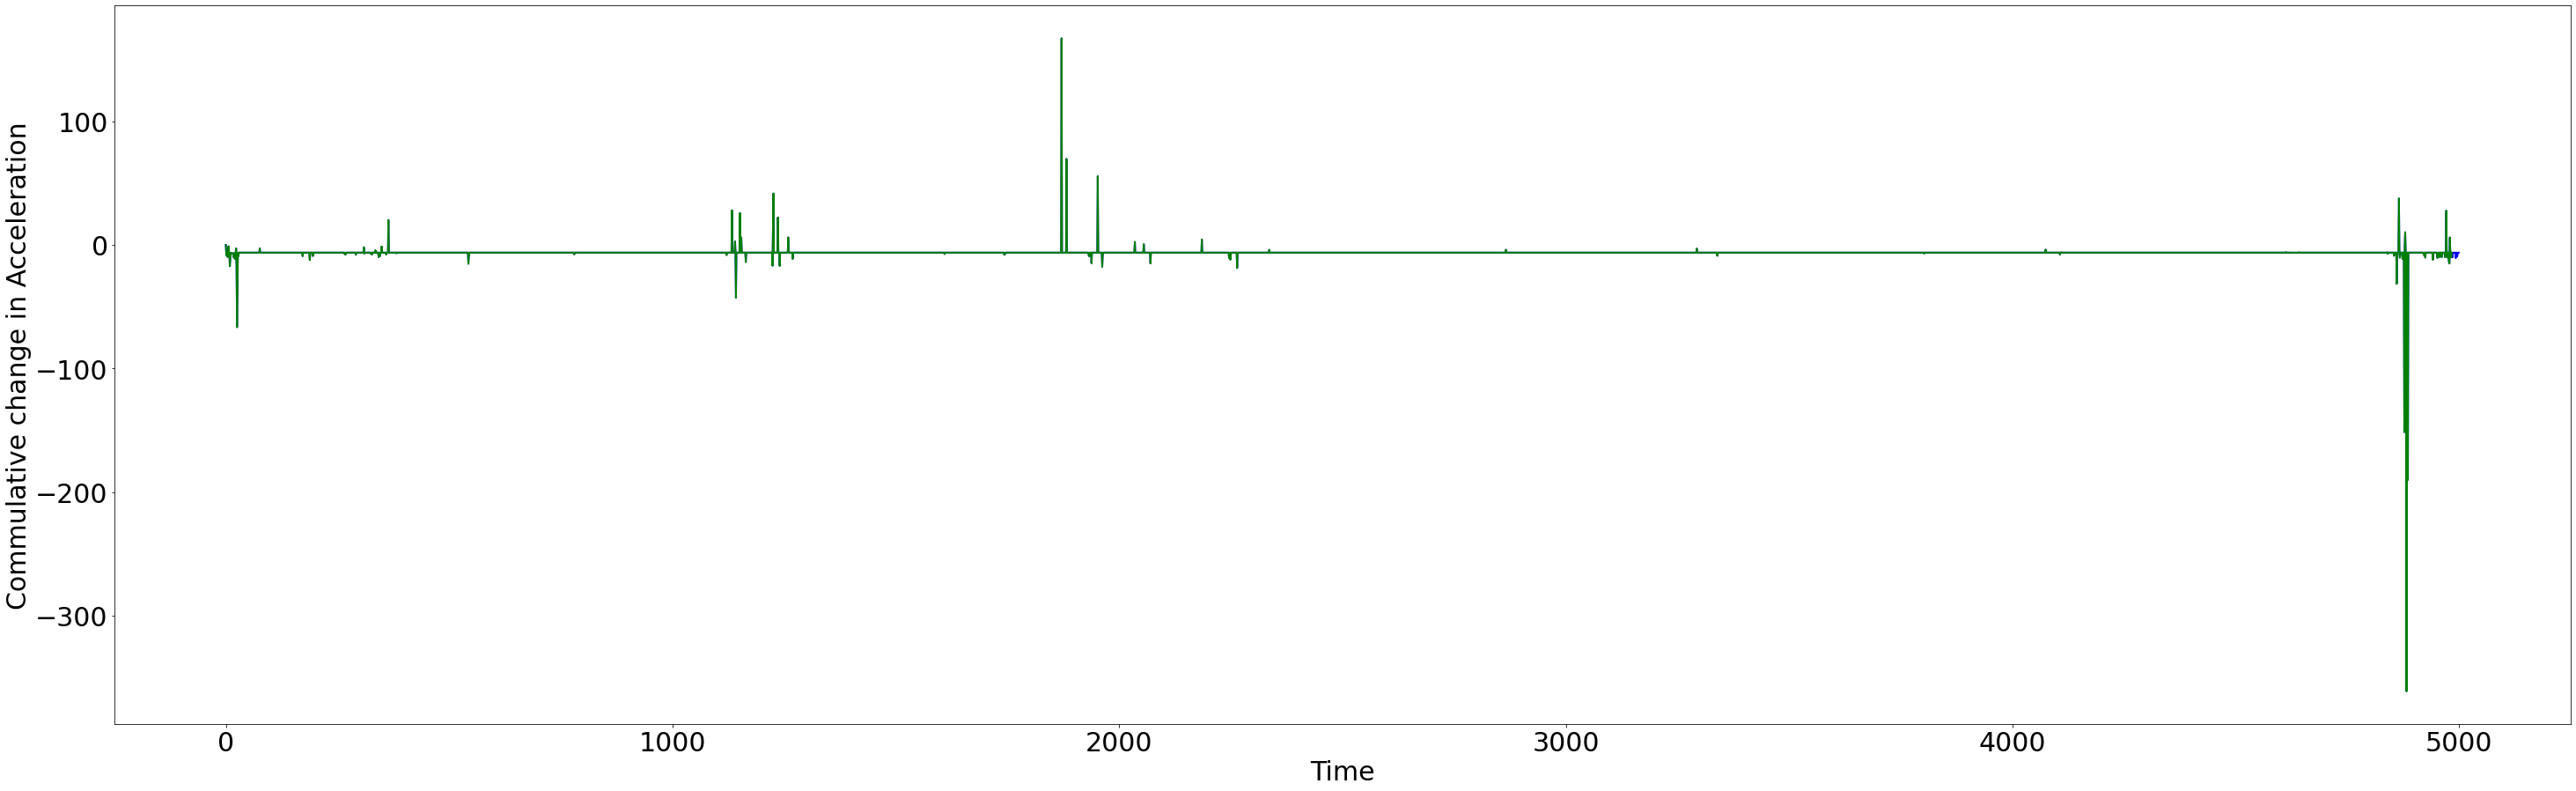

In [ ]:
##plot for Cz
plt.plot(Cwx)
plt.plot(history)

plt.xlabel("Time")
plt.ylabel("Commulative change in Acceleration")
plt.show()

In [ ]:
### grid search for cumwy
scores = grid_search(Cwy, cfg_list, n_test)
print('done')

 > Model[[(1, 0, 0), (0, 0, 0, 0), 'n']] 2.627
 > Model[[(1, 1, 0), (0, 0, 0, 0), 'n']] 0.000
 > Model[[(0, 0, 0), (0, 0, 0, 0), 'n']] 5.590
 > Model[[(0, 1, 0), (0, 0, 0, 0), 'n']] 0.000
 > Model[[(0, 0, 1), (0, 0, 0, 0), 'n']] 4.148
 > Model[[(0, 1, 1), (0, 0, 0, 0), 'n']] 0.000
 > Model[[(1, 1, 1), (0, 0, 0, 0), 'n']] 0.000
 > Model[[(1, 0, 1), (0, 0, 0, 0), 'n']] 0.210
done


In [ ]:
# list top 3 configs
for cfg, error in scores[:3]:
    print(cfg, error)

[(0, 1, 0), (0, 0, 0, 0), 'n'] 0.0
[(1, 1, 0), (0, 0, 0, 0), 'n'] 0.0
[(1, 1, 1), (0, 0, 0, 0), 'n'] 4.440892098500626e-15


In [ ]:
cfg = [(1, 0, 1), (0, 0, 0, 0), 'n']

In [ ]:
l=5000
Cwy = df['cumwy'].values[:l]

In [ ]:
history = walk_forward_validations(Cwy, 10, cfg)

6, -9.41, 4.613926729365339
7, -4.69, -4.991831291555963
8, -4.69, -4.9554886945596595
9, -12.24, -4.952859300415356
10, 2.18, -9.910989079291392
11, -3.9, -4.007005220491747
12, -4.25, -3.899810949545153
13, -4.08, -3.9254269073725863
14, -4.26, -3.9015896834473542
15, -4.34, -3.929658012396974
16, -4.09, -3.9727432442162223
17, -4.5, -3.953484721248567
18, -2.97, -4.025489223228403
19, -6.4, -3.782688566193965
20, -4.35, -4.225277675162828
21, -0.84, -4.2327438356405915
22, -12.64, -3.6282871426304557
23, 3.89, -5.114898859624648
24, 27.27, -3.524535950212377
25, -5.68, 11.978406439180093
26, -5.3, -5.761129863551703
27, -5.58, 2.62509713978435
28, -0.31, -2.618110608297698
29, -4.3, 1.3813168461865921
30, -5.58, -1.507456254643794
31, -5.58, -0.34861670271820167
32, -5.58, -1.1336805685948443
33, -5.58, -0.8388774656347904
34, -5.58, -1.0758849866253264
35, -5.58, -1.032365610973119
36, -5.58, -1.1206659999429815
37, -5.58, -1.1473861824904656
38, -5.58, -2.4867362653578127
39, -5.5

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


169, -5.58, -6.110553782180394
170, -5.58, -6.108803030515605
171, -5.58, -6.107093681713096
172, 8.76, -6.1048659522882645
173, -5.58, -5.0972148432601845
174, -5.58, -5.144364745053186
175, -5.58, -5.183922033466809
176, -5.58, -5.218821991993565
177, -5.58, -5.2503237015360344
178, -5.58, -5.278122364288224
179, -5.58, -5.304445112771043
180, -5.58, -5.327274559267823
181, -5.58, -5.34822156078994
182, -5.58, -5.368431483266893


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


183, -5.58, -5.38598137950296
184, -5.58, -5.402964496341421
185, -5.58, -5.418713152125348
186, -5.58, -5.434446800059186
187, -5.58, -5.447340294555921
188, 2.98, -5.460791199961078
189, -5.58, -5.022426596398247
190, -5.58, -5.060361875522266
191, -5.58, -5.0939448528152935
192, -5.58, -5.1252371828280205
193, -5.58, -5.154318284191085
194, -5.58, -5.181162542790171
195, -4.11, -5.205863331707579
196, -5.58, -5.154042097822337
197, -5.58, -5.179845624740608
198, -5.58, -5.20435332771287
199, -5.58, -5.227438656966578
200, -5.58, -5.247746450442701
201, -5.58, -5.267714901633231
202, -5.58, -5.286853700388375
203, -5.58, -5.304752761269646
204, -5.58, -5.3214917837269216
205, -5.58, -5.337598040508765
206, -5.58, -5.352925239182968
207, -5.58, -5.367569372609966
208, -5.58, -5.381507150660777
209, -5.58, -5.3955126545533085
210, -5.58, -5.407681721166873


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


211, -5.58, -5.419720397357431
212, -5.58, -5.43163278041638
213, -5.58, -5.442909443726669
214, -5.58, -5.453410830071289
215, -5.58, -5.463642532280429
216, -5.58, -5.473748638960608
217, -5.58, -5.483160276340895
218, -5.58, -5.492260970313489
219, -5.58, -5.500755924765714
220, -5.58, -5.509226886435018
221, -5.58, -5.517290494079747
222, -5.58, -5.5249972024036795
223, -5.58, -5.532482357038044
224, -5.58, -5.539596157704392
225, -5.58, -5.5464633417413784
226, -5.58, -5.553094850377458
227, -5.58, -5.559334529427798
228, -5.58, -5.566072285460315
229, -5.58, -5.571533958675355
230, -5.58, -5.577390806544657


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


231, -5.58, -5.582478140452545
232, -5.58, -5.5879405415142545
233, -5.58, -5.5927447655935625
234, -5.58, -5.597528486380314
235, -5.58, -5.602748918402158
236, -5.58, -5.606610363467874
237, -5.58, -5.611668147877541
238, -5.58, -5.615034157593539
239, -5.58, -5.618942245514506
240, -5.58, -5.62280954818857
241, -5.58, -5.626396602247088
242, -5.58, -5.62997452805177
243, -5.58, -5.633264814592009
244, -5.58, -5.636652490587814
245, -5.58, -5.639601361109062
246, -5.58, -5.642818129723964
247, -5.58, -5.645452329804221
248, -5.58, -5.648157684425938
249, -5.58, -5.651010117294015


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


250, -5.58, -5.653465314446357
251, -5.58, -5.65571927609101
252, -5.58, -5.658049119406481
253, -5.58, -5.660283498475909
254, -5.58, -5.662417935111232
255, -5.58, -5.6641189077419964
256, -5.58, -5.6671116579624305
257, -5.58, -5.668279302296789
258, -5.58, -5.670076534836405
259, -5.58, -5.6717612683616485
260, -5.58, -5.6734125425144075
261, -5.58, -5.67498480117992
262, -5.58, -5.676467860793428
263, -5.58, -5.677841448153063
264, -5.58, -5.679252122403099
265, -5.58, -5.680534866232527
266, -11.46, -5.681773048773682
267, -5.58, -5.901137568542207
268, 4.11, -5.894616993144669


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


269, -5.58, -5.546977119892908
270, -5.58, -5.552123472487974
271, -5.58, -5.557546706218239
272, -5.58, -5.562529361186546
273, -5.58, -5.5675321223553675
274, -5.58, -5.57245292076756


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


275, -5.58, -5.5767950744705
276, -5.58, -5.581366627258903


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


277, -5.58, -5.585981247379439
278, -5.58, -5.590350897048332
279, -5.58, -5.593550103621597
280, -5.58, -5.597406561580337
281, -5.58, -5.601336818024144
282, -5.58, -5.6046747148940845
283, -5.58, -5.607936273155255
284, -5.58, -5.611971024012893


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


285, -5.58, -5.614600242586664
286, -5.58, -5.617571655183384
287, -5.58, -5.62077858525433
288, -5.58, -5.623496656129477
289, -5.58, -5.626283530441626
290, -5.58, -5.628746143689822
291, -3.43, -5.632070312291135
292, -5.58, -5.559858424442451
293, -5.58, -5.564169324193812
294, -5.58, -5.568834132665987
295, -5.58, -5.57344216951863
296, -5.58, -5.577223184983556
297, -5.58, -5.581597175601426
298, -5.58, -5.585046200581412
299, -5.58, -5.589060670490044
300, -5.58, -5.592395397791397
301, -5.58, -5.595786762207756
302, -5.58, -5.599390725021986
303, -5.58, -5.602434283222091
304, -5.58, -5.6055674401700815
305, -5.58, -5.608548601774237
306, -5.58, -5.611466112715613
307, -5.58, -5.614280992720248
308, -5.58, -5.617221383285744
309, -50.12, -5.619680684666869
310, 5.89, -6.374038372840751
311, -5.58, -6.196776292427874
312, -5.58, -6.194409476040879
313, -5.58, -6.192640340525871
314, -5.58, -6.186672715156597
315, -5.58, -6.185078225375112
316, -5.58, -6.180210127752863


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


317, -5.58, -6.177091564342851
318, -5.58, -6.17772885427796
319, -5.58, -6.1709033558836435
320, -5.58, -6.169908239683734
321, -5.58, -6.164982335605228
322, -5.58, -6.161917310076687
323, -5.58, -6.162693589745089
324, -4.24, -6.15707351611987
325, -5.58, -6.134675152732397
326, -5.58, -6.132245314508085
327, -3.05, -6.129676319573617
328, -5.58, -6.092091101568508
329, -5.58, -6.089918060825237
330, -5.58, -6.0876156190783135
331, -5.58, -6.086925034278289
332, -5.58, -6.083401091414498
333, -5.58, -6.081270990619497
334, -5.58, -6.078934919498192
335, 2.96, -6.078342980837701
336, -5.58, -5.962634976926467
337, -5.58, -5.961231698349518
338, -5.58, -5.96038259270686


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


339, -5.58, -5.962683008633332


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


340, -5.58, -5.958132340168043
341, -5.58, -5.956955883460374
342, -1.28, -5.956233126722706
343, -5.58, -5.900390918988812
344, -5.75, -5.901211643611268
345, 3.86, -5.901381369698099
346, -5.58, -5.784021185470967
347, -5.58, -5.7843269490555125
348, -5.58, -5.784639454323648
349, -4.08, -5.7851765185660415
350, -5.58, -5.767158293367585
351, -5.58, -5.767581934824236
352, -5.58, -5.771690610033148
353, -5.58, -5.7683740624099284
354, -5.58, -5.768779071011734
355, -5.58, -5.769266709689687
356, -5.58, -5.7695465238750945
357, -5.58, -5.769922197148205
358, -5.58, -5.7702773837962775
359, -3.48, -5.772290472925724
360, -5.58, -5.74757060726105
361, -5.58, -5.747214356899748
362, -5.58, -5.747531848697405
363, -5.58, -5.748028454668149
364, 6.69, -5.748828296055774
365, -5.58, -5.610461649769416
366, -5.58, -5.613997587327054
367, -5.58, -5.612506374709207
368, -5.58, -5.613835119566906
369, -5.58, -5.615227267844967
370, -5.58, -5.6178719069841945
371, -5.58, -5.61823679850288


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


372, -5.58, -5.621976935337613
373, -5.58, -5.62282190071509
374, -5.58, -5.622081405306939
375, -5.58, -5.625248717127503
376, -5.58, -5.624803002180395
377, -5.58, -5.627875959477627
378, -5.58, -5.627236054870115
379, -5.58, -5.630299130564165
380, -5.58, -5.629839661716082
381, -5.58, -5.630873889936704
382, -3.24, -5.632498407532319
383, -5.58, -5.608256386582823
384, -5.58, -5.60960421553726


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


385, -5.58, -5.615822350860607
386, -5.58, -5.612246125290207


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


387, -5.58, -5.613631586269592
388, -5.58, -5.614960020739573
389, -5.58, -5.616108794636988
390, -5.58, -5.618623846830218
391, -5.58, -5.618878890249072
392, -5.58, -5.620048561680848
393, -5.58, -5.622207344897642
394, -5.58, -5.622705258628646
395, -5.58, -5.623542897591207
396, -5.58, -5.625067402647966
397, -5.58, -5.626440847197784
398, -5.58, -5.630607678854799
399, -5.58, -5.62810917960221
400, -5.58, -5.629294450197017
401, -5.58, -5.630299484902691
402, -5.58, -5.633252501286831
403, -5.58, -5.632555230017628
404, -5.58, -5.635019403409663
405, -5.58, -5.634847734276778
406, -5.58, -5.636316896015536
407, -5.58, -5.636897971908262
408, -5.58, -5.637903775354473
409, -5.58, -5.640232855294398
410, -5.58, -5.640199895801143
411, -5.58, -5.642528519318332
412, -5.58, -5.642573441772943


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


413, -5.58, -5.646441477601677
414, -5.58, -5.644880235194096
415, -5.58, -5.644814961549773
416, -5.58, -5.646384222998584
417, -5.58, -5.646768268406291
418, -5.58, -5.647782742759343
419, -5.58, -5.648524952542001
420, -5.58, -5.649510036112682
421, -5.58, -5.6505427532121155
422, -5.58, -5.652794496151423
423, -5.58, -5.65415613931473
424, -5.58, -5.653142883916199
425, -5.58, -5.653877148210101
426, -5.58, -5.656659176529929
427, -5.58, -5.655865951154381
428, -5.58, -5.659971345175904
429, -5.58, -5.657186964635542
430, -5.58, -5.658005643583302
431, -5.58, -5.6640108340243325
432, -5.58, -5.660178935393046
433, -5.58, -5.6604911216485325
434, -5.58, -5.66123165122127


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


435, -5.58, -5.664146720764257
436, -5.58, -5.663188123472926
437, -5.58, -5.663486993868481
438, -5.58, -5.664548621752392
439, -5.58, -5.667148235287159
440, -5.58, -5.669624705010755
441, -5.58, -5.667186016976097
442, -5.58, -5.667148989497668
443, -5.58, -5.672066692441489
444, -5.58, -5.668540870151632
445, -5.58, -5.669238382003074
446, -5.58, -5.6741640700801845
447, -5.58, -5.6705891641972395
448, -5.58, -5.671256376094798
449, -5.58, -5.6720339313424715


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


450, -5.58, -5.6726150001408575
451, -5.58, -5.676810892431226


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


452, -5.58, -5.6740769978238506


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


453, -5.58, -5.675368498933891
454, -5.58, -5.675272781877191
455, -5.58, -5.675906236115972
456, -5.58, -5.676372017308396
457, -5.58, -5.677148800883408
458, -5.58, -5.6799787976905325
459, -5.58, -5.67816946895807
460, -5.58, -5.6790217770394875
461, -5.58, -5.67983787564433
462, -5.58, -5.6807086630887005
463, -5.58, -5.680476982628719
464, -5.58, -5.681039894870151
465, -5.58, -5.6815944533771
466, -5.58, -5.682182885711117
467, -5.58, -5.683265697002177
468, -5.58, -5.683231289647262


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


469, -5.58, -5.684692415132722
470, -5.58, -5.684370368385319
471, -5.58, -5.684809966583286
472, -5.58, -5.685572575759785
473, -5.58, -5.6858879866333965
474, -5.58, -5.6863722504200815
475, -5.58, -5.692931265615539
476, -5.58, -5.687366965325718


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


477, -5.58, -5.687973401166179
478, -5.58, -5.688968983106498
479, -5.58, -5.692526880348607
480, -5.58, -5.689470132612342
481, -5.58, -5.690300506527448
482, -5.58, -5.690168079116791
483, -5.58, -5.692770306706819
484, -5.58, -5.691402816320021
485, -5.58, -5.6916353108433535
486, -5.58, -5.692159793150864
487, -5.58, -5.684787340030491
488, -5.58, -5.69282521776521
489, -5.58, -5.694748401980342


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


490, -5.58, -5.697742545317309
491, -5.58, -5.694313237167558
492, -5.58, -5.700612291525147
493, -5.58, -5.694943892083035
494, -5.58, -5.696129791180947
495, -5.58, -5.69571388324318
496, -5.58, -5.697112818136587
497, -5.58, -5.696500281657805
498, -5.58, -5.697148666067708
499, -5.58, -5.699443780837976
500, -5.58, -5.698528363760395
501, -5.58, -5.698048697460574
502, -5.58, -5.6985277443751565
503, -5.58, -5.698734352023801


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


504, -5.58, -5.699097032227209


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


505, -5.58, -5.6994682311201
506, -5.58, -5.700858585604837
507, -5.58, -5.70049373950714
508, -5.58, -5.705833691238366
509, -5.58, -5.7008388491952395
510, -5.58, -5.704186624993104


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


511, -5.58, -5.701539236868928
512, -5.58, -5.702803633436481
513, -5.58, -5.703043219262788
514, -5.58, -5.703371290283845
515, -5.58, -5.702998933107966
516, -5.58, -5.703719649684003
517, -5.58, -5.7019360934641
518, -5.58, -5.705376910664969
519, -5.58, -5.704596909211981


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


520, -5.58, -5.705431432568972
521, -5.58, -5.704606149869576
522, -5.58, -5.70490999845533
523, -5.58, -5.711222565219149
524, -5.58, -5.712058367363671
525, -5.58, -5.7129083176267725
526, -5.58, -5.70609380416784
527, -5.58, -5.706306523508249
528, -5.58, -5.70897916903457
529, -5.58, -5.707136853624364
530, -5.58, -5.707102143410555
531, -5.58, -5.707424249182481
532, -5.58, -5.7084721730492465
533, -5.58, -5.707890457827974


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


534, -5.58, -5.709457466518244
535, -5.58, -5.708378488118956
536, -5.58, -5.708686855445525
537, -5.58, -5.7091269302035546
538, -5.58, -5.709111742032352
539, -5.58, -5.709343821094545
540, -5.58, -5.712580929974913
541, -5.58, -5.710464558907693
542, -5.58, -5.710038910553292
543, -23.6, -5.711737446062825
544, -6.42, -5.850037552882693
545, -5.58, -5.8566586331203005
546, -5.58, -5.861073508538264
547, -5.58, -5.86159175899849
548, -5.58, -5.855212208726587
549, -5.58, -5.854379635425207
550, -5.58, -5.853324779933524


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


551, -5.58, -5.853002991163492
552, -5.58, -5.852342764092797
553, -5.58, -5.852181722736255
554, -5.58, -5.851719364592531
555, -5.58, -5.850858832099992
556, -5.58, -5.851205862654466
557, -5.58, -5.850332595420592
558, -5.58, -5.8496205886638215
559, -5.58, -5.849662312686931
560, -5.58, -5.848555104224201
561, -5.58, -5.854138647416666
562, -5.58, -5.847495135862792
563, -5.58, -5.847213692091182
564, -5.58, -5.853437837475747
565, -5.58, -5.848722595567053
566, -5.58, -5.848507228034049
567, -5.58, -5.845332599998164
568, -5.58, -5.844904926001244
569, -5.58, -5.845791625391832
570, -5.58, -5.843765396115146
571, -5.58, -5.84330131396396
572, -5.58, -5.844434119075389
573, -5.58, -5.842344379378869
574, -5.58, -5.847933601469478


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


575, -5.58, -5.841936225882994
576, -5.58, -5.840980372603681
577, -5.58, -5.845198618721517
578, -5.58, -5.840303185579993
579, -5.58, -5.839899984891341
580, -5.58, -5.839334445173073
581, -5.58, -5.838811656512021
582, -5.58, -5.8389309058197005
583, -5.58, -5.837935445458953
584, -5.58, -5.837502981332535
585, -5.58, -5.836975055439264
586, -5.58, -5.836685723736879
587, -5.58, -5.836212266653671
588, -5.58, -5.836768068990853
589, -5.58, -5.836476730864379
590, -5.58, -5.834804122519918
591, -5.58, -5.8348449202082415
592, -5.58, -5.834229507211312
593, -5.58, -5.833814030637316
594, -5.58, -5.833230897993032
595, -5.58, -5.8327668637374295
596, -5.58, -5.839798217582422
597, -5.58, -5.834291735936163
598, -5.58, -5.831677859441488
599, -5.58, -5.835786334716737
600, -5.58, -5.830662159974191
601, -5.58, -5.831710656359184


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


602, -5.58, -5.830907888946448
603, -5.58, -5.835178282575887
604, -5.58, -5.828951499387895
605, -5.58, -5.829674274111812
606, -5.58, -5.828391344280274
607, -5.58, -5.831696749123533
608, -5.58, -5.832211764121219
609, -5.58, -5.828683288920295


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


610, -5.58, -5.826488104760067
611, -5.58, -5.826296867254903
612, -5.58, -5.831168699057255
613, -5.58, -5.828475660712251
614, -5.58, -5.825341321967885
615, -5.58, -5.8253189727450705
616, -5.58, -5.824098157995597
617, -5.58, -5.823700618375944
618, -5.58, -5.8233067679871535
619, -5.58, -5.823646091310492
620, -5.58, -5.826536547272041
621, -5.58, -5.822973650285319
622, -5.58, -5.821766863386803
623, -5.58, -5.824956951075894
624, -5.58, -5.820289848742924
625, -5.58, -5.8244480586356655
626, -5.58, -5.827036477058939
627, -5.58, -5.819906555230625


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


628, -5.58, -5.826557636183273
629, -5.58, -5.824702926536105


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


630, -5.58, -5.820499634880251
631, -5.58, -5.818862653496197
632, -5.58, -5.81833056753302
633, -5.58, -5.821823685051562
634, -5.58, -5.822809161163558
635, -5.58, -5.822276434535441
636, -5.58, -5.819158830651013
637, -5.58, -5.82345728772971
638, -5.58, -5.814898636885769
639, -5.58, -5.815345112658468


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


640, -5.58, -5.815111873692886


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


641, -5.58, -5.815642902536244
642, -5.58, -5.816019426314956
643, -5.58, -5.820136392467465
644, -5.58, -5.81447075883141
645, -5.58, -5.819323617638769
646, -5.58, -5.815762024353687
647, -5.58, -5.81264160232288
648, -5.58, -5.81212639771543


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


649, -5.58, -5.812832944984053
650, -5.58, -5.8138795967548145


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


651, -5.58, -5.811587350969157
652, -5.58, -5.814587146135306
653, -5.58, -5.816008340757795
654, -5.58, -5.815152948706233
655, -5.58, -5.813784125280467


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


656, -5.58, -5.813835549511502
657, -5.58, -5.814148584106483
658, -5.58, -5.813342397022017
659, -5.58, -5.8085329394899565
660, -5.58, -5.805809673296792
661, -5.58, -5.8082660545778095
662, -5.58, -5.815587231629205
663, -5.58, -5.809967805286027
664, -5.58, -5.8101495923972415
665, -5.58, -5.806238333516674


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


666, -5.58, -5.808189585278716
667, -5.58, -5.8061951981206015
668, -5.58, -5.807909928681728
669, -5.58, -5.805869642548155
670, -5.58, -5.805310782693639
671, -5.58, -5.807555469834974
672, -5.58, -5.804636468220905
673, -5.58, -5.8124999668760315
674, -5.58, -5.805309214027364
675, -5.58, -5.800301746734047
676, -5.58, -5.807341008614553


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


677, -5.58, -5.804165486191438
678, -5.58, -5.806090502238626
679, -5.58, -5.801653262498027
680, -5.58, -5.8012246902042275
681, -5.58, -5.802239988772037
682, -5.58, -5.801312313853141
683, -5.58, -5.807450685164078
684, -5.58, -5.805345832009003
685, -5.58, -5.800350499551422
686, -5.58, -5.799512942196243
687, -5.58, -5.803777977354957
688, -5.58, -5.803403293193245
689, -5.58, -5.798305410638951


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


690, -5.58, -5.802538147286656
691, -5.58, -5.797676974027585
692, -5.58, -5.805972585144589


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


693, -5.58, -5.799295837117805
694, -5.58, -5.796219026479653
695, -5.58, -5.7974341009367185
696, -5.58, -5.79708110056015
697, -5.58, -5.7995756119647925
698, -5.58, -5.795265614210538
699, -5.58, -5.796608052488814
700, -5.58, -5.79641393379741


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


701, -5.58, -5.7952947664767285


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


702, -5.58, -5.80249170995307
703, -5.58, -5.7953549343874275
704, -5.58, -5.79659910895023
705, -5.58, -5.79883665507721
706, -5.58, -5.794840425996845
707, -5.58, -5.794053101868422
708, -5.58, -5.792429620019363
709, -5.58, -5.797200634315426
710, -5.58, -5.791815911862882
711, -5.58, -5.797058326320245


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


712, -5.58, -5.791370068212818
713, -5.58, -5.79098254142599


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


714, -5.58, -5.791025340663563
715, -5.58, -5.7871259515189175
716, -5.58, -5.79074818385028
717, -5.58, -5.795074285491872
718, -5.58, -5.7903673987897815


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


719, -5.58, -5.787965303935971
720, -5.58, -5.788860084000487
721, -5.58, -5.795329210623211
722, -5.58, -5.7891318639289775
723, -5.58, -5.789205377025997
724, -5.58, -5.787769011585423
725, -5.58, -5.7874203156404365
726, -5.58, -5.788246257088282
727, -5.58, -5.788340763637316
728, -5.58, -5.795195431269445
729, -5.58, -5.786857912686153
730, -5.58, -5.786375619853544
731, -5.58, -5.78693849289161
732, -5.58, -5.793780703029194
733, -5.58, -5.786570010563001
734, -5.58, -5.79045484485958
735, -5.58, -5.78549096697853
736, -5.58, -5.787330453527862
737, -5.58, -5.784167038825953
738, -5.58, -5.785778405159925
739, -5.58, -5.787285608543308
740, -5.58, -5.786754963491895
741, -5.58, -5.785226991173937
742, -5.58, -5.784505125399534
743, -5.58, -5.782403206420325


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


744, -5.58, -5.782265162914239


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


745, -5.58, -5.783925204970532
746, -5.58, -5.782441650906005


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


747, -5.58, -5.781236938284363
748, -5.58, -5.787247092184599
749, -5.58, -5.78420570484564
750, -5.58, -5.7862729072065235
751, -5.58, -5.7858473969667745
752, -5.58, -5.784085550519241
753, -5.58, -5.778336519175544
754, -5.58, -5.780002818226175
755, -5.58, -5.77949687349713
756, -5.58, -5.780545753476143


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


757, -5.58, -5.784121425363163
758, -5.58, -5.778304265253823
759, -5.58, -5.785706490958541
760, -5.58, -5.782734575846721
761, -5.58, -5.7750540489840345
762, -5.58, -5.777258852029584
763, -5.58, -5.777612295255143


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


764, -5.58, -5.776729474359971
765, -5.58, -5.782789661416056
766, -5.58, -5.782163551349597
767, -5.58, -5.776189013420641
768, -5.58, -5.775954314367336


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


769, -5.58, -5.776729936083654
770, -5.58, -5.77729289974193
771, -5.58, -5.773821170224583
772, -5.58, -5.774711672756956
773, -5.58, -5.7774571492050955
774, -5.58, -5.784792434123125


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


775, -5.58, -5.780380641635742
776, -5.58, -5.778838025642419
777, -5.58, -5.774867484934194


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


778, -5.58, -5.774282925850719
779, -5.58, -5.772845106517611


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


780, -3.31, -5.778361949336317
781, -5.58, -5.764436252903165
782, -5.58, -5.765078611235818
783, -5.58, -5.756741526271345
784, -5.58, -5.757849180037874
785, -5.58, -5.762608318397603


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


786, -5.58, -5.75520178521857


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


787, -5.58, -5.756000616437401


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


788, -5.58, -5.7620127508289345
789, -5.58, -5.762976249614238
790, -5.58, -5.761167698528084
791, -5.58, -5.760235540116587
792, -5.58, -5.767659536749406
793, -5.58, -5.762936264395869
794, -5.58, -5.757593565501624
795, -5.58, -5.753483919162904


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


796, -5.58, -5.760203217598706
797, -5.58, -5.757262400633292
798, -5.58, -5.757507997894859
799, -5.58, -5.760906191714028
800, -5.58, -5.756962774924079
801, -5.58, -5.765262257065507
802, -5.58, -5.7584175541596005


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


803, -5.58, -5.7514245418593015
804, -5.58, -5.757019842676964
805, -5.58, -5.752105431127147
806, -5.58, -5.755274900493134


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


807, -5.58, -5.752448499459681
808, -5.58, -5.753092572455267
809, -5.58, -5.755164875921417
810, -5.58, -5.759739525702129
811, -5.58, -5.756488224220283
812, -5.58, -5.753927646710915


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


813, -5.58, -5.758795980577677
814, -5.58, -5.758920865773784
815, -5.58, -5.756352387095603
816, -5.58, -5.7572105650252485
817, -5.58, -5.752936661057091
818, -5.58, -5.754123620348353
819, -5.58, -5.762085992080092
820, -5.58, -5.755889573213384
821, -5.58, -5.753932858810212
822, -5.58, -5.753809851923332
823, -5.58, -5.752323137841842
824, -5.58, -5.754799727071032
825, -5.58, -5.759019455914496
826, -5.58, -5.759341556915626
827, -5.58, -5.750989350809229
828, -5.58, -5.746457719635005


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


829, -5.58, -5.756179329913287


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


830, -5.58, -5.750781308518663
831, -5.58, -5.760819128808243
832, -5.58, -5.752966161750977
833, -5.58, -5.747557332758769
834, -5.58, -5.751659906167662
835, -5.58, -5.746060212915729
836, -5.58, -5.746053053522976


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


837, -5.58, -5.749530462059182


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


838, -5.58, -5.74896963584575
839, -5.58, -5.750809279798242
840, -5.58, -5.751158215590526
841, -5.58, -5.74570975714632


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


842, -5.58, -5.752372772485501
843, -5.58, -5.748602347387929


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


844, -5.58, -5.7510776845806975
845, -5.58, -5.749801595492592


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


846, -5.58, -5.75424466110826


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


847, -5.58, -5.747232054078726


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


848, -5.58, -5.756215438759012
849, -5.58, -5.747484418223091
850, -5.58, -5.749337509817491
851, -5.58, -5.74726635667689
852, -5.58, -5.751757532936123
853, -5.58, -5.744897084225741
854, -5.58, -5.746232227349722
855, -5.58, -5.745717630780334
856, -5.58, -5.746596146841548
857, -5.58, -5.7483956254261095
858, -5.58, -5.745203038773686
859, -5.58, -5.745036145223231
860, -5.58, -5.751353206034321
861, -5.58, -5.7444172032861776
862, -5.58, -5.743593574169433
863, -5.58, -5.747176987941209
864, -5.58, -5.7502599677771435
865, -5.58, -5.746399471123397


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


866, -5.58, -5.745874276403761
867, -5.58, -5.74142367038763
868, -5.58, -5.743471943263022
869, -5.58, -5.740927066733855
870, -5.58, -5.7483005321264
871, -5.58, -5.744776556688281
872, -5.58, -5.742337939828375
873, -5.58, -5.742824760518986
874, -5.58, -5.7449932058233255
875, -5.58, -5.7431174070366735
876, -5.58, -5.742304595983993


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


877, -5.58, -5.749503616990426
878, -5.58, -5.741575369191837
879, -5.58, -5.744820265703793
880, -5.58, -5.744340454185787
881, -5.58, -5.752148653684362
882, -5.58, -5.740953140669634


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


883, -5.58, -5.746736320662392
884, -5.58, -5.743076077570905
885, -5.58, -5.737182261807404
886, -5.58, -5.740644412973777
887, -5.58, -5.740267943116533
888, -5.58, -5.742416902746674
889, -5.58, -5.745755602735728
890, -5.58, -5.745917276827361
891, -5.58, -5.745105289610894
892, -5.58, -5.740976597259664
893, -5.58, -5.741217350020936
894, -5.58, -5.7387886394947865


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


895, -5.58, -5.741344918327634
896, -5.58, -5.73847262806946
897, -5.58, -5.743390661260423
898, -5.58, -5.742403037371917
899, -5.58, -5.744185963564559
900, -5.58, -5.7426042966695094
901, -5.58, -5.746028507860137
902, -5.58, -5.738170241427129
903, -5.58, -5.736430221047322
904, -5.58, -5.739446176890049
905, -5.58, -5.744746412847549
906, -5.58, -5.7376405789015275


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


907, -5.58, -5.738621272205939


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


908, -5.58, -5.73978794696113
909, -5.58, -5.735217866463068
910, -5.58, -5.736403909227421


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


911, -5.58, -5.735236602698985
912, -5.58, -5.733423355266472


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


913, -5.58, -5.741629488942695
914, -5.58, -5.73876613908982
915, -5.58, -5.738205880530751


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


916, -5.58, -5.737485279815196
917, -5.58, -5.738889547208482
918, -5.58, -5.731275684603996
919, -5.58, -5.732957237170693


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


920, -5.58, -5.73544387653709
921, -5.58, -5.737213502546264
922, -5.58, -5.730764150678813
923, -5.58, -5.744509547295583
924, -5.58, -5.739993576362145
925, -5.58, -5.738905164859402
926, -5.58, -5.739354611745445
927, -5.58, -5.737231783726977
928, -5.58, -5.734054526264402
929, -5.58, -5.7329456231347535
930, -5.58, -5.733581041649807
931, -5.58, -5.73281660389416
932, -5.58, -5.733401143973051
933, -5.58, -5.73787407019181


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


934, -5.58, -5.731928805062518
935, -5.58, -5.734254453569768
936, -5.58, -5.737233120080722
937, -5.58, -5.727830599038914
938, -5.58, -5.731904710197247
939, -5.58, -5.733715053685696


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


940, -5.58, -5.734656776177383
941, -5.58, -5.7270736136561355
942, -5.58, -5.737942636504339


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


943, -5.58, -5.728460529709291
944, -5.58, -5.730519207596399


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


945, -5.58, -5.7298416336132005


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


946, -5.58, -5.734442096419141
947, -5.58, -5.730632545338537
948, -5.58, -5.725600043229938
949, -5.58, -5.735694686322291
950, -5.58, -5.732447130506682
951, -5.58, -5.729537431137072
952, -5.58, -5.725062287918344
953, -5.58, -5.73759971638039


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


954, -5.58, -5.730182519179357
955, -5.58, -5.731473249189935


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


956, -5.58, -5.739758647788456
957, -5.58, -5.725522257175015


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


958, -5.58, -5.728052712083048
959, -5.58, -5.724028632564807
960, -5.58, -5.727702228475596


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


961, -5.58, -5.732830864629214
962, -5.58, -5.736199837851177
963, -5.58, -5.727615074083357


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


964, -5.58, -5.725620386349822
965, -5.58, -5.7394191969700925
966, -5.58, -5.728114465341838
967, -5.58, -5.736504904787896
968, -5.58, -5.726779443751942
969, -5.58, -5.731240029251835
970, -5.58, -5.726910986843661
971, -5.58, -5.736052389844047
972, -5.58, -5.732220352642496
973, -5.58, -5.737672480986124
974, -5.58, -5.726984145462924
975, -5.58, -5.724872712074632
976, -5.58, -5.725960100051402


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


977, -5.58, -5.726164123715376
978, -5.58, -5.721548885382303
979, -5.58, -5.727822871161544
980, -5.58, -5.73217913908039
981, -5.58, -5.725155556254355
982, -5.58, -5.732053487931044
983, -5.58, -5.725928439261015
984, -5.58, -5.725339765343342


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


985, -5.58, -5.724121516668376


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


986, -5.58, -5.7241020089646995
987, -5.58, -5.726949650739046
988, -5.58, -5.727222811675211
989, -5.58, -5.725481922601357
990, -5.58, -5.721950277808792
991, -5.58, -5.719397411539918
992, -5.58, -5.729717862611922
993, -5.58, -5.723427981182116
994, -5.58, -5.718887108702006
995, -5.58, -5.720108148024588


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


996, -5.58, -5.725187153530673
997, -5.58, -5.729133402006479
998, -5.58, -5.730909317129923
999, -5.58, -5.723365966519931


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1000, -5.58, -5.7344441075464925


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1001, -5.58, -5.72138011967044


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1002, -5.58, -5.723674404062474
1003, -5.58, -5.72161162854283


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1004, -5.58, -5.724322810126629
1005, -5.58, -5.723760968220386


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1006, -5.58, -5.721647873605523


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1007, -5.58, -5.721063945878984
1008, -5.58, -5.721421811455053
1009, -5.58, -5.72568467377245
1010, -5.58, -5.724635657045539
1011, -5.58, -5.720540032411672
1012, -5.58, -5.717517031642932
1013, -5.58, -5.7188538081395235
1014, -5.58, -5.721354649414012
1015, -5.58, -5.720712587882419
1016, -5.58, -5.731072862386471
1017, -5.58, -5.718942388039809
1018, -5.58, -5.719499477234444
1019, -5.58, -5.716312575902927


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1020, -5.58, -5.729391314598141
1021, -5.58, -5.726632105235666
1022, -5.58, -5.722390121342033
1023, -5.58, -5.713569022493044
1024, -5.58, -5.719545669301592
1025, -5.58, -5.713447585967432
1026, -5.58, -5.71563856928799
1027, -5.58, -5.724512646928433


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1028, -5.58, -5.7169366639928745
1029, -5.58, -5.718135761009861
1030, -5.58, -5.714588356982907
1031, -5.58, -5.718645919965075


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1032, -5.58, -5.718205754307619
1033, -5.58, -5.711189865922151
1034, -5.58, -5.712826461311586
1035, -5.58, -5.727621666456723
1036, -5.58, -5.717302010294267
1037, -5.58, -5.711316127328967
1038, -5.58, -5.720344154206809
1039, -5.58, -5.73041371571669
1040, -5.58, -5.714846712149803
1041, -5.58, -5.712424818045275
1042, -5.58, -5.712432765494093
1043, -5.58, -5.715995349594394
1044, -5.58, -5.711193461334433
1045, -5.58, -5.719281840229626
1046, -5.58, -5.719303846020925
1047, -5.58, -5.709910435784234
1048, -5.58, -5.728580328470846
1049, -5.58, -5.71562397995326


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1050, -5.58, -5.713039579354399
1051, -5.58, -5.71051904026393
1052, -5.58, -5.728307197312666


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1053, -5.58, -5.710126977539886
1054, -5.58, -5.719800298491379
1055, -5.58, -5.7144847984217595
1056, -5.58, -5.715690494371047
1057, -5.58, -5.710051782540453
1058, -5.58, -5.715114763551088
1059, -5.58, -5.712983576631204
1060, -5.58, -5.713766887507415


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1061, -5.58, -5.713607582695644
1062, -5.58, -5.709926472634386
1063, -5.58, -5.713402409482026
1064, -5.58, -5.7120103141912635
1065, -5.58, -5.715553028118329


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1066, -5.58, -5.70941579603129
1067, -5.58, -5.722798124200662
1068, -5.58, -5.708318859671368
1069, -5.58, -5.710442533526999
1070, -5.58, -5.707913345712065
1071, -5.58, -5.707908791987241
1072, -5.58, -5.712359302415198
1073, -5.58, -5.713154469050836


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1074, -5.58, -5.71186789702854
1075, -5.58, -5.708715346470631
1076, -5.58, -5.720121939122069
1077, -5.58, -5.711885792708678


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1078, -5.58, -5.711699354402783
1079, -5.58, -5.71930215977407
1080, -5.58, -5.7111891407706885
1081, -5.58, -5.70926689997755
1082, -5.58, -5.710827178805078
1083, -5.58, -5.709667444004804
1084, -5.58, -5.705722052926592
1085, -5.58, -5.704546892667462
1086, -5.58, -5.711828236511292
1087, -5.58, -5.710736865500146
1088, -5.58, -5.715362024524671
1089, -5.58, -5.70415638753933
1090, -5.58, -5.721086746074501
1091, -5.58, -5.703082020420875
1092, -5.58, -5.720087285070526
1093, -5.58, -5.709205882448268
1094, -5.58, -5.712855186590072
1095, -5.58, -5.713272910466807
1096, -5.58, -5.706094121250173
1097, -5.58, -5.702765782678633
1098, -5.58, -5.71486135732564


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1099, -5.58, -5.705204522467615
1100, -5.58, -5.709069020723386
1101, -5.58, -5.707746237957486
1102, -5.58, -5.707589456160297


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1103, -5.58, -5.7025857969708085


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1104, -5.58, -5.711074412796376
1105, -5.58, -5.712138589593352
1106, -5.58, -5.708979221554097
1107, -5.58, -5.701237865423295
1108, -5.58, -5.701650519511101
1109, -5.58, -5.700733126389133
1110, -5.58, -5.708855963446145
1111, -5.58, -5.703857324491987
1112, -5.58, -5.717882907549961
1113, -5.58, -5.716971158529122
1114, -5.58, -5.71327934391111
1115, -5.58, -5.720581553045225
1116, -5.58, -5.705926030441435
1117, -5.58, -5.709225733549507
1118, -5.58, -5.706337479132752
1119, -5.58, -5.704706891224652
1120, -5.58, -5.7139752638016175
1121, -3.31, -5.707122275550044


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1122, -5.58, -5.707977599175411
1123, -5.58, -5.691730224201293


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1124, -5.58, -5.691696189648252
1125, -5.58, -5.686030863511604
1126, -5.58, -5.705246172659028
1127, -5.58, -5.6979377139971366
1128, -5.58, -5.697599040586941


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1129, -5.58, -5.69964148246143
1130, -5.58, -5.697401217266176
1131, -5.58, -5.6937717682631215


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1132, -5.58, -5.691069289280521
1133, -51.82, -5.6845369168257145
1134, -5.58, -5.874352740549959
1135, -5.58, -5.864257605081609
1136, -5.58, -5.877589526639806


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1137, -5.58, -5.876934993963395
1138, -5.58, -5.87965540633312
1139, -5.58, -5.8641167723664545


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1140, -0.07, -5.874567801346257
1141, -5.58, -5.846186511913867
1142, -4.25, -5.84348431728632


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1143, -5.58, -5.8405883762970605
1144, -5.58, -5.83655073395936


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1145, -5.58, -5.839702903207439
1146, -5.58, -5.839756643936257
1147, -5.58, -5.849597933907712
1148, -5.58, -5.847976435538838
1149, -5.58, -5.847836753054073
1150, -5.58, -5.837953792163582


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1151, -7.04, -5.8371832313756356
1152, -5.58, -5.839911234649584
1153, -5.58, -5.838551679650901


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1154, -49.68, -5.839025740570264
1155, -5.58, -6.004914432336371
1156, -5.58, -6.011268817214353
1157, -5.58, -6.013646813244594
1158, -5.58, -5.994521293759984
1159, -5.58, -5.993701977980694
1160, -5.58, -6.005459804613861
1161, -5.58, -5.9992749981341165
1162, -5.58, -6.00800501332949
1163, -5.58, -6.003574596556873
1164, 10.08, -5.989604595288347
1165, -5.58, -5.946678746267104


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1166, -5.58, -5.940283203359508
1167, -5.58, -5.933288995848214
1168, -5.58, -5.936715484847708


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1169, -5.58, -5.939518312988717
1170, -5.58, -5.934981627019206


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1171, -5.58, -5.936457222261623
1172, -5.58, -5.937761917320956


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1173, -5.58, -5.930517398024994
1174, -5.58, -5.931959328285302


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1175, -5.58, -5.936414486858166


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1176, -5.58, -5.92562136041057


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1177, -5.58, -5.934172709401212
1178, -5.58, -5.926306364018653
1179, -5.58, -5.931080641250022
1180, -5.58, -5.924906292361053
1181, -5.58, -5.92754194193414
1182, -5.58, -5.920094069103664
1183, -5.58, -5.934857512948754


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1184, -5.58, -5.922636878372218
1185, -5.58, -5.9269814108126315
1186, -5.58, -5.92952604445825
1187, -5.58, -5.928033890488554
1188, -5.58, -5.921587439286748
1189, -5.58, -5.919336397579605
1190, -5.58, -5.92270184714843
1191, -5.58, -5.915998307634877
1192, -5.58, -5.916639571262763
1193, -5.58, -5.928150051633449
1194, -5.58, -5.915546048813448
1195, -5.58, -5.916393473353861
1196, -5.58, -5.929319218686526


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1197, -5.58, -5.912432889308082
1198, -5.58, -5.915535907560947
1199, -5.58, -5.916383943629667


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1200, -5.58, -5.916908575452833
1201, -5.58, -5.925078672449483
1202, -5.58, -5.924950196604696
1203, -5.58, -5.914317118795399


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1204, -5.58, -5.915150742751876
1205, -5.58, -5.91710647454476


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1206, -5.58, -5.912547208853674
1207, -5.58, -5.908503871536077
1208, -5.58, -5.920372757079493


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1209, -5.58, -5.919885104052385
1210, -5.58, -5.914537500966608
1211, -5.58, -5.915513289454431
1212, -5.58, -5.915843808464017


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1213, -5.58, -5.907814599009255
1214, -5.58, -5.918266233672695
1215, -5.58, -5.900317776613029


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1216, -5.58, -5.91648681450845
1217, -5.58, -5.9168529702927355
1218, -5.58, -5.905568561475005
1219, -5.58, -5.900305976366444
1220, -5.58, -5.9147745018002835
1221, -5.58, -5.896757299802166


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1222, -5.58, -5.912564708450999
1223, -5.58, -5.91102812884014


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1224, 9.8, -5.910705883402979
1225, 35.21, -5.85739376554077
1226, -45.94, -5.715279195798601


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1227, -5.58, -5.846623460508717
1228, -5.58, -5.844371015676455
1229, -5.58, -5.837683462504754
1230, -5.58, -5.83951495571528


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1231, -5.58, -5.84887947479525
1232, -5.58, -5.849443997302792
1233, -5.58, -5.842590668131595
1234, -5.58, -5.839181142947993
1235, -5.58, -5.844943771905763
1236, 2.31, -5.850506575926326


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1237, -5.58, -5.8081133786624815
1238, -5.58, -5.80739627068384
1239, -5.58, -5.820182978352919
1240, -2.04, -5.817105187258596
1241, -5.58, -5.802277991780965
1242, -5.58, -5.793755667702629
1243, -5.58, -5.7968288657045735
1244, -5.58, -5.794233355133201
1245, -5.58, -5.8082506252492445
1246, -5.58, -5.792717868291662
1247, -5.58, -5.8058170685850605
1248, -5.58, -5.791935274076423
1249, -5.58, -5.7984047220386445
1250, -5.58, -5.802697367466696
1251, -5.58, -5.804162268419703


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1252, -5.58, -5.804692396060695
1253, -5.58, -5.790337256934061


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1254, -5.58, -5.800982949360713
1255, -5.58, -5.8011241055741705
1256, -5.58, -5.789722944646167
1257, -5.58, -5.801978849844245
1258, -5.58, -5.78873433753206
1259, -9.18, -5.78831710908943
1260, -5.58, -5.814404458125917
1261, -5.58, -5.804910163166026
1262, -5.58, -5.81459921967036


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1263, -5.58, -5.810910609261887
1264, -5.58, -5.809797436407639
1265, -5.58, -5.803317658175468
1266, -5.58, -5.807650188771932
1267, -5.58, -5.806178502922194
1268, -5.58, -5.808374644989245
1269, 2.54, -5.811852762671039
1270, -5.58, -5.782717127763777
1271, -5.58, -5.770104483360161
1272, -5.58, -5.7800311592265885
1273, -5.58, -5.7839699300158784
1274, -5.58, -5.782687954500045
1275, -5.58, -5.780529304336301
1276, -5.58, -5.778405870564598
1277, -5.58, -5.779882336171614
1278, -5.58, -5.781847985487817
1279, -5.58, -5.767492066745527


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1280, -5.58, -5.767219779976885


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1281, -5.58, -5.767125626027478
1282, -5.58, -5.7692404216283695
1283, -5.58, -5.772680468323014


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1284, -5.58, -5.777612415848521
1285, -5.58, -5.7770618697202405
1286, -5.58, -5.7767256697003315
1287, -5.58, -5.773882683498861


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1288, -5.58, -5.774974691612044


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1289, -5.58, -5.768710515665126


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1290, -5.58, -5.776999492107918
1291, -5.58, -5.778821799835159
1292, -5.58, -5.765206385182692


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1293, -5.58, -5.778481903615727
1294, -5.58, -5.77623022137625
1295, -5.58, -5.776938864636936
1296, -5.58, -5.764918915055676
1297, -5.58, -5.763678348190947
1298, -5.58, -5.766611527750805


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1299, -5.58, -5.765975419656569
1300, -5.58, -5.761041727860362
1301, -5.58, -5.766158494877872
1302, -5.58, -5.761042058858472
1303, -5.58, -5.761854690427946
1304, -5.58, -5.77586461367643
1305, -5.58, -5.767865062490072
1306, -5.58, -5.761172993853151
1307, -5.58, -5.764974987832415


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1308, -5.58, -5.765730720570508
1309, -5.58, -5.771175231429023


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1310, -5.58, -5.773967823005889
1311, -5.58, -5.773471247480628
1312, -5.58, -5.759024205767699


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1313, -5.58, -5.768908120467316
1314, -5.58, -5.77265524277031
1315, -5.58, -5.756921015396616


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1316, -5.58, -5.756584900047405
1317, -5.58, -5.771659139604019
1318, -5.58, -5.772341802610484


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1319, -5.58, -5.757014526983236
1320, -5.58, -5.755761466644973
1321, -5.58, -5.7576419280697
1322, -5.58, -5.7717717865887455
1323, -5.58, -5.772207614280197
1324, -5.58, -5.767041314799234
1325, -5.58, -5.757596729018689
1326, -5.58, -5.7573912172455834
1327, -5.58, -5.7629071127205
1328, -5.58, -5.762365080763335
1329, -5.58, -5.767907242935856


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1330, -5.58, -5.763434532482764
1331, -5.58, -5.766933211806322


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1332, -5.58, -5.766003028477168


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1333, -5.58, -5.759946205669345
1334, -5.58, -5.751938188452782


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1335, -5.58, -5.753116971410684
1336, -5.58, -5.752737840019933
1337, -5.58, -5.752394172337508
1338, -5.58, -5.7533841363884415
1339, -5.58, -5.766587463370506
1340, -5.58, -5.766252243597044
1341, -5.58, -5.765835929556453
1342, -5.58, -5.765759799963878
1343, -5.58, -5.766175991471139
1344, -5.58, -5.765864481593071


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1345, -5.58, -5.765362900609061
1346, -5.58, -5.75435156948612
1347, -5.58, -5.762074084077284
1348, -5.58, -5.751396380272641
1349, -5.58, -5.752568225112377
1350, -5.58, -5.750282731461453


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1351, -5.58, -5.763580598270558
1352, -5.58, -5.760328992570889
1353, -5.58, -5.766735100745143
1354, -5.58, -5.748647590891742
1355, -5.58, -5.750121491675117
1356, -5.58, -5.763285583990385
1357, -5.58, -5.7632319448699025


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1358, -5.58, -5.7538257170690805
1359, -5.58, -5.754760061320229


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1360, -5.58, -5.754997661693812
1361, -5.58, -5.761977467393492


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1362, -5.58, -5.7502068277279275
1363, -5.58, -5.751363718845933
1364, -5.58, -5.749840693544395


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1365, -5.58, -5.746573568425122


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1366, -5.58, -5.756122330503111
1367, -5.58, -5.755866077592691
1368, -5.58, -5.75565242295598
1369, -5.58, -5.75548330178977
1370, -5.58, -5.75537662207245
1371, -5.58, -5.745510406313467
1372, -5.58, -5.7452881089303
1373, -5.58, -5.7513398011107935
1374, -5.58, -5.74840350154337


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1375, -5.58, -5.749155446712503
1376, -5.58, -5.745198968700548
1377, -5.58, -5.744514976243218
1378, -5.58, -5.753841436649003
1379, -5.58, -5.747773532866155
1380, -5.58, -5.745737878218902
1381, -5.58, -5.7513492199451335
1382, -5.58, -5.7576381634791085
1383, -5.58, -5.754504004608173
1384, -5.58, -5.750692329000666


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1385, -5.58, -5.752387564055256
1386, -5.58, -5.740363399493978


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1387, -5.58, -5.755681531525018
1388, -5.58, -5.739771811933486


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1389, -5.58, -5.738985542857771


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1390, -5.58, -5.742628324817965
1391, -5.58, -5.750483403961173
1392, -5.58, -5.750962846682289


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1393, -5.58, -5.751431839146083


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1394, -5.58, -5.751806578273773


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1395, -5.58, -5.752060910221806


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1396, -5.58, -5.752194254183983
1397, -5.58, -5.752220312429346
1398, -5.58, -5.752157356626372
1399, -5.58, -5.7520254118480505
1400, -5.58, -5.751840586702472
1401, -5.58, -5.7516171538781755
1402, -5.58, -5.751365971197483
1403, -5.58, -5.7510565522079045
1404, -5.58, -5.750805234571959


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1405, -5.58, -5.750530318911949


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1406, -5.58, -5.750242625549933
1407, -5.58, -5.749957374371736
1408, -5.58, -5.749675354857308


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1409, -5.58, -5.749400583245306
1410, -5.58, -5.749132784666248
1411, -5.58, -5.748870787859515
1412, -5.58, -5.748614284181506
1413, -5.58, -5.74836999014273
1414, -5.58, -5.748131398731293
1415, -5.58, -5.747899715340083


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1416, -5.58, -5.747675003393353


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1417, -5.58, -5.747449763863196


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1418, -5.58, -5.747175091395954


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1419, -5.58, -5.746905865408612


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1420, -5.58, -5.746641892307948
1421, -5.58, -5.746383523278645
1422, -5.58, -5.746129653758453
1423, -5.58, -5.74588597394111
1424, -5.58, -5.745647551226118
1425, -5.58, -5.745416659057556
1426, -5.58, -5.745193682642584
1427, -5.58, -5.744978341477172
1428, -5.58, -5.744772954123315


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1429, -5.58, -5.744575677249721
1430, -5.58, -5.744387453541061
1431, -5.58, -5.744208330432834


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1432, -5.58, -5.7440349969251265
1433, -5.58, -5.743873468982863
1434, -5.58, -5.74372117043133
1435, -5.58, -5.7435764485084535


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1436, -5.58, -5.743439062516009
1437, -5.58, -5.743308497713617
1438, -5.58, -5.74318407816374


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1439, -5.58, -5.743064492136828
1440, -5.58, -5.742948177237605


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1441, -5.58, -5.7428351173056305


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1442, -5.58, -5.742723920697181


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1443, -5.58, -5.7426137393087
1444, -5.58, -5.742500403770312
1445, -5.58, -5.7423954684158165
1446, -5.58, -5.742263736493367
1447, -5.58, -5.742137516753239
1448, -5.58, -5.742004357749546
1449, -5.58, -5.741863163809667
1450, -5.58, -5.74171309703108
1451, -5.58, -5.741553274641651


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1452, -5.58, -5.7413835055837374
1453, -5.58, -5.741203438695983


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1454, -5.58, -5.741014210819177


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1455, -5.58, -5.740816129322576
1456, -5.58, -5.740610266950954
1457, -5.58, -5.740398321579418
1458, -5.58, -5.740182181883215


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1459, -5.58, -5.739964074240733
1460, -5.58, -5.741412910471532
1461, -5.58, -5.741352239671076
1462, -5.58, -5.739290239251859
1463, -5.58, -5.735546218847825
1464, -5.58, -5.7324641807812355
1465, -5.58, -5.729648798314348


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1466, -5.58, -5.727672113420721
1467, -5.58, -5.726414623079999
1468, -5.58, -5.729768729589585
1469, -5.58, -5.736978149114762
1470, -5.58, -5.737781441019747
1471, -5.58, -5.738177302660398
1472, -5.58, -5.7337657938678115
1473, -5.58, -5.736377695430073
1474, -5.58, -5.738396205931293
1475, -5.58, -5.723914124871026
1476, -5.58, -5.722683165353534
1477, -5.58, -5.721946842623513


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1478, -5.58, -5.724701877006025
1479, -5.58, -5.723893990942029
1480, -5.58, -5.721216231610709


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1481, -5.58, -5.723989216729736


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1482, -5.58, -5.724252895259586
1483, -5.58, -5.736440003116161
1484, -5.58, -5.721388580099077
1485, -5.58, -5.72467338330437
1486, -5.58, -5.732636406138178


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1487, -5.58, -5.723142877111565
1488, -5.58, -5.722760053391959
1489, -5.58, -5.7225509483777115
1490, -5.58, -5.7225370043265835


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1491, -5.58, -5.736796996642891
1492, -5.58, -5.7233251174374065


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1493, -5.58, -5.722819788503129
1494, -5.58, -5.72759812196803


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1495, -5.58, -5.722129185970785
1496, -5.58, -5.721759298538126
1497, -5.58, -5.719176921628475


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1498, -5.58, -5.721459306757563
1499, -5.58, -5.719337059110048
1500, -5.58, -5.717336771300882
1501, -5.58, -5.71728329005509
1502, -5.58, -5.718606288615712
1503, -5.58, -5.717996943054227
1504, -5.58, -5.719736068164887
1505, -5.58, -5.721790799407744
1506, -5.58, -5.716063013639156
1507, -5.58, -5.7179854731617805


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1508, -5.58, -5.717280210791683
1509, -5.58, -5.725191776170022


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1510, -5.58, -5.726163700106537


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1511, -5.58, -5.722153694155241
1512, -5.58, -5.729539032883065
1513, -5.58, -5.721254917487719
1514, -5.58, -5.715983090591522
1515, -5.58, -5.71471481488995
1516, -5.58, -5.725808494828006
1517, -5.58, -5.714150301054584


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1518, -5.58, -5.7154098267907765
1519, -5.58, -5.721740494360017
1520, -5.58, -5.731587328648227
1521, -5.58, -5.719110979122425
1522, -5.58, -5.730610226250406
1523, -5.58, -5.7195170239341895
1524, -5.58, -5.71440023390132
1525, -5.58, -5.713459650822174


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1526, -5.58, -5.7276400375745515
1527, -5.58, -5.7271355410384786


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1528, -5.58, -5.72748611118863
1529, -5.58, -5.728345669159102
1530, -5.58, -5.72772079307827
1531, -5.58, -5.7299016039731185
1532, -5.58, -5.732578132229443


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1533, -5.58, -5.726000580566421
1534, -5.58, -5.727473636465499
1535, -5.58, -5.725659612634744


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1536, -5.58, -5.726614630048686
1537, -5.58, -5.727222936150344
1538, -5.58, -5.72500111985999
1539, -5.58, -5.726528503317271
1540, -5.58, -5.713046495864704
1541, -5.58, -5.725253408029906
1542, -5.58, -5.711217530825462
1543, -5.58, -5.724226895658415


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1544, -5.58, -5.723610201349465


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1545, -5.58, -5.722172227905553
1546, -5.58, -5.713232078251576


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1547, -5.58, -5.723457541870554


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1548, -5.58, -5.712073711232381
1549, -5.58, -5.7143082640554415
1550, -5.58, -5.727807463251853
1551, -5.58, -5.7258987633883445
1552, -5.58, -5.725371443955754
1553, -5.58, -5.720040473455301
1554, -5.58, -5.725474680560984
1555, -5.58, -5.710002986093571
1556, -5.58, -5.725158857457284


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1557, -5.58, -5.714814801263882
1558, -5.58, -5.724873621709199
1559, -5.58, -5.7270916351093
1560, -5.58, -5.721810615857697
1561, -5.58, -5.7124000381059705
1562, -5.58, -5.712274305060808
1563, -5.58, -5.7097350799303275
1564, -5.58, -5.722643247935231
1565, -5.58, -5.72207024220512
1566, -5.58, -5.707980816840667
1567, -5.58, -5.7087086041623785
1568, -5.58, -5.70914958470952
1569, -5.58, -5.717088252530647
1570, -5.58, -5.71970906966329
1571, -5.58, -5.711000442142824


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1572, -5.58, -5.709076022059063
1573, -5.58, -5.7069818406110295
1574, -5.58, -5.708376718588689
1575, -5.58, -5.708933851302589


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1576, -5.58, -5.7045916833459325
1577, -5.58, -5.710026567376779


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1578, -5.58, -5.717389276629201
1579, -5.58, -5.706270429010645


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1580, -5.58, -5.708603253853105
1581, -5.58, -5.702909798377518


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1582, -5.58, -5.703690066302742
1583, -5.58, -5.714217858675684
1584, -5.58, -5.706483450389842
1585, -5.58, -5.705406256975045
1586, -5.58, -5.706768965254657
1587, -5.58, -5.704787082272792
1588, -5.58, -5.718935040474956
1589, -5.58, -5.720457150252695
1590, -5.58, -5.706387784580667
1591, -5.58, -5.704970213313323
1592, -5.58, -5.703767129455611


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1593, -5.58, -5.719970878541026
1594, -5.58, -5.717474831904664
1595, -5.58, -5.717465272278511


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1596, -5.58, -5.717228017900067


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1597, -5.58, -5.716953876388352


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1598, -5.58, -5.716752923441025
1599, -5.58, -5.702145646080771


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1600, -5.58, -5.716950704141732
1601, -5.58, -5.707488758729627
1602, -5.58, -5.701919178225114


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1603, -5.58, -5.71219694628398
1604, -5.58, -5.71835472967687
1605, -5.58, -5.704009777620292
1606, -5.58, -5.700555520364364
1607, -5.58, -5.703950816062135
1608, -5.58, -5.700768152193283


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1609, -2.85, -5.702315678658808
1610, -5.58, -5.708151939495087
1611, -5.58, -5.693461334147484


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1612, -5.58, -5.705716562078491
1613, -5.58, -5.695131655960892
1614, -5.58, -5.699182236339845
1615, -5.58, -5.699691889050631
1616, -5.58, -5.693245636449259
1617, -5.58, -5.690842212862288


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1618, -5.58, -5.704909448237092
1619, -5.58, -5.701174588654797


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1620, -5.58, -5.701895178648723


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1621, -5.58, -5.690900050304699
1622, -5.58, -5.69432319122493
1623, -5.58, -5.691485437592535
1624, -5.58, -5.70415841179745
1625, -5.58, -5.693391703261637


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1626, -5.58, -5.68994122863196


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1627, -5.58, -5.69325312294623
1628, -5.58, -5.703980698716937
1629, -5.58, -5.701440417664037
1630, -5.58, -5.692820803442805
1631, -5.58, -5.690834942195239
1632, -5.58, -5.693986390590402
1633, -5.58, -5.688480667474189
1634, -5.58, -5.691861397909307
1635, -5.58, -5.690184750596413
1636, -5.58, -5.6982423969472284
1637, -5.58, -5.70323361710099
1638, -5.58, -5.700090246050548
1639, -5.58, -5.695309236074883
1640, -5.58, -5.691149340574577
1641, -5.58, -5.703494808314957
1642, -5.58, -5.708876134811834


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1643, -5.58, -5.702173891772475
1644, -5.58, -5.7002710854241245
1645, -5.58, -5.698977222470873
1646, -5.58, -5.69090252209735


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1647, -5.58, -5.692753072957895
1648, -5.58, -5.693685339369793
1649, -5.58, -5.692690022251309
1650, -5.58, -5.703503585999076
1651, -5.58, -5.696624025853881
1652, -5.58, -5.702919838567174
1653, -5.58, -5.696591763777036


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1654, -5.58, -5.691690382498286
1655, -5.58, -5.703810595268583


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1656, -5.58, -5.693692614390204


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1657, -5.58, -5.707847660583141
1658, -5.58, -5.68567201086244
1659, -5.58, -5.7025202105234865
1660, -5.58, -5.704443523936011


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1661, -5.58, -5.69644284645242
1662, -5.58, -5.691038707001972
1663, -5.58, -5.693951206029015
1664, -5.58, -5.6924565337507245
1665, -5.58, -5.704427539787484


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1666, -5.58, -5.694213188670178


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1667, -5.58, -5.690968663235865


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1668, -5.58, -5.690833319653065
1669, -5.58, -5.705091030082327
1670, -5.58, -5.698805700340952
1671, -5.58, -5.684048704545994


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1672, -5.58, -5.703167450960078
1673, -5.58, -5.7007668783002545
1674, -5.58, -5.6894894800800735
1675, -5.58, -5.6969983411706595
1676, -5.58, -5.696041424071686
1677, -5.58, -5.695860240657576
1678, -5.58, -5.683368249782761


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1679, -5.58, -5.690535559563686
1680, -5.58, -5.694833830292841
1681, -5.58, -5.684244208956512


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1682, -5.58, -5.685540570568803


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1683, -5.58, -5.684327209141942
1684, -5.58, -5.69926157790019
1685, -5.58, -5.694931519102495
1686, -5.58, -5.687275307135628
1687, -5.58, -5.685507139370243
1688, -5.58, -5.694530156466596
1689, -5.58, -5.696025053849399


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1690, -5.58, -5.694958340222498
1691, -5.58, -5.691301324710028
1692, -5.58, -5.687001092869512
1693, -5.58, -5.68711584069445
1694, -5.58, -5.697879040542882
1695, -5.58, -5.695019819110895
1696, -5.58, -5.682751533022039
1697, -5.58, -5.691763337397172
1698, -5.58, -5.69497034846035
1699, -5.58, -5.681147323939079


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1700, -5.58, -5.684148441965124
1701, -5.58, -5.684294630368863


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1702, -5.58, -5.693917369156018


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1703, -5.58, -5.68733627894991
1704, -5.58, -5.682993135256074
1705, -5.58, -5.679611099269125
1706, -5.58, -5.683404233452045
1707, -5.58, -5.682303040943787
1708, -5.58, -5.69948361272297
1709, -5.58, -5.68334689044489


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1710, -5.58, -5.686632608419156
1711, -5.58, -5.682643284385619
1712, -5.58, -5.685479326196503
1713, -5.58, -5.686635745452086
1714, -5.58, -5.695599619335524


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1715, -5.58, -5.6902370496324775
1716, -5.58, -5.690116805150117
1717, -5.58, -5.690952374444402


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1718, -5.58, -5.697334433274638
1719, -5.58, -5.686497865427082
1720, -5.58, -5.687346861205216


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1721, -5.58, -5.686383449947903
1722, -5.58, -5.696786267850844
1723, -5.58, -5.681335274965575
1724, -5.58, -5.683600822647142
1725, -5.58, -5.682269643830119
1726, -5.58, -5.679985810604407
1727, -5.58, -5.694952614169019
1728, -5.58, -5.679663975996041
1729, -5.58, -5.6876432426927614
1730, -5.58, -5.678844645478815


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1731, -5.58, -5.684392656593698
1732, -5.58, -5.679885097946634


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1733, -5.58, -5.67738883452998
1734, -5.58, -5.679330088690383
1735, -5.58, -5.678576944268704


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1736, -5.58, -5.679003299187324
1737, -5.58, -5.67816741726311
1738, -5.58, -5.678566689693725
1739, -5.58, -5.685341129677698
1740, -5.58, -5.684301058441914
1741, -5.58, -5.685697767127971
1742, -2.86, -5.684376620743808
1743, -5.24, -5.682993550469385


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1744, -7.18, -5.680603753493684


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1745, -5.58, -5.6909619653661
1746, -5.58, -5.685920212014525
1747, -5.58, -5.678922250866529
1748, -5.58, -5.677680593331948


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1749, -5.58, -5.689337641374911
1750, -5.58, -5.67122998466348
1751, -5.58, -5.675090426994527
1752, -5.58, -5.687438670610548


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1753, -5.58, -5.675737748757388


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1754, -5.58, -5.676669703967879
1755, -5.58, -5.67073303407242
1756, -5.58, -5.670004247620499


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1757, -5.58, -5.681004854468146
1758, -5.58, -5.674688555504379
1759, -5.58, -5.6703551539875185
1760, -5.58, -5.689245968295796
1761, -5.58, -5.669988270218976
1762, -5.58, -5.681952668923598
1763, -5.58, -5.671276569118619
1764, -5.58, -5.681021734452693


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1765, -5.58, -5.681575256813482
1766, -5.58, -5.676758038413651
1767, -5.58, -5.688209136071371
1768, -5.58, -5.691842706919228


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1769, -5.58, -5.671190229178859
1770, -5.58, -5.669482071497178
1771, -5.58, -5.674063512141711


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1772, -5.58, -5.670349153548704
1773, -5.58, -5.675044704852451
1774, -5.58, -5.669342189588347


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1775, -5.58, -5.671940113132006
1776, -5.58, -5.671673543966042
1777, -5.58, -5.68362489261401


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1778, -5.58, -5.6789744625683305
1779, -5.58, -5.6841742852424675
1780, -5.58, -5.671580177255991


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1781, -5.58, -5.670182018944872


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1782, -5.58, -5.678272326570696
1783, -5.58, -5.677952723153794
1784, -5.58, -5.675401200346623
1785, -5.58, -5.67507180288471


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1786, -5.58, -5.669632941307383
1787, -5.58, -5.668789827866431
1788, -5.58, -5.6798866204082055


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1789, -5.58, -5.66883249957972
1790, -5.58, -5.681085849658178
1791, -5.58, -5.678136347136816
1792, -5.58, -5.673241997899186
1793, -5.58, -5.6874155766802
1794, -5.58, -5.683801354335617
1795, -5.58, -5.667916109282674
1796, -5.58, -5.669490591537372
1797, -5.58, -5.688322516144432
1798, -5.58, -5.6660432070709605
1799, -5.58, -5.676865989815357
1800, -5.58, -5.669800291089335
1801, -5.58, -5.675260564237623
1802, -5.58, -5.671806455834847
1803, -5.58, -5.68515800220974
1804, -5.58, -5.670411129903519


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1805, -5.58, -5.684653502046361
1806, -5.58, -5.675960205449576


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1807, -5.58, -5.67578996156699


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1808, -5.58, -5.673247035223093


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1809, -5.58, -5.668424711994364
1810, -5.58, -5.668340750776895


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1811, -5.58, -5.668631595009703
1812, -5.58, -5.667929987106418


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1813, -5.58, -5.67890835024865
1814, -5.58, -5.6800251714618915


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1815, -5.58, -5.6698472375186855


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1816, -5.58, -5.6663647078275785
1817, -5.58, -5.6814017638022625
1818, -5.58, -5.680955434959703


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1819, -5.58, -5.671791457086919
1820, -5.58, -5.674752260400275
1821, -5.58, -5.674310995659559
1822, -5.58, -5.684043855469006


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1823, -5.58, -5.667605300798941


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1824, -5.58, -5.671611776493168


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1825, -5.58, -5.665932675153116
1826, -5.58, -5.68023760669803
1827, -5.58, -5.66646611748872


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1828, -5.58, -5.679056279429331


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1829, -5.58, -5.67536813964763


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1830, -5.58, -5.670434403249521
1831, -5.58, -5.665150945886675
1832, -5.58, -5.678969040286509
1833, -5.58, -5.667007215770288
1834, -5.58, -5.671912078684037
1835, -5.58, -5.666988726371093
1836, -5.58, -5.6659780915323354
1837, -5.58, -5.674004331558881


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1838, -5.58, -5.683333586709686
1839, -5.58, -5.67675695003415
1840, -5.58, -5.678123574943252
1841, -5.58, -5.6728191826309855
1842, -5.58, -5.682315512998416
1843, -5.58, -5.673595598726153
1844, -5.58, -5.663837515234907
1845, -5.58, -5.664747032786142
1846, -5.58, -5.676152299271281


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1847, -5.58, -5.672080915025727
1848, -5.58, -5.662518100756184


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1849, -5.58, -5.6828634577944594


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1850, -5.58, -5.666598470195187
1851, -5.58, -5.671900436667705


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1852, -5.58, -5.667644643457881


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1853, -5.58, -5.671494513956079
1854, -5.58, -5.663992975164552
1855, -5.58, -5.681456619245746
1856, -5.58, -5.6789589179796724
1857, -5.58, -5.679918265548139
1858, -5.58, -5.666756110789839
1859, -5.58, -5.664871556753623


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1860, -5.58, -5.666372081096531


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1861, -5.58, -5.660669043077407
1862, -5.58, -5.67177671601551
1863, -5.58, -5.680660968301327
1864, -5.58, -5.664768797532941
1865, -5.58, -5.6666915208897715


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1866, -5.58, -5.673500088052728
1867, -5.58, -5.664216082550944
1868, -5.58, -5.663991114367699
1869, -5.58, -5.674198282343708
1870, -5.58, -5.662530222406746


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1871, -18.47, -5.679119129898548
1872, -5.58, -5.691507894699917
1873, -5.58, -5.690833656337379
1874, -5.58, -5.690993399162141
1875, -5.58, -5.709601123345657


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1876, -5.58, -5.693729341548252


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1877, -5.58, -5.6963345866722825
1878, -5.58, -5.699098967626776


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1879, -5.58, -5.69406631775984
1880, -5.58, -5.693751878286789
1881, -5.58, -5.689609927004217
1882, -9.41, -5.693658198106116
1883, -5.58, -5.706554527297553
1884, -5.58, -5.6998934785999715
1885, -5.58, -5.698724270077416
1886, -5.58, -5.70179489170515


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1887, -5.58, -5.711945948749816


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1888, -5.58, -5.707470820024594


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1889, -5.58, -5.7013118812545125
1890, -5.58, -5.70040816785892


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1891, -5.58, -5.711810750966095
1892, -5.58, -5.711605309398928


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1893, -5.58, -5.711392395349297
1894, -5.58, -5.711138892054212
1895, -5.58, -5.710848588848955


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1896, -5.58, -5.710544557231945


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1897, -5.58, -5.71027383260277


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1898, -5.58, -5.710104771367801
1899, -5.58, -5.694313814290597
1900, -5.58, -5.703600473407042
1901, -5.58, -5.705183421260045
1902, -5.58, -5.714380793718479


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1903, -5.58, -5.707886835938953
1904, -5.58, -5.707173282129864
1905, -5.58, -5.70245167409015
1906, -5.58, -5.699400842895513


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1907, -5.58, -5.700348070936014
1908, -5.58, -5.704060594324662


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1909, -5.58, -5.7104382636960676


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1910, -5.58, -5.6923721446842395
1911, -5.58, -5.701297725186917


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1912, -5.58, -5.696086988209385
1913, -5.58, -5.696605998777031
1914, -5.58, -5.697435651634763
1915, -5.58, -5.692282549759008


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1916, -5.58, -5.690758618302652


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1917, -5.58, -5.6942455437339845
1918, -5.58, -5.712522192932796
1919, -5.58, -5.690502408122883


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1920, -5.58, -5.70853078145231
1921, -5.58, -5.712541944057128
1922, -5.58, -5.690366314148285
1923, -5.58, -5.6992607350893


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1924, -5.58, -5.690313516587716


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1925, -5.58, -5.705695535689767
1926, -5.58, -5.700643839910996


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1927, -5.58, -5.692658538431377
1928, -5.58, -5.691275279358147
1929, -5.58, -5.692653156154336
1930, -5.58, -5.6927461229687975
1931, -5.58, -5.692488715359961
1932, -3.08, -5.7104013309752
1933, -3.43, -5.696875916765704
1934, -5.58, -5.698514876676699
1935, -5.58, -5.68025745107018


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1936, -5.58, -5.68599300819315
1937, -5.58, -5.692657368756294
1938, -4.45, -5.678871339227801
1939, -5.58, -5.682339364747628
1940, -5.58, -5.677070390462433
1941, -5.58, -5.677381583945001
1942, -5.58, -5.680070793981995
1943, -5.58, -5.679568682710784


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1944, -5.58, -5.67794111774075
1945, -5.58, -5.685415049157854
1946, -5.58, -5.675250808927358
1947, -5.58, -5.6784627585339935


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1948, -5.58, -5.677269925592106
1949, -5.58, -5.690225023929026
1950, -5.58, -5.679748189302497


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1951, -5.58, -5.693478065715514
1952, 3.42, -5.678568849694621
1953, -5.58, -5.65797129150394
1954, -5.58, -5.6585796857301585
1955, -5.58, -5.657512441416741
1956, -5.58, -5.658677081183812


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1957, -5.58, -5.669565143261835
1958, -5.58, -5.656316559783018
1959, -5.58, -5.673057500586353
1960, -5.58, -5.6515046315318465


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1961, -5.58, -5.658692275574692
1962, -3.08, -5.670924345401264
1963, -2.78, -5.666696168390796


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1964, -5.58, -5.659807916499636


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1965, -5.58, -5.662318936148269
1966, -5.58, -5.657961910775504
1967, -5.58, -5.665258946917624
1968, -5.58, -5.654769527442848


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1969, -5.58, -5.649586936222248


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1970, -5.58, -5.654232292745169
1971, -5.58, -5.6425997580395855


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1972, -5.58, -5.661113860001443


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1973, -5.58, -5.656492523142566
1974, -5.58, -5.659563939387829
1975, -5.58, -5.65911217716465
1976, -5.58, -5.659341354480484


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1977, -5.58, -5.657778955382441


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1978, -5.58, -5.662232332432604
1979, -5.58, -5.647888038115884
1980, -5.58, -5.652684838144419
1981, -5.58, -5.654834553098071
1982, -5.58, -5.643695201499805


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1983, -5.58, -5.642464859704169
1984, -5.58, -5.65567181338048


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1985, -5.58, -5.663612474194322
1986, -5.58, -5.6482290546171585
1987, -5.58, -5.6405635940554895


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1988, -5.58, -5.653577489060437


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1989, -5.58, -5.65156414702173
1990, -5.58, -5.642460631809648
1991, -5.58, -5.645122225541031
1992, -5.58, -5.643863931958782
1993, -5.58, -5.645211047145319
1994, -5.58, -5.661360389350933


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1995, -5.58, -5.650966203986534
1996, -5.58, -5.643586887256714
1997, -5.58, -5.653504134906686


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1998, -5.58, -5.658335998237883


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1999, -5.58, -5.653590022398573
2000, -5.58, -5.641170869595381
2001, -5.58, -5.657686608562618
2002, -5.58, -5.643920998715235
2003, -5.58, -5.6472747008161885
2004, -5.58, -5.650601982096558
2005, -5.58, -5.641421675786312
2006, -5.58, -5.6467757157701675


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2007, -5.58, -5.6592136126170605


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2008, -5.58, -5.651167030088203


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2009, -5.58, -5.656062319789695
2010, -5.58, -5.650050441277611
2011, -5.58, -5.6493125579999575
2012, -5.58, -5.643007727511929


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2013, -5.58, -5.654216321375487
2014, -5.58, -5.641803053041329
2015, -5.58, -5.647960521027343
2016, -5.58, -5.64540623238097


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2017, -5.58, -5.644431844407072


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2018, -5.58, -5.648211458196952
2019, -5.58, -5.64141342602899


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2020, -5.58, -5.6443366228468825
2021, -5.58, -5.641142673487747


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2022, -5.58, -5.646714374669578
2023, -5.58, -5.661111323092153


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2024, -5.58, -5.657436906062012
2025, -5.58, -5.640554360874623


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2026, -5.58, -5.653319548780052
2027, -5.58, -5.6537458910772935


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2028, -5.58, -5.63773196431953


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2029, -5.58, -5.654529328934225
2030, -5.58, -5.653209165011211
2031, -5.58, -5.643192910078951
2032, -5.58, -5.645125666483494
2033, -5.58, -5.654749219394334
2034, -5.58, -5.649338065676775
2035, 0.95, -5.638554160237268


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2036, -5.58, -5.624542453661892
2037, -5.58, -5.640746626006559
2038, -5.58, -5.635818151646487
2039, -5.58, -5.628839230479803
2040, -5.58, -5.626996148234098
2041, -5.58, -5.62331859471704


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2042, -5.58, -5.629077125844339
2043, -5.58, -5.634472785880335
2044, -5.58, -5.626059305374165
2045, -5.58, -5.622328327836285
2046, -5.58, -5.631136077778123


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2047, -5.58, -5.636874867553437


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2048, -5.58, -5.644194757446058
2049, -5.58, -5.634766905150721
2050, -5.58, -5.6404542806993465


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2051, -5.58, -5.641619242135344


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2052, -5.58, -5.624672581272059
2053, -5.58, -5.621974702976649
2054, -5.58, -5.647137386959023
2055, -1.98, -5.627834310767237
2056, -5.58, -5.613144292442811
2057, -5.58, -5.632767094177217
2058, -5.58, -5.6128388758411
2059, -5.58, -5.635576325604617
2060, -5.58, -5.620058633176425
2061, -5.58, -5.616591986629783
2062, -5.58, -5.637017016988347
2063, -5.58, -5.625174652851351
2064, -5.58, -5.6160639095778375


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2065, -5.58, -5.6366726552004875


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2066, -5.58, -5.6124896722703745


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2067, -5.58, -5.619904760240775
2068, -5.58, -5.621927359945955


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2069, -5.58, -5.62245855447509


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2070, -2.41, -5.640104923312643
2071, -5.58, -5.6142226387186795
2072, -5.58, -5.611918851385662
2073, -5.58, -5.608600884184567
2074, -5.58, -5.606691562618951
2075, -5.58, -5.60819618328776
2076, -5.58, -5.607550907261473
2077, -5.58, -5.610792461547962
2078, -5.58, -5.62697272668054


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2079, -5.58, -5.6052410816172
2080, -5.58, -5.618168702581416
2081, -5.58, -5.613188760495424
2082, -5.58, -5.621759759978229
2083, -5.58, -5.609036040020197
2084, -5.58, -5.636480283985513
2085, -5.58, -5.6129547038461025


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2086, -5.58, -5.620561606148529
2087, -5.58, -5.635537775149111
2088, -5.58, -5.610494337805604
2089, -5.58, -5.625769737404873
2090, -5.58, -5.617941136537671
2091, -5.58, -5.630209490788813
2092, -5.58, -5.614724679428537


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2093, -5.58, -5.616347777994572
2094, -5.58, -5.6189476042598


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2095, -5.58, -5.622752988572627
2096, -5.58, -5.608096980987881
2097, -5.58, -5.609434739155962
2098, -5.58, -5.613017190476252
2099, -5.58, -5.63145677444264
2100, -5.58, -5.616812265478137
2101, -5.58, -5.624254471904501
2102, -5.58, -5.613575274705862
2103, -5.58, -5.608017876407137


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2104, -5.58, -5.609248821525563
2105, -5.58, -5.614606323053839


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2106, -5.58, -5.610476838613155
2107, -5.58, -5.618973192238799


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2108, -5.58, -5.631318457195852
2109, -5.58, -5.624814637499124
2110, -5.58, -5.605772349650199
2111, -5.58, -5.607874425531327
2112, -5.58, -5.609292381638164


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2113, -5.58, -5.611506910944063


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2114, -5.58, -5.629192121455762
2115, -5.58, -5.611892234111131
2116, -5.58, -5.611944046257747
2117, -5.58, -5.609005306189702


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2118, -5.58, -5.622925989527333
2119, -5.58, -5.609310456364287
2120, -5.58, -5.613047215793007
2121, -5.58, -5.61037581376221
2122, -5.58, -5.618247776535417


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2123, -5.58, -5.611684575402232
2124, -5.58, -5.6126237777687065
2125, -5.58, -5.606267253224411
2126, -5.58, -5.610133262364502
2127, -5.58, -5.607015348666886


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2128, -5.58, -5.61419879886295
2129, -5.58, -5.625345966719047
2130, -5.58, -5.616615909424091
2131, -5.58, -5.615055997437122
2132, -5.58, -5.6159143766939765
2133, -5.58, -5.624850721884438


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2134, -5.58, -5.611772411539068
2135, -5.58, -5.61685220990656
2136, -5.58, -5.608692669394959
2137, -5.58, -5.605613884630317
2138, -5.58, -5.616101713088194
2139, -5.58, -5.618092274934615
2140, -5.58, -5.631254192671315
2141, -5.58, -5.617761400567842
2142, -5.58, -5.610636016997292
2143, -5.58, -5.632778612131836
2144, -5.58, -5.6046659530992295
2145, -5.58, -5.610471301898738
2146, -5.58, -5.612652999850311
2147, -5.58, -5.60741737111575
2148, -5.58, -5.605299618209138
2149, -5.58, -5.609277564702692


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2150, -5.58, -5.61991588581149
2151, -5.58, -5.608693867571072
2152, -5.58, -5.609343883673661
2153, -5.58, -5.608163944215025


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2154, -5.58, -5.623912997163951


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2155, -5.58, -5.630119262447871
2156, -5.58, -5.613218526113516
2157, -5.58, -5.608035129233893
2158, -5.58, -5.626885002523554
2159, -5.58, -5.6102786829294695
2160, -5.58, -5.60599285290878
2161, -5.58, -5.606406728672384
2162, -5.58, -5.62790696236553


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2163, -5.58, -5.625785427644822


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2164, -5.58, -5.621300147918538
2165, -5.58, -5.607145467975682
2166, -5.58, -5.6078197948972095


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2167, -5.58, -5.611446262879204
2168, -5.58, -5.60986759375875
2169, -5.58, -5.624533264084132
2170, -5.58, -5.617017400496016
2171, -5.58, -5.6084920260288795


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2172, -5.58, -5.608306809997111


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2173, -5.58, -5.619744609900867
2174, -5.58, -5.604912279937113
2175, -5.58, -5.613516624303216
2176, -5.58, -5.605276588122339


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2177, -5.58, -5.611282571797339


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2178, -5.58, -5.616887547411945
2179, -5.58, -5.608819597493814
2180, -5.58, -5.604626680816588
2181, -5.58, -5.614924810748655
2182, -5.58, -5.608550425333181
2183, -5.58, -5.618965662162735
2184, -5.58, -5.620791432175604


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2185, 1.54, -5.608545261993287
2186, -5.58, -5.594969337678103


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2187, -5.58, -5.610619239617581
2188, -5.58, -5.60986386516173
2189, -5.58, -5.604269007636088
2190, -5.58, -5.60334735152141


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2191, -5.58, -5.615264542546554
2192, -5.58, -5.594593078845514
2193, -5.58, -5.594871228149635
2194, -5.58, -5.605372366175935
2195, -5.58, -5.598206946424357


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2196, -5.58, -5.60860784659124
2197, -5.58, -5.593932057899177
2198, -5.58, -5.620417678016789
2199, -5.58, -5.598735906464937


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2200, -5.58, -5.602184146738805
2201, -5.58, -5.603440451812648
2202, -5.58, -5.600868627469462


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2203, -5.58, -5.596543466360259


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2204, -5.58, -5.6141679645183755
2205, -5.58, -5.590176814336562


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2206, -5.58, -5.594054391338237


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2207, -5.58, -5.593642446226289
2208, -5.58, -5.598469391390269
2209, -5.58, -5.596221716331452
2210, -5.58, -5.593061915325159


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2211, -5.58, -5.609254309745637
2212, -5.58, -5.590028181247456
2213, -5.58, -5.590595771555404
2214, -5.58, -5.60610322494403


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2215, -5.58, -5.621045184946238
2216, -5.58, -5.599398616759318
2217, -5.58, -5.614817666773172
2218, -5.58, -5.588323433775039
2219, -5.58, -5.606627110284872


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2220, -5.58, -5.60115253797293
2221, -5.58, -5.588125201491064
2222, -5.58, -5.593403726344625


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2223, -5.58, -5.5924705457152575
2224, -5.58, -5.595616306433289


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2225, -5.58, -5.60171507046963
2226, -5.58, -5.589114895092186


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2227, -5.58, -5.60111771374041
2228, -5.58, -5.607269078204039
2229, -5.58, -5.60060811290512
2230, -5.58, -5.612254450513903
2231, -5.58, -5.590989759950551
2232, -5.58, -5.597817213193216
2233, -5.58, -5.601825457718406


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2234, -5.58, -5.6009010498721965
2235, -5.58, -5.590282017213413


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2236, -5.58, -5.606322211920296


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2237, -5.58, -5.5930589126625545
2238, -5.58, -5.599406220262659
2239, -5.58, -5.59215178680757
2240, -5.58, -5.613712050968522
2241, -5.58, -5.602247916126036
2242, -5.58, -5.616471866575418


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2243, -5.58, -5.61057540370548
2244, -5.58, -5.591091502056818
2245, -5.58, -5.590683530744214
2246, 0.4, -5.599310476840303
2247, -4.56, -5.576575403497516
2248, -5.58, -5.582607654279736
2249, -3.9, -5.569328960749208
2250, -5.58, -5.57599267980114
2251, -5.58, -5.570100896793399
2252, -4.06, -5.566651529788427
2253, -5.58, -5.579332114092651
2254, -5.58, -5.5674940987429355
2255, -5.58, -5.581701846233672
2256, -5.58, -5.580544543823819
2257, -5.58, -5.5930379006351325
2258, -5.58, -5.5856943678569735
2259, -5.58, -5.575602537909155


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2260, -5.58, -5.566270826105247
2261, -5.58, -5.567623647061111
2262, -5.58, -5.581368290406518
2263, -5.58, -5.577862740160764


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2264, 12.37, -5.5933373869038725


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2265, -5.58, -5.509385133877645
2266, -5.58, -5.500226001732202
2267, -5.58, -5.533935915056075
2268, -5.58, -5.511488417134209


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2269, -5.58, -5.5040211177521625


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2270, -5.58, -5.496361580998293
2271, -5.58, -5.559521356207398
2272, -5.58, -5.523813400265653
2273, -5.58, -5.498882596516681
2274, -5.58, -5.500617261329864


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2275, -5.58, -5.5144701625105474
2276, -5.58, -5.507539034010346


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2277, -5.58, -5.560100832818492


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2278, -5.58, -5.5142898363872925


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2279, -5.58, -5.553648681230686
2280, -5.58, -5.516351240976761
2281, -5.58, -5.5456926350407025
2282, -5.58, -5.523836647339102
2283, -5.58, -5.518730302972903
2284, -5.58, -5.513146267885767
2285, -5.58, -5.523435531199982
2286, -5.58, -5.515587154423612
2287, -5.58, -5.511144477351357
2288, -5.58, -5.526507220598701
2289, -5.58, -5.523867753327426
2290, -5.58, -5.528579500647219
2291, -5.58, -5.50750815054969
2292, -5.58, -5.518862331184313
2293, -5.58, -5.515727597196827
2294, -5.58, -5.521435826662163
2295, -5.58, -5.521943711347917


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2296, -5.58, -5.509054330041064
2297, -5.58, -5.528005102210731


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2298, -5.58, -5.513444128579067


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2299, -5.58, -5.518661475093074
2300, -5.58, -5.522042880192843
2301, -5.58, -5.5191155111556975


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2302, -5.58, -5.511282820518696
2303, -5.58, -5.5464923096948215


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2304, -5.58, -5.530957310766852


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2305, -5.58, -5.564406798291484
2306, -5.58, -5.525919016121074
2307, -5.58, -5.533661232608798
2308, -5.58, -5.51942197781393
2309, -5.58, -5.530027814909872
2310, -5.58, -5.525980292563634
2311, -5.58, -5.553832520161466
2312, -5.58, -5.525628918807799
2313, -5.58, -5.531373006182373


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2314, -5.58, -5.547423615351227


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2315, -5.58, -5.533523222647423


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2316, -5.58, -5.516962325985954
2317, -5.58, -5.518956793570536
2318, -5.58, -5.535664383348486


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2319, -5.58, -5.52375191630769
2320, -5.58, -5.5298520774648905


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2321, -5.58, -5.535581107990144


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2322, -5.58, -5.55629853524467
2323, -5.58, -5.547885020907164
2324, -5.58, -5.524897627840586
2325, -5.58, -5.522863840687027
2326, -5.58, -5.554062138421008
2327, -5.58, -5.561027635383743
2328, -5.58, -5.558095620966457


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2329, -5.58, -5.522040392102737
2330, -5.58, -5.521593390579511
2331, -5.58, -5.520053730197769
2332, -5.58, -5.524026915496858
2333, -5.58, -5.523006379490934


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2334, -5.58, -5.535771997367228


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2335, -5.58, -5.524488159132625
2336, -7.27, -5.524190498781093
2337, -5.58, -5.534071823761312
2338, -5.58, -5.526308684627406
2339, -5.58, -5.529160522854505
2340, -5.58, -5.556755189696668
2341, -5.58, -5.535041687938682
2342, -5.58, -5.536215599013991
2343, -5.58, -5.5726448381729865
2344, -5.58, -5.540105744670996
2345, -5.58, -5.554054950164765
2346, -5.58, -5.528973901214441
2347, -5.58, -5.5633506085305955
2348, -5.58, -5.548660543061573
2349, -5.58, -5.558650613862514
2350, -5.58, -5.539987956588001
2351, -5.58, -5.547447435582707
2352, -5.58, -5.558725709579938
2353, -5.58, -5.5511577157961565
2354, -5.58, -5.54981363586236
2355, -5.58, -5.544017795135102
2356, -5.58, -5.544712079381406
2357, -5.58, -5.545486471637426


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2358, -5.58, -5.545054431158366
2359, -5.58, -5.540188892247541
2360, -5.58, -5.551063730418751
2361, -5.58, -5.557159017101826
2362, -5.58, -5.530002766068284


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2363, -5.58, -5.551945699742621
2364, -5.58, -5.54755458875284
2365, -5.58, -5.53881057420562


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2366, -5.58, -5.545163451966834
2367, -5.58, -5.553538966042166
2368, -5.58, -5.5661120778645845
2369, -5.58, -5.553846144737573
2370, -5.58, -5.535101967838144


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2371, -5.58, -5.547238018560953
2372, -5.58, -5.536011081890402
2373, -5.58, -5.559940053141567
2374, -5.58, -5.561024117734295
2375, -5.58, -5.542234613022459


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2376, -5.58, -5.545148742249506
2377, -5.58, -5.5439174731959175
2378, -5.58, -5.540821827938415
2379, -5.58, -5.552936534929174
2380, -5.58, -5.542686905400275
2381, -5.58, -5.534215152049626
2382, -5.58, -5.548946774941229


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2383, -5.58, -5.563121136818263
2384, -5.58, -5.554145350829189
2385, -5.58, -5.548676696877839


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2386, -5.58, -5.558555771540123
2387, -5.58, -5.540987770413931
2388, -5.58, -5.557828337758367
2389, -5.58, -5.557944890994069
2390, -5.58, -5.553212380645139
2391, -5.58, -5.535485843320244
2392, -5.58, -5.5380683311461425
2393, -5.58, -5.556704400758506


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2394, -5.58, -5.5493717484957745
2395, -5.58, -5.567404266031545


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2396, -5.58, -5.545679800655455
2397, -5.58, -5.555976176605517
2398, -5.58, -5.554996891643177
2399, -5.58, -5.562291901016559
2400, -5.58, -5.548907294751597
2401, -5.58, -5.552826406397104
2402, -5.58, -5.553841084972709
2403, -5.58, -5.546495031558862
2404, -5.58, -5.556807059941553
2405, -5.58, -5.53858618807042
2406, -5.58, -5.54553827071512
2407, -5.58, -5.565955968724738
2408, -5.58, -5.544768363576954
2409, -5.58, -5.552628127924376
2410, -5.58, -5.555409371008191


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2411, -5.58, -5.547869600995394


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2412, -5.58, -5.556519569518892
2413, -5.58, -5.5475820145456
2414, -5.58, -5.57341693784
2415, -5.58, -5.551799501626972


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2416, -5.58, -5.554106189230055


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2417, -5.58, -5.542439913107217
2418, -5.58, -5.537179925700968


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2419, -5.58, -5.555932829316588


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2420, -5.58, -5.547551278675224


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2421, -5.58, -5.548743817572738


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2422, -5.58, -5.555594748295247


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2423, -5.58, -5.55269122288848
2424, -5.58, -5.554879901391163
2425, -5.58, -5.560235608913833


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2426, -5.58, -5.55486541422122
2427, -5.58, -5.541536806685603


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2428, -5.58, -5.543928040874934


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2429, -5.58, -5.563301598678171


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2430, -5.58, -5.559128675256835
2431, -5.58, -5.551987525484995
2432, -5.58, -5.547177825312105
2433, -5.58, -5.561834133753149
2434, -5.58, -5.559943479591458
2435, -5.58, -5.545999920357181


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2436, -5.58, -5.546800149851042
2437, -5.58, -5.5421004024621485
2438, -5.58, -5.556225976686439


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2439, -5.58, -5.549038824676125


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2440, -5.58, -5.566838258023267
2441, -5.58, -5.547075520453356
2442, -5.58, -5.589341282014211
2443, -5.58, -5.556047064137864


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2444, -5.58, -5.562822302345412
2445, -5.58, -5.552053404457037
2446, -5.58, -5.544088235281749


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2447, -5.58, -5.550901887057724
2448, -5.58, -5.57857122272374
2449, -5.58, -5.550725662316459


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2450, -5.58, -5.554447289585802
2451, -5.58, -5.546132188295403
2452, -5.58, -5.560828416000856
2453, -5.58, -5.545861358482599


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2454, -5.58, -5.555931877651502
2455, -5.58, -5.554143127991013
2456, -5.58, -5.565784925376597
2457, -5.58, -5.548247313464037
2458, -5.58, -5.552208986501612
2459, -5.58, -5.561496786966318
2460, -5.58, -5.548086697911548
2461, -5.58, -5.556100981895947
2462, -5.58, -5.554948857542132
2463, -5.58, -5.568994646782261


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2464, -5.58, -5.568089900453895
2465, -5.58, -5.587915159029084
2466, -5.58, -5.556605186288792
2467, -5.58, -5.552248542662097
2468, -5.58, -5.555358943064564
2469, -5.58, -5.574975708030779
2470, -5.58, -5.55719797151315
2471, -5.58, -5.543457009480983


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2472, -5.58, -5.552054757446445


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2473, -5.58, -5.562929401301865
2474, -5.58, -5.557325781697817
2475, -5.58, -5.570580130546193


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2476, -5.58, -5.566456052936585


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2477, -5.58, -5.549025178113213
2478, -5.58, -5.563010536908914


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2479, -5.58, -5.5438460851305225
2480, -5.58, -5.5733930266432195


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2481, -5.58, -5.567741126509274
2482, -5.58, -5.554916024523204


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2483, -5.58, -5.561820725290405


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2484, -5.58, -5.554069571434632
2485, -5.58, -5.557756914249153
2486, -5.58, -5.563640857332223
2487, -5.58, -5.554735093173392
2488, -5.58, -5.564121800149411
2489, -5.58, -5.561977059638365
2490, -5.58, -5.549656738946609
2491, -5.58, -5.550560133300302
2492, -5.58, -5.5507432077931425
2493, -5.58, -5.552187418263575
2494, -5.58, -5.548821673900393
2495, -5.58, -5.560524925424661
2496, -5.58, -5.553818333496746
2497, -5.58, -5.577347944955163
2498, -5.58, -5.559082863516985


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2499, -5.58, -5.557163405964784
2500, -5.58, -5.55781988462705


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2501, -5.58, -5.562594903068537
2502, -5.58, -5.572762307388027
2503, -5.58, -5.574250271652278


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2504, -5.58, -5.5659077670373085
2505, -5.58, -5.563995258604569
2506, -5.58, -5.560340378586178
2507, -5.58, -5.5562349814043595
2508, -5.58, -5.5563975229061136


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2509, -5.58, -5.579856355853402
2510, -5.58, -5.581712364365047
2511, -5.58, -5.560613442591926
2512, -5.58, -5.551155617762855
2513, -5.58, -5.5672657596129165
2514, -5.58, -5.563486348324689
2515, -5.58, -5.566493962942208
2516, -5.58, -5.559133711452082
2517, -5.58, -5.55613221103028


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2518, -5.58, -5.571621899548767


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2519, -5.58, -5.556958448499362


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2520, -5.58, -5.560170257836843


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2521, -5.58, -5.570548064593279


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2522, -5.58, -5.563040853198014
2523, -5.58, -5.552852424886291
2524, -5.58, -5.5543556104124665
2525, -5.58, -5.557517119811919


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2526, -5.58, -5.567727700125398
2527, -5.58, -5.5560378075885914


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2528, -5.58, -5.557586691097001


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2529, -5.58, -5.554245937458759
2530, -5.58, -5.557260908516122
2531, -5.58, -5.568301157691634
2532, -5.58, -5.566962971338
2533, -5.58, -5.565158114203585


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2534, -5.58, -5.568663644251117
2535, -5.58, -5.564655533268239
2536, -5.58, -5.570707607841552
2537, -5.58, -5.563566936928682
2538, -5.58, -5.568503486466164
2539, -5.58, -5.572275909901136


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2540, -5.58, -5.580686957507569
2541, -5.58, -5.566872424988122
2542, -5.58, -5.563058974261732


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2543, -5.58, -5.580719530455526
2544, -5.58, -5.564866613231302
2545, -5.58, -5.558011275635368
2546, -5.58, -5.566468379954523
2547, -5.58, -5.56166179393689
2548, -5.58, -5.553594260395437
2549, -5.58, -5.556855407145837
2550, -5.58, -5.556837239151058
2551, -5.58, -5.570309138837251
2552, -5.58, -5.567595483318389
2553, -5.58, -5.564963000458795
2554, -5.58, -5.573506242246287
2555, -5.58, -5.569070739515055


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2556, -5.58, -5.571770321050331
2557, -5.58, -5.56657579847385
2558, -5.58, -5.56116530867638


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2559, -5.58, -5.55573777424114
2560, -5.58, -5.563656462625454
2561, -5.58, -5.568171930615505


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2562, -5.58, -5.557451693096084


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2563, -5.58, -5.55909274273912
2564, -5.58, -5.552557131280167
2565, -5.58, -5.57613582646416
2566, -5.58, -5.58695724235896
2567, -5.58, -5.5646499080043155
2568, -5.58, -5.557948466484944
2569, -5.58, -5.563159879894162
2570, -5.58, -5.568516479169512
2571, -5.58, -5.557313666521671
2572, -5.58, -5.565810549397672
2573, -5.58, -5.554802190841443
2574, -5.58, -5.558930520785676
2575, -5.58, -5.560419177266071


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2576, -5.58, -5.5719282050824015


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2577, -5.58, -5.562173744066373
2578, -5.58, -5.566226764504672
2579, -5.58, -5.562861007989433
2580, -5.58, -5.57172106275252
2581, -5.58, -5.575087376228533


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2582, -5.58, -5.580391158738397
2583, -5.58, -5.582513850657753
2584, -5.58, -5.558375949203873
2585, -5.58, -5.5607517404674045
2586, -5.58, -5.570176462833559
2587, -5.58, -5.565397343723217


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2588, -5.58, -5.580928957145463
2589, -5.58, -5.583253016234987
2590, -5.58, -5.574272222907901


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2591, -5.58, -5.580393777249197
2592, -5.58, -5.563093138273453


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2593, -5.58, -5.5715238419094755


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2594, -5.58, -5.582359287372151


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2595, -5.58, -5.561563803807671
2596, -5.58, -5.55830231801459


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2597, -5.58, -5.566463257815199
2598, -5.58, -5.580208452259906
2599, -5.58, -5.57186515148144
2600, -5.58, -5.560566608456958
2601, -5.58, -5.557665429544402
2602, -5.58, -5.556852079310366


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2603, -5.58, -5.56567462899523
2604, -5.58, -5.570308414776335
2605, -5.58, -5.575772980466078


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2606, -5.58, -5.5747306170751765


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2607, -5.58, -5.570681534575046
2608, -5.58, -5.566333613263225


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2609, -5.58, -5.56923683729927
2610, -5.58, -5.559791647228269


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2611, -5.58, -5.568310625053701
2612, -5.58, -5.558455808383408
2613, -5.58, -5.56585281117194
2614, -5.58, -5.570765289777006
2615, -5.58, -5.563748011334206


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2616, -5.58, -5.567943426790577


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2617, -5.58, -5.559057370021373


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2618, -5.58, -5.576552833411093


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2619, -5.58, -5.5685108725511
2620, -5.58, -5.56073242840236
2621, -5.58, -5.565101357438811
2622, -5.58, -5.56461301706938
2623, -5.58, -5.570486102667186
2624, -5.58, -5.571978166692547
2625, -5.58, -5.5675940533198345


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2626, -5.58, -5.570580732006495
2627, -5.58, -5.558948195137113


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2628, -5.58, -5.569490501417002


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2629, -5.58, -5.5703554967729945
2630, -5.58, -5.578634454669881
2631, -5.58, -5.564375907604178


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2632, -5.58, -5.559552132371855
2633, -5.58, -5.570480404011617
2634, -5.58, -5.567517006420279
2635, -5.58, -5.573593572239467
2636, -5.58, -5.5606616453600015


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2637, -5.58, -5.572036459924147


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2638, -5.58, -5.564998508999291
2639, -5.58, -5.558694141398756
2640, -5.58, -5.5721274202313795
2641, -5.58, -5.5662332982932226
2642, -5.58, -5.571605133746424
2643, -5.58, -5.554000755912672


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2644, -5.58, -5.568739758213114
2645, -5.58, -5.572556504683322
2646, -5.58, -5.565049374638797
2647, -5.58, -5.5686220181950805
2648, -5.58, -5.5678924679273
2649, -5.58, -5.569894700913033
2650, -5.58, -5.561116978846112
2651, -5.58, -5.566760734754926


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2652, -5.58, -5.575177464414274
2653, -5.58, -5.574000829083683


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2654, -5.58, -5.571730865656976
2655, -5.58, -5.573428427311069
2656, -5.58, -5.571068227751603
2657, -5.58, -5.570045668857366


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2658, -5.58, -5.572400024269242


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2659, -5.58, -5.5719025667199285
2660, -5.58, -5.563651667848529
2661, -5.58, -5.566088828881227


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2662, -5.58, -5.570757128748874
2663, -5.58, -5.578963444651819


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2664, -5.58, -5.567346200793932
2665, -5.58, -5.560991851152431
2666, -5.58, -5.562879018547499
2667, -5.58, -5.566243025761078
2668, -5.58, -5.564719258982434
2669, -5.58, -5.565134777263201
2670, -5.58, -5.567808837425323


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2671, -5.58, -5.557755697020732
2672, -5.58, -5.576906176767948
2673, -5.58, -5.573893979158864
2674, -5.58, -5.565947122599929
2675, -5.58, -5.581792171759707
2676, -5.58, -5.584603441933997


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2677, -5.58, -5.578629078225552
2678, -5.58, -5.564628261242385
2679, -5.58, -5.564648073630182


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2680, -5.58, -5.563481989812394
2681, -5.58, -5.570737472351487
2682, -5.58, -5.581740603737513
2683, -5.58, -5.576146844231735
2684, -5.58, -5.563001474087425


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2685, -5.58, -5.574223208626416
2686, -5.58, -5.564460737229951
2687, -5.58, -5.562914409428358
2688, -5.58, -5.586038645979135
2689, -5.58, -5.558096757179616
2690, -5.58, -5.56706895345674


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2691, -5.58, -5.56741495881977
2692, -5.58, -5.573499191821674


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2693, -5.58, -5.573598693238142
2694, -5.58, -5.569731351841315
2695, -5.58, -5.576561990557392
2696, -5.58, -5.572799451916464


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2697, -5.58, -5.571712456504493
2698, -5.58, -5.562848437692842
2699, -5.58, -5.569447774324808
2700, -5.58, -5.577550954954729
2701, -5.58, -5.572384754535873
2702, -5.58, -5.564553576991007


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2703, -5.58, -5.564603518155052
2704, -5.58, -5.564674200090557


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2705, -5.58, -5.560975056981126


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2706, -5.58, -5.565323282045049


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2707, -5.58, -5.576191146896199
2708, -5.58, -5.562653604718624
2709, -5.58, -5.573911066091644
2710, -5.58, -5.563729697801827
2711, -5.58, -5.576455488742138
2712, -5.58, -5.573905003176677


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2713, -5.58, -5.582204963168577
2714, -5.58, -5.5741816721123145


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2715, -5.58, -5.569490603415668
2716, -5.58, -5.574453898868971
2717, -5.58, -5.562969262920505
2718, -5.58, -5.555133757539876
2719, -5.58, -5.568697340734501
2720, -5.58, -5.574364443960606


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2721, -5.58, -5.574400475177213
2722, -5.58, -5.582623768144481
2723, -5.58, -5.598633963242408


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2724, -5.58, -5.575446432996654
2725, -5.58, -5.564967859320844
2726, -5.58, -5.559631894456735
2727, -5.58, -5.584599260408849
2728, -5.58, -5.579523262543756
2729, -5.58, -5.582425654278911
2730, -5.58, -5.5696656564843
2731, -5.58, -5.57010354261695
2732, -5.58, -5.574305010284293
2733, -5.58, -5.57795184948185
2734, -5.58, -5.578110626867356
2735, -5.58, -5.581429704347863


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2736, -5.58, -5.556623142859919


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2737, -5.58, -5.569028827048228
2738, -5.58, -5.580574903022779
2739, -5.58, -5.575915160251232
2740, -5.58, -5.577400853362727
2741, -5.58, -5.571327438086197
2742, -5.58, -5.571324206227058
2743, -5.58, -5.566304028019016
2744, -5.58, -5.57473607905243
2745, -5.58, -5.568822277685561
2746, -5.58, -5.570161342849638
2747, -5.58, -5.5744490359938945
2748, -5.58, -5.560002630713384
2749, -5.58, -5.5679361964576115


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2750, -5.58, -5.586349074931923


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2751, -5.58, -5.578838503777962


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2752, -5.58, -5.5696339998431865


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2753, -5.58, -5.581972990741801


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2754, -5.58, -5.575666078469873
2755, -5.58, -5.568495237009238
2756, -5.58, -5.573678115308015


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2757, -5.58, -5.5814030406378725


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2758, -5.58, -5.5825344104032375
2759, -5.58, -5.582850944700905
2760, -5.58, -5.585637540190389
2761, -5.58, -5.568231626465328
2762, -5.58, -5.572247430381256


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2763, -5.58, -5.567059327022536
2764, -5.58, -5.578224869090503


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2765, -5.58, -5.575475651141831
2766, -5.58, -5.572866917581371


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2767, -5.58, -5.567710250969899
2768, -5.58, -5.576662235279658
2769, -5.58, -5.579392815134789
2770, -5.58, -5.578816766833556
2771, -5.58, -5.579489341391094
2772, -5.58, -5.582929885124764
2773, -5.58, -5.58370851382857
2774, -5.58, -5.57186053791892
2775, -5.58, -5.571841287137061
2776, -5.58, -5.571609779584086
2777, -5.58, -5.583703389997528


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2778, -5.58, -5.565003433188042
2779, -5.58, -5.5791698071234235
2780, -5.58, -5.579874203745426
2781, -5.58, -5.589454314244905
2782, -5.58, -5.567520895077668


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2783, -5.58, -5.572279071214878
2784, -5.58, -5.5735584838235415
2785, -5.58, -5.572220849282664
2786, -5.58, -5.564663613103425
2787, -5.58, -5.573725934403213
2788, -5.58, -5.581703033119214


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2789, -5.58, -5.572721965477862
2790, -5.58, -5.5742676878212105
2791, -5.58, -5.574435104008676
2792, -5.58, -5.579952585128851


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2793, -5.58, -5.570742160374722
2794, -5.58, -5.570343558817337
2795, -5.58, -5.575818061167516
2796, -5.58, -5.57654762623131
2797, -5.58, -5.585454541697347
2798, -5.58, -5.565191650412259
2799, -5.58, -5.575530721992913


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2800, -5.58, -5.5803296730940986
2801, -5.58, -5.576497301645853


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2802, -5.58, -5.569527979863629
2803, -5.58, -5.583756438104939
2804, -5.58, -5.563952406854731


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2805, -5.58, -5.579208888934514
2806, -5.58, -5.579410754945875


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2807, -5.58, -5.576287407029453
2808, -5.58, -5.5851707885722
2809, -5.58, -5.564390368072863
2810, -5.58, -5.5829487603404955


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2811, -5.58, -5.583346341777609


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2812, -5.58, -5.569910578473225
2813, -5.58, -5.568646613615749
2814, -5.58, -5.589074366252792


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2815, -5.58, -5.580532015829997
2816, -5.58, -5.5702359011731035


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2817, -5.58, -5.56978716880767
2818, -5.58, -5.579455998498226
2819, -5.58, -5.575141707547194


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2820, -5.58, -5.585685883380835
2821, -5.58, -5.577220347496326
2822, -5.58, -5.588828395092284


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2823, -5.58, -5.574321574095137
2824, -5.58, -5.576756897135474


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2825, -5.58, -5.592674887604323


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2826, -5.58, -5.57690067536189
2827, -5.58, -5.578047251206641


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2828, -5.58, -5.583909586789486


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2829, -5.58, -5.576980870317034
2830, -5.58, -5.571435845721464


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2831, -5.58, -5.580032992083683
2832, -5.58, -5.563950336859813


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2833, -5.58, -5.573488243252352


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2834, -5.58, -5.57609068418659
2835, -5.58, -5.576574766258844


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2836, -5.58, -5.5774322301686405
2837, -5.58, -5.5699621786409725


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2838, -5.58, -5.572242755419269


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2839, -5.58, -5.574264111273999


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2840, -5.58, -5.579222301399421
2841, -5.58, -5.574508972587433
2842, -5.58, -5.569610615221674
2843, -5.58, -5.581967391154747


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2844, -5.58, -5.571841117323711
2845, -5.58, -5.571451373388404
2846, -5.58, -5.590178511921603
2847, -5.58, -5.591425245859788


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2848, -5.58, -5.572640176112062
2849, -5.58, -5.588601581103169
2850, -5.58, -5.580305502560295
2851, -5.58, -5.573585204098815
2852, -5.58, -5.575570470331476


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2853, -5.58, -5.592219534072816
2854, -5.58, -5.57776665060095
2855, -5.58, -5.573980542271668


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2856, -5.58, -5.578561820862191
2857, -5.58, -5.580158745785024
2858, -5.58, -5.580975165470335


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2859, -5.58, -5.577168030099337
2860, -5.58, -5.564524734572498
2861, -5.58, -5.578765853224465
2862, -5.58, -5.583087741182257
2863, -5.58, -5.59142486969819


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2864, -5.58, -5.581204730117195
2865, -5.58, -5.57732153515429


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2866, -7.03, -5.587899008830064
2867, -5.58, -5.584619124511965


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2868, -5.58, -5.580133335658536
2869, -5.58, -5.579802056130719


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2870, -5.58, -5.576674637319979


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2871, -5.58, -5.574374870297922
2872, -5.58, -5.572666465035586
2873, -5.58, -5.581206016152951
2874, -5.58, -5.571261615345197
2875, -5.58, -5.575412312166843
2876, -5.58, -5.561226006161145


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2877, -5.58, -5.583471111160318
2878, -5.58, -5.576648945349214
2879, -5.58, -5.577919631086049
2880, -5.58, -5.5861132092952035
2881, -5.58, -5.585302321778922
2882, -5.58, -5.5814519283310124


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2883, -5.58, -5.581109327495138


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2884, -5.58, -5.576483920303998
2885, -5.58, -5.573491450078329
2886, -5.58, -5.577011227534786


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2887, -5.58, -5.57978352872973
2888, -5.58, -5.583057488898386


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2889, -5.58, -5.579161355542215


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2890, -5.58, -5.580954621008967
2891, -5.58, -5.578285407095569
2892, -5.58, -5.577917435222801


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2893, -5.58, -5.592598234458226


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2894, -5.58, -5.57993038738672
2895, -5.58, -5.575477200005107
2896, -5.58, -5.595435490491594
2897, -5.58, -5.576353129708591


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2898, -5.58, -5.581517461410607
2899, -5.58, -5.566810986788094
2900, -5.58, -5.571125668791265
2901, -5.58, -5.5815706221641


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2902, -5.58, -5.583673083300043


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2903, -5.58, -5.575735029809852
2904, -5.58, -5.587337460674301


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2905, -5.58, -5.5796017337666175
2906, -5.58, -5.581999399664462
2907, -5.58, -5.581891720639461
2908, -5.58, -5.579384927211013
2909, -5.58, -5.57564449179579
2910, -5.58, -5.585179895686587
2911, -5.58, -5.584736584550804


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2912, -5.58, -5.581545243140096
2913, -5.58, -5.583288066736016


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2914, -5.58, -5.579372314907637
2915, -5.58, -5.574248507726054
2916, -5.58, -5.578526190469356
2917, -5.58, -5.578594110929271
2918, -5.58, -5.600385047439733
2919, -5.58, -5.57886939851223
2920, -5.58, -5.584826857285148
2921, -5.58, -5.576036450191751
2922, -5.58, -5.583324526344841
2923, -5.58, -5.5696757908673185


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2924, -5.58, -5.5780858262286195
2925, -5.58, -5.576637538262149
2926, -5.58, -5.578720049036568
2927, -5.58, -5.578109324101438


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2928, -5.58, -5.583885774030705
2929, -5.58, -5.578310735960975


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2930, -5.58, -5.577965559099842
2931, -5.58, -5.572980891461532


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2932, -5.58, -5.581628393364728
2933, -5.58, -5.580730261113015


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2934, -5.58, -5.584059062877845
2935, -5.58, -5.569916910274204


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2936, -5.58, -5.58809174329282
2937, -5.58, -5.580721978578759
2938, -5.58, -5.579603097363249
2939, -5.58, -5.571922047770536
2940, -5.58, -5.573896226368673
2941, -5.58, -5.576320132738048
2942, -5.58, -5.574619695021267
2943, -5.58, -5.589861071157397


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2944, -5.58, -5.587322116184344
2945, -5.58, -5.560598719470722
2946, -5.58, -5.575430714629646


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2947, -5.58, -5.580385754187351
2948, -5.58, -5.588677510067493
2949, -5.58, -5.578385000304444
2950, -5.58, -5.5725142310443285
2951, -5.58, -5.583397364252738
2952, -5.58, -5.575418820277491
2953, -5.58, -5.574683600418772
2954, -5.58, -5.580891034712487
2955, -5.58, -5.577956638176005


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2956, -5.58, -5.568030823413007
2957, -5.58, -5.566586334568173


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2958, -5.58, -5.583860911427348
2959, -5.58, -5.59012888224905
2960, -5.58, -5.583246092151466


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2961, -5.58, -5.5749139262461025
2962, -5.58, -5.571473823209653
2963, -5.58, -5.580452417776


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2964, -5.58, -5.582137031685865
2965, -5.58, -5.582261801865441
2966, -5.58, -5.575431068409516


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2967, -5.58, -5.581239172901861


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2968, -5.58, -5.566834579621184
2969, -5.58, -5.579890459978066


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2970, -5.58, -5.590182482184993
2971, -5.58, -5.583751917260964
2972, -5.58, -5.5837897916410535
2973, -5.58, -5.58509435458383


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2974, -5.58, -5.583878123262949
2975, -5.58, -5.58701351088078
2976, -5.58, -5.567737967571051


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2977, -5.58, -5.573026809135893
2978, -5.58, -5.5735565329643
2979, -5.58, -5.588551721804813
2980, -5.58, -5.57808669035431


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2981, -5.58, -5.596919553911875
2982, -5.58, -5.573121213840173
2983, -5.58, -5.585379642651339
2984, -5.58, -5.589510035472744
2985, -5.58, -5.595427043075462
2986, -5.58, -5.579190586437939
2987, -5.58, -5.575250325674393
2988, -5.58, -5.575261469466713


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2989, -5.58, -5.586252705875358


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2990, -5.58, -5.583690019677531


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2991, -5.58, -5.588401460934957


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2992, -5.58, -5.585591749179625
2993, -5.58, -5.586326539127277
2994, -5.58, -5.602341229658459
2995, -5.58, -5.590151218560211


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2996, -5.58, -5.584188156360874
2997, -5.58, -5.583315356433273


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2998, -5.58, -5.580829776053589
2999, -5.58, -5.593970740513845
3000, -5.58, -5.583224033565835


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3001, -5.58, -5.579529131439901


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3002, -5.58, -5.596790746581439
3003, -5.58, -5.572335173915546


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3004, -5.58, -5.58285753914838
3005, -5.58, -5.587859452236363


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3006, -5.58, -5.5800861442560645
3007, -5.58, -5.587947902543833


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3008, -5.58, -5.589593646221479
3009, -5.58, -5.590303748053621
3010, -5.58, -5.589195464296685
3011, -5.58, -5.587864823709133


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3012, -5.58, -5.58538571032882


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3013, -5.58, -5.58387651225913


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3014, -5.58, -5.578273244310797
3015, -5.58, -5.57451160352509
3016, -5.58, -5.57621446013354


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3017, -5.58, -5.584420955213084
3018, -5.58, -5.575897984774852
3019, -5.58, -5.578333788953612
3020, -5.58, -5.58399900501943
3021, -5.58, -5.586113704763588
3022, -5.58, -5.586981360045093
3023, -5.58, -5.586969355966164
3024, -5.58, -5.587032604274256
3025, -5.58, -5.587245683196639
3026, -5.58, -5.5870185717644665
3027, -5.58, -5.586735572063057
3028, -5.58, -5.574863121844493
3029, -5.58, -5.566353543843294
3030, -5.58, -5.576445424061938
3031, -5.58, -5.58347967805687
3032, -5.58, -5.5705789301252135
3033, -5.58, -5.582392832995721
3034, -5.58, -5.5771288963237104


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3035, -5.58, -5.580844421934287
3036, -5.58, -5.570207861802566


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3037, -5.58, -5.593820939603138
3038, -5.58, -5.584100663334924
3039, -5.58, -5.568425019757091
3040, -5.58, -5.575521677358176


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3041, -5.58, -5.565497220649602
3042, -5.58, -5.5777642158323575
3043, -5.58, -5.570027661746911
3044, -5.58, -5.57249033818922
3045, -5.58, -5.586698221977473
3046, -5.58, -5.580846625207737
3047, -5.58, -5.577927459675826
3048, -5.58, -5.571204153025433
3049, -5.58, -5.587810949939276
3050, -5.58, -5.5830060038173475
3051, -5.58, -5.572929865414413
3052, -5.58, -5.585158944976862


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3053, -5.58, -5.5823288492270144
3054, -5.58, -5.57339511999411
3055, -5.58, -5.576236137930397
3056, -5.58, -5.571404532490277
3057, -5.58, -5.5797055701647915


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3058, -5.58, -5.578507108221173
3059, -5.58, -5.578323258375865


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3060, -5.58, -5.5778880891797735


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3061, -5.58, -5.594653485009345


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3062, -5.58, -5.589223635008297
3063, -5.58, -5.582190712880876
3064, -5.58, -5.58093433919377
3065, -5.58, -5.58043844788802
3066, -5.58, -5.589611100629098


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3067, -5.58, -5.582701193889795
3068, -5.58, -5.575672980909256
3069, -5.58, -5.556669449855681


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3070, -5.58, -5.5845786608112284
3071, -5.58, -5.587221029455196
3072, -5.58, -5.594730581724723


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3073, -5.58, -5.585400856284839
3074, -5.58, -5.577980947596529
3075, -5.58, -5.579430259229056


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3076, -5.58, -5.585909796268065
3077, -5.58, -5.575491578403299
3078, -5.58, -5.581815534939699
3079, -5.58, -5.573571683950903


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3080, -5.58, -5.5652972823066555
3081, -5.58, -5.580568958258269


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3082, -5.58, -5.580055932600601


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3083, -5.58, -5.588582110696981
3084, -5.58, -5.576579010879827


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3085, -5.58, -5.597019457639602
3086, -5.58, -5.574832281681235
3087, -5.58, -5.568311756562941


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3088, -5.58, -5.573123689609876
3089, -5.58, -5.5889477160432675
3090, -5.58, -5.576412674881014
3091, -5.58, -5.596954240639838


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3092, -5.58, -5.574800184326172
3093, -5.58, -5.573190268004128
3094, -5.58, -5.5752887070722235
3095, -5.58, -5.575042788571628
3096, -5.58, -5.580483818076023
3097, -5.58, -5.578492981293624
3098, -5.58, -5.575624156648094
3099, -5.58, -5.585834441565662


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3100, -5.58, -5.573681243036511


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3101, -5.58, -5.567693160985603
3102, -5.58, -5.578310120567967
3103, -5.58, -5.590064399250396


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3104, -5.58, -5.587513376451474
3105, -5.58, -5.589747754456481
3106, -5.58, -5.578785609635767


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3107, -5.58, -5.599073998953821
3108, -5.58, -5.574748010966259
3109, -5.58, -5.5900978950516125
3110, -5.58, -5.5903264249965465
3111, -5.58, -5.584472799085112
3112, -5.58, -5.588641465238219


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3113, -5.58, -5.585697816341326
3114, -5.58, -5.577206793827165
3115, -5.58, -5.572931422784427
3116, -5.58, -5.589962707731386
3117, -5.58, -5.588956050957885
3118, -5.58, -5.583419094197642
3119, -5.58, -5.5924370952620395
3120, -5.58, -5.58366569196608
3121, -5.58, -5.591203814844245
3122, -5.58, -5.578098157838002
3123, -5.58, -5.588029079685078


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3124, -5.58, -5.578185380085355


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3125, -5.58, -5.580391340697658


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3126, -5.58, -5.591455875253149
3127, -5.58, -5.564384568493271
3128, -5.58, -5.587554703126012
3129, -5.58, -5.589796308184725


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3130, -5.58, -5.591822583924263
3131, -5.58, -5.581127311772351
3132, -5.58, -5.567838176000384
3133, -5.58, -5.5894754584782
3134, -5.58, -5.5776889400775715
3135, -5.58, -5.589889600078894
3136, -5.58, -5.572602107233941
3137, -5.58, -5.591274901062124
3138, -5.58, -5.576517417080171


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3139, -5.58, -5.573653843530338
3140, -5.58, -5.594592478156723
3141, -5.58, -5.592783399904857
3142, -5.58, -5.575086869702361
3143, -5.58, -5.585725249384796
3144, -5.58, -5.568718335186877
3145, -5.58, -5.566374683327489


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3146, -5.58, -5.595784931740397


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3147, -5.58, -5.579483784166109
3148, -5.58, -5.571113888259996


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3149, -5.58, -5.578656470183388


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3150, -5.58, -5.592896352147431


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3151, -5.58, -5.597915803004712
3152, -5.58, -5.5675128399283205


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3153, -5.58, -5.580048109080808


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3154, -5.58, -5.570142334751056
3155, -5.58, -5.585548680155184
3156, -5.58, -5.583972922696118
3157, -5.58, -5.584140916058903
3158, -5.58, -5.565325894554957
3159, -5.58, -5.5804043794980425
3160, -5.58, -5.600203609412259


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3161, -5.58, -5.571405794342252


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3162, -5.58, -5.585775604311903
3163, -5.58, -5.596188318904112


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3164, -5.58, -5.574291084083574
3165, -5.58, -5.58746278911321


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3166, -5.58, -5.587827776921111
3167, -5.58, -5.6000727949275335
3168, -5.58, -5.589875827611039


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3169, -5.58, -5.576853545206368
3170, -5.58, -5.5646929465031985


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3171, -5.58, -5.578936066675839


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3172, -5.58, -5.594376970465683


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3173, -5.58, -5.588435225984589
3174, -5.58, -5.583900489868821


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3175, -5.58, -5.5761828320278015


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3176, -5.58, -5.5877353933145955
3177, -5.58, -5.5804683418365775


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3178, -5.58, -5.596283374620989
3179, -5.58, -5.581480362623418
3180, -5.58, -5.591970870750026
3181, -5.58, -5.59385685066269
3182, -5.58, -5.5932135485448145
3183, -5.58, -5.599092325406574
3184, -5.58, -5.598068753460501
3185, -5.58, -5.575295191541629
3186, -5.58, -5.577055687432412
3187, -5.58, -5.592930401611102


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3188, -5.58, -5.584075431562915


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3189, -5.58, -5.58551165068007
3190, -5.58, -5.581168693370872
3191, -5.58, -5.588773560872354
3192, -5.58, -5.575891432354797
3193, -5.58, -5.578363644313406
3194, -5.58, -5.5800434533487
3195, -5.58, -5.578986038904852
3196, -5.58, -5.575165389935131
3197, -5.58, -5.579562538889847


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3198, -5.58, -5.594187842233017
3199, -5.58, -5.568169712916036
3200, -5.58, -5.5835137106598935
3201, -5.58, -5.592550582952764


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3202, -5.58, -5.590710112775863
3203, -5.58, -5.585927602522729
3204, -5.58, -5.5953208020212415
3205, -5.58, -5.56920251954937
3206, -5.58, -5.584931997750901


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3207, -5.58, -5.571316545843245
3208, -5.58, -5.567221386300606
3209, -5.58, -5.582171128360268
3210, -5.58, -5.586161680801009
3211, -5.58, -5.5768194908758515


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3212, -5.58, -5.589065174076216
3213, -5.58, -5.601046533437182


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3214, -5.58, -5.600519322701857
3215, -5.58, -5.588481283985169
3216, -5.58, -5.579012516067104


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3217, -5.58, -5.590918439598674
3218, -5.58, -5.591534571271319
3219, -5.58, -5.589310573872303


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3220, -5.58, -5.5793636554504635


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3221, -5.58, -5.582603948138158
3222, -5.58, -5.573848839337962
3223, -5.58, -5.588966462045825
3224, -5.58, -5.5846333295681445


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3225, -5.58, -5.568977614821688
3226, -5.58, -5.569340374516785
3227, -5.58, -5.591026997610745


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3228, -5.58, -5.581243525092366
3229, -5.58, -5.573770838673202


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3230, -5.58, -5.576627787367541
3231, -5.58, -5.593925130859061
3232, -5.58, -5.574066873520528
3233, -5.58, -5.576988286935715
3234, -5.58, -5.584595710556438
3235, -5.58, -5.595789748315322
3236, -5.58, -5.5870209253534195
3237, -5.58, -5.602337788354384
3238, -5.58, -5.586931528827651
3239, -5.58, -5.596259367659959
3240, -5.58, -5.5672073973618845


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3241, -5.58, -5.5778770201267465
3242, -5.58, -5.589410546039366
3243, -5.58, -5.596338628844501
3244, -5.58, -5.576098365157328
3245, -5.58, -5.581337536924292


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3246, -5.58, -5.584365922146067
3247, -5.58, -5.60197863711272
3248, -5.58, -5.596037561397643
3249, -5.58, -5.596620587137018
3250, -5.58, -5.581662585582571
3251, -5.58, -5.582838919501946


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3252, -5.58, -5.5882290783129385


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3253, -5.58, -5.57488696626987
3254, -5.58, -5.590673370758095
3255, -5.58, -5.575899129403845


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3256, -5.58, -5.581917120495458
3257, -5.58, -5.577461615440075
3258, -5.58, -5.5955844747612415
3259, -5.58, -5.594926719070563
3260, -5.58, -5.56955295537758


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3261, -5.58, -5.596475112653926
3262, -5.58, -5.594595731214587
3263, -5.58, -5.594397345380925


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3264, -5.58, -5.588634953743396
3265, -5.58, -5.590960395898579
3266, -5.58, -5.566539531724837
3267, -5.58, -5.57732700367459
3268, -5.58, -5.586128782943367


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3269, -5.58, -5.595074574520298


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3270, -5.58, -5.580127240470662
3271, -5.58, -5.58770751785859
3272, -5.58, -5.584826238162856
3273, -5.58, -5.567414469336645


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3274, -5.58, -5.597112396063618
3275, -5.58, -5.581827169491558


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3276, -5.58, -5.5809854102854874
3277, -5.58, -5.575336780102114
3278, -5.58, -5.588354802839416
3279, -5.58, -5.586551361775407
3280, -5.58, -5.5745982944531445
3281, -5.58, -5.580538083435762


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3282, -5.58, -5.595584026479549


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3283, -5.58, -5.594168893887064


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3284, -5.58, -5.580976164935769
3285, -5.58, -5.582749366010095
3286, -5.58, -5.591094866747361
3287, -5.58, -5.599440126756853


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3288, -5.58, -5.584708495249099


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3289, -5.58, -5.581139600105969
3290, -5.58, -5.590253931501229


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3291, -5.58, -5.570281354961875


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3292, -5.58, -5.5892886952802385
3293, -0.23, -5.594628782457621


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3294, -5.58, -5.571440340317201
3295, -5.58, -5.582858317765088
3296, -5.58, -5.573607555950608
3297, -5.58, -5.582131584027723


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3298, -5.58, -5.569018135158792


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3299, -5.58, -5.589898338470688


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3300, -5.58, -5.587328293977058


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3301, -5.58, -5.590811343889647


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3302, -5.58, -5.586804086214301


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3303, -5.58, -5.571362908108725
3304, -5.58, -5.595665458231311
3305, -5.58, -5.573940068386869
3306, -5.58, -5.559836790094793


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3307, -5.58, -5.566975810669015


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3308, -5.58, -5.573067334377945


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3309, -5.58, -5.566548817455985
3310, -5.58, -5.576900262632476
3311, -5.58, -5.582532409346959


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3312, -5.58, -5.570054854409164
3313, -5.58, -5.572813007584309
3314, -5.58, -5.576786875502364
3315, -5.58, -5.586361234675554


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3316, -5.58, -5.588945668587444


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3317, -5.58, -5.5920956758377685
3318, -5.58, -5.581062560538277


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3319, -5.58, -5.589515415244138


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3320, -5.58, -5.570992999300568
3321, -5.58, -5.57439715345786
3322, -5.58, -5.569828490429843


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3323, -5.58, -5.570664784832703


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3324, -5.58, -5.576938699663092


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3325, -5.58, -5.584757506780246


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3326, -5.58, -5.584384478432656
3327, -5.58, -5.592218445362734
3328, -5.58, -5.595235763158929
3329, -5.58, -5.57709119773691
3330, -5.58, -5.56684124221504


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3331, -5.58, -5.576253470587018
3332, -5.58, -5.5865830548188855
3333, -5.58, -5.5657511639791934
3334, -5.58, -5.567936922477334


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3335, -5.58, -5.571351325801222
3336, -5.58, -5.580933557868511
3337, -5.58, -5.541761270590829
3338, -5.58, -5.566056786685768


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3339, -1.45, -5.562925757694347
3340, -5.58, -5.582192875276473


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3341, -5.58, -5.571679803806224
3342, -5.58, -5.566121505878263
3343, -5.58, -5.568215162453531


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3344, -5.58, -5.574776082644626
3345, -5.58, -5.572834001076626


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3346, -5.58, -5.567355536229003


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3347, -5.58, -5.573825028263919
3348, -5.58, -5.578828816962626
3349, -5.58, -5.58528426410604
3350, -5.58, -5.5838943771982485


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3351, -5.58, -5.575975485836886


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3352, -5.58, -5.575915612341721


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3353, -5.58, -5.58949274112693


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3354, -5.58, -5.5688239196432425
3355, -5.58, -5.563035895874196


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3356, -5.58, -5.575794712376858
3357, -5.58, -5.577981149553814
3358, -5.58, -5.586757604807126


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3359, -5.58, -5.578995762159904
3360, -5.58, -5.582409018230561
3361, -5.58, -5.579367185542273


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3362, -5.58, -5.577584601628946
3363, -5.58, -5.580254052431993


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3364, -5.58, -5.580022697356803
3365, -5.58, -5.586782901209235
3366, -5.58, -5.571321079593043
3367, -5.58, -5.5771960353576535
3368, -5.58, -5.556143611460987
3369, -5.58, -5.567791479661831


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3370, -5.58, -5.561632263530772


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3371, -5.58, -5.561591358671083
3372, -5.58, -5.56604468512038
3373, -5.58, -5.562245443122541
3374, -5.58, -5.551379846638572
3375, -5.58, -5.569370868302272
3376, -5.58, -5.5540881133593345
3377, -5.58, -5.553044912332307
3378, -5.58, -5.566521523247307
3379, -5.58, -5.5775829466196996
3380, -5.58, -5.613983249224602


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3381, -5.58, -5.582773639999637


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3382, -5.58, -5.565143161192219
3383, -5.58, -5.573305614607984


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3384, -5.58, -5.557506982550198
3385, -5.58, -5.564823939911913
3386, -5.58, -5.5697641112426926


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3387, -5.58, -5.580082490667027
3388, -5.58, -5.578219473815582


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3389, -5.58, -5.560544159727472


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3390, -5.58, -5.54912446518767
3391, -5.58, -5.556877127411449
3392, -5.58, -5.553199723366452
3393, -5.58, -5.5875250540818024
3394, -5.58, -5.558265477711882
3395, -5.58, -5.57961179567357


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3396, -5.58, -5.5862172197920925
3397, -5.58, -5.572262377655551
3398, -5.58, -5.55461470615888


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3399, -5.58, -5.571894316559445
3400, -5.58, -5.553121548838341
3401, -5.58, -5.565317208729092
3402, -5.58, -5.569183037885594
3403, -5.58, -5.569896956397381
3404, -5.58, -5.5884520539883695
3405, -5.58, -5.5537095476230105


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3406, -5.58, -5.566533422428023
3407, -5.58, -5.5608341764667415


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3408, -5.58, -5.577335038229835
3409, -5.58, -5.566306798083945
3410, -5.58, -5.589085034736548


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3411, -5.58, -5.577491765756932


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3412, -5.58, -5.582353538064644


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3413, -5.58, -5.581312173786982


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3414, -5.58, -5.588575406273001


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3415, -5.58, -5.555229113958251
3416, -5.58, -5.550771679511872
3417, -5.58, -5.565412537041065
3418, -5.58, -5.571894487569567
3419, -5.58, -5.555843189288855


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3420, -5.58, -5.557956399891949


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3421, -5.58, -5.576280260470016


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3422, -5.58, -5.567441939234281


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3423, -5.58, -5.574164760438963
3424, -5.58, -5.594855165153971
3425, -5.58, -5.5712793362324335
3426, -5.58, -5.5724926712832135
3427, -5.58, -5.581526231821608
3428, -5.58, -5.583634424075709
3429, -5.58, -5.591220418990892
3430, -5.58, -5.589091659191921
3431, -5.58, -5.566476278409207
3432, -5.58, -5.5644090540246225
3433, -5.58, -5.548044764043888
3434, -5.58, -5.551456817176404


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3435, -5.58, -5.578577837194825
3436, -5.58, -5.561424433383565
3437, -5.58, -5.586209153648857
3438, -5.58, -5.555468813295637


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3439, -5.58, -5.570240098981953


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3440, -5.58, -5.591037425945675
3441, -5.58, -5.569003088883812
3442, -5.58, -5.557170877684794
3443, -5.58, -5.565875124240297


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3444, -5.58, -5.5857987400228675
3445, -5.58, -5.579380510234149
3446, -5.58, -5.596621539415001


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3447, -5.58, -5.5769925850361535
3448, -5.58, -5.565695339922702
3449, -5.58, -5.561359646463662
3450, -5.58, -5.575212313723992


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3451, -5.58, -5.5661093694244155


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3452, -5.58, -5.569405698202055
3453, -5.58, -5.565438593177117
3454, -5.58, -5.56755229385434


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3455, -5.58, -5.581929942699829
3456, -5.58, -5.572646471257952


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3457, -5.58, -5.5743420162278525
3458, -5.58, -5.567294256901431
3459, -5.58, -5.561627016629352
3460, -5.58, -5.585675161599484
3461, -5.58, -5.568711279971108


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3462, -5.58, -5.573674009551718
3463, -5.58, -5.5848223312070555


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3464, -5.58, -5.586697459597282
3465, -5.58, -5.559269852418132
3466, -5.58, -5.552922614819089
3467, -5.58, -5.552334711396565
3468, -5.58, -5.557190652731034
3469, -5.58, -5.572774863253412
3470, -5.58, -5.587999636124462
3471, -5.58, -5.5551110483529


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3472, -5.58, -5.571789590117676
3473, -5.58, -5.564003467163916
3474, -5.58, -5.5612517950335105


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3475, -5.58, -5.5753405206870426
3476, -5.58, -5.581373985462081


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3477, -5.58, -5.583862137678131
3478, -5.58, -5.580968415032008
3479, -5.58, -5.553865422863764
3480, -5.58, -5.563989934534603
3481, -5.58, -5.5789706494129305
3482, -5.58, -5.553013556839998


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3483, -5.58, -5.568443691251825


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3484, -5.58, -5.5695256305163126
3485, -5.58, -5.566671672744632
3486, -5.58, -5.568982368179672
3487, -5.58, -5.592823061327085


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3488, -5.58, -5.5760468070311155
3489, -5.58, -5.5728587680339965
3490, -5.58, -5.566943903262226


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3491, -5.58, -5.588680619213507
3492, -5.58, -5.559418523637322
3493, -5.58, -5.552930413590914
3494, -5.58, -5.567315158121626


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3495, -5.58, -5.568530996236661
3496, -5.58, -5.56035818601667
3497, -5.58, -5.587583001453886


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3498, -5.58, -5.5659039230379435
3499, -5.58, -5.559074371415738


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3500, -5.58, -5.572423026793272
3501, -5.58, -5.58964294085781


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3502, -5.58, -5.567065146892931
3503, -5.58, -5.5540406290792745
3504, -5.58, -5.571667152760302
3505, -5.58, -5.5723517534936535
3506, -5.58, -5.5589978056621625
3507, -5.58, -5.5908597709018455


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3508, -5.58, -5.583041100800503


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3509, -5.58, -5.569693377769246
3510, -5.58, -5.568637778829406


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3511, -5.58, -5.570251330448092
3512, -5.58, -5.570494940722286
3513, -5.58, -5.576582896252102
3514, -5.58, -5.557555259913424


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3515, -5.58, -5.555088253582684
3516, -5.58, -5.578367571610177


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3517, -5.58, -5.573694579463954
3518, -5.58, -5.573734570391982
3519, -5.58, -5.577342218492188


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3520, -5.58, -5.571695958735558
3521, -5.58, -5.568149381585928
3522, -5.58, -5.565524680333228
3523, -5.58, -5.571684754776631
3524, -5.58, -5.569853535774667


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3525, -5.58, -5.570456325701085


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3526, -5.58, -5.577756129369401


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3527, -5.58, -5.581512091360193
3528, -5.58, -5.553918673900063


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3529, -5.58, -5.566256021621595


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3530, -5.58, -5.580814649764921
3531, -5.58, -5.577673964842582


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3532, -5.58, -5.590268766922578
3533, -5.58, -5.563508303092813
3534, -5.58, -5.575604848048106
3535, -5.58, -5.550412718954878
3536, -5.58, -5.553849373792854
3537, -5.58, -5.561249762735629


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3538, -5.58, -5.562250249811199
3539, -5.58, -5.565976795562098
3540, -5.58, -5.5736325446137505


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3541, -5.58, -5.586503606914222
3542, -5.58, -5.562066993106424


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3543, -5.58, -5.567083513901653


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3544, -5.58, -5.5732183435192795
3545, -5.58, -5.565115458325779


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3546, -5.58, -5.568470759962413


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3547, -5.58, -5.587164765547561
3548, -5.58, -5.56982781645107
3549, -5.58, -5.580878068338861
3550, -5.58, -5.579027781669875
3551, -5.58, -5.554533565133707


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3552, -5.58, -5.58850691445426
3553, -5.58, -5.593096408392872
3554, -5.58, -5.572339059126554
3555, -5.58, -5.584819548078545


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3556, -5.58, -5.579241310342996
3557, -5.58, -5.568938880607672


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3558, -5.58, -5.585501932354022
3559, -5.58, -5.571026505563524


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3560, -5.58, -5.575243837396829
3561, -5.58, -5.583935645293884
3562, -5.58, -5.583527603848279
3563, -5.58, -5.580222814926209


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3564, -5.58, -5.576528045547175


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3565, -5.58, -5.570076057633499
3566, -5.58, -5.587034042404318


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3567, -5.58, -5.58614111303959
3568, -5.58, -5.565438065890146
3569, -5.58, -5.593217675663196
3570, -5.58, -5.586129031267539
3571, -5.58, -5.5558998974038865


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3572, -5.58, -5.559486449852316
3573, -5.58, -5.573119574819472


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3574, -5.58, -5.587422570448645
3575, -5.58, -5.569725818712397


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3576, -5.58, -5.567136149758778
3577, -5.58, -5.579118686739739


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3578, -5.58, -5.5771649189884815


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3579, -5.58, -5.581880584219669
3580, -5.58, -5.575659678910535
3581, -5.58, -5.572879946505127
3582, -5.58, -5.562498521531126
3583, -5.58, -5.560127013637039
3584, -5.58, -5.559844827282449
3585, -5.58, -5.561643632463326
3586, -5.58, -5.56716356635651


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3587, -5.58, -5.589555319858157
3588, -5.58, -5.562440793107577
3589, -5.58, -5.580913623033312


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3590, -5.58, -5.551822456811363


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3591, -5.58, -5.558194159268698
3592, -5.58, -5.562224723727141
3593, -5.58, -5.558602747274081
3594, -5.58, -5.565691657349988
3595, -5.58, -5.573273294042706
3596, -5.58, -5.587650257518117
3597, -5.58, -5.566894907846969
3598, -5.58, -5.561034811346834
3599, -5.58, -5.580088607272053


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3600, -5.58, -5.553785930206043


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3601, -5.58, -5.576857163893382


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3602, -5.58, -5.586190227050149
3603, -5.58, -5.563118365032599
3604, -5.58, -5.578722045503169


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3605, -5.58, -5.552138957120743
3606, -5.58, -5.568899159423065
3607, -5.58, -5.568715852067537
3608, -5.58, -5.570772977471577
3609, -5.58, -5.592341497334001
3610, -5.58, -5.576835513007229
3611, -5.58, -5.552549009406123


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3612, -5.58, -5.558900015772649
3613, -5.58, -5.5775803863535
3614, -5.58, -5.5574313738196315
3615, -5.58, -5.556801248534943
3616, -5.58, -5.573410847975099
3617, -5.58, -5.565474047824736
3618, -5.58, -5.556722172526935
3619, -5.58, -5.549044743007458


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3620, -5.58, -5.586166401480434
3621, -5.58, -5.5584518730151
3622, -5.58, -5.580633316331659
3623, -5.58, -5.567927434509585


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3624, -5.58, -5.558380712614175
3625, -5.58, -5.5865815716979235
3626, -5.58, -5.574777170379499
3627, -5.58, -5.57450777593707


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3628, -5.58, -5.577472626060576


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3629, -5.58, -5.589683203858891
3630, -5.58, -5.590109294215688


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3631, -5.58, -5.586891041103402


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3632, -5.58, -5.588268473801242
3633, -5.58, -5.569858458805518
3634, -5.58, -5.567578742179029
3635, -5.58, -5.582373570518682
3636, -5.58, -5.579759317234143
3637, -5.58, -5.573288161055011


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3638, -5.58, -5.569033896378371
3639, -5.58, -5.569949287488272
3640, -5.58, -5.567634734950476
3641, -5.58, -5.568589246585595
3642, -5.58, -5.568193855939129


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3643, -5.58, -5.569442363480482


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3644, -5.58, -5.585982153313284
3645, -5.58, -5.566150340088502
3646, -5.58, -5.568753635482225
3647, -5.58, -5.56456241311755


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3648, -5.58, -5.56618571093331


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3649, -5.58, -5.566521707839977
3650, -5.58, -5.5651642293225185


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3651, -5.58, -5.569549162677749


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3652, -5.58, -5.566971640346872
3653, -5.58, -5.5696586519405376
3654, -5.58, -5.5648159939794475
3655, -5.58, -5.567841353365734


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3656, -5.58, -5.568860095238717


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3657, -5.58, -5.568369088288226
3658, -5.58, -5.5666948560861895
3659, -5.58, -5.57096419456242


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3660, -5.58, -5.570850295116498
3661, -5.58, -5.569908303753267


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3662, -5.58, -5.573875986209889
3663, -5.58, -5.57797320430469
3664, -5.58, -5.5799814529961225
3665, -5.58, -5.579126349621705


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3666, -5.58, -5.576527921771063


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3667, -5.58, -5.573299520850839


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3668, -5.58, -5.569323511982713


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3669, -5.58, -5.565877627265653


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3670, -5.58, -5.563979214986842
3671, -5.58, -5.569733281061882


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3672, -5.58, -5.5816314622771355
3673, -5.58, -5.567009424808869


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3674, -5.58, -5.556909669422401
3675, -5.58, -5.578056985333882


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3676, -5.58, -5.578830810515376
3677, -5.58, -5.5949307776683606
3678, -5.58, -5.615027781216456
3679, -5.58, -5.592864524103493
3680, -5.58, -5.574367597795922
3681, -5.58, -5.567667333655299


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3682, -5.58, -5.569663070007135


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3683, -5.58, -5.570518528098621
3684, -5.58, -5.561147303154583


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3685, -5.58, -5.565914330276131
3686, -5.58, -5.545269255186905


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3687, -5.58, -5.586974115433846
3688, -5.58, -5.59068424215713


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3689, -5.58, -5.571257055587353
3690, -5.58, -5.558162834995658
3691, -5.58, -5.591176423979852


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3692, -5.58, -5.582810508997378


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3693, -5.58, -5.547977555900539
3694, -5.58, -5.5807527471089236
3695, -5.58, -5.5660834507208525


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3696, -5.58, -5.591577228544143
3697, -5.58, -5.557044581497916
3698, -5.58, -5.57822000268976
3699, -5.58, -5.564284082352513
3700, -5.58, -5.584563132789419
3701, -5.58, -5.5585707875427275
3702, -5.58, -5.589600566966397
3703, -5.58, -5.5662680830975395


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3704, -5.58, -5.54767419403417
3705, -5.58, -5.577512739259897
3706, -5.58, -5.564594114966187


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3707, -5.58, -5.5837611267457


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3708, -5.58, -5.579583440262265
3709, -5.58, -5.585056952896717
3710, -5.58, -5.57760877816569


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3711, -5.58, -5.570299570125753


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3712, -5.58, -5.580185848571696


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3713, -5.58, -5.564642811749908


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3714, -5.58, -5.58587930732501
3715, -5.58, -5.572276469495919


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3716, -5.58, -5.550438654639509


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3717, -5.58, -5.5559019719645155
3718, -5.58, -5.571657034873445
3719, -5.58, -5.576528732940945


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3720, -5.58, -5.582843276769283
3721, -5.58, -5.577373002834079
3722, -5.58, -5.574315234783606
3723, -5.58, -5.567334398985973
3724, -5.58, -5.556394205501568


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3725, -5.58, -5.572667288559987
3726, -5.58, -5.582933173750242


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3727, -5.58, -5.57692039335478


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3728, -5.58, -5.575925488872522


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3729, -5.58, -5.579295719350702
3730, -5.58, -5.584830729181472


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3731, -5.58, -5.583056674086443
3732, -5.58, -5.5959698590837075
3733, -5.58, -5.56045147017853
3734, -5.58, -5.57109614179667
3735, -5.58, -5.572709375377415
3736, -5.58, -5.5823993945027475


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3737, -5.58, -5.593309735198889
3738, -5.58, -5.571676799576202


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3739, -5.58, -5.565308921105447
3740, -5.58, -5.568039756346199
3741, -5.58, -5.594437929134402


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3742, -5.58, -5.59346485565437


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3743, -5.58, -5.592088080052
3744, -5.58, -5.569276830906397
3745, -5.58, -5.571500783743346
3746, -5.58, -5.585568920252644
3747, -5.58, -5.570542583889503
3748, -5.58, -5.597231958167149


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3749, -5.58, -5.5723688787756585


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3750, -5.58, -5.580455708530972


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3751, -5.58, -5.5803060919361505
3752, -5.58, -5.602771299859591


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3753, -5.58, -5.567722067305007
3754, -5.58, -5.571118854758874


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3755, -5.58, -5.578756506519837


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3756, -5.58, -5.576557204930544
3757, -5.58, -5.557418375551439


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3758, -5.58, -5.566721078004082


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3759, -5.58, -5.577549288663242
3760, -5.58, -5.570526406061743
3761, -5.58, -5.567945367024226
3762, -5.58, -5.5582982565612395


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3763, -5.58, -5.553915111650879
3764, -5.58, -5.575054042451551
3765, -5.58, -5.579528884880911


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3766, -5.58, -5.556490292999951
3767, -5.58, -5.556933332973719


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3768, -5.58, -5.570581121445888
3769, -5.58, -5.588517863859969
3770, -5.58, -5.573329794012163
3771, -5.58, -5.576545384197144
3772, -5.58, -5.561516474575751


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3773, -5.58, -5.587021523543079
3774, -5.58, -5.5819831851311745


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3775, -5.58, -5.570863792603087
3776, -5.58, -5.571463956293245
3777, -5.58, -5.58090108977327


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3778, -5.58, -5.570199256026056
3779, -5.58, -5.578330649665186
3780, -5.58, -5.5840041674873575
3781, -5.58, -5.583160757708708
3782, -5.58, -5.590595637344147
3783, -5.58, -5.567057387269028
3784, -5.58, -5.599056698248544
3785, -5.58, -5.581210308922272
3786, -5.58, -5.596238012639643
3787, -5.58, -5.572586137276367
3788, -5.58, -5.593059841318434


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3789, -5.58, -5.594251475805764
3790, -5.58, -5.580063317362399
3791, -5.58, -5.551518343296785
3792, -5.58, -5.574813590887931


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3793, -5.58, -5.589684926919584
3794, -5.58, -5.56514801449568


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3795, -5.58, -5.564848416119793


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3796, -5.58, -5.573172271876734
3797, -5.58, -5.582156911927888


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3798, -5.58, -5.594557015159357
3799, -5.58, -5.568604489038014


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3800, -5.58, -5.563275592356711
3801, -5.58, -5.597791083525505


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3802, -3.79, -5.562612467206905
3803, -5.58, -5.561293768668372
3804, -5.58, -5.584824983941409
3805, -5.58, -5.583609567638347
3806, -5.58, -5.567002509169734
3807, -5.58, -5.58435648418306
3808, -5.58, -5.580647503494891


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3809, -5.58, -5.57835212481548


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3810, -5.58, -5.57264118651348
3811, -5.58, -5.597840960475392
3812, -5.58, -5.600488112139299


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3813, -5.58, -5.587862411878051
3814, -5.58, -5.564261427408305
3815, -5.58, -5.570503582032326
3816, -5.58, -5.568595158433096


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3817, -5.58, -5.583298280764999
3818, -5.58, -5.5655021343930855
3819, -5.58, -5.572945998260531
3820, -5.58, -5.593757972822055
3821, -5.58, -5.585589183692176
3822, -5.58, -5.594628968174524


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3823, -5.58, -5.591583720577385
3824, -5.58, -5.581823568053782
3825, -5.58, -5.5686812958644625


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3826, -5.58, -5.55586798823375


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3827, -5.58, -5.552694690839953
3828, -5.58, -5.576569306590961
3829, -5.58, -5.562787452688525
3830, -5.58, -5.566237869405453
3831, -5.58, -5.562112229486681


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3832, -5.58, -5.584564886631496


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3833, -5.58, -5.574598940123591


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3834, -5.58, -5.585445971386175
3835, -5.58, -5.579265439596109
3836, -5.58, -5.584476505600645
3837, -5.58, -5.559274769956549


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3838, -5.58, -5.57457409351735
3839, -5.58, -5.594062819846369


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3840, -5.58, -5.561369661424611
3841, -5.58, -5.585238540257972
3842, -5.58, -5.589442503088639


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3843, -5.58, -5.566332101089032


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3844, -5.58, -5.588768633172975
3845, -5.58, -5.567312231587053


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3846, -5.58, -5.572812188475156
3847, -5.58, -5.579319594350981


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3848, -5.58, -5.576854880989815
3849, -5.58, -5.596796042785008
3850, -5.58, -5.584717646971317
3851, -5.58, -5.57594018272778
3852, -5.58, -5.564426595992711
3853, -5.58, -5.551180226950076
3854, -5.58, -5.5636294785276785
3855, -5.58, -5.593102191419964
3856, -5.58, -5.562583488658581
3857, -5.58, -5.561307582862007
3858, -5.58, -5.567941659595424
3859, -5.58, -5.568656394103856
3860, -5.58, -5.571333713381949
3861, -5.58, -5.561035798526382
3862, -5.58, -5.588669899028679
3863, -5.58, -5.549843501281925
3864, -5.58, -5.554806714249632


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3865, -5.58, -5.579886809633083


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3866, -5.58, -5.573203981514844
3867, -5.58, -5.594365927598508
3868, -5.58, -5.553125816439729
3869, -5.58, -5.565696171814193
3870, -5.58, -5.554752845702547
3871, -5.58, -5.592447415085593


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3872, -5.58, -5.581094113455158


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3873, -5.58, -5.583429548954378
3874, -5.58, -5.586582014707553


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3875, -5.58, -5.585841066469652
3876, -5.58, -5.585632455341888
3877, -5.58, -5.57634849802433
3878, -5.58, -5.571624432560847
3879, -5.58, -5.574046218815514


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3880, -5.58, -5.590557383506787


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3881, -5.58, -5.579412030956388


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3882, -5.58, -5.581164067916752


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3883, -5.58, -5.5857100810298


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3884, -5.58, -5.591801687582462
3885, -5.58, -5.573803155753261


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3886, -5.58, -5.593255797526695
3887, -5.58, -5.565892571379632
3888, -5.58, -5.579803727524486
3889, -5.58, -5.5613173712219455
3890, -5.58, -5.592656022668552
3891, -5.58, -5.59155639422531
3892, -5.58, -5.597177861762711
3893, -5.58, -5.585279477240589


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3894, -5.58, -5.5899795681162665
3895, -5.58, -5.561411755970319
3896, -5.58, -5.563286312145393
3897, -5.58, -5.595696565635845
3898, -5.58, -5.553550110729285
3899, -5.58, -5.585823712499159


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3900, -5.58, -5.571519097943969
3901, -5.58, -5.552857794334172
3902, -5.58, -5.582676923930747


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3903, -5.58, -5.591559844301284
3904, -5.58, -5.607369964482648


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3905, -5.58, -5.571705367897311
3906, -5.58, -5.571970038774113


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3907, -5.58, -5.569817837915732
3908, -5.58, -5.594346229665595
3909, -5.58, -5.560566568676377


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3910, -5.58, -5.581886951558394


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3911, -5.58, -5.5882594122633575
3912, -5.58, -5.5547512703281985


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3913, -5.58, -5.571431156784314
3914, -5.58, -5.5944857155063294


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3915, -5.58, -5.565852518704508


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3916, -5.58, -5.58747668857676


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3917, -5.58, -5.590635409129442


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3918, -5.58, -5.575587541455738
3919, -5.58, -5.564750285497319


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3920, -5.58, -5.566721721195692


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3921, -5.58, -5.574912790201593
3922, -5.58, -5.5508578741472965
3923, -5.58, -5.571503733152694


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3924, -5.58, -5.592869554926313


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3925, -5.58, -5.567232725789956
3926, -5.58, -5.591124888824367
3927, -5.58, -5.544571303840263


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3928, -5.58, -5.592091007844256


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3929, -5.58, -5.570790607944087


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3930, -5.58, -5.557950967361672


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3931, -5.58, -5.587744833626765
3932, -5.58, -5.578758144745233
3933, -5.58, -5.591723604307418
3934, -5.58, -5.574029693134481


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3935, -5.58, -5.587207649071534
3936, -5.58, -5.581219686607324


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3937, -5.58, -5.577600060629593


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3938, -5.58, -5.576929443682643
3939, -5.58, -5.564270257955593
3940, -5.58, -5.560569423851756


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3941, -5.58, -5.591163612530932


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3942, -5.58, -5.589983494324581
3943, -5.58, -5.560495048387461


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3944, -5.58, -5.585393238940405
3945, -5.58, -5.557226146802152
3946, -5.58, -5.5954368932531136
3947, -5.58, -5.589175492754453


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3948, -5.58, -5.591370409224482
3949, -5.58, -5.592949380144966
3950, -5.58, -5.579596091619691
3951, -5.58, -5.570980189346355
3952, -5.58, -5.5609418648174564
3953, -5.58, -5.573934631470822
3954, -5.58, -5.59439815935694
3955, -5.58, -5.584857276451423
3956, -5.58, -5.579084665782174
3957, -5.58, -5.561489237987646
3958, -5.58, -5.551599973273352
3959, -5.58, -5.577198582158396


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3960, -5.58, -5.595054057683433
3961, -5.58, -5.564003854568173
3962, -5.58, -5.55399398369479
3963, -5.58, -5.565320776814839
3964, -5.58, -5.565417326594274
3965, -5.58, -5.569914074651548
3966, -5.58, -5.550807305557968
3967, -5.58, -5.593857492313479
3968, -5.58, -5.41692125374485
3969, -5.58, -5.572457415999882
3970, -5.58, -5.5991815098726345


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3971, -5.58, -5.568970411782592


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3972, -5.58, -5.557791224932603


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3973, -5.58, -5.5828514907230185
3974, -5.58, -5.5605168630785755
3975, -5.58, -5.57179245917876
3976, -5.58, -5.602281381128701
3977, -5.58, -5.558951841763887
3978, -5.58, -5.584863389504397
3979, -5.58, -5.540967270529334
3980, -5.58, -5.591329375077605
3981, -5.58, -5.588463304607924
3982, -5.58, -5.552254360915109
3983, -5.58, -5.561390759019611


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3984, -5.58, -5.556803820551863
3985, -5.58, -5.56845326005136
3986, -5.58, -5.545083972262567


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3987, -5.58, -5.582071391960307
3988, -5.58, -5.592122270061051
3989, -5.58, -5.571342110962788
3990, -5.58, -5.567610614820728
3991, -5.58, -5.558220286501375


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3992, -5.58, -5.593330097390615
3993, -5.58, -5.552066654525071
3994, -5.58, -5.599159814646888
3995, -5.58, -5.6000117795090505


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3996, -5.58, -5.562713027155782
3997, -5.58, -5.5670600984513845


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3998, -5.58, -5.589368776314968
3999, -5.58, -5.557325686657045


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4000, -5.58, -5.557205513200309


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4001, -5.58, -5.591331818659415


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4002, -5.58, -5.563541046681136
4003, -5.58, -5.606218298357321


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4004, -5.58, -5.588064471770078
4005, -5.58, -5.593122697887355
4006, -5.58, -5.601514546293039
4007, -5.58, -5.558920945216166
4008, -5.58, -5.588579611519021
4009, -5.58, -5.560082960881615


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4010, -5.58, -5.55297151191838
4011, -5.58, -5.5519730082155725
4012, -5.58, -5.54874287488928
4013, -5.58, -5.550618191840873
4014, -5.58, -5.555352421207994
4015, -5.58, -5.5826432385368205


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4016, -5.58, -5.569222841582034


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4017, -5.58, -5.566301375613125


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4018, -5.58, -5.5685927424469845
4019, -5.58, -5.596442360812246


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4020, -5.58, -5.580633024595958
4021, -5.58, -5.563421739782684
4022, -5.58, -5.56828980510523
4023, -5.58, -5.5690368436584885


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4024, -5.58, -5.570444072890441
4025, -5.58, -5.58700215114047
4026, -5.58, -5.568036101049827
4027, -5.58, -5.59539314697454
4028, -5.58, -5.595589616553552
4029, -5.58, -5.601119477122629
4030, -5.58, -5.592701635218967
4031, -5.58, -5.604052478858801
4032, -5.58, -5.600105190937743
4033, -5.58, -5.594912545271811


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4034, -5.58, -5.568294127864261
4035, -5.58, -5.590480870702078


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4036, -5.58, -5.574979951406322
4037, -5.58, -5.586704964914674
4038, -5.58, -5.569449678985224
4039, -5.58, -5.572479738035283


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4040, -5.58, -5.575311431996594
4041, -5.58, -5.5604980114180425


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4042, -5.58, -5.587465217822732
4043, -5.58, -5.5858253251225545
4044, -5.58, -5.556194837700196
4045, -5.58, -5.570493185453284
4046, -5.58, -5.5783881100964985
4047, -5.58, -5.558181775058842


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4048, -5.58, -5.551297970143331
4049, -5.58, -5.555721343043995
4050, -5.58, -5.5475027852081835


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4051, -5.58, -5.571554186802186
4052, -5.58, -5.552784066138512


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4053, -5.58, -5.557189094838415
4054, -5.58, -5.57042230310714
4055, -5.58, -5.56680804462161
4056, -5.58, -5.595511456885431
4057, -5.58, -5.580141559950712
4058, -5.58, -5.577433069275656


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4059, -5.58, -5.565484110392616


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4060, -5.58, -5.581031499120946
4061, -5.58, -5.564123629313082
4062, -5.58, -5.559846229894849
4063, -5.58, -5.592706419809046


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4064, -5.58, -5.568376910164636


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4065, -5.58, -5.591013434427936


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4066, -5.58, -5.595543162757507


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4067, -5.58, -5.593456615319115


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4068, -5.58, -5.592843518184849


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4069, -5.58, -5.592714766113927


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4070, -5.58, -5.586613384109509


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4071, -5.58, -5.588662459433681
4072, -5.58, -5.589120682812467


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4073, -5.58, -5.590586752567027
4074, 0.58, -5.591378433057864
4075, -5.58, -5.591575196642791
4076, -5.58, -5.597240073353066


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4077, -5.58, -5.560742211303035


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4078, -5.58, -5.584976258431199
4079, -5.58, -5.584748715917558
4080, -5.58, -5.562476637235882


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4081, -5.58, -5.557442108325407
4082, -5.58, -5.597039928578681


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4083, -5.58, -5.585732119229598


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4084, -5.58, -5.579933256680424


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4085, -5.58, -5.553747955969473
4086, -5.58, -5.576711272260201


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4087, -5.58, -5.588652446119413


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4088, -5.58, -5.554294127170454
4089, -5.58, -5.577257361725387
4090, -5.58, -5.559832013994261


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4091, -5.58, -5.5859366456414845


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4092, -5.58, -5.566098771899942
4093, -5.58, -5.561236458070296


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4094, -5.58, -5.587658957391284
4095, -5.58, -5.56843557615933
4096, -5.58, -5.576816403572289
4097, -5.58, -5.575866368168099


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4098, -5.58, -5.563991316341857
4099, -5.58, -5.583369393652947


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4100, -5.58, -5.589366716841524


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4101, -5.58, -5.5866038657112425


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4102, -5.58, -5.573818773877068


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4103, -5.58, -5.588053385497512
4104, -5.58, -5.585460388552432
4105, -5.58, -5.590684897825511
4106, -5.37, -5.5895818059532525
4107, -5.58, -5.586455657738357


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4108, -5.58, -5.586901422800483
4109, -1.85, -5.575663927644321
4110, -5.58, -5.584287189982643


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4111, -5.58, -5.586253241384134
4112, -5.58, -5.591646766765632
4113, -5.58, -5.5640107042556926
4114, -5.58, -5.552688364678432


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4115, -5.58, -5.552364692284928


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4116, -5.58, -5.551531068203541
4117, -5.58, -5.577669924034689
4118, -5.58, -5.58978727555366
4119, -5.58, -5.574495219020675
4120, -5.58, -5.575635304645884
4121, -5.58, -5.57603038017581


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4122, -5.58, -5.575056331347794
4123, -5.58, -5.589019379718625
4124, -5.58, -5.59409525066766
4125, -5.58, -5.598035101290153


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4126, -5.58, -5.549618904391492
4127, -5.58, -5.550605042265556


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4128, -5.58, -5.551779037447566
4129, -5.58, -5.5536665869328905


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4130, -5.58, -5.547367815779152


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4131, -5.58, -5.549019181720913
4132, -5.58, -5.546578300261346


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4133, -5.58, -5.575966664027224
4134, -5.58, -5.586103169603212
4135, -5.58, -5.576533668611947


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4136, -5.58, -5.5592249014494595
4137, -5.58, -5.558205852534376


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4138, -5.58, -5.561799004562496
4139, -5.58, -5.554312249930416
4140, -5.58, -5.563515787184497
4141, -5.58, -5.542183001292555


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4142, -5.58, -5.56483012896492


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4143, -5.58, -5.549936116214072
4144, -5.58, -5.550958203860111
4145, -5.58, -5.5541520053216855
4146, -5.58, -5.552300634815664
4147, -5.58, -5.555731633032237
4148, -5.58, -5.5470191701698255


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4149, -5.58, -5.574080104864832
4150, -5.58, -5.559392230966209


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4151, -5.58, -5.559418736339132


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4152, -5.58, -5.545908450708824
4153, -5.58, -5.562702686401027
4154, -5.58, -5.545903426850905


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4155, -5.58, -5.560610640626781
4156, -5.58, -5.5703740057286115


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4157, -5.58, -5.581267301336964


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4158, -5.58, -5.56752080919314


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4159, -5.58, -5.584571759914183
4160, -5.58, -5.594150634751871
4161, -5.58, -5.562579620708388
4162, -5.58, -5.54797423932368
4163, -5.58, -5.569288853570211
4164, -5.58, -5.551925361585326
4165, -5.58, -5.54378680633651
4166, -5.58, -5.547872416550539
4167, -5.58, -5.5653775870668465


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4168, -5.58, -5.549020081341654


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4169, -5.58, -5.57522228628638
4170, -5.58, -5.587590139625788


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4171, -5.58, -5.586776166173024
4172, -5.58, -5.588463960161446
4173, -5.58, -5.588640968660572


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4174, -5.58, -5.586480670050601
4175, -5.58, -5.587004696837731
4176, -5.58, -5.587054375170981


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4177, -5.58, -5.583849944012918
4178, -5.58, -5.582670338465987
4179, -5.58, -5.582071680553678


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4180, -5.58, -5.57648066554189


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4181, -5.58, -5.571459032196448


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4182, -5.58, -5.567618928766384
4183, -5.58, -5.597573534065598


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4184, -5.58, -5.567679728766173
4185, -5.58, -5.569539286356921


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4186, -5.58, -5.562450899905133


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4187, -5.58, -5.5672579340652355
4188, -5.58, -5.552320831015793
4189, -5.58, -5.553933021449647
4190, -5.58, -5.5869312693507185
4191, -5.58, -5.591057780782647
4192, -5.58, -5.586218958264388


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4193, -5.58, -5.584685468450852
4194, -5.58, -5.571971227638229


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4195, -5.58, -5.584120053915577


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4196, -5.58, -5.547611149967514
4197, -5.58, -5.589477155370296
4198, -5.58, -5.587004495067027
4199, -5.58, -5.563713148957065


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4200, -5.58, -5.585247338590773
4201, -5.58, -5.584844208212808


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4202, -5.58, -5.586336663733932


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4203, -5.58, -5.572256156139162
4204, -5.58, -5.571873067801894
4205, -5.58, -5.586061666445072
4206, -5.58, -5.5701621463232
4207, -5.58, -5.569692257630085


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4208, -5.58, -5.569205082896271
4209, -5.58, -5.568712958424969


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4210, -5.58, -5.568227626199003
4211, -5.58, -5.567578573042232
4212, -5.58, -5.567305265515312


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4213, -5.58, -5.566876597671673
4214, -5.58, -5.566296516168776
4215, -5.58, -5.583514572201316


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4216, -5.58, -5.5832857494024255
4217, -5.58, -5.551657532844358


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4218, -5.58, -5.554378115234938


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4219, -5.58, -5.571750875659531
4220, -5.58, -5.577614393409233
4221, -5.58, -5.539995547073282


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4222, -5.58, -5.571817789939669


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4223, -5.58, -5.559043648241084
4224, -5.58, -5.5754289053521555


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4225, -5.58, -5.5509705453319516


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4226, -5.58, -5.585318042675464
4227, -5.58, -5.587593284273624


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4228, -5.58, -5.585745396848709
4229, -5.58, -5.586105001068432
4230, -5.58, -5.587309050619557
4231, -5.58, -5.563984347386892


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4232, -5.58, -5.562348346035932
4233, -5.58, -5.570341530681618
4234, -5.58, -5.551824564627444


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4235, -5.58, -5.55533848088724
4236, -5.58, -5.563054121683887


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4237, -5.58, -5.585336193687259


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4238, -5.58, -5.545648793660783
4239, -5.58, -5.547769038971665
4240, -5.58, -5.574791356363822


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4241, -5.58, -5.560158553045099
4242, -5.58, -5.541767492763329
4243, -5.58, -5.559998037083873


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4244, -5.58, -5.5553431850215444
4245, -5.58, -5.584843234152033
4246, -5.58, -5.565270158263064


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4247, -5.58, -5.570265674886421
4248, -5.58, -5.583282569888686
4249, -5.58, -5.5502254591270805


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4250, -5.58, -5.556002726911198
4251, -5.58, -5.554796260747807


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4252, -5.58, -5.557054712377246


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4253, -5.58, -5.554149520893101
4254, -5.58, -5.5556889267952565
4255, -5.58, -5.57303100293258
4256, -5.58, -5.576135870238375


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4257, -5.58, -5.583637075177309
4258, -5.58, -5.588403877035162


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4259, -5.58, -5.575483007380776


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4260, -5.58, -5.563269652813156


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4261, -5.58, -5.56120382640182


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4262, -5.58, -5.559060725803501
4263, -5.58, -5.541633493559068


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4264, -5.58, -5.587953377197984


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4265, -5.58, -5.587208569905248
4266, -5.58, -5.580753897461748
4267, -5.58, -5.594410452766165


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4268, -5.58, -5.559246914405695


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4269, -5.58, -5.569569446236819
4270, -5.58, -5.5895492245548235
4271, -5.58, -5.590069302665294
4272, -5.58, -5.590142008784903
4273, -5.58, -5.58672436362937
4274, -5.58, -5.5739005950567915
4275, -5.58, -5.5685292180041
4276, -5.58, -5.561417565717376
4277, -5.58, -5.561678798658001


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4278, -5.58, -5.555145052931205


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4279, -5.58, -5.555138514382319


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4280, -5.58, -5.565724800768067
4281, -5.58, -5.558024012374075
4282, -5.58, -5.558441881846876
4283, -5.58, -5.57657744604955


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4284, -5.58, -5.569665824209514


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4285, -5.58, -5.5665878181744635
4286, -5.58, -5.565319657657882


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4287, -5.58, -5.569274230148732


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4288, -5.58, -5.569162973421766
4289, -5.58, -5.569421575589279
4290, -5.58, -5.570106164335983
4291, -5.58, -5.570300917833351
4292, -5.58, -5.582461442026655
4293, -5.58, -5.586708858691652
4294, -5.58, -5.5743091977235615
4295, -5.58, -5.549143894739379
4296, -5.58, -5.564523658607715
4297, -5.58, -5.56021976653039
4298, -5.58, -5.562332875545741


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4299, -5.58, -5.558546939375523
4300, -5.58, -5.566879506388887


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4301, -5.58, -5.562012921664035
4302, -5.58, -5.55931681303208


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4303, -5.58, -5.56439478590093


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4304, -5.58, -5.57834112422993


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4305, -5.58, -5.563840399964878
4306, -5.58, -5.555982474465444


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4307, -5.58, -5.564099923022882


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4308, -5.58, -5.5685717017901935
4309, -5.58, -5.564582759243379
4310, -5.58, -5.565067501827066


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4311, -5.58, -5.564521895305013
4312, -5.58, -5.563555331541149
4313, -5.58, -5.568331010141331
4314, -5.58, -5.5673550854425775


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4315, -5.58, -5.567038101854066


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4316, -5.58, -5.567576042286996


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4317, -5.58, -5.569051638494167


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4318, -5.58, -5.565293621299408
4319, -5.58, -5.568813437075849


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4320, -5.58, -5.573748129724407


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4321, -5.58, -5.579449428894865
4322, -5.58, -5.582608105167807


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4323, -5.58, -5.588760601338723
4324, -5.58, -5.595289959467162
4325, -5.58, -5.588519027527016


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4326, -5.58, -5.584684676110059


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4327, -5.58, -5.5843710387144085


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4328, -5.58, -5.574422345009781
4329, -5.58, -5.556527438653413
4330, -5.58, -5.595742417630965
4331, -5.58, -5.5897299201049115


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4332, -5.58, -5.55380006432499
4333, -5.58, -5.550575039575198
4334, -5.58, -5.596001432292467
4335, -5.58, -5.585445389609701


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4336, -5.58, -5.584350009161053
4337, -5.58, -5.586265221389924


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4338, -5.58, -5.586850439163119
4339, -5.58, -5.586854833721685
4340, -5.58, -5.5874273932099054


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4341, -5.58, -5.5878665049646195
4342, -5.58, -5.588313070444913
4343, -5.58, -5.588378728504829


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4344, -5.58, -5.587857881193525
4345, -5.58, -5.56073243398784
4346, -5.58, -5.565670896161365
4347, -5.58, -5.576266763744343
4348, -5.58, -5.555102915679104
4349, -5.58, -5.569700367749345


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4350, -5.58, -5.558632470173874
4351, -5.58, -5.5512096896373855
4352, -5.58, -5.578609781937206


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4353, -5.58, -5.583232044827054


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4354, -5.58, -5.566300377244697


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4355, -5.58, -5.561133592484437
4356, -5.58, -5.565712648882652
4357, -5.58, -5.5952163120799705
4358, -5.58, -5.58051317009518
4359, -5.58, -5.555107037351919
4360, -5.58, -5.555715901196699


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4361, -5.58, -5.548180767011227
4362, -5.58, -5.589164491142492
4363, -5.58, -5.591822678148722


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4364, -5.58, -5.551342861511026
4365, -5.58, -5.582900814223951


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4366, -5.58, -5.549810746667021
4367, -5.58, -5.587606130100517
4368, -5.58, -5.571714920642302


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4369, -5.58, -5.564232586004577


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4370, -5.58, -5.576164414597078
4371, -5.58, -5.595931627181467


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4372, -5.58, -5.586043919398007
4373, -5.58, -5.558216847599604


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4374, -5.58, -5.555896039656662


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4375, -5.58, -5.54071008346822
4376, -5.58, -5.571701153758272
4377, -5.58, -5.585878736118176
4378, -5.58, -5.584816996141739
4379, -5.58, -5.532002099761389
4380, -5.58, -5.555344942043589


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4381, -5.58, -5.554505469401847
4382, -5.58, -5.583206402417852
4383, -5.58, -5.55883958244544


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4384, -5.58, -5.586387354342247
4385, -5.58, -5.590528597796166


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4386, -5.58, -5.563803362948532


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4387, -5.58, -5.549297016705811


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4388, -5.58, -5.5857726019969185


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4389, -5.58, -5.585980253532605
4390, -5.58, -5.544577613434344
4391, -5.58, -5.586271473926875
4392, -5.58, -5.589654108129422


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4393, -5.58, -5.5622739315882885
4394, -5.58, -5.569633569529383


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4395, -5.58, -5.552270189596701


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4396, -5.58, -5.5804699066173225
4397, -5.58, -5.58223978362469
4398, -5.58, -5.562248070899799


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4399, -5.58, -5.565987209032657


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4400, -5.58, -5.579810003552114


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4401, -5.58, -5.576334811388805
4402, -5.58, -5.587409116691876


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4403, -5.58, -5.554641661233924
4404, -5.58, -5.575051142812344
4405, -5.58, -5.556170743875436


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4406, -5.58, -5.5550001110500755
4407, -5.58, -5.551758530604629
4408, -5.58, -5.5916344089259855
4409, -5.58, -5.570548055959297
4410, -5.58, -5.590721209505498
4411, -5.58, -5.588659308827467
4412, -5.58, -5.576373543281446


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4413, -5.58, -5.576141991114644
4414, -5.58, -5.5754996748376335


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4415, -5.58, -5.5769709097736495


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4416, -5.58, -5.574811746031054


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4417, -5.58, -5.580467338683167


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4418, -5.58, -5.581629364505219
4419, -5.58, -5.5586162144389


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4420, -5.58, -5.577101645393867


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4421, -5.58, -5.549530464122961


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4422, -5.58, -5.576345539375828
4423, -5.58, -5.5450436174018645


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4424, -5.58, -5.557390444868201


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4425, -5.58, -5.581462241776669
4426, -5.58, -5.581860373758581
4427, -5.58, -5.58163009217822


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4428, -5.58, -5.583863659742028
4429, -5.58, -5.55842582488885


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4430, -5.58, -5.5568198119107794


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4431, -5.58, -5.5536700516287985


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4432, -5.58, -5.564020476801527


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4433, -5.58, -5.589241802865123
4434, -5.58, -5.57347928681025


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4435, -5.58, -5.555344848606903


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4436, -5.58, -5.5628360509585395


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4437, -5.58, -5.583666105294236


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4438, -5.58, -5.57075449783361
4439, -5.58, -5.577294331512727


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4440, -5.58, -5.573810000127708


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4441, -5.58, -5.577698104735626
4442, -5.58, -5.569140257646364
4443, -5.58, -5.573745738935061
4444, -5.58, -5.594410506909805
4445, -5.58, -5.5764081949436175


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4446, -5.58, -5.546719878757086
4447, -5.58, -5.545491626038289
4448, -5.58, -5.573018590024561
4449, -5.58, -5.563266117180176


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4450, -5.58, -5.575982358617859
4451, -5.58, -5.577273829858315
4452, -5.58, -5.583946133637331


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4453, -5.58, -5.5802729932868935
4454, -5.58, -5.555709567730069
4455, -5.58, -5.589709133716005


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4456, -5.58, -5.566253467709912


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4457, -5.58, -5.586996802224403


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4458, -5.58, -5.581598332421759
4459, -5.58, -5.571038420839511


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4460, -5.58, -5.58430726065975


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4461, -5.58, -5.579646583815102


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4462, -5.58, -5.564702788227042
4463, -5.58, -5.559732637161946
4464, -5.58, -5.56057729711037


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4465, -5.58, -5.589395292874022
4466, -5.58, -5.555006187939179
4467, -5.58, -5.58595690041537
4468, -5.58, -5.552771374186616


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4469, -5.58, -5.563037989763844
4470, -5.58, -5.564322028212832


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4471, -5.58, -5.589758394165119
4472, -5.58, -5.5940107876595295
4473, -5.58, -5.593056578013049


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4474, -5.58, -5.557101146080462
4475, -5.58, -5.5698925629112255
4476, -5.58, -5.575958268963357
4477, -5.58, -5.5418170720912165
4478, -5.58, -5.607575631079053


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4479, -5.58, -5.569733988797994
4480, -5.58, -5.57888763393581


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4481, -5.58, -5.5831165107202345


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4482, -5.58, -5.5846004706002095


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4483, -5.58, -5.586347675132389


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4484, -5.58, -5.548633465589437


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4485, -5.58, -5.549458976758604


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4486, -5.58, -5.5674868536140005
4487, -5.58, -5.57299174941443


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4488, -5.58, -5.5670806909363195


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4489, -5.58, -5.5903135953791825
4490, -5.58, -5.550527461662722
4491, -5.58, -5.587344936496781


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4492, -5.58, -5.570228409904018
4493, -5.58, -5.565090275396847


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4494, -5.58, -5.553146362488089


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4495, -5.58, -5.568600073426806
4496, -5.58, -5.595656055132701
4497, -5.58, -5.592107949280392
4498, -5.58, -5.596166607801288
4499, -5.58, -5.545576784568667


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4500, -5.58, -5.556289005306876
4501, -5.58, -5.567030409853297


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4502, -5.58, -5.57819892375212
4503, -5.58, -5.563827658138598
4504, -5.58, -5.570352130501782
4505, -5.58, -5.555135712354356
4506, -5.58, -5.590518046773003


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4507, -5.58, -5.5829948671328395


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4508, -5.58, -5.561385634265103
4509, -5.58, -5.563524069976401


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4510, -5.58, -5.57260931573198
4511, -5.58, -5.592410644210562
4512, -5.58, -5.568857059552864


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4513, -5.58, -5.586426731384391
4514, -5.58, -5.561418535175191
4515, -5.58, -5.593026380855925
4516, -5.58, -5.578082952262987
4517, -5.58, -5.568710933627885


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4518, -5.58, -5.542317948648085


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4519, -5.58, -5.554769644742171


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4520, -5.58, -5.553344786554302
4521, -5.58, -5.566475346611474


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4522, -5.58, -5.563515644573222
4523, -5.58, -5.578731914983649
4524, -5.58, -5.572400641820182


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4525, -5.58, -5.554488672399242


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4526, -5.58, -5.585901139279061
4527, -5.58, -5.57490782293626
4528, -5.58, -5.553861078957109


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4529, -5.58, -5.571550229739131
4530, -5.58, -5.592007771403262


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4531, -5.58, -5.5454802796618115
4532, -5.58, -5.613997809788691


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4533, -5.58, -5.572474187245229


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4534, -5.58, -5.550632541188334
4535, -5.58, -5.555272379220208
4536, -5.58, -5.586429232941476


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4537, -5.58, -5.553567271052585
4538, -5.58, -5.586329063585665
4539, -5.58, -5.570881405930743


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4540, -5.58, -5.5891641489996395


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4541, -5.58, -5.5685825380170595


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4542, -5.58, -5.545454055235091
4543, -5.58, -5.580767062842022
4544, -5.58, -5.55046514622539
4545, -5.58, -5.56420207164464


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4546, -5.58, -5.567282509355036


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4547, -5.58, -5.565946995944571


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4548, -5.58, -5.579854733344973
4549, -5.58, -5.554388910221433
4550, -5.58, -5.601300676140748
4551, -5.58, -5.541708935544214
4552, -5.58, -5.565868614246616


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4553, -5.58, -5.5766749606658905


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4554, -5.58, -5.561224250366585


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4555, -5.58, -5.556571244166015


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4556, -5.58, -5.562850562912042


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4557, -5.58, -5.582590833644807
4558, -5.58, -5.590479591431137
4559, -5.58, -5.57330921105675


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4560, -5.58, -5.577842074942493
4561, -5.58, -5.590284236775349


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4562, -5.58, -5.586463271386583
4563, -5.58, -5.549011897204085
4564, -5.58, -5.590362088434722
4565, -5.58, -5.581288573532346
4566, -5.58, -5.59018472788968


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4567, -5.58, -5.562632950520568


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4568, -5.58, -5.578736635280625


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4569, -5.58, -5.5807478210155566
4570, -5.58, -5.566341644981073
4571, -5.58, -5.594781761273901
4572, -5.58, -5.557195041358905


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4573, -5.58, -5.583368691918822
4574, -5.58, -5.615978003716708
4575, -5.58, -5.604370071178989


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4576, -5.58, -5.560404619653325


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4577, -5.58, -5.587000784302321


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4578, -5.58, -5.578453834248942
4579, -5.58, -5.571453845002795


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4580, -5.58, -5.590899701735608


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4581, -5.58, -5.590724531466184
4582, -5.58, -5.587739028285516


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4583, -5.58, -5.586912739025832


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4584, -5.58, -5.5818543270128975
4585, -5.58, -5.582909354388372


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4586, -5.58, -5.561394331504788


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4587, -5.58, -5.5579481744548005
4588, -5.58, -5.554114579272371
4589, -5.58, -5.5807685984814634
4590, -5.58, -5.580048012118201


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4591, -5.58, -5.561136618208676


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4592, -5.58, -5.576720981766611


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4593, -5.58, -5.589030563585667
4594, -5.58, -5.555282450931804
4595, -5.58, -5.585995517259992
4596, -5.58, -5.572365093593012
4597, -5.58, -5.591162698380725
4598, -5.58, -5.596109381060069


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4599, -5.58, -5.562212726256942
4600, -5.58, -5.5772897123959355
4601, -5.58, -5.554385691176002
4602, -5.58, -5.584350569538082
4603, -5.58, -5.580959088402394
4604, -5.58, -5.586267951888245
4605, -5.58, -5.595063140914809
4606, -5.58, -5.589012252701986


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4607, -5.58, -5.589236813039979
4608, -5.58, -5.589900341969804


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4609, -5.58, -5.572928503666188
4610, -5.58, -5.591689576291107
4611, -5.58, -5.5790243404322695
4612, -5.23, -5.580451286998452
4613, -5.58, -5.589604361919036


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4614, -5.58, -5.58468986038862
4615, -5.58, -5.56359699459091
4616, -5.58, -5.5610066603600865
4617, -5.58, -5.5791973169116895


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4618, -5.58, -5.566727747598695


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4619, -5.58, -5.580911654667512


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4620, -5.58, -5.548090978160162
4621, -5.58, -5.604700542650526
4622, -5.58, -5.573658870913693
4623, -5.58, -5.590971362805507
4624, -5.58, -5.572313632936107
4625, -5.58, -5.552773995568987
4626, -5.58, -5.557397707563923


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4627, -5.58, -5.58714583134474
4628, -5.58, -5.5892178657328175
4629, -5.58, -5.543108868100969
4630, -5.58, -5.595257334517283
4631, -5.58, -5.56645610278852


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4632, -5.58, -5.585479271667431


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4633, -5.58, -5.581038210157368


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4634, -5.58, -5.549055122503054
4635, -5.58, -5.588250542440995
4636, -5.58, -5.555150464199595


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4637, -5.58, -5.59073555052673
4638, -5.58, -5.581808401572031


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4639, -5.58, -5.588795727009751


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4640, -2.75, -5.577373033144444
4641, -2.37, -5.590250669834063


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4642, -5.58, -5.584901766216156


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4643, -5.58, -5.581970440593439


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4644, -5.58, -5.569462051862424
4645, -5.58, -5.58140853622374
4646, -5.58, -5.539868403139706
4647, -5.58, -5.587645917615251
4648, -5.58, -5.587433064010299
4649, -5.58, -5.550667055085313
4650, -5.58, -5.567074848395659
4651, -5.58, -5.58685897456209


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4652, -5.58, -5.557207455837404


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4653, -5.58, -5.569882829775983
4654, -5.58, -5.583238935115145
4655, -5.58, -5.543138880978014


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4656, -5.58, -5.5642013253725
4657, -5.58, -5.547317982314369


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4658, -5.58, -5.565468983072138
4659, -5.58, -5.555646275374206
4660, -5.58, -5.5634812814179035
4661, -5.58, -5.548802945936427
4662, -5.58, -5.556624623380874
4663, -5.58, -5.541508398505263
4664, -5.58, -5.559532033281678
4665, -5.58, -5.559439731014452


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4666, -5.58, -5.565978251735356
4667, -5.58, -5.543314336008897
4668, -5.58, -5.5462593893548355
4669, -5.58, -5.545417380616942
4670, -5.58, -5.552340599684356


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4671, -5.58, -5.573060208160649
4672, -5.58, -5.528780959775794
4673, -5.58, -5.549868491355693
4674, -5.58, -5.577099419280489
4675, -5.58, -5.554918730147766
4676, -5.58, -5.565923677868958


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4677, -5.58, -5.575775100225004
4678, -5.58, -5.554382322765334
4679, -5.58, -5.56152532741181


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4680, -5.58, -5.5472622335147195


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4681, -5.58, -5.571247821853739
4682, -5.58, -5.5725782963244574
4683, -5.58, -5.563888758133911


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4684, -5.58, -5.576860986700661
4685, -5.58, -5.577905331728683
4686, -5.58, -5.552141208597363
4687, -5.58, -5.550181307704059
4688, -5.58, -5.555025998838961


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4689, -5.58, -5.559722134350093
4690, -5.58, -5.547252263838774
4691, -5.58, -5.537784309933049
4692, -5.58, -5.557953271470561
4693, -5.58, -5.559226450807489
4694, -5.58, -5.545647159747345
4695, -5.58, -5.544094108297444
4696, -5.58, -5.558721215453472
4697, -5.58, -5.55547363811555


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4698, -5.58, -5.585310894662217
4699, -5.58, -5.5458868528035
4700, -5.58, -5.54692188449957
4701, -5.58, -5.554905824916952
4702, -5.58, -5.553306727523074
4703, -5.58, -5.584426622945042
4704, -5.58, -5.567049393411968
4705, -5.58, -5.550452558828597


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4706, -5.58, -5.583591542250197
4707, -5.58, -5.5591414909708705
4708, -5.58, -5.569758110682323
4709, -5.58, -5.553438724576453
4710, -5.58, -5.5532331509498025
4711, -5.58, -5.576024392916686
4712, -5.58, -5.519421671381223


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4713, -5.58, -5.5822547177737745


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4714, -5.58, -5.537569872092742
4715, -5.58, -5.571528561387686
4716, -5.58, -5.552620042323042


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4717, -5.58, -5.586311694433626


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4718, -5.58, -5.582450923056584
4719, -5.58, -5.558432969459891
4720, -5.58, -5.582588802664241
4721, -5.58, -5.588612282071585


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4722, -5.58, -5.586313770139359


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4723, -5.58, -5.586422678470188
4724, -5.58, -5.579952407453788
4725, -5.58, -5.570459377103039
4726, -5.58, -5.546196403420817


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4727, -5.58, -5.543539496897607
4728, -5.58, -5.586641240815511
4729, -5.58, -5.570696981990309


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4730, -5.58, -5.575341813936237


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4731, -5.58, -5.559778387868204


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4732, -5.58, -5.582625131395135
4733, -5.58, -5.586839125132428
4734, -5.58, -5.558828891400225
4735, -5.58, -5.551834350141702


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4736, -5.58, -5.569466980264051
4737, -5.58, -5.5865103481150085
4738, -5.58, -5.566699154230917
4739, -5.58, -5.56615566513192


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4740, -5.58, -5.586223274726107


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4741, -5.58, -5.586379771008617
4742, -5.58, -5.586664051782172


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4743, -5.58, -5.573733306787994


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4744, -5.58, -5.573343133896173


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4745, -5.58, -5.572356193292131
4746, -5.58, -5.582732168261347
4747, -5.58, -5.571918911282463
4748, -5.58, -5.567334653521656
4749, -5.58, -5.554121115304683
4750, -5.58, -5.544881550453234


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4751, -5.58, -5.560506864562755
4752, -5.58, -5.587946096522675
4753, -5.58, -5.581525866127859
4754, -5.58, -5.5721121190857605
4755, -5.58, -5.572230946708296
4756, -5.58, -5.588283234443291


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4757, -5.58, -5.5807487427569775
4758, -5.58, -5.565319182609195


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4759, -5.58, -5.572245805946334
4760, -5.58, -5.582106138653142
4761, -5.58, -5.54532258213048


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4762, -5.58, -5.581186568254512


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4763, -5.58, -5.556846694901668


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4764, -5.58, -5.556763180853331
4765, -5.58, -5.587108259329429
4766, -5.58, -5.564385760485358
4767, -5.58, -5.55566514166441


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4768, -5.58, -5.563673739671792


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4769, -5.58, -5.5525200241622725
4770, -5.58, -5.58282704108936
4771, -5.58, -5.593022551432408


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4772, -5.58, -5.57722217102037
4773, -5.58, -5.546381780203946


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4774, -5.58, -5.580132668681883


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4775, -5.58, -5.568136150009263
4776, -5.58, -5.546958958338681


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4777, -5.58, -5.579350589690639
4778, -5.58, -5.568427339747719
4779, -5.58, -5.578814180790345
4780, -5.58, -5.566137001855596


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4781, -5.58, -5.580025982368065
4782, -5.58, -5.589651065982269
4783, -5.58, -5.602179985761135
4784, -5.58, -5.5938327057201604
4785, -5.58, -5.574513662877782


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4786, -5.58, -5.5776348361709465


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4787, -5.58, -5.571482783019123


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4788, -5.58, -5.577163024323317
4789, -5.58, -5.584002933368983


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4790, -5.58, -5.5830472498163575
4791, -5.58, -5.548774997115787


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4792, -5.58, -5.576810309393296


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4793, -5.58, -5.535138656806378
4794, -5.58, -5.532216620379742


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4795, -5.58, -5.584224716606702


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4796, -5.58, -5.58053476388764


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4797, -5.58, -5.585443970804185
4798, -5.58, -5.575488731494372


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4799, -5.58, -5.559518313191955


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4800, -5.58, -5.561037340204473
4801, -5.58, -5.554182406127757
4802, -5.58, -5.550887315203145


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4803, -5.58, -5.587521277057959
4804, -5.58, -5.55310468027085
4805, -5.58, -5.571659882477171
4806, -5.58, -5.582656567148649


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4807, -5.58, -5.5763505068701535
4808, -5.58, -5.5566106915631135
4809, -5.58, -5.602331742128395
4810, -5.58, -5.5755783381913595
4811, -5.58, -5.578775134970967
4812, -5.58, -5.589099033165922


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4813, -5.58, -5.5862217079293


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4814, -5.58, -5.544055668542853


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4815, -5.58, -5.550122390934816
4816, -5.58, -5.5602974169371855


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4817, -5.58, -5.583026024208299


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4818, -5.58, -5.559341392269562


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4819, -5.58, -5.577667012548293
4820, -5.58, -5.5713263175881895


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4821, -5.58, -5.558340536691452


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4822, -5.58, -5.582968840332496


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4823, -5.58, -5.5457785472595305


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4824, -5.58, -5.563749820733844


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4825, -5.58, -5.558245983143022
4826, -5.58, -5.592254851681244


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4827, -5.58, -5.57198311901767
4828, -5.58, -5.563543957950876
4829, -5.58, -5.545288682461637


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4830, -5.58, -5.57117694848862
4831, -5.58, -5.5607719654612
4832, -5.58, -5.584887649203678
4833, -5.58, -5.60189775193639


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4834, -5.58, -5.580463367823425


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4835, -5.58, -5.567452299157493


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4836, -5.58, -5.57260696388661


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4837, -5.58, -5.5494497167453245


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4838, -5.58, -5.581208035843844


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4839, -2.17, -5.586524851114893


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4840, -6.14, -5.551707258138078
4841, -5.58, -5.482348561847932


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4842, -5.58, -5.579666098690496


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4843, -5.58, -5.56208089166119
4844, -5.58, -5.590242754179006


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4845, -5.58, -5.581069832694328
4846, -5.58, -5.555715631240707


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4847, -5.58, -5.576729209076361
4848, -5.58, -5.581227398221153


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4849, -5.58, -5.549032789355852
4850, -5.58, -5.574504133853099


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4851, -5.58, -5.556690692880742
4852, -5.58, -5.557047518011155
4853, -5.58, -5.543446192211038
4854, -5.24, -5.538818148883687
4855, -5.58, -5.546765677885898


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4856, -5.58, -5.572832751057664
4857, -5.58, -5.528322886470278


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4858, -5.58, -5.5351387567314045
4859, -5.58, -5.576944074257274
4860, 6.12, -5.558702830587113
4861, -5.58, -5.534270113383407


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4862, -5.58, -5.535404016719405


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4863, -5.58, -5.535564970591988
4864, -5.58, -5.575672208729442
4865, 4.45, -5.545257112705494


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4866, -5.58, -5.562849024308709
4867, -3.72, -5.536873551621328


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4868, -5.58, -5.559972383111916
4869, -5.58, -5.548866054522074
4870, -5.58, -5.541066570611426


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4871, -5.58, -5.532310681990126


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4872, -5.58, -5.5381624593364105
4873, -3.8, -5.5703541487073975
4874, -5.58, -5.561208916345688
4875, -5.58, -5.5087925677035425
4876, -5.58, -5.561348766021906
4877, -6.47, -5.540352128842503


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4878, -7.16, -5.533227064906952


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4879, -6.22, -5.548791204412483
4880, -5.58, -5.563679880262152
4881, -5.58, -5.551353798334381
4882, -11.89, -5.547737238475943


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4883, -5.58, -5.568772425664043
4884, -5.58, -5.537492472001967


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4885, -7.9, -5.532515242409603


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4886, -5.58, -5.568581064286252


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4887, -5.58, -5.546271931005399


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4888, -5.58, -5.561982151377928
4889, -5.58, -5.595496799985085


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4890, -5.58, -5.552103717511917
4891, -5.58, -5.539087026189797
4892, -5.58, -5.567101654985569


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4893, -5.58, -5.568489682751873
4894, -5.58, -5.555531515380071


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4895, -5.58, -5.568351393703314
4896, -5.58, -5.5542071267923445
4897, -5.58, -5.54278771332673
4898, -5.58, -5.5394062781846864
4899, -5.58, -5.538999842252344
4900, -5.58, -5.550039697799502
4901, -5.58, -5.532578611054787


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4902, -5.58, -5.554237861843903
4903, -5.58, -5.552056246644066
4904, -5.58, -5.538563964030351


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4905, -0.99, -5.539233959776187


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4906, -5.58, -5.567708147006269
4907, -5.58, -5.54308114343553


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4908, -5.58, -5.556142377567922
4909, -5.58, -5.524055576101769


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4910, -5.58, -5.568859340028158


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4911, -5.58, -5.536686050169949
4912, -5.58, -5.542195953523115
4913, -5.58, -5.522297971624288
4914, -5.58, -5.533777564170173
4915, -5.58, -5.549411395314119
4916, -5.58, -5.549673986274703


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4917, -5.58, -5.541179556216806
4918, -5.58, -5.577691424299541
4919, -1.04, -5.573297991658805


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4920, -5.58, -5.558252776786467
4921, -3.24, -5.514973228984171


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4922, -5.58, -5.5622742454152885


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4923, -5.58, -5.545591847443911
4924, -4.01, -5.531895636452455


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4925, -5.58, -5.529973243738674
4926, -5.58, -5.547605105758871


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4927, -5.58, -5.532160436242191
4928, -5.58, -5.5220299650668565


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4929, -5.58, -5.521954030644889
4930, -5.58, -5.520435337359213
4931, -5.58, -5.539987474190417


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4932, -5.58, -5.547112207077376


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4933, -5.58, -5.544965421671091
4934, -5.58, -5.540167581686351
4935, -5.58, -5.558580212962785
4936, -5.58, -5.52274649182453
4937, -5.58, -5.526125568325364


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4938, -5.58, -5.546682570707339


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4939, -5.58, -5.554758766681979
4940, -5.58, -5.534294650627431


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4941, -4.06, -5.5243408598925035
4942, -5.58, -5.540346326785895


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4943, -5.58, -5.530894662656746
4944, -5.58, -5.560369704304121
4945, -5.58, -5.520626232722492


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4946, -5.58, -5.5259480072119445
4947, -5.58, -5.5665840994954054
4948, -5.58, -5.526246765262995
4949, -5.58, -5.531981623102579


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4950, -5.58, -5.545504533228512


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4951, -4.08, -5.537829971914083
4952, -4.04, -5.5279081137046955
4953, -5.58, -5.526964906155113
4954, -5.58, -5.530455099230411


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4955, -4.01, -5.536233795146588
4956, -5.58, -5.565181708420567
4957, -5.58, -5.559546041278496


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4958, -5.58, -5.552100183264083
4959, -5.58, -5.507802969458734


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4960, -3.96, -5.520552118721629


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4961, -3.84, -5.5233385266726645
4962, -5.58, -5.540603724521438
4963, -5.58, -5.545404977734904
4964, -5.58, -5.540738302969354
4965, -5.58, -5.532193472022734
4966, -5.58, -5.531437473723621
4967, -5.58, -5.535705655211919
4968, -4.05, -5.551330082881679
4969, -5.58, -5.538352368816046
4970, -5.58, -5.539287817249878


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4971, -21.77, -5.530839457694169


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4972, -5.58, -5.566483384369114


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4973, -3.9, -5.530010917325185
4974, -4.0, -5.5479239012029655


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4975, -5.58, -5.518508004037097
4976, -5.58, -5.523749715671576


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4977, 2.02, -5.54640573089457
4978, -4.24, -5.519746266305363


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4979, -11.16, -5.55129404371474


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4980, -5.58, -5.559391704176911
4981, -5.58, -5.566145465375234


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4982, -4.08, -5.562999952459832
4983, -5.58, -5.540519146510052


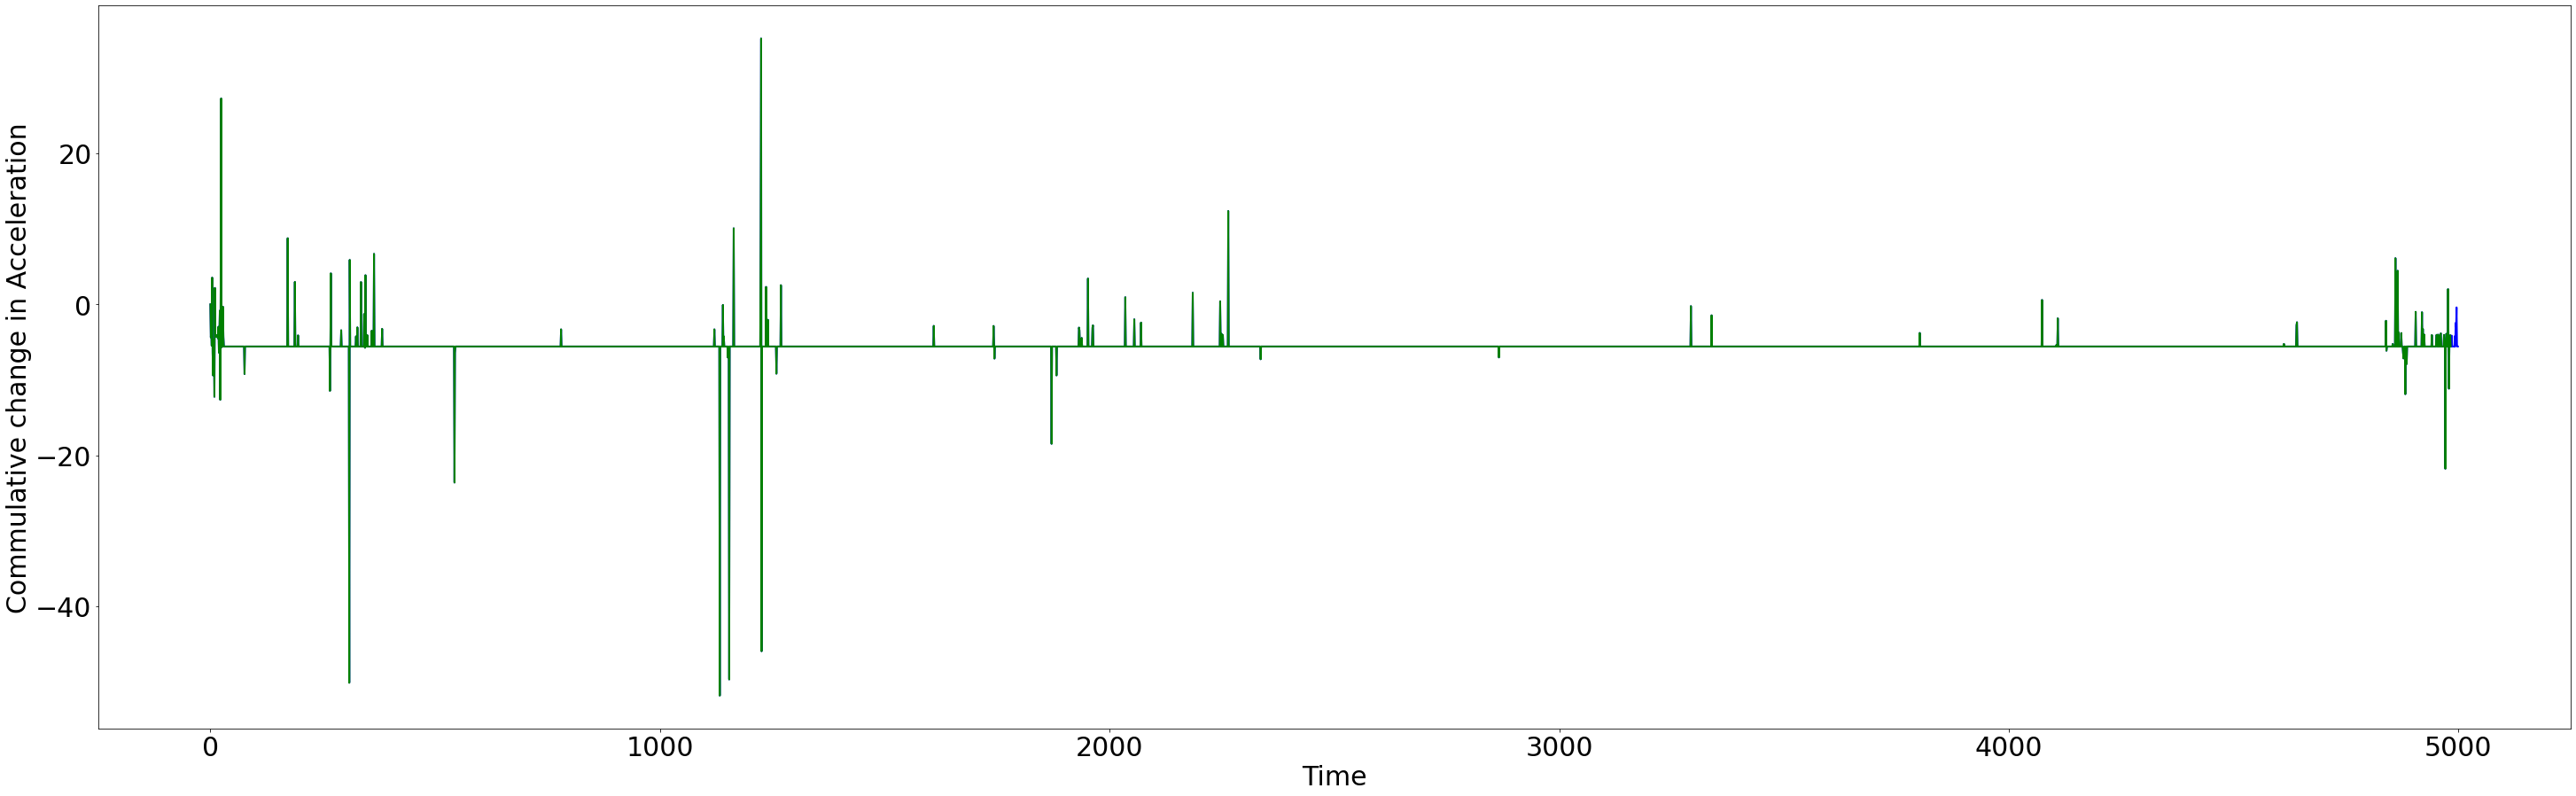

In [ ]:
##plot for Cwy
plt.plot(Cwy)
plt.plot(history)

plt.xlabel("Time")
plt.ylabel("Commulative change in Acceleration")
plt.show()

In [ ]:
### grid search for cumwz
scores = grid_search(Cwz, cfg_list, n_test)
print('done')

 > Model[[(1, 0, 0), (0, 0, 0, 0), 'n']] 5.065
 > Model[[(1, 1, 0), (0, 0, 0, 0), 'n']] 0.000
 > Model[[(0, 0, 0), (0, 0, 0, 0), 'n']] 4.360
 > Model[[(0, 1, 0), (0, 0, 0, 0), 'n']] 0.000
 > Model[[(0, 0, 1), (0, 0, 0, 0), 'n']] 4.890
 > Model[[(1, 0, 1), (0, 0, 0, 0), 'n']] 4.867
 > Model[[(0, 1, 1), (0, 0, 0, 0), 'n']] 0.000
 > Model[[(1, 1, 1), (0, 0, 0, 0), 'n']] 0.000
done


In [ ]:
# list top 3 configs
for cfg, error in scores[:3]:
    print(cfg, error)

[(0, 1, 0), (0, 0, 0, 0), 'n'] 0.0
[(1, 1, 0), (0, 0, 0, 0), 'n'] 0.0
[(0, 1, 1), (0, 0, 0, 0), 'n'] 0.00012859162367370028


In [ ]:
cfg = [(0, 1, 1), (0, 0, 0, 0), 'n']

In [ ]:
l=5000
Cwz = df['cumwz'].values[:l]

In [ ]:
history = walk_forward_validations(Cwz, 10, cfg)

6, 9.08, 3.3499585936750043
7, 4.36, 4.304961836690806
8, -3.19, 4.312830925433115
9, 18.78, 3.374981575836328
10, -1.72, 5.086628480979861
11, 4.01, 4.4059716554808634
12, 4.53, 4.369977276061264
13, 4.18, 4.38331452799892
14, 4.28, 4.3676765821055366
15, 4.61, 4.36141520488768
16, 3.95, 4.3779884392623565
17, 5.89, 4.351239993903723
18, 0.93, 4.441755694776012
19, 6.41, 4.246658866296686
20, 7.87, 4.360519114751228
21, -7.44, 4.53599313228561
22, 20.89, 3.9657075082609055
23, 27.74, 4.734989725248806
24, -28.59, 7.135580771069119
25, 4.74, 4.304978876612477
26, 4.08, 4.322380523703689
27, 9.63, 4.313059015636509
28, 0.37, 4.509982509012601
29, 3.08, 4.362127070678548
30, 4.36, 4.317916492208178
31, 4.36, 4.319319772615128
32, 4.36, 4.320632487244504
33, 4.36, 4.321863131745668
34, 4.36, 4.323019161099825
35, 4.36, 4.324107169452075
36, 4.36, 4.32513298480386
37, 4.36, 4.326101793334018
38, 4.36, 4.327018217748608
39, 4.36, 4.327886396602132
40, 4.36, 4.328710024131628
41, 4.36, 4.329

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


276, 4.36, 4.355563435207251
277, 4.36, 4.3555795105168835
278, 4.36, 4.355595469536838
279, 4.36, 4.355611313726899
280, 4.36, 4.35562704437365
281, 4.36, 4.3556426627319755
282, 4.36, 4.355658170026229
283, 4.36, 4.355673567446289
284, 4.36, 4.3556888561011355
285, 4.36, 4.355704036894613
286, 4.36, 4.355719111127998
287, 4.36, 4.355734079974905
288, 4.36, 4.355748944414841
289, 4.36, 4.355763705744001
290, 6.51, 4.355778364725935
291, 2.21, 4.363206720213309
292, 4.36, 4.355807379836985
293, 4.36, 4.355821738766248
294, 4.36, 4.355836000092971
295, 4.36, 4.355850164016477
296, 4.36, 4.355864231813418
297, 4.36, 4.355878204551346
298, 4.36, 4.35589208324324
299, 4.36, 4.355905868764658
300, 4.36, 4.355919562094295
301, 4.36, 4.355933164148815
302, 4.36, 4.355946675823304
303, 4.36, 4.355960098013687
304, 4.36, 4.3559734315961185
305, 4.36, 4.3559866774446965
306, 4.36, 4.35599983643002
307, 4.36, 4.356012909416097
308, -40.18, 4.356025897244599
309, 60.37, 4.2114282069395585
310, -7.

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


370, 4.36, 4.356693464245571
371, 4.36, 4.356702401583288
372, 4.36, 4.356711291066803
373, 4.36, 4.356720132505337
374, 4.36, 4.356728926534468
375, 4.36, 4.356737673533479
376, 4.36, 4.356746373863213
377, 4.36, 4.356755027917876
378, 4.36, 4.356763636068777
379, 4.36, 4.3567721986150065
380, 4.36, 4.356780716038053
381, 6.7, 4.356789188354566
382, 2.02, 4.362939353055309
383, 4.36, 4.356806000284143
384, 4.36, 4.356814340464856
385, 4.36, 4.356822637198559
386, 4.36, 4.356830890835494
387, 4.36, 4.356839101695302
388, 4.36, 4.3568472701223415
389, 4.36, 4.356855396437319
390, 4.36, 4.356863480961876
391, 4.36, 4.356871524011627
392, 4.36, 4.356879525910177
393, 4.36, 4.35688748704059
394, 4.36, 4.356895407674761
395, 4.36, 4.35690328803155
396, 4.36, 4.356911127197273
397, 4.36, 4.356918929332417
398, 4.36, 4.356926690906893
399, 4.36, 4.356934413518289
400, 4.36, 4.356942097233402
401, 4.36, 4.356949742611972
402, 4.36, 4.356957350036569
403, 4.36, 4.356964919390086
404, 4.36, 4.35

653, 4.36, 4.358128731372728
654, 4.36, 4.358131597276487
655, 4.36, 4.358134454676686
656, 4.36, 4.358137303422864
657, 4.36, 4.358140143535386
658, 4.36, 4.35814297503223
659, 4.36, 4.3581457979325515
660, 4.36, 4.358148612257941
661, 4.36, 4.358151417416163
662, 4.36, 4.358154214223249
663, 4.36, 4.3581570025809375
664, 4.36, 4.358159782527193
665, 4.36, 4.35816255409999
666, 4.36, 4.358165317337043
667, 4.36, 4.3581680722758565
668, 4.36, 4.358170818953782
669, 4.36, 4.358173557407869
670, 4.36, 4.358176287675023
671, 4.36, 4.358179009791765
672, 4.36, 4.35818172379452
673, 4.36, 4.358184429719484
674, 4.36, 4.358187127602649
675, 4.36, 4.358189817479733
676, 4.36, 4.358192499386314
677, 4.36, 4.3581951733577675
678, 4.36, 4.358197839429179
679, 4.36, 4.358200497635518
680, 4.36, 4.358203148011595
681, 4.36, 4.358205790591848
682, 4.36, 4.358208425410669
683, 4.36, 4.358211052502288
684, 4.36, 4.358213671900543
685, 4.36, 4.358216283639174
686, 4.36, 4.358218887751888
687, 4.36, 4.

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


728, 4.36, 4.358321787911695
729, 4.36, 4.358324093505055
730, 4.36, 4.358326392867556


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


731, 4.36, 4.358328686037439
732, 4.36, 4.358330973044622
733, 4.36, 4.358333253907731
734, 4.36, 4.358335528632224
735, 4.36, 4.358337793199906
736, 4.36, 4.358340054883321
737, 4.36, 4.358342310410013
738, 4.36, 4.358344559797651
739, 4.36, 4.358346806431963
740, 4.36, 4.358349043622979
741, 4.36, 4.3583512747670365
742, 4.36, 4.358353499888584
743, 4.36, 4.358355719012075
744, 4.36, 4.358357932161701
745, 4.36, 4.358360139361502
746, 4.36, 4.35836234063559
747, 4.36, 4.358364536007656
748, 4.36, 4.358366725501558
749, 4.36, 4.358368909140758
750, 4.36, 4.358371086948714
751, 4.36, 4.358373258948713
752, 4.36, 4.358375425163964
753, 4.36, 4.358377585617508
754, 4.36, 4.3583797403321825
755, 4.36, 4.358381889330851
756, 4.36, 4.358384032636144
757, 4.36, 4.358386170270599
758, 4.36, 4.358388302256601
759, 4.36, 4.358390428616374
760, 4.36, 4.358392549372165
761, 4.36, 4.358394664549538
762, 4.36, 4.358396770598361
763, 4.36, 4.3583988746855775
764, 4.36, 4.358400973251983
765, 4.36, 4

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


853, 4.36, 4.358568018605777
854, 4.36, 4.358569697436666


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


855, 4.36, 4.358571372335526
856, 4.36, 4.358573043316125
857, 4.36, 4.3585747103922925
858, 4.36, 4.358576373577709
859, 4.36, 4.358578032886031
860, 4.36, 4.358579688330777
861, 4.36, 4.358581339925358
862, 4.36, 4.3585829876834605
863, 4.36, 4.3585846316181485
864, 4.36, 4.35858627174301
865, 4.36, 4.3585879080711605
866, 4.36, 4.3585895406158235
867, 4.36, 4.358591169390053
868, 4.36, 4.358592794406992
869, 4.36, 4.358594415679651
870, 4.36, 4.358596033220966
871, 4.36, 4.35859764704386
872, 4.36, 4.358599257161145


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


873, 4.36, 4.358600863585487
874, 4.36, 4.358602466329728
875, 4.36, 4.358604065406545
876, 4.36, 4.358605660828335


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


877, 4.36, 4.358607252607827
878, 4.36, 4.35860884075757
879, 4.36, 4.358610425289804
880, 4.36, 4.358612006216877
881, 4.36, 4.358613583550401
882, 4.36, 4.358615157302603
883, 4.36, 4.358616727486883
884, 4.36, 4.358618294115295
885, 4.36, 4.358619857214195
886, 4.36, 4.358621416827665
887, 4.36, 4.358622972870777
888, 4.36, 4.358624525407671
889, 4.36, 4.35862607445009
890, 4.36, 4.358627620010103
891, 4.36, 4.358629162354456
892, 4.36, 4.3586307009652385
893, 4.36, 4.358632236126097
894, 4.36, 4.3586337678485005
895, 4.36, 4.358635296144211
896, 4.36, 4.358636821024457
897, 4.36, 4.35863834250095
898, 4.36, 4.35863986058485
899, 4.36, 4.358641375287627
900, 4.36, 4.358642886620555
901, 4.36, 4.358644394594757
902, 4.36, 4.358645899221595
903, 4.36, 4.358647400512198
904, 4.36, 4.358648898477603
905, 4.36, 4.358650393128838
906, 4.36, 4.358651884477009
907, 4.36, 4.358653372532998
908, 4.36, 4.3586548573078145
909, 4.36, 4.358656338812313
910, 4.36, 4.358657817057253
911, 4.36, 4.35

1155, 4.36, 4.35894275543388
1156, 4.36, 4.358943670857424
1157, 4.36, 4.358944584623399
1158, 4.36, 4.35894549710623
1159, 4.36, 4.358946407701583
1160, 4.36, 4.3589473168156125
1161, 4.36, 4.358948224363066
1162, 4.36, 4.358949130347483
1163, 20.02, 4.3589500347725005
1164, -11.3, 4.372416265641268
1165, 4.36, 4.358951836157285
1166, 4.36, 4.358952736500949


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1167, 4.36, 4.358953630152167
1168, 4.36, 4.358954531623503
1169, 4.36, 4.358955426386033
1170, 4.36, 4.358956320006207
1171, 4.36, 4.358957212098922
1172, 4.36, 4.358958102668762
1173, 4.36, 4.3589589917188745
1174, 4.36, 4.3589598792534945
1175, 4.36, 4.358960765275739
1176, 4.36, 4.35896164979017
1177, 4.36, 4.358962532800435
1178, 4.36, 4.358963414310329
1179, 4.36, 4.358964294323372
1180, 4.36, 4.358965172843541
1181, 4.36, 4.358966049874596
1182, 4.36, 4.358966925420738
1183, 4.36, 4.358967799484935
1184, 4.36, 4.3589686720714
1185, 4.36, 4.358969543184164
1186, 4.36, 4.358970412826632
1187, 4.36, 4.358971281002454
1188, 4.36, 4.358972147715247
1189, 4.36, 4.358973012969037
1190, 4.36, 4.358973876767529
1191, 4.36, 4.358974739113928
1192, 4.36, 4.358975600012388
1193, 4.36, 4.358976459466185
1194, 4.36, 4.358977317479295
1195, 4.36, 4.358978174054981
1196, 4.36, 4.358979029197072
1197, 4.36, 4.35897988290922
1198, 4.36, 4.358980735194585
1199, 4.36, 4.358981586057516
1200, 4.36, 

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1291, 4.36, 4.359054195178871
1292, 4.36, 4.359054924249877
1293, 4.36, 4.35905565375083
1294, 4.36, 4.359056384287695
1295, 4.36, 4.359057126033329
1296, 4.36, 4.359057848819889
1297, 4.36, 4.359058575831545
1298, 4.36, 4.359059301720008
1299, 4.36, 4.359060026480325
1300, 4.36, 4.359060750126168
1301, 4.36, 4.359061472908484
1302, 4.36, 4.359062194361094
1303, 4.36, 4.359062914704676
1304, 4.36, 4.359063633936807
1305, 4.36, 4.359064348213589
1306, 4.36, 4.3590650690023764
1307, 4.36, 4.359065784754191
1308, 4.36, 4.359066499328512
1309, 4.36, 4.35906721276525
1310, 4.36, 4.359067925843721
1311, 4.36, 4.359068637454621


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1312, 4.36, 4.35906934798312
1313, 4.36, 4.359070057427586
1314, 4.36, 4.359070765788217
1315, 4.36, 4.359071473064453
1316, 4.36, 4.359072179258145
1317, 4.36, 4.3590728843714635
1318, 4.36, 4.359073588406575
1319, 4.36, 4.359074291365445
1320, 4.36, 4.359074993251141
1321, 4.36, 4.359075694065395
1322, 4.36, 4.359076393810675
1323, 4.36, 4.359077092489462
1324, 4.36, 4.359077790104624
1325, 4.36, 4.359078486659026
1326, 4.36, 4.359079182157203
1327, 4.36, 4.359079876604546
1328, 4.36, 4.3590805700074
1329, 4.36, 4.35908126182674
1330, 4.36, 4.359081953519862
1331, 4.36, 4.359082644152213
1332, 4.36, 4.359083333680178
1333, 4.36, 4.359084022073182
1334, 4.36, 4.359084703244962
1335, 4.36, 4.359085395535314
1336, 4.36, 4.359086080705693
1337, 4.36, 4.359086764827661
1338, 4.36, 4.3590874478975286
1339, 4.36, 4.359088129826427
1340, 4.36, 4.359088810931804
1341, 4.36, 4.359089491015596
1342, 4.36, 4.359090170081564
1343, 4.36, 4.359090853672652
1344, 4.36, 4.359091518073842
1345, 4.36, 

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1465, 4.36, 4.359166614359389
1466, 4.36, 4.359167182630569
1467, 4.36, 4.359167750407289
1468, 4.36, 4.359168317868742
1469, 4.36, 4.359168885345385
1470, 4.36, 4.359169452603979
1471, 4.36, 4.359170018793359
1472, 4.36, 4.3591705833834835
1473, 4.36, 4.359171146506185
1474, 4.36, 4.3591717083881925
1475, 4.36, 4.359172271608522
1476, 4.36, 4.359172832175567
1477, 4.36, 4.35917339592444
1478, 4.36, 4.359173946933043
1479, 4.36, 4.359174509164939
1480, 4.36, 4.359175069927327
1481, 4.36, 4.3591756273110525
1482, 4.36, 4.35917618408595
1483, 4.36, 4.359176740086263
1484, 4.36, 4.359177295290076
1485, 4.36, 4.359177849699646
1486, 4.36, 4.3591784032976175
1487, 4.36, 4.359178956042821
1488, 4.36, 4.3591795079206275
1489, 4.36, 4.359180059091451
1490, 4.36, 4.359180610115055
1491, 4.36, 4.359181155593433
1492, 4.36, 4.359181701836797
1493, 4.36, 4.359182258459875
1494, 4.36, 4.359182806226133
1495, 4.36, 4.359183353271466
1496, 4.36, 4.35918389957883
1497, 4.36, 4.35918444515723
1498, 4.3

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1606, 4.36, 4.359239831854729
1607, 4.36, 4.359240305191493
1608, 7.09, 4.359240777943405
1609, 1.63, 4.360939028701412
1610, 4.36, 4.359241723367827
1611, 4.36, 4.35924219495077
1612, 4.36, 4.359242663118926
1613, 4.36, 4.359243133924074
1614, 4.36, 4.359243602381435
1615, 4.36, 4.359244071096034
1616, 4.36, 4.359244539231603
1617, 4.36, 4.359245006787949
1618, 4.36, 4.359245473766721
1619, 4.36, 4.35924594016883
1620, 4.36, 4.35924640599509
1621, 4.36, 4.359246871246624
1622, 4.36, 4.3592473359239925
1623, 4.36, 4.359247800028378
1624, 4.36, 4.359248263560771
1625, 4.36, 4.359248726522408
1626, 4.36, 4.359249188914051
1627, 4.36, 4.359249650736237
1628, 4.36, 4.359250111990439
1629, 4.36, 4.359250572677485
1630, 4.36, 4.359251032797769
1631, 4.36, 4.359251492353763
1632, 4.36, 4.35925195134537
1633, 4.36, 4.359252409773405
1634, 4.36, 4.359252867639378
1635, 4.36, 4.35925332494402
1636, 4.36, 4.359253781688304
1637, 4.36, 4.359254237873374
1638, 4.36, 4.359254693500302
1639, 4.36, 4.

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1659, 4.36, 4.359264134458545
1660, 4.36, 4.359264578054388
1661, 4.36, 4.359265021114583
1662, 4.36, 4.359265463640575
1663, 4.36, 4.359265905632858
1664, 4.36, 4.359266347092538
1665, 4.36, 4.3592667880205545
1666, 4.36, 4.3592672284179335


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1667, 4.36, 4.359267668285826
1668, 4.36, 4.359268107625024
1669, 4.36, 4.359268546436618
1670, 4.36, 4.359268984721286
1671, 4.36, 4.359269422480187
1672, 4.36, 4.359269859714151


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1673, 4.36, 4.359270296424547
1674, 4.36, 4.359270732611875
1675, 4.36, 4.359271168277462
1676, 4.36, 4.359271603421798
1677, 4.36, 4.359272038045954
1678, 4.36, 4.359272472151186
1679, 4.36, 4.3592729057384
1680, 4.36, 4.359273338808315
1681, 4.36, 4.359273771362173
1682, 4.36, 4.359274203400498
1683, 4.36, 4.359274634924272


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1684, 4.36, 4.359275065935044
1685, 4.36, 4.359275496433336
1686, 4.36, 4.359275926419945
1687, 4.36, 4.359276355896013
1688, 4.36, 4.359276784862228
1689, 4.36, 4.3592772133198325
1690, 4.36, 4.359277641269648
1691, 4.36, 4.359278068712596
1692, 4.36, 4.3592784956494635
1693, 4.36, 4.359278922081415
1694, 4.36, 4.359279348009297
1695, 4.36, 4.359279773434029


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1696, 4.36, 4.359280198356258
1697, 4.36, 4.3592806227774865
1698, 4.36, 4.359281046698284
1699, 4.36, 4.35928147011953
1700, 4.36, 4.359281893042195
1701, 4.36, 4.359282315467342
1702, 4.36, 4.359282737395527
1703, 4.36, 4.359283158827868
1704, 4.36, 4.359283579765433
1705, 4.36, 4.3592840002089845
1706, 4.36, 4.359284420159465
1707, 4.36, 4.359284839617609
1708, 4.36, 4.359285258584204
1709, 4.36, 4.359285677060929
1710, 4.36, 4.3592860950479


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1711, 4.36, 4.359286512546228
1712, 4.36, 4.359286929557027
1713, 4.36, 4.359287346080962
1714, 4.36, 4.35928776211886
1715, 4.36, 4.359288177671829
1716, 4.36, 4.359288592740693
1717, 4.36, 4.359289007326313
1718, 4.36, 4.3592894214294535
1719, 4.36, 4.359289835051152
1720, 4.36, 4.359290248192528
1721, 4.36, 4.359290660854005
1722, 4.36, 4.359291073036598
1723, 4.36, 4.359291484741303
1724, 4.36, 4.359291895968797
1725, 4.36, 4.359292306720365
1726, 4.36, 4.35929271699638
1727, 4.36, 4.359293126797999
1728, 4.36, 4.3592935361258665
1729, 4.36, 4.359293944981137
1730, 4.36, 4.359294353364589
1731, 4.36, 4.359294761277118
1732, 4.36, 4.359295168719478
1733, 4.36, 4.359295575692162
1734, 4.36, 4.359295982196812
1735, 4.36, 4.359296388233798
1736, 4.36, 4.35929679380414
1737, 4.36, 4.359297198908442
1738, 4.36, 4.35929760354792
1739, 4.36, 4.359298007722831


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1740, 4.36, 4.359298411434672
1741, 7.08, 4.359298814683863
1742, 1.98, 4.360861558586443
1743, 2.42, 4.359494800236789
1744, 5.96, 4.358382051964863
1745, 4.36, 4.359300422990131
1746, 4.36, 4.359300823931966
1747, 4.36, 4.3593012247548595
1748, 4.36, 4.359301624717481
1749, 4.36, 4.3593020245965866
1750, 4.36, 4.359302423756842
1751, 4.36, 4.359302822463641
1752, 4.36, 4.359303220717057
1753, 4.36, 4.359303618518431
1754, 4.36, 4.359304015867941
1755, 4.36, 4.359304412766709
1756, 4.36, 4.359304809215347
1757, 4.36, 4.359305205214629
1758, 4.36, 4.359305600765291
1759, 4.36, 4.359305995867525
1760, 4.36, 4.359306390522642


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1761, 4.36, 4.359306784730023
1762, 4.36, 4.359307178492743
1763, 4.36, 4.359307571809287
1764, 4.36, 4.3593079646813475
1765, 4.36, 4.359308357108679
1766, 4.36, 4.359308749092807
1767, 4.36, 4.359309140634253
1768, 4.36, 4.359309531733165
1769, 4.36, 4.359309922390414
1770, 4.36, 4.359310312606524


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1771, 4.36, 4.359310702381851
1772, 4.36, 4.359311091717177
1773, 4.36, 4.359311480613069
1774, 4.36, 4.3593118690704085
1775, 4.36, 4.359312257089558
1776, 4.36, 4.359312644670862
1777, 4.36, 4.359313031814987
1778, 4.36, 4.359313418522484
1779, 4.36, 4.359313804794039
1780, 4.36, 4.359314190630376
1781, 4.36, 4.359314576031762
1782, 4.36, 4.359314960998823
1783, 4.36, 4.359315345532058
1784, 4.36, 4.3593157296322484
1785, 4.36, 4.359316113299909
1786, 4.36, 4.359316496535616
1787, 4.36, 4.3593168793399695
1788, 4.36, 4.3593172617135885
1789, 4.36, 4.35931764365646
1790, 4.36, 4.359318025170874
1791, 4.36, 4.359318406255957
1792, 4.36, 4.359318786912684
1793, 4.36, 4.359319167141975
1794, 4.36, 4.3593195469441754
1795, 4.36, 4.359319926320064
1796, 4.36, 4.359320305270542
1797, 4.36, 4.359320683796194
1798, 4.36, 4.35932106189759
1799, 4.36, 4.359321439575529
1800, 4.36, 4.359321816830692
1801, 4.36, 4.359322193663853
1802, 4.36, 4.359322570076042
1803, 4.36, 4.35932294615218
1804, 4.

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1862, 4.36, 4.359344412137715
1863, 4.36, 4.359344764461044
1864, 4.36, 4.359345116441534
1865, 4.36, 4.359345467833943
1866, 4.36, 4.359345818254694
1867, 4.36, 4.3593461671866605
1868, 4.36, 4.359346514336145
1869, 4.36, 4.3593468616187625
1870, -8.53, 4.359347209323197
1871, 17.25, 4.352454384456495
1872, 4.36, 4.359347917856619
1873, 4.36, 4.359348266195921
1874, 4.36, 4.359348613075104
1875, 4.36, 4.3593489610502605
1876, 4.36, 4.359349308846171
1877, 4.36, 4.359349655730677
1878, 4.36, 4.359350002249557
1879, 4.36, 4.3593503484031695
1880, 4.36, 4.359350694190451
1881, 0.53, 4.359351039611448
1882, 8.19, 4.357315168638683
1883, 4.36, 4.3593517278263985
1884, 4.36, 4.359352071566934
1885, 4.36, 4.359352417738172
1886, 4.36, 4.359352759787783
1887, 4.36, 4.359353104622923
1888, 4.36, 4.359353447458245
1889, 4.36, 4.359353789925664
1890, 4.36, 4.359354132026284
1891, 4.36, 4.359354473760896
1892, 4.36, 4.359354815130987
1893, 4.36, 4.359355156137084
1894, 4.36, 4.359355496780744
189

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1966, 4.36, 4.359379105202165
1967, 4.36, 4.359379421458291
1968, 4.36, 4.359379743860028
1969, 4.36, 4.359380059032409
1970, 4.36, 4.359380373872381
1971, 4.36, 4.3593806883774695
1972, 4.36, 4.3593810025421105


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1973, 4.36, 4.359381316363241
1974, 4.36, 4.35938162983612
1975, 4.36, 4.359381942954164
1976, 4.36, 4.359382255713056
1977, 4.36, 4.3593825681053655
1978, 4.36, 4.359382880129652
1979, 4.36, 4.359383191781152
1980, 4.36, 4.359383503061431
1981, 4.36, 4.3593838139651995
1982, 4.36, 4.359384124502936
1983, 4.36, 4.359384434678418
1984, 4.36, 4.3593847445122265
1985, 4.36, 4.359385054020414
1986, 4.36, 4.3593853632246224
1987, 4.36, 4.359385672154218
1988, 4.36, 4.359385980835389
1989, 4.36, 4.359386289298525
1990, 4.36, 4.359386597567983
1991, 4.36, 4.35938690567621
1992, 4.36, 4.359387213652261
1993, 4.36, 4.359387521536262
1994, 4.36, 4.3593878293780906


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1995, 4.36, 4.35938813718954
1996, 4.36, 4.359388445203196
1997, 4.36, 4.359388753269941
1998, 4.36, 4.359389061380901
1999, 4.36, 4.3593893662349865
2000, 4.36, 4.359389667441632
2001, 4.36, 4.359389969914011
2002, 4.36, 4.359390273560579
2003, 4.36, 4.359390578201785
2004, 4.36, 4.359390882302819
2005, 4.36, 4.359391186471035
2006, 4.36, 4.35939149033564
2007, 4.36, 4.359391793998369
2008, 4.36, 4.35939209737281
2009, 4.36, 4.359392400412793
2010, 4.36, 4.359392717196574
2011, 4.36, 4.35939301851161
2012, 4.36, 4.359393319603096
2013, 4.36, 4.3593936204854895
2014, 4.36, 4.359393921159804
2015, 4.36, 4.359394221627357
2016, 4.36, 4.359394521876639
2017, 4.36, 4.35939482190556
2018, 4.36, 4.359395121703245
2019, 4.36, 4.359395421261315
2020, 4.36, 4.3593957205694895
2021, 4.36, 4.359396019620788
2022, 4.36, 4.359396308066723
2023, 4.36, 4.359396606465119
2024, 4.36, 4.3593969046105965
2025, 4.36, 4.359397202523229
2026, 4.36, 4.359397500228105
2027, 4.36, 4.359397797749666
2028, 4.36,

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2071, 4.36, 4.3594106088109
2072, 4.36, 4.359410893366338
2073, 4.36, 4.359411177826913
2074, 4.36, 4.3594114617801845


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2075, 4.36, 4.359411745701887
2076, 4.36, 4.359412029195612
2077, 4.36, 4.359412312413302
2078, 4.36, 4.359412595355621
2079, 4.36, 4.3594128780232895
2080, 4.36, 4.359413160417074
2081, 4.36, 4.359413442537843
2082, 4.36, 4.359413724386636
2083, 4.36, 4.359414005964236
2084, 4.36, 4.359414287271755
2085, 4.36, 4.359414568309815
2086, 4.36, 4.359414849078594
2087, 4.36, 4.359415129579671
2088, 4.36, 4.3594154098135
2089, 4.36, 4.359415689780971
2090, 4.36, 4.359415969481777
2091, 4.36, 4.359416248917788
2092, 4.36, 4.359416528088347
2093, 4.36, 4.359416806994348
2094, 4.36, 4.359417085636714
2095, 4.36, 4.359417364015157
2096, 4.36, 4.359417642129913
2097, 4.36, 4.35941791998219
2098, 4.36, 4.359418197571249
2099, 4.36, 4.359418474898569
2100, 4.36, 4.359418751963668
2101, 4.36, 4.3594190287668315
2102, 4.36, 4.359419305308789
2103, 4.36, 4.359419581589107
2104, 4.36, 4.359419857609177
2105, 4.36, 4.35942013336791
2106, 4.36, 4.359420408866556
2107, 4.36, 4.35942068411176
2108, 4.36, 4

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2301, 4.36, 4.359469550683095


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2302, 4.36, 4.359469781301592
2303, 4.36, 4.359470011726285
2304, 4.36, 4.359470241957039
2305, 4.36, 4.359470471990712
2306, 4.36, 4.359470701825371
2307, 4.36, 4.359470931457398
2308, 4.36, 4.359471160884549
2309, 4.36, 4.359471390102498
2310, 4.36, 4.35947161911064
2311, 4.36, 4.359471847909126
2312, 4.36, 4.359472076500416
2313, 4.36, 4.3594723048869835
2314, 4.36, 4.359472527975166
2315, 4.36, 4.35947275164451
2316, 4.36, 4.359472978316049
2317, 4.36, 4.3594732055092145
2318, 4.36, 4.359473443793746
2319, 4.36, 4.359473670929979
2320, 4.36, 4.359473897912649
2321, 4.36, 4.35947412469468
2322, 4.36, 4.359474351276611
2323, 4.36, 4.359474577672363
2324, 4.36, 4.359474803904817
2325, 4.36, 4.359475043200632
2326, 4.36, 4.359475245237833
2327, 4.36, 4.359475470724457
2328, 4.36, 4.359475704071784


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2329, 4.36, 4.359475922647033
2330, 4.36, 4.359476146747436
2331, 4.36, 4.35947637260831


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2332, 4.36, 4.359476599691282
2333, 4.36, 4.359476826943955
2334, 4.36, 4.359477053304834
2335, 2.67, 4.359477278571656
2336, 6.05, 4.358753701656067
2337, 4.36, 4.359477716614928
2338, 4.36, 4.359477940063201
2339, 4.36, 4.359478173685232
2340, 4.36, 4.359478395382759
2341, 4.36, 4.359478619740314
2342, 4.36, 4.359478842449429
2343, 4.36, 4.359479064996546
2344, 4.36, 4.3594792873991794
2345, 4.36, 4.359479509667526
2346, 4.36, 4.359479731595331
2347, 4.36, 4.3594799533825555
2348, 4.36, 4.35948017498019
2349, 4.36, 4.359480396388752
2350, 4.36, 4.359480617608351
2351, 4.36, 4.359480838639207
2352, 4.36, 4.359481059481754
2353, 4.36, 4.35948128013683
2354, 4.36, 4.359481500604798
2355, 4.36, 4.359481720886603
2356, 4.36, 4.359481940983223
2357, 4.36, 4.359482160895292
2358, 4.36, 4.359482380623494
2359, 4.36, 4.3594826001685405
2360, 4.36, 4.359482819530656
2361, 4.36, 4.359483038710748
2362, 4.36, 4.359483257709125
2363, 4.36, 4.359483476525538
2364, 4.36, 4.3594836951606215
2365, 4.

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2438, 4.36, 4.35949937346157
2439, 4.36, 4.3594995788974185
2440, 4.36, 4.359499784162544
2441, 4.36, 4.359499989253868
2442, 4.36, 4.359500194173046
2443, 4.36, 4.359500398918568
2444, 4.36, 4.359500603492592
2445, 4.36, 4.359500807894291
2446, 4.36, 4.359501012124705
2447, 4.36, 4.359501216183175
2448, 4.36, 4.359501420070842
2449, 4.36, 4.359501623788292
2450, 4.36, 4.359501827335104
2451, 4.36, 4.3595020307122585
2452, 4.36, 4.3595022339198835
2453, 4.36, 4.359502436959449
2454, 4.36, 4.35950263983101
2455, 4.36, 4.359502842535083
2456, 4.36, 4.359503045072092
2457, 4.36, 4.3595032474425075
2458, 4.36, 4.359503449646865
2459, 4.36, 4.359503651685405
2460, 4.36, 4.359503853558402
2461, 4.36, 4.35950405526658
2462, 4.36, 4.359504256810363
2463, 4.36, 4.359504458189569
2464, 4.36, 4.359504659404876
2465, 4.36, 4.359504860456451
2466, 4.36, 4.359505058138353
2467, 4.36, 4.359505259073837
2468, 4.36, 4.359505462682321
2469, 4.36, 4.359505663052359
2470, 4.36, 4.359505863257478
2471, 4.3

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2567, 4.36, 4.359524543505621
2568, 4.36, 4.3595247287381955
2569, 4.36, 4.3595249138242975
2570, 4.36, 4.359525098760086
2571, 4.36, 4.35952528354078
2572, 4.36, 4.359525467399977
2573, 4.36, 4.359525652058535
2574, 4.36, 4.359525836629778
2575, 4.36, 4.359526021130246
2576, 4.36, 4.359526205636571
2577, 4.36, 4.359526390137686
2578, 4.36, 4.359526574009788
2579, 4.36, 4.3595267575362575
2580, 4.36, 4.359526940896768
2581, 4.36, 4.359527124088538
2582, 4.36, 4.359527307117218
2583, 4.36, 4.359527489973744
2584, 4.36, 4.359527672661458
2585, 4.36, 4.359527855188221
2586, 4.36, 4.359528037554298
2587, 4.36, 4.359528219767023
2588, 4.36, 4.359528401816821
2589, 4.36, 4.359528583728275
2590, 4.36, 4.35952876549952
2591, 4.36, 4.3595289471405705
2592, 4.36, 4.359529128644523
2593, 4.36, 4.359529310022129


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2594, 4.36, 4.359529491282691
2595, 4.36, 4.3595296724231725
2596, 4.36, 4.359529853436854
2597, 4.36, 4.35953003435185
2598, 4.36, 4.359530215165645


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2599, 4.36, 4.359530395873598
2600, 4.36, 4.359530576481168
2601, 4.36, 4.359530756982292
2602, 4.36, 4.359530937380844
2603, 4.36, 4.359531117675993
2604, 4.36, 4.35953129786777
2605, 4.36, 4.359531477954624
2606, 4.36, 4.359531657939726
2607, 4.36, 4.359531837814603
2608, 4.36, 4.359532017578753
2609, 4.36, 4.359532197224267
2610, 4.36, 4.359532376757611
2611, 4.36, 4.359532556174699
2612, 4.36, 4.359532735470992
2613, 4.36, 4.3595329146413615
2614, 4.36, 4.359533093685471


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2615, 4.36, 4.3595332725865505
2616, 4.36, 4.3595334513615995
2617, 4.36, 4.359533629996867
2618, 4.36, 4.359533808483939
2619, 4.36, 4.359533986835297
2620, 4.36, 4.359534165040583
2621, 4.36, 4.359534343096682
2622, 4.36, 4.359534521003526
2623, 4.36, 4.359534698757341
2624, 4.36, 4.359534876363486
2625, 4.36, 4.359535053808451
2626, 4.36, 4.359535231102002
2627, 4.36, 4.359535408238079
2628, 4.36, 4.3595355852266415
2629, 4.36, 4.359535762063612
2630, 4.36, 4.3595359387508275


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2631, 4.36, 4.359536115288462
2632, 4.36, 4.359536291678829
2633, 4.36, 4.359536467924071
2634, 4.36, 4.359536644024434
2635, 4.36, 4.359536819982249
2636, 4.36, 4.359536995798833
2637, 4.36, 4.359537171477236
2638, 4.36, 4.3595373470176435
2639, 4.36, 4.359537522421418
2640, 4.36, 4.359537697689978
2641, 4.36, 4.359537872823935
2642, 4.36, 4.35953804782438
2643, 4.36, 4.359538222691611
2644, 4.36, 4.359538397426546
2645, 4.36, 4.35953857202905
2646, 4.36, 4.359538746499672
2647, 4.36, 4.35953892083843
2648, 4.36, 4.359539095045565
2649, 4.36, 4.359539269121217
2650, 4.36, 4.359539443065478
2651, 4.36, 4.359539616878692
2652, 4.36, 4.359539790560836
2653, 4.36, 4.359539963811633
2654, 4.36, 4.359540136320683
2655, 4.36, 4.359540308769758
2656, 4.36, 4.359540481193313
2657, 4.36, 4.359540653570069
2658, 4.36, 4.359540826386813
2659, 4.36, 4.3595409990176615
2660, 4.36, 4.359541171406158
2661, 4.36, 4.359541343739844
2662, 4.36, 4.359541516003498
2663, 4.36, 4.359541688190962
2664, 4.36,

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2745, 4.36, 4.359555387259101
2746, 4.36, 4.359555549227255
2747, 4.36, 4.3595557110821135
2748, 4.36, 4.359555872826179
2749, 4.36, 4.359556034458558
2750, 4.36, 4.359556195978378
2751, 4.36, 4.359556357387499
2752, 4.36, 4.359556518685108
2753, 4.36, 4.359556679872214
2754, 4.36, 4.359556840946427
2755, 4.36, 4.35955700190593
2756, 4.36, 4.359557162762024
2757, 4.36, 4.359557323500567
2758, 4.36, 4.359557484126804
2759, 4.36, 4.3595576446389135
2760, 4.36, 4.359557805040417
2761, 4.36, 4.359557965329154
2762, 4.36, 4.359558125510086
2763, 4.36, 4.35955828557222
2764, 4.36, 4.359558445518967
2765, 4.36, 4.359558605355598
2766, 4.36, 4.359558765079425
2767, 4.36, 4.359558924687617


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2768, 4.36, 4.3595590841840925
2769, 4.36, 4.35955924356719
2770, 4.36, 4.3595594028362825
2771, 4.36, 4.359559561985878
2772, 4.36, 4.359559721028967
2773, 4.36, 4.359559879956627
2774, 4.36, 4.35956003876159
2775, 4.36, 4.359560197458434
2776, 4.36, 4.359560356042845


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2777, 4.36, 4.359560514514308
2778, 4.36, 4.359560672870493
2779, 4.36, 4.359560831112772
2780, 4.36, 4.359560989242851
2781, 4.36, 4.359561147265112
2782, 4.36, 4.359561305163271
2783, 4.36, 4.359561462936088
2784, 4.36, 4.359561620605811
2785, 4.36, 4.359561778160816
2786, 4.36, 4.359561935602307
2787, 4.36, 4.359562092928484
2788, 4.36, 4.359562250143708
2789, 4.36, 4.359562407094836
2790, 4.36, 4.3595625640105595
2791, 4.36, 4.359562720813912
2792, 4.36, 4.35956287750483
2793, 4.36, 4.359563034083699
2794, 4.36, 4.359563190550334
2795, 4.36, 4.359563346904964
2796, 4.36, 4.359563503147687
2797, 4.36, 4.359563659278667
2798, 4.36, 4.359563815298083
2799, 4.36, 4.3595639712058905
2800, 4.36, 4.3595641270024
2801, 4.36, 4.3595642826875
2802, 4.36, 4.359564438261527
2803, 4.36, 4.359564593724412
2804, 4.36, 4.359564749076491
2805, 4.36, 4.359564904317541
2806, 4.36, 4.359565059448307
2807, 4.36, 4.359565214468152
2808, 4.36, 4.3595653693775755
2809, 4.36, 4.359565524176775
2810, 4.36, 

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2868, 4.36, 4.359574464424343
2869, 4.36, 4.359574613327051
2870, 4.36, 4.359574761255153
2871, 4.36, 4.359574909840104
2872, 4.36, 4.359575057846108
2873, 4.36, 4.3595752057509864
2874, 4.36, 4.35957535355408
2875, 4.36, 4.3595755012552875
2876, 4.36, 4.359575648856405
2877, 4.36, 4.359575796357472
2878, 4.36, 4.3595759437569335
2879, 4.36, 4.359576091057086
2880, 4.36, 4.359576238257543
2881, 4.36, 4.359576385356991


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2882, 4.36, 4.359576532357004
2883, 4.36, 4.359576679258144
2884, 4.36, 4.359576826059654
2885, 4.36, 4.359576972762647
2886, 4.36, 4.359577119366329
2887, 4.36, 4.3595772658705565
2888, 4.36, 4.359577412277061
2889, 4.36, 4.359577558584677
2890, 4.36, 4.359577704794426
2891, 4.36, 4.3595778509059
2892, 4.36, 4.35957799691924
2893, 4.36, 4.359578142835249
2894, 4.36, 4.359578288653225
2895, 4.36, 4.359578434374544
2896, 4.36, 4.359578579997503
2897, 4.36, 4.359578725523321
2898, 4.36, 4.3595788709523875
2899, 4.36, 4.359579016284397
2900, 4.36, 4.359579161519316
2901, 4.36, 4.359579306657678
2902, 4.36, 4.3595794517000055
2903, 4.36, 4.359579596644693
2904, 4.36, 4.35957974149233
2905, 4.36, 4.359579886244608
2906, 4.36, 4.359580030900491
2907, 4.36, 4.359580175459391
2908, 4.36, 4.359580319922228
2909, 4.36, 4.359580464288902
2910, 4.36, 4.359580608559135
2911, 4.36, 4.359580752734011
2912, 4.36, 4.35958089681224
2913, 4.36, 4.3595810407910465
2914, 4.36, 4.3595811846783405
2915, 4.36

3155, 4.36, 4.359613191998227
3156, 4.36, 4.359613314614298
3157, 4.36, 4.359613437152422
3158, 4.36, 4.359613559612919
3159, 4.36, 4.359613681995987
3160, 4.36, 4.359613804301673
3161, 4.36, 4.359613926529603
3162, 4.36, 4.3596140486806405
3163, 4.36, 4.3596141707540825
3164, 4.36, 4.359614292750585
3165, 4.36, 4.359614414669832
3166, 4.36, 4.359614536511911
3167, 4.36, 4.359614658277262
3168, 4.36, 4.35961477996547
3169, 4.36, 4.359614901576998
3170, 4.36, 4.3596150231121005
3171, 4.36, 4.3596151445701805
3172, 4.36, 4.359615265951772
3173, 4.36, 4.35961538725684
3174, 4.36, 4.3596155086141195
3175, 4.36, 4.359615629777922
3176, 4.36, 4.359615750864003
3177, 4.36, 4.359615871872579
3178, 4.36, 4.359615992804979
3179, 4.36, 4.359616113660786
3180, 4.36, 4.359616234440273
3181, 4.36, 4.359616355143048
3182, 4.36, 4.359616475770093
3183, 4.36, 4.359616596321347
3184, 4.36, 4.359616716796389
3185, 4.36, 4.359616837194692
3186, 4.36, 4.359616957518108
3187, 4.36, 4.359617077765432
3188, 4

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3227, 4.36, 4.3596218210510775
3228, 4.36, 4.359621938785742
3229, 4.36, 4.3596220565723165
3230, 4.36, 4.359622174241935
3231, 4.36, 4.3596222918777325
3232, 4.36, 4.3596224094896785


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3233, 4.36, 4.359622526955832
3234, 4.36, 4.359622644510995
3235, 4.36, 4.359622761652142
3236, 4.36, 4.35962287827444
3237, 4.36, 4.359622994825628
3238, 4.36, 4.359623111306159
3239, 4.36, 4.35962322771633
3240, 4.36, 4.359623344056076
3241, 4.36, 4.359623460325245
3242, 4.36, 4.3596235765256
3243, 4.36, 4.359623692655017
3244, 4.36, 4.359623808681686
3245, 4.36, 4.359623924660683
3246, 4.36, 4.359624040568217
3247, 4.36, 4.359624156404458
3248, 4.36, 4.359624272168943
3249, 4.36, 4.359624387862407
3250, 4.36, 4.359624503484904
3251, 4.36, 4.359624619035749
3252, 4.36, 4.359624734515882
3253, 4.36, 4.359624849924608
3254, 4.36, 4.359624965262747
3255, 4.36, 4.359625080529513
3256, 4.36, 4.359625195725946
3257, 4.36, 4.359625310851221
3258, 4.36, 4.359625425905966
3259, 4.36, 4.359625540889926
3260, 4.36, 4.359625655803678
3261, 4.36, 4.359625770646444
3262, 4.36, 4.3596258854188825
3263, 4.36, 4.359626000121235
3264, 4.36, 4.359626114752862
3265, 4.36, 4.359626229314539
3266, 4.36, 4

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3438, 4.36, 4.359645037595396
3439, 4.36, 4.359645141572598
3440, 4.36, 4.359645245571668
3441, 4.36, 4.359645349599773
3442, 4.36, 4.359645453669795
3443, 4.36, 4.359645557798303
3444, 4.36, 4.359645661945851
3445, 4.36, 4.359645766212943
3446, 4.36, 4.359645869348748
3447, 4.36, 4.359645972123648
3448, 4.36, 4.359646074842624
3449, 4.36, 4.359646177506673
3450, 4.36, 4.359646280115736
3451, 4.36, 4.359646382669532
3452, 4.36, 4.359646485168913
3453, 4.36, 4.359646587613181
3454, 4.36, 4.359646690002829
3455, 4.36, 4.359646792207862
3456, 4.36, 4.35964689444855
3457, 4.36, 4.359646996630097
3458, 4.36, 4.359647098752114
3459, 4.36, 4.3596472008146225
3460, 4.36, 4.3596473028177005
3461, 4.36, 4.3596474047619385
3462, 4.36, 4.3596475066478435
3463, 4.36, 4.359647608474711
3464, 4.36, 4.359647710243328
3465, 4.36, 4.3596478119540185
3466, 4.36, 4.359647913606094
3467, 4.36, 4.359648015200654
3468, 4.36, 4.359648116737549
3469, 4.36, 4.359648218216588
3470, 4.36, 4.359648319638404
3471, 

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3528, 4.36, 4.359654098218641
3529, 4.36, 4.359654196272023
3530, 4.36, 4.359654294269087
3531, 4.36, 4.3596543922107625
3532, 4.36, 4.3596544900984116
3533, 4.36, 4.359654587931356
3534, 4.36, 4.359654685709496
3535, 4.36, 4.359654783433158
3536, 4.36, 4.359654881104858
3537, 4.36, 4.3596549787185435
3538, 4.36, 4.359655076274775


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3539, 4.36, 4.359655173780882
3540, 4.36, 4.359655271231603
3541, 4.36, 4.359655368626579
3542, 4.36, 4.359655465968427
3543, 4.36, 4.359655563255902
3544, 4.36, 4.35965566048858
3545, 4.36, 4.3596557576671495
3546, 4.36, 4.359655854792225
3547, 4.36, 4.359655951868913
3548, 4.36, 4.359656048885375
3549, 4.36, 4.359656145845838
3550, 4.36, 4.3596562427535845
3551, 4.36, 4.359656339607781
3552, 4.36, 4.359656436408704


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3553, 4.36, 4.359656533155908
3554, 4.36, 4.359656629848825
3555, 4.36, 4.359656726484973
3556, 4.36, 4.359656823071078


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3557, 4.36, 4.359656919603563
3558, 4.36, 4.359657016083147
3559, 4.36, 4.359657112510138
3560, 4.36, 4.359657208879288
3561, 4.36, 4.359657305198578
3562, 4.36, 4.359657401464112
3563, 4.36, 4.3596574976769435
3564, 4.36, 4.359657593836088
3565, 4.36, 4.359657689942359
3566, 4.36, 4.359657785994883
3567, 4.36, 4.359657881995179
3568, 4.36, 4.359657977943456
3569, 4.36, 4.359658073837417
3570, 4.36, 4.359658169680812
3571, 4.36, 4.359658265468626
3572, 4.36, 4.359658361205163
3573, 4.36, 4.359658456889486
3574, 4.36, 4.35965855252106
3575, 4.36, 4.359658648099867
3576, 4.36, 4.359658743629162
3577, 4.36, 4.3596588391038935
3578, 4.36, 4.359658934526164
3579, 4.36, 4.359659029895786
3580, 4.36, 4.359659125213918
3581, 4.36, 4.3596592204809586
3582, 4.36, 4.35965931569487
3583, 4.36, 4.359659410854457
3584, 4.36, 4.359659505964752
3585, 4.36, 4.359659601023375
3586, 4.36, 4.359659696029773
3587, 4.36, 4.359659790985224
3588, 4.36, 4.359659885888375


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3589, 4.36, 4.359659980739882
3590, 4.36, 4.3596600755402815
3591, 4.36, 4.359660170289457
3592, 4.36, 4.359660264987149
3593, 4.36, 4.359660359633369


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3594, 4.36, 4.359660454227914
3595, 4.36, 4.359660548771704
3596, 4.36, 4.359660643263588
3597, 4.36, 4.359660737704687
3598, 4.36, 4.359660832094542
3599, 4.36, 4.359660926433542


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3600, 4.36, 4.359661020720684
3601, 4.36, 4.359661114957803
3602, 4.36, 4.359661209143722
3603, 4.36, 4.359661303278091
3604, 4.36, 4.359661397361052
3605, 4.36, 4.35966149139386
3606, 4.36, 4.359661585375388
3607, 4.36, 4.359661679305963
3608, 4.36, 4.359661773185476
3609, 4.36, 4.359661867013825
3610, 4.36, 4.359661960791706
3611, 4.36, 4.359662054517848
3612, 4.36, 4.359662148194166
3613, 4.36, 4.359662241818344
3614, 4.36, 4.359662335392013
3615, 4.36, 4.3596624289143335
3616, 4.36, 4.359662522384291
3617, 4.36, 4.359662615805692
3618, 4.36, 4.359662709175755
3619, 4.36, 4.359662802493848
3620, 4.36, 4.359662895760395
3621, 4.36, 4.359662988976741
3622, 4.36, 4.359663082140522
3623, 4.36, 4.359663175253781
3624, 4.36, 4.359663268315437
3625, 4.36, 4.359663361325738
3626, 4.36, 4.359663454283805
3627, 4.36, 4.359663547187821
3628, 4.36, 4.359663640047135
3629, 4.36, 4.359663732850843
3630, 4.36, 4.359663825603087
3631, 4.36, 4.359663918303439
3632, 4.36, 4.35966401095023
3633, 4.36,

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3666, 4.36, 4.359667127859241
3667, 4.36, 4.359667218573513
3668, 4.36, 4.359667309247463
3669, 4.36, 4.359667399883695
3670, 4.36, 4.359667490479885
3671, 4.36, 4.3596675810358665
3672, 4.36, 4.359667671550987
3673, 4.36, 4.359667762028276


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3674, 4.36, 4.359667852460645
3675, 4.36, 4.359667942854051
3676, 4.36, 4.359668033206378
3677, 4.36, 4.359668123529429
3678, 4.36, 4.359668213814349
3679, 4.36, 4.3596683040556945
3680, 4.36, 4.359668394253347
3681, 4.36, 4.359668484711292
3682, 4.36, 4.359668574861361
3683, 4.36, 4.359668664959138


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3684, 4.36, 4.359668755006059
3685, 4.36, 4.359668844997447
3686, 4.36, 4.359668934942468
3687, 4.36, 4.359669024835327
3688, 4.36, 4.359669114673533
3689, 4.36, 4.359669204462958
3690, 4.36, 4.359669294201703
3691, 4.36, 4.359669384725761
3692, 4.36, 4.359669474371278
3693, 4.36, 4.359669563964542
3694, 4.36, 4.359669653505752
3695, 4.36, 4.359669742996001
3696, 4.36, 4.35966983243
3697, 4.36, 4.359669921816796
3698, 4.36, 4.35967001114877
3699, 4.36, 4.3596701004283895
3700, 4.36, 4.3596701896570424
3701, 4.36, 4.359670278833734
3702, 4.36, 4.3596703681428135
3703, 4.36, 4.3596704568948965
3704, 4.36, 4.3596705456621105
3705, 4.36, 4.359670634446452
3706, 4.36, 4.359670723250306
3707, 4.36, 4.359670812071949
3708, 4.36, 4.3596709009102135
3709, 4.36, 4.35967098976817
3710, 4.36, 4.359671078631875
3711, 4.36, 4.359671167489603
3712, 4.36, 4.359671256326153
3713, 4.36, 4.359671344880182
3714, 4.36, 4.359671433394583
3715, 4.36, 4.359671521865914
3716, 4.36, 4.359671610295859
3717, 4.36

3957, 4.36, 4.359691618780608
3958, 4.36, 4.3596916967303425
3959, 4.36, 4.359691774641436
3960, 4.36, 4.359691852514283
3961, 4.36, 4.359691930348601
3962, 4.36, 4.359692008144022
3963, 4.36, 4.35969208590055
3964, 4.36, 4.359692163617451
3965, 4.36, 4.3596922412957335
3966, 4.36, 4.359692318933826
3967, 4.36, 4.359692396532217
3968, 4.36, 4.359692474091108
3969, 4.36, 4.359692551610152
3970, 4.36, 4.3596926290892
3971, 4.36, 4.3596927065282625
3972, 4.36, 4.359692783928027
3973, 4.36, 4.3596928612874954
3974, 4.36, 4.35969293860731
3975, 4.36, 4.359693015887443
3976, 4.36, 4.35969309312817
3977, 4.36, 4.359693170329403
3978, 4.36, 4.359693247491032
3979, 4.36, 4.359693324613336
3980, 4.36, 4.359693401696582
3981, 4.36, 4.359693478740552
3982, 4.36, 4.359693555745552
3983, 4.36, 4.35969363271201
3984, 4.36, 4.359693709639018
3985, 4.36, 4.359693786527485
3986, 4.36, 4.359693863377345
3987, 4.36, 4.35969394018836
3988, 4.36, 4.359694016961213
3989, 4.36, 4.359694093695288
3990, 4.36, 4

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4023, 4.36, 4.359696679828296


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4024, 4.36, 4.35969675524392
4025, 4.36, 4.3596968306279225
4026, 4.36, 4.359696905979697


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4027, 4.36, 4.359696981296493
4028, 4.36, 4.359697056577252
4029, 4.36, 4.359697131819157
4030, 4.36, 4.359697207019753
4031, 4.36, 4.35969728217807
4032, 4.36, 4.359697357293296
4033, 4.36, 4.359697432367037
4034, 4.36, 4.359697507401611
4035, 4.36, 4.35969758240157
4036, 4.36, 4.359697657372456
4037, 4.36, 4.359697732319828
4038, 4.36, 4.359697807250349
4039, 4.36, 4.3596978821630215
4040, 4.36, 4.359697956895639
4041, 4.36, 4.359698031664918
4042, 4.36, 4.359698106395646
4043, 4.36, 4.359698181088953
4044, 4.36, 4.3596982557465935
4045, 4.36, 4.3596983303704695
4046, 4.36, 4.359698404961709
4047, 4.36, 4.359698479520292
4048, 4.36, 4.359698554045187
4049, 4.36, 4.359698628534133
4050, 4.36, 4.3596987029854395
4051, 4.36, 4.35969877743997
4052, 4.36, 4.359698851771919
4053, 4.36, 4.35969892610015
4054, 4.36, 4.35969899802522
4055, 4.36, 4.359699069183493
4056, 4.36, 4.359699141082088
4057, 4.36, 4.359699215140248
4058, 4.36, 4.359699288611016
4059, 4.36, 4.359699362397472
4060, 4.36,

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4226, 4.36, 4.359711252618121
4227, 4.36, 4.35971132076248
4228, 4.36, 4.359711388912576
4229, 4.36, 4.359711457076448
4230, 4.36, 4.359711525252727
4231, 4.36, 4.359711593441217
4232, 4.36, 4.359711661639318
4233, 4.36, 4.359711729844638
4234, 4.36, 4.359711798052274
4235, 4.36, 4.359711866258628
4236, 4.36, 4.3597119344581525
4237, 4.36, 4.359712002645677
4238, 4.36, 4.359712070814904


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4239, 4.36, 4.359712138967352
4240, 4.36, 4.359712207090732
4241, 4.36, 4.359712275185779
4242, 4.36, 4.359712343246755
4243, 4.36, 4.359712411261837
4244, 4.36, 4.359712479248673
4245, 4.36, 4.359712547193675
4246, 4.36, 4.359712615096673
4247, 4.36, 4.3597126829565
4248, 4.36, 4.359712750778273
4249, 4.36, 4.359712818548496
4250, 4.36, 4.359712886274737
4251, 4.36, 4.359712953955874
4252, 4.36, 4.3597130215935405
4253, 4.36, 4.359713089188183
4254, 4.36, 4.359713156739391
4255, 4.36, 4.359713224249266
4256, 4.36, 4.359713291718257
4257, 4.36, 4.359713359146812
4258, 4.36, 4.359713426536341
4259, 4.36, 4.359713493887387
4260, 4.36, 4.35971356120072
4261, 4.36, 4.359713628477348
4262, 4.36, 4.359713695717941
4263, 4.36, 4.359713762922932
4264, 4.36, 4.359713830093356
4265, 4.36, 4.359713897229381
4266, 4.36, 4.35971396433119
4267, 4.36, 4.359714031400229
4268, 4.36, 4.35971409843633
4269, 4.36, 4.359714165439673
4270, 4.36, 4.359714232410787
4271, 4.36, 4.359714299349823
4272, 4.36, 4.

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4309, 4.36, 4.359716814550185
4310, 4.36, 4.359716880064253
4311, 4.36, 4.359716945598237
4312, 4.36, 4.359717011249283
4313, 4.36, 4.359717077110687
4314, 4.36, 4.359717142735192
4315, 4.36, 4.359717208493654
4316, 4.36, 4.359717273943992
4317, 4.36, 4.3597173393683
4318, 4.36, 4.359717404773307
4319, 4.36, 4.359717470154383
4320, 4.36, 4.359717535514124
4321, 4.36, 4.359717600849553
4322, 4.36, 4.359717666156684
4323, 4.36, 4.359717731440409
4324, 4.36, 4.359717796697203
4325, 4.36, 4.359717861929471
4326, 4.36, 4.359717927136606
4327, 4.36, 4.359717992315027
4328, 4.36, 4.359718057469652
4329, 4.36, 4.359718122594782
4330, 4.36, 4.3597181876942015
4331, 4.36, 4.359718252763325
4332, 4.36, 4.359718317807432
4333, 4.36, 4.359718382824745
4334, 4.36, 4.359718447814189
4335, 4.36, 4.359718512774278
4336, 4.36, 4.359718577707863
4337, 4.36, 4.359718642613303
4338, 4.36, 4.359718707488815
4339, 4.36, 4.359718772336779
4340, 4.36, 4.359718837155295
4341, 4.36, 4.359718901947976
4342, 4.36,

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4384, 4.36, 4.359721664416807
4385, 4.36, 4.359721728363743
4386, 4.36, 4.359721792285195
4387, 4.36, 4.3597218562293305
4388, 4.36, 4.359721920284855
4389, 4.36, 4.359721983668252
4390, 4.36, 4.35972204702319
4391, 4.36, 4.359722110348941
4392, 4.36, 4.359722173646067
4393, 4.36, 4.35972223691438
4394, 4.36, 4.359722300153859
4395, 4.36, 4.359722363364698
4396, 4.36, 4.3597224265466386
4397, 4.36, 4.359722489699825
4398, 4.36, 4.359722552824301
4399, 4.36, 4.359722615920405
4400, 4.36, 4.359722678987342
4401, 4.36, 4.359722742025789
4402, 4.36, 4.359722805035648
4403, 4.36, 4.359722868016754
4404, 4.36, 4.359722930969312
4405, 4.36, 4.3597229938932465
4406, 4.36, 4.3597230567883445
4407, 4.36, 4.359723119654916
4408, 4.36, 4.359723182492868
4409, 4.36, 4.359723245302074
4410, 4.36, 4.359723308081977
4411, 4.36, 4.359723370833539
4412, 4.36, 4.359723433555503
4413, 4.36, 4.359723496248269
4414, 4.36, 4.3597235589116785
4415, 4.36, 4.359723621545029
4416, 4.36, 4.3597236841485145
4417, 

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4426, 4.36, 4.3597243084062445
4427, 4.36, 4.359724370638175
4428, 4.36, 4.359724432831592
4429, 4.36, 4.359724494981823
4430, 4.36, 4.359724557094447
4431, 4.36, 4.359724619166412
4432, 4.36, 4.359724681196286
4433, 4.36, 4.359724743184407


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4434, 4.36, 4.359724805130264
4435, 4.36, 4.359724867034195
4436, 4.36, 4.359724928896867
4437, 4.36, 4.359724990718083
4438, 4.36, 4.359725052501275
4439, 4.36, 4.3597251142468485
4440, 4.36, 4.3597251759569025
4441, 4.36, 4.359725237635541
4442, 4.36, 4.359725299286054
4443, 4.36, 4.3597253609118285
4444, 4.36, 4.35972542251778
4445, 4.36, 4.359725484109273


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4446, 4.36, 4.359725545691178
4447, 4.36, 4.359725607274655
4448, 4.36, 4.359725668852729
4449, 4.36, 4.35972573043763
4450, 4.36, 4.359725792034312
4451, 4.36, 4.359725853646887
4452, 4.36, 4.359725915279897


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4453, 4.36, 4.359725976934467
4454, 4.36, 4.359726038611124
4455, 4.36, 4.359726100308246
4456, 4.36, 4.359726162022865


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4457, 4.36, 4.35972622375095
4458, 4.36, 4.35972628548512
4459, 4.36, 4.359726347216761
4460, 4.36, 4.35972640893646
4461, 4.36, 4.359726470635513
4462, 4.36, 4.359726532302891
4463, 4.36, 4.359726593927658
4464, 4.36, 4.35972665550577
4465, 4.36, 4.359726717019452
4466, 4.36, 4.359726778474714
4467, 4.36, 4.3597268398641935
4468, 4.36, 4.359726901186892
4469, 4.36, 4.359726962443887
4470, 4.36, 4.35972702334868
4471, 4.36, 4.359727083885117
4472, 4.36, 4.359727144552604
4473, 4.36, 4.359727205327246
4474, 4.36, 4.3597272662089575
4475, 4.36, 4.35972732716731
4476, 4.36, 4.359727388182692
4477, 4.36, 4.359727449234684
4478, 4.36, 4.359727510303687
4479, 4.36, 4.359727571404972
4480, 4.36, 4.35972763242563
4481, 4.36, 4.359727694653709
4482, 4.36, 4.359727754742381
4483, 4.36, 4.359727815411737
4484, 4.36, 4.3597278760024825
4485, 4.36, 4.359727936611169
4486, 4.36, 4.35972799735282
4487, 4.36, 4.359728058192044
4488, 4.36, 4.359728117696224
4489, 4.36, 4.359728178281589
4490, 4.36, 4.3

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4533, 4.36, 4.359730818440355
4534, 4.36, 4.359730877915407
4535, 4.36, 4.35973093736747
4536, 4.36, 4.359730996796133
4537, 4.36, 4.359731056197181
4538, 4.36, 4.359731115571192
4539, 4.36, 4.359731174908999
4540, 4.36, 4.359731234210267
4541, 4.36, 4.359731293471534
4542, 4.36, 4.359731352627174
4543, 4.36, 4.359731411788284
4544, 4.36, 4.359731471785019
4545, 4.36, 4.359731530023763
4546, 4.36, 4.359731589199458
4547, 4.36, 4.3597316481542325
4548, 4.36, 4.35973170727017
4549, 4.36, 4.359731763652638
4550, 4.36, 4.359731802877488
4551, 4.36, 4.359731861824865
4552, 4.36, 4.359731920746209
4553, 4.36, 4.359731979641315
4554, 4.36, 4.359732038510333
4555, 4.36, 4.359732097352823
4556, 4.36, 4.359732156169325
4557, 4.36, 4.35973221495935
4558, 4.36, 4.359732273723345
4559, 4.36, 4.35973233246132
4560, 4.36, 4.359732391173166
4561, 4.36, 4.359732449859003
4562, 4.36, 4.3597325085192145
4563, 4.36, 4.359732567153717
4564, 4.36, 4.359732625763017
4565, 4.36, 4.359732684347224
4566, 4.36, 

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4623, 4.36, 4.359736057583559
4624, 4.36, 4.35973611535699
4625, 4.36, 4.359736173375444
4626, 4.36, 4.359736231673295
4627, 4.36, 4.359736289829322
4628, 4.36, 4.359736346834084
4629, 4.36, 4.3597364038141455
4630, 4.36, 4.359736460769611
4631, 4.36, 4.359736517698866
4632, 4.36, 4.359736574598802
4633, 4.36, 4.359736631461689
4634, 4.36, 4.359736688276986
4635, 4.36, 4.359736745030318
4636, 4.36, 4.359736801705814
4637, 4.36, 4.3597368582882465


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4638, 4.36, 4.3597369147656195
4639, 7.19, 4.359736971131439
4640, 4.74, 4.360347183471994
4641, 1.15, 4.360428990219829
4642, 4.36, 4.359737137505544
4643, 4.36, 4.359737198832009
4644, 4.36, 4.359737232998513
4645, 4.36, 4.359737289664495
4646, 4.36, 4.3597373685690135
4647, 4.36, 4.3597374251783085
4648, 4.36, 4.359737481627217
4649, 4.36, 4.359737538116706
4650, 4.36, 4.359737594203797
4651, 4.36, 4.3597376484633426
4652, 4.36, 4.359737708110568
4653, 4.36, 4.359737763847421
4654, 4.36, 4.359737820217162
4655, 4.36, 4.359737876562846
4656, 4.36, 4.359737932884422
4657, 4.36, 4.359737989181932
4658, 4.36, 4.359738023043448
4659, 4.36, 4.359738079293087
4660, 4.36, 4.359738135516903
4661, 4.36, 4.359738191714647
4662, 4.36, 4.359738247886758
4663, 4.36, 4.359738304033016
4664, 4.36, 4.359738360153055
4665, 4.36, 4.359738416247758
4666, 4.36, 4.359738472316422
4667, 4.36, 4.359738528359549
4668, 4.36, 4.3597385843772285
4669, 4.36, 4.3597386403693195
4670, 4.36, 4.359738696336709
4671

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4722, 4.36, 4.35974159299712
4723, 4.36, 4.359741647514873
4724, 4.36, 4.359741702099094
4725, 4.36, 4.359741756771634
4726, 4.36, 4.359741811547778
4727, 4.36, 4.3597418664485295
4728, 4.36, 4.359741921491423
4729, 4.36, 4.359741976699808
4730, 4.36, 4.359742032096427
4731, 4.36, 4.359742087702729
4732, 4.36, 4.359742143542474
4733, 4.36, 4.359742198163975
4734, 4.36, 4.35974225264403
4735, 4.36, 4.359742307100733
4736, 4.36, 4.359742361534747
4737, 4.36, 4.359742415943704
4738, 4.36, 4.359742470326039
4739, 4.36, 4.359742524675813
4740, 4.36, 4.359742578985808
4741, 4.36, 4.359742633246352
4742, 4.36, 4.359742687439735
4743, 4.36, 4.359742741564544
4744, 4.36, 4.359742795605578
4745, 4.36, 4.359742849556025
4746, 4.36, 4.3597429034119815
4747, 4.36, 4.359742957178768
4748, 4.36, 4.359743010867207
4749, 4.36, 4.35974306449537
4750, 4.36, 4.35974311808944
4751, 4.36, 4.359743171681772
4752, 4.36, 4.3597432253052215
4753, 4.36, 4.359743278993136


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4754, 4.36, 4.359743332773697
4755, 4.36, 4.359743386668544
4756, 4.36, 4.3597434406880975


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4757, 4.36, 4.35974349483281
4758, 4.36, 4.359743549091391
4759, 4.36, 4.359743603415667
4760, 4.36, 4.359743657823185
4761, 4.36, 4.35974371226058
4762, 4.36, 4.359743766692572
4763, 4.36, 4.359743821115601
4764, 4.36, 4.359743875438177
4765, 4.36, 4.359743929673659
4766, 4.36, 4.359743983809639
4767, 4.36, 4.359744036916184
4768, 4.36, 4.359744089585091
4769, 4.36, 4.359744142642077
4770, 4.36, 4.359744195822151
4771, 4.36, 4.359744249118203
4772, 4.36, 4.359744305901149
4773, 4.36, 4.359744359496001
4774, 4.36, 4.359744413082726
4775, 4.36, 4.359744466653192
4776, 4.36, 4.359744519365721
4777, 4.36, 4.359744573072573
4778, 4.36, 4.359744626728439
4779, 4.36, 4.35974468033534
4780, 4.36, 4.359744733886068
4781, 4.36, 4.359744787393849
4782, 4.36, 4.35974484086112
4783, 4.36, 4.359744894269688
4784, 4.36, 4.3597449473152246
4785, 4.36, 4.359745000590014
4786, 4.36, 4.35974505417122
4787, 4.36, 4.359745107444038
4788, 4.36, 4.359745160425775
4789, 4.36, 4.359745213684827
4790, 4.36, 4.

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4802, 4.36, 4.359745903100729
4803, 4.36, 4.359745955563486
4804, 4.36, 4.359746008111819
4805, 4.36, 4.359746060792273
4806, 4.36, 4.359746114111224
4807, 4.36, 4.359746168456834
4808, 4.36, 4.359746221316497
4809, 4.36, 4.3597462741181525
4810, 4.36, 4.359746326858846
4811, 4.36, 4.3597463795977545
4812, 4.36, 4.359746432392566
4813, 4.36, 4.359746485252644
4814, 4.36, 4.359746538130161
4815, 4.36, 4.359746590963344
4816, 4.36, 4.359746643713437
4817, 4.36, 4.359746696005426
4818, 4.36, 4.3597467439823125
4819, 4.36, 4.359746797324137
4820, 4.36, 4.359746852810684
4821, 4.36, 4.359746905912142
4822, 4.36, 4.359746958420468
4823, 4.36, 4.359747010897199
4824, 4.36, 4.3597470606469715
4825, 4.36, 4.359747113760939
4826, 4.36, 4.35974716636959
4827, 4.36, 4.359747218758372
4828, 4.36, 4.359747271711663
4829, 4.36, 4.359747332987043
4830, 4.36, 4.359747371044235
4831, 4.36, 4.359747421411042
4832, 4.36, 4.359747471560512
4833, 4.36, 4.3597475247721444
4834, 4.36, 4.3597475785154
4835, 4.

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4836, 4.36, 4.359747687214559
4837, 4.36, 4.359747741865095
4838, 7.77, 4.359747795213993
4839, 0.39, 4.360452873609613
4840, 4.92, 4.359632150749307
4841, 4.36, 4.359747951891328
4842, 4.36, 4.359748003985811
4843, 4.36, 4.359748056034752


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4844, 4.36, 4.359748106550764
4845, 4.36, 4.3597481585748366
4846, 4.36, 4.359748210491073
4847, 4.36, 4.359748264124193
4848, 4.36, 4.359748316355232
4849, 4.36, 4.359748368514848
4850, 4.36, 4.359748420595829
4851, 4.36, 4.359748472598233
4852, 4.36, 4.359748521519042
4853, 4.7, 4.359748573424188
4854, 4.02, 4.35981869782477
4855, 4.36, 4.359748677535694


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4856, 4.36, 4.359748729604409
4857, 4.36, 4.359748781564322
4858, 4.36, 4.359748833791459
4859, 16.06, 4.359748885675889
4860, -7.34, 4.362157238042801
4861, 4.36, 4.359748967620215
4862, 4.36, 4.359749036737033
4863, 4.36, 4.359749092225861
4864, 14.39, 4.359749142911096
4865, -5.67, 4.361811496656452
4866, 6.22, 4.359749246747622
4867, 2.5, 4.360131618423001
4868, 4.36, 4.3597493494397375
4869, 4.36, 4.359749397586849
4870, 4.36, 4.359749450591446
4871, 4.36, 4.359749504193829
4872, 6.14, 4.359749555593217
4873, 2.58, 4.360115031944369
4874, 4.36, 4.359749658407103
4875, 4.36, 4.359749709772761
4876, 3.47, 4.359749738215288
4877, 3.67, 4.359567249610855
4878, 5.3, 4.359425833241174
4879, 5.0, 4.35961868776354
4880, 4.36, 4.359749964523452
4881, -1.95, 4.359750017597388
4882, 10.67, 4.358457044048209
4883, 4.36, 4.359750116070746
4884, 2.04, 4.359750171371472
4885, 6.68, 4.359275108286877
4886, 4.36, 4.359750250298633
4887, 4.36, 4.359750324778766
4888, 4.36, 4.3597503758500995
4889, 

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4892, 4.36, 4.359750578782129
4893, 4.36, 4.359750628934434
4894, 4.36, 4.359750679017466
4895, 4.36, 4.359750729105595
4896, 4.36, 4.359750779425288
4897, 4.36, 4.359750830588123
4898, 4.36, 4.359750881289562
4899, 4.36, 4.35975093206604
4900, 4.36, 4.359750987432864
4901, 4.36, 4.359751038277703
4902, 4.36, 4.359751089101647
4903, 4.36, 4.359751139501436
4904, 8.95, 4.359751190245863
4905, -0.23, 4.3606873775261175
4906, 4.36, 4.359751268801588
4907, 4.36, 4.359751319364925
4908, 4.36, 4.359751391842042
4909, 4.36, 4.359751444203773
4910, 4.36, 4.359751493852577
4911, 4.36, 4.359751544357536
4912, 4.36, 4.35975159483821
4913, 4.36, 4.359751645298565
4914, 4.36, 4.359751695739384
4915, 4.36, 4.359751746149675
4916, 4.36, 4.359751796544725


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4917, 4.36, 4.3597518469232845
4918, 8.9, 4.359751897283116
4919, -0.18, 4.360675269857767
4920, 6.7, 4.359751999822729


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4921, 2.02, 4.360227643093516


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4922, 4.36, 4.359752099721051
4923, 5.93, 4.359752151091464
4924, 2.79, 4.360071166170199


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4925, 4.36, 4.359752251078761
4926, 4.36, 4.359752301835189
4927, 4.36, 4.359752352226158


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4928, 4.36, 4.35975240191661
4929, 4.36, 4.359752452649107
4930, 4.36, 4.359752503119056
4931, 4.36, 4.359752550694766
4932, 4.36, 4.359752596391156
4933, 4.36, 4.359752653525013


/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4934, 4.36, 4.359752703542679
4935, 4.36, 4.359752753565128
4936, 4.36, 4.359752803573569
4937, 4.36, 4.359752853573093
4938, 4.36, 4.359752903577401
4939, 4.36, 4.359752953593575
4940, 5.88, 4.3597530036264684
4941, 2.84, 4.360060806529349
4942, 4.36, 4.35975310327515
4943, 4.36, 4.359753152931882
4944, 4.36, 4.359753203680572
4945, 4.36, 4.3597532529508385
4946, 4.36, 4.359753303787607
4947, 4.36, 4.359753353608455
4948, 4.36, 4.359753403398272
4949, 4.36, 4.35975345316473
4950, 5.86, 4.359753502909822
4951, 4.4, 4.36005664358038
4952, 2.82, 4.360064713794674
4953, 4.36, 4.359753651601965
4954, 5.93, 4.359753701942053
4955, 2.79, 4.360070732388352
4956, 4.36, 4.35975379738144
4957, 4.36, 4.359753851084966
4958, 4.36, 4.35975390118593
4959, 5.98, 4.359753950388522
4960, 4.48, 4.36008074391141
4961, 2.62, 4.36010489815435
4962, 4.36, 4.35975409919594
4963, 4.36, 4.359754148061481
4964, 4.36, 4.359754198634186
4965, 4.36, 4.359754248146214
4966, 4.36, 4.35975429807346
4967, 5.89, 4.3597

/home/terminator/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4974, 2.78, 4.360072474033857
4975, 4.36, 4.359754742305012
4976, 11.96, 4.359754768363574
4977, -1.9, 4.361282483256113
4978, -2.56, 4.360024179612075
4979, 9.94, 4.358633787114341
4980, 4.36, 4.359754987918367
4981, 5.86, 4.35975503551981
4982, 2.86, 4.360056294327302
4983, 4.36, 4.359755113489926


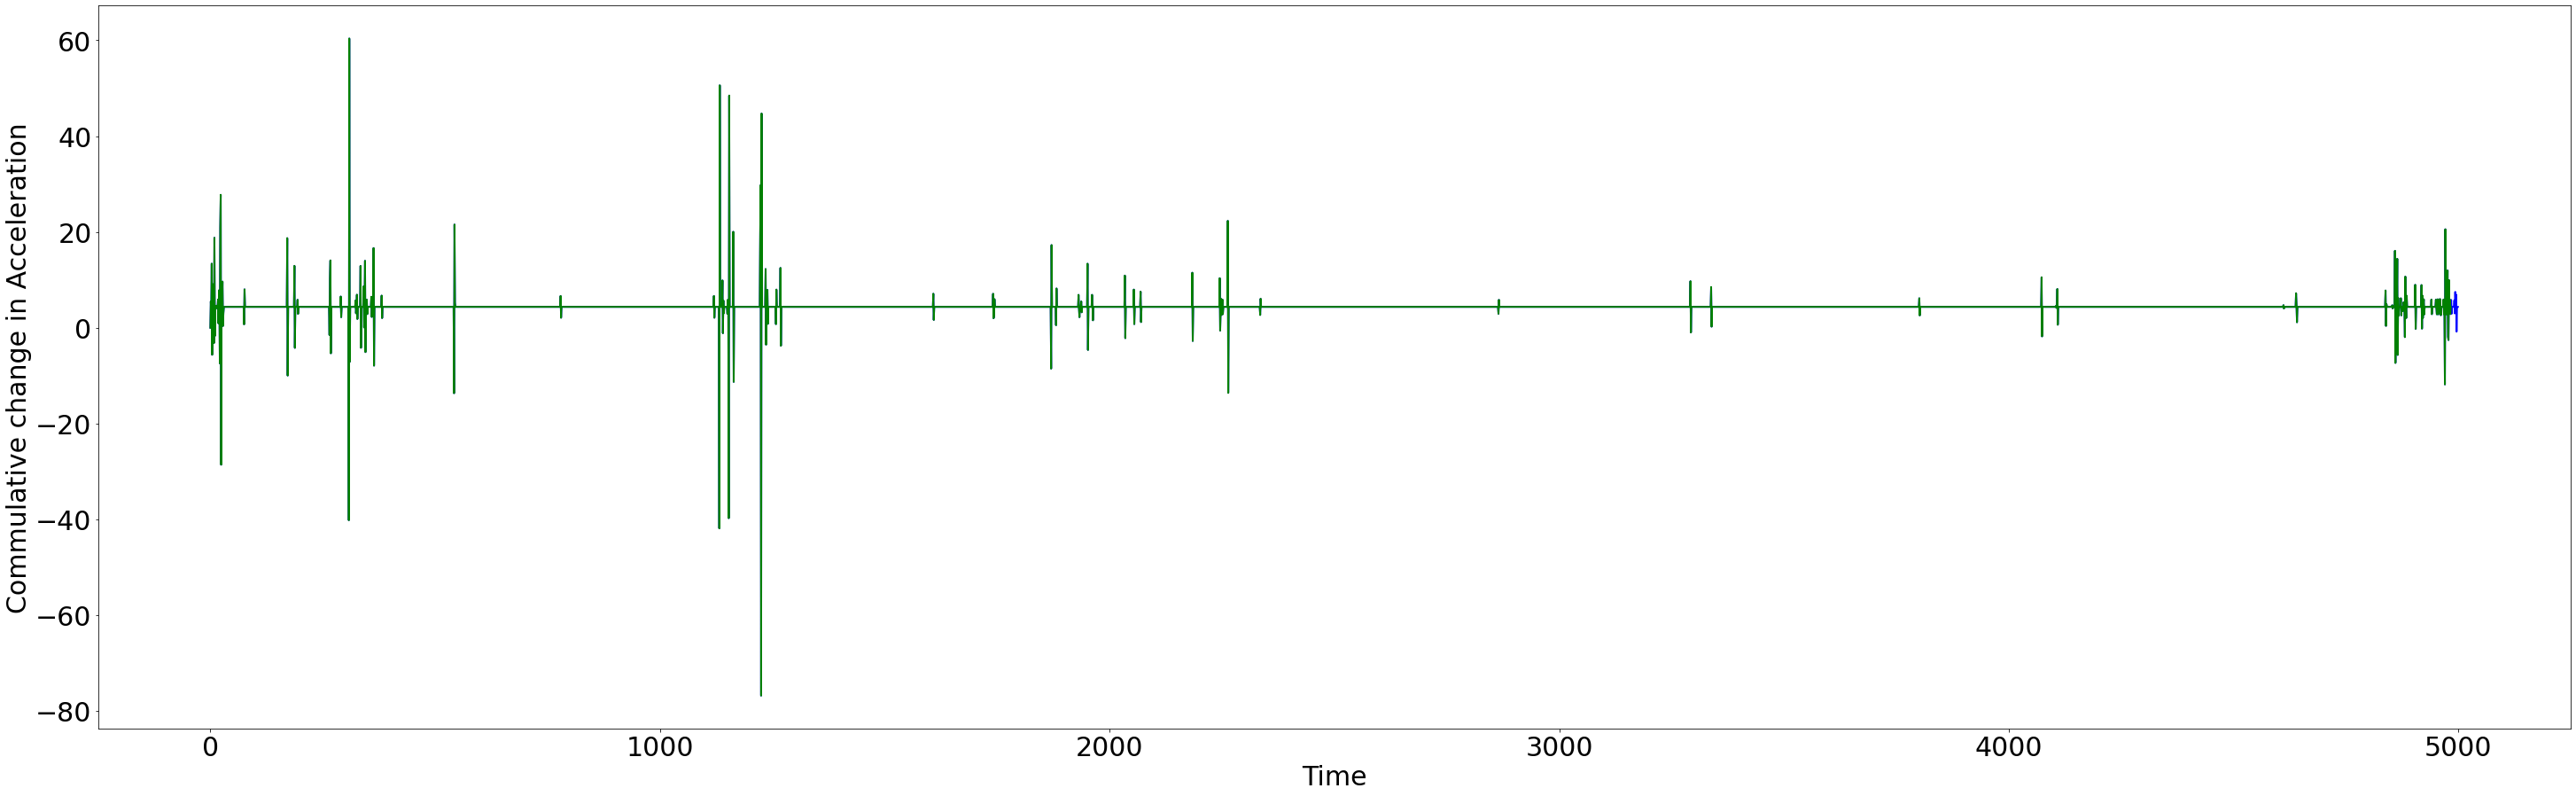

In [ ]:
##plot for Cwz
plt.plot(Cwz)
plt.plot(history)

plt.xlabel("Time")
plt.ylabel("Commulative change in Acceleration")
plt.show()